#### &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; This notebook is a 99% copy of the architecture next notebooks: 
#### [XGBoost Starter Ensemble - [LB 0.935] - Wow!](https://www.kaggle.com/code/vyacheslavbolotin/xgboost-starter-ensemble-lb-0-935-wow/edit) &nbsp;&&nbsp; [RAPIDS KNN Starter Ensemble - [LB 0.961] - Wow!](https://www.kaggle.com/code/cdeotte/rapids-knn-starter-ensemble-lb-0-961-wow)
### &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  &nbsp;  &nbsp;  &nbsp;  &nbsp;  &nbsp; of American [grandmaster](https://www.kaggle.com/cdeotte/code) Chris Deotte 
#### &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  &nbsp;  &nbsp; with the addition of hyperspace feats - in the hope 
#### &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  &nbsp;  &nbsp;&nbsp; that they will slightly increase the accuracy.

# &nbsp; **Part 1** &nbsp;-&nbsp; [XGBoost Starter Ensemble - [LB 0.935] - Wow!](https://www.kaggle.com/code/vyacheslavbolotin/xgboost-starter-ensemble-lb-0-935-wow/edit)

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings("ignore")
from sklearn.metrics import roc_auc_score
import polars as pl
from sklearn.model_selection import KFold
from xgboost import XGBRegressor, XGBClassifier
import xgboost
from cuml.neighbors import KNeighborsClassifier
print("Using XGBoost version",xgboost.__version__)

Using XGBoost version 2.0.3


# XGBoost
We train 5 fold XGBoost model. We use `max_depth=3`, `colsample_bytree=0.9`, and `subsample=0.9`. These are the 3 hyperparameters that i like to tune.

In [2]:
# .. fen .. 1, 2__,2_h, 4,5,7

def fen1(df):
    #df['pressure_cut']      = df['pressure'] - 1000
    df['pressure_cut']      = df.cloud    * df.humidity * df.sunshine / (np.sqrt(df.cloud**2 + df.humidity**2 + df.sunshine**2) +0.00000001)
    df['cloud_sunshine']    = df.cloud    * df.sunshine / (np.sqrt(df.cloud**2    + df.sunshine**2) +0.00000001)
    df['humidity_dewpoint'] = df.humidity * df.sunshine / (np.sqrt(df.humidity**2 + df.sunshine**2) +0.00000001)
    df = df.rename(columns={ 'maxtemp':'x1', 'temparature':'x2', 'mintemp':'x3', 'dewpoint':'x4', 'humidity':'x5', 'cloud':'x6', 'sunshine':'x7', 'winddirection':'x8', 'windspeed':'x9', 'pressure_cut':'x10', 'cloud_sunshine':'x11', 'humidity_dewpoint':'x12', } ) 
    polar_df = pl.from_pandas(df)
    polar_df = polar_df.with_columns(
    _4_1 = ((pl.col('x1')-pl.col('x5'))**2+(pl.col('x2')-pl.col('x6'))**2+(pl.col('x3')-pl.col('x7'))**2+(pl.col('x4')-pl.col('x8'))**2).sqrt(),
    _4_2 = ((pl.col('x1')-pl.col('x9'))**2+(pl.col('x2')-pl.col('x10'))**2+(pl.col('x3')-pl.col('x11'))**2+(pl.col('x4')-pl.col('x12'))**2).sqrt(),
    _4_3 = ((pl.col('x5')-pl.col('x9'))**2+(pl.col('x6')-pl.col('x10'))**2+(pl.col('x7')-pl.col('x11'))**2+(pl.col('x8')-pl.col('x12'))**2).sqrt(),
    _5_1 = ((pl.col('x1')-pl.col('x6'))**2+(pl.col('x2')-pl.col('x7'))**2+(pl.col('x3')-pl.col('x8'))**2+(pl.col('x4')-pl.col('x9'))**2+(pl.col('x5')-pl.col('x10'))**2).sqrt(),
    )
    df = polar_df.to_pandas()
    return df


def fen2(df):
    df['pressure_cut']      = df['pressure'] - 1000
    #df['pressure_cut']      = df.cloud    * df.humidity * df.sunshine / (np.sqrt(df.cloud**2 + df.humidity**2 + df.sunshine**2) +0.00000001)
    df['cloud_sunshine']    = df.cloud    * df.sunshine / (np.sqrt(df.cloud**2    + df.sunshine**2) +0.00000001)
    df['humidity_dewpoint'] = df.humidity * df.sunshine / (np.sqrt(df.humidity**2 + df.sunshine**2) +0.00000001)
    df = df.rename(columns={ 'maxtemp':'x1', 'temparature':'x2', 'mintemp':'x3', 'dewpoint':'x4', 'humidity':'x5', 'cloud':'x6', 'sunshine':'x7', 'winddirection':'x8', 'windspeed':'x9', 'pressure_cut':'x10', 'cloud_sunshine':'x11', 'humidity_dewpoint':'x12', } ) 
    polar_df = pl.from_pandas(df)
    polar_df = polar_df.with_columns(
    #_4_1 = ((pl.col('x1')-pl.col('x5'))**2+(pl.col('x2')-pl.col('x6'))**2+(pl.col('x3')-pl.col('x7'))**2+(pl.col('x4')-pl.col('x8'))**2).sqrt(),
    _4_2 = ((pl.col('x1')-pl.col('x9'))**2+(pl.col('x2')-pl.col('x10'))**2+(pl.col('x3')-pl.col('x11'))**2+(pl.col('x4')-pl.col('x12'))**2).sqrt(),
    _4_3 = ((pl.col('x5')-pl.col('x9'))**2+(pl.col('x6')-pl.col('x10'))**2+(pl.col('x7')-pl.col('x11'))**2+(pl.col('x8')-pl.col('x12'))**2).sqrt(),
    #_5_1 = ((pl.col('x1')-pl.col('x6'))**2+(pl.col('x2')-pl.col('x7'))**2+(pl.col('x3')-pl.col('x8'))**2+(pl.col('x4')-pl.col('x9'))**2+(pl.col('x5')-pl.col('x10'))**2).sqrt(),
    )
    df = polar_df.to_pandas()
    return df


def fen3(df):
    df['pressure_cut']      = df['pressure'] - 1000
    #df['pressure_cut']      = df.cloud    * df.humidity * df.sunshine / (np.sqrt(df.cloud**2 + df.humidity**2 + df.sunshine**2) +0.00000001)
    df['cloud_sunshine']    = df.cloud    * df.sunshine / (np.sqrt(df.cloud**2    + df.sunshine**2) +0.00000001)
    df['humidity_dewpoint'] = df.humidity * df.sunshine / (np.sqrt(df.humidity**2 + df.sunshine**2) +0.00000001)
    df = df.rename(columns={ 'maxtemp':'x1', 'temparature':'x2', 'mintemp':'x3', 'dewpoint':'x4', 'humidity':'x5', 'cloud':'x6', 'sunshine':'x7', 'winddirection':'x8', 'windspeed':'x9', 'pressure_cut':'x10', 'cloud_sunshine':'x11', 'humidity_dewpoint':'x12', } ) 
    polar_df = pl.from_pandas(df)
    polar_df = polar_df.with_columns(
        _2_1 = ((pl.col('x1')-pl.col('x3'))**2+(pl.col('x2')-pl.col('x4'))**2).sqrt(),
        _2_2 = ((pl.col('x1')-pl.col('x5'))**2+(pl.col('x2')-pl.col('x6'))**2).sqrt(),
        _2_3 = ((pl.col('x1')-pl.col('x7'))**2+(pl.col('x2')-pl.col('x8'))**2).sqrt(),
        _2_4 = ((pl.col('x1')-pl.col('x9'))**2+(pl.col('x2')-pl.col('x10'))**2).sqrt(),
        _2_5 = ((pl.col('x1')-pl.col('x11'))**2+(pl.col('x2')-pl.col('x12'))**2).sqrt(),
        _2_6 = ((pl.col('x3')-pl.col('x5'))**2+(pl.col('x4')-pl.col('x6'))**2).sqrt(),
        _2_7 = ((pl.col('x3')-pl.col('x7'))**2+(pl.col('x4')-pl.col('x8'))**2).sqrt(),
        _2_8 = ((pl.col('x3')-pl.col('x9'))**2+(pl.col('x4')-pl.col('x10'))**2).sqrt(),
        _2_9 = ((pl.col('x3')-pl.col('x11'))**2+(pl.col('x4')-pl.col('x12'))**2).sqrt(),
        _2_10 = ((pl.col('x5')-pl.col('x7'))**2+(pl.col('x6')-pl.col('x8'))**2).sqrt(),
        _2_11 = ((pl.col('x5')-pl.col('x9'))**2+(pl.col('x6')-pl.col('x10'))**2).sqrt(),
        _2_12 = ((pl.col('x5')-pl.col('x11'))**2+(pl.col('x6')-pl.col('x12'))**2).sqrt(),
        _2_13 = ((pl.col('x7')-pl.col('x9'))**2+(pl.col('x8')-pl.col('x10'))**2).sqrt(),
        _2_14 = ((pl.col('x7')-pl.col('x11'))**2+(pl.col('x8')-pl.col('x12'))**2).sqrt(),
        _2_15 = ((pl.col('x9')-pl.col('x11'))**2+(pl.col('x10')-pl.col('x12'))**2).sqrt(),
        _3_1 = ((pl.col('x1')-pl.col('x4'))**2+(pl.col('x2')-pl.col('x5'))**2+(pl.col('x3')-pl.col('x6'))**2).sqrt(),
        _3_2 = ((pl.col('x1')-pl.col('x7'))**2+(pl.col('x2')-pl.col('x8'))**2+(pl.col('x3')-pl.col('x9'))**2).sqrt(),
        _3_3 = ((pl.col('x1')-pl.col('x10'))**2+(pl.col('x2')-pl.col('x11'))**2+(pl.col('x3')-pl.col('x12'))**2).sqrt(),
        _3_4 = ((pl.col('x4')-pl.col('x7'))**2+(pl.col('x5')-pl.col('x8'))**2+(pl.col('x6')-pl.col('x9'))**2).sqrt(),
        _3_5 = ((pl.col('x4')-pl.col('x10'))**2+(pl.col('x5')-pl.col('x11'))**2+(pl.col('x6')-pl.col('x12'))**2).sqrt(),
        _3_6 = ((pl.col('x7')-pl.col('x10'))**2+(pl.col('x8')-pl.col('x11'))**2+(pl.col('x9')-pl.col('x12'))**2).sqrt(),
        _4_1 = ((pl.col('x1')-pl.col('x5'))**2+(pl.col('x2')-pl.col('x6'))**2+(pl.col('x3')-pl.col('x7'))**2+(pl.col('x4')-pl.col('x8'))**2).sqrt(),
        _4_2 = ((pl.col('x1')-pl.col('x9'))**2+(pl.col('x2')-pl.col('x10'))**2+(pl.col('x3')-pl.col('x11'))**2+(pl.col('x4')-pl.col('x12'))**2).sqrt(),
        _4_3 = ((pl.col('x5')-pl.col('x9'))**2+(pl.col('x6')-pl.col('x10'))**2+(pl.col('x7')-pl.col('x11'))**2+(pl.col('x8')-pl.col('x12'))**2).sqrt(),
        _5_1 = ((pl.col('x1')-pl.col('x6'))**2+(pl.col('x2')-pl.col('x7'))**2+(pl.col('x3')-pl.col('x8'))**2+(pl.col('x4')-pl.col('x9'))**2+(pl.col('x5')-pl.col('x10'))**2).sqrt(),
    )
    df = polar_df.to_pandas()
    return df


def fen4(df):
    df['pressure_cut']      = df['pressure'] - 1000
    #df['pressure_cut']      = df.cloud    * df.humidity * df.sunshine / (np.sqrt(df.cloud**2 + df.humidity**2 + df.sunshine**2) +0.00000001)
    df['cloud_sunshine']    = df.cloud    * df.sunshine / (np.sqrt(df.cloud**2    + df.sunshine**2) +0.00000001)
    df['humidity_dewpoint'] = df.humidity * df.sunshine / (np.sqrt(df.humidity**2 + df.sunshine**2) +0.00000001)
    
    df = df.rename(columns={ 'maxtemp':'x1', 'temparature':'x2', 'mintemp':'x3', 'dewpoint':'x4', 'humidity':'x5', 'cloud':'x6', 'sunshine':'x7', 'winddirection':'x8', 'windspeed':'x9', 'pressure_cut':'x10', 'cloud_sunshine':'x11', 'humidity_dewpoint':'x12', } ) 
    
    polar_df = pl.from_pandas(df)
    
    polar_df = polar_df.with_columns(
        _2_1 = ((pl.col('x1')-pl.col('x3'))**2+(pl.col('x2')-pl.col('x4'))**2).sqrt(),
        _2_11 = ((pl.col('x5')-pl.col('x9'))**2+(pl.col('x6')-pl.col('x10'))**2).sqrt(),
        _2_12 = ((pl.col('x5')-pl.col('x11'))**2+(pl.col('x6')-pl.col('x12'))**2).sqrt(),
        _3_5 = ((pl.col('x4')-pl.col('x10'))**2+(pl.col('x5')-pl.col('x11'))**2+(pl.col('x6')-pl.col('x12'))**2).sqrt(),
        _4_2 = ((pl.col('x1')-pl.col('x9'))**2+(pl.col('x2')-pl.col('x10'))**2+(pl.col('x3')-pl.col('x11'))**2+(pl.col('x4')-pl.col('x12'))**2).sqrt(),
        _5_1 = ((pl.col('x1')-pl.col('x6'))**2+(pl.col('x2')-pl.col('x7'))**2+(pl.col('x3')-pl.col('x8'))**2+(pl.col('x4')-pl.col('x9'))**2+(pl.col('x5')-pl.col('x10'))**2).sqrt(),
    )
    
    df = polar_df.to_pandas()
    
    return df
    

def fen_2__(df):

    d = 0.00000000001
    
    df['pressure'] = df['pressure'] - 1000

    df['sunshine'] = df['sunshine'] + 0.01
    
    df = df.rename(
        columns={ 
        'maxtemp'      :'x1', 
        'temparature'  :'x2', 
        'mintemp'      :'x3', 
        'dewpoint'     :'x4', 
        'humidity'     :'x5', 
        'cloud'        :'x6', 
        'sunshine'     :'x7', 
        'winddirection':'x8', 
        'windspeed'    :'x9', 
        'pressure'     :'x10'
        } 
    ) 
    
    df['x1_x2']  = (df['x1'] + df['x2']) / (df['x1'] * df['x2'] + d)
    df['x1_x3']  = (df['x1'] + df['x3']) / (df['x1'] * df['x3'] + d)
    df['x1_x4']  = (df['x1'] + df['x4']) / (df['x1'] * df['x4'] + d) 
    df['x1_x5']  = (df['x1'] + df['x5']) / (df['x1'] * df['x5'] + d) 
    df['x1_x6']  = (df['x1'] + df['x6']) / (df['x1'] * df['x6'] + d) 
    df['x1_x7']  = (df['x1'] + df['x7']) / (df['x1'] * df['x7'] + d) 
    df['x1_x8']  = (df['x1'] + df['x8']) / (df['x1'] * df['x8'] + d) 
    df['x1_x9']  = (df['x1'] + df['x9']) / (df['x1'] * df['x9'] + d) 
    df['x1_x10'] = (df['x1'] + df['x10'])/ (df['x1'] * df['x10']+ d)

    df['x2_x3']  = (df['x2'] + df['x3']) / (df['x2'] * df['x3'] + d)
    df['x2_x4']  = (df['x2'] + df['x4']) / (df['x2'] * df['x4'] + d) 
    df['x2_x5']  = (df['x2'] + df['x5']) / (df['x2'] * df['x5'] + d) 
    df['x2_x6']  = (df['x2'] + df['x6']) / (df['x2'] * df['x6'] + d) 
    df['x2_x7']  = (df['x2'] + df['x7']) / (df['x2'] * df['x7'] + d) 
    df['x2_x8']  = (df['x2'] + df['x8']) / (df['x2'] * df['x8'] + d) 
    df['x2_x9']  = (df['x2'] + df['x9']) / (df['x2'] * df['x9'] + d) 
    df['x2_x10'] = (df['x2'] + df['x10'])/ (df['x2'] * df['x10']+ d)

    df['x3_x4']  = (df['x3'] + df['x4']) / (df['x3'] * df['x4'] + d) 
    df['x3_x5']  = (df['x3'] + df['x5']) / (df['x3'] * df['x5'] + d) 
    df['x3_x6']  = (df['x3'] + df['x6']) / (df['x3'] * df['x6'] + d) 
    df['x3_x7']  = (df['x3'] + df['x7']) / (df['x3'] * df['x7'] + d) 
    df['x3_x8']  = (df['x3'] + df['x8']) / (df['x3'] * df['x8'] + d) 
    df['x3_x9']  = (df['x3'] + df['x9']) / (df['x3'] * df['x9'] + d) 
    df['x3_x10'] = (df['x3'] + df['x10'])/ (df['x3'] * df['x10']+ d)

    df['x4_x5']  = (df['x4'] + df['x5']) / (df['x4'] * df['x5'] + d) 
    df['x4_x6']  = (df['x4'] + df['x6']) / (df['x4'] * df['x6'] + d) 
    df['x4_x7']  = (df['x4'] + df['x7']) / (df['x4'] * df['x7'] + d) 
    df['x4_x8']  = (df['x4'] + df['x8']) / (df['x4'] * df['x8'] + d) 
    df['x4_x9']  = (df['x4'] + df['x9']) / (df['x4'] * df['x9'] + d) 
    df['x4_x10'] = (df['x4'] + df['x10'])/ (df['x4'] * df['x10']+ d)

    df['x5_x6']  = (df['x5'] + df['x6']) / (df['x5'] * df['x6'] + d) 
    df['x5_x7']  = (df['x5'] + df['x7']) / (df['x5'] * df['x7'] + d) 
    df['x5_x8']  = (df['x5'] + df['x8']) / (df['x5'] * df['x8'] + d) 
    df['x5_x9']  = (df['x5'] + df['x9']) / (df['x5'] * df['x9'] + d) 
    df['x5_x10'] = (df['x5'] + df['x10'])/ (df['x5'] * df['x10']+ d)

    df['x6_x7']  = (df['x6'] + df['x7']) / (df['x6'] * df['x7'] + d) 
    df['x6_x8']  = (df['x6'] + df['x8']) / (df['x6'] * df['x8'] + d) 
    df['x6_x9']  = (df['x6'] + df['x9']) / (df['x6'] * df['x9'] + d) 
    df['x6_x10'] = (df['x6'] + df['x10'])/ (df['x6'] * df['x10']+ d)

    df['x7_x8']  = (df['x7'] + df['x8']) / (df['x7'] * df['x8'] + d) 
    df['x7_x9']  = (df['x7'] + df['x9']) / (df['x7'] * df['x9'] + d) 
    df['x7_x10'] = (df['x7'] + df['x10'])/ (df['x7'] * df['x10']+ d) 

    df['x8_x9']  = (df['x8'] + df['x9']) / (df['x8'] * df['x9'] + d) 
    df['x8_x10'] = (df['x8'] + df['x10'])/ (df['x8'] * df['x10']+ d) 

    df['x9_x10'] = (df['x9'] + df['x10'])/ (df['x9'] * df['x10']+ d) 

    del df['x1']
    del df['x2']
    del df['x3']
    del df['x4']
    del df['x5']
    del df['x6']
    del df['x7']
    del df['x8']
    del df['x9']
    del df['x10']

    return df


def fen_2_h(df):

    d = 0.00000000001
    
    df['pressure'] = df['pressure'] - 1000

    df['sunshine'] = df['sunshine'] + 0.01
    
    df = df.rename(
        columns={ 
        'maxtemp'      :'x1', 
        'temparature'  :'x2', 
        'mintemp'      :'x3', 
        'dewpoint'     :'x4', 
        'humidity'     :'x5', 
        'cloud'        :'x6', 
        'sunshine'     :'x7', 
        'winddirection':'x8', 
        'windspeed'    :'x9', 
        'pressure'     :'x10'
        } 
    ) 
    
    df['x1_x2']  = (df['x1'] + df['x2']) / (df['x1'] * df['x2'] + d)
    df['x1_x3']  = (df['x1'] + df['x3']) / (df['x1'] * df['x3'] + d)
    df['x1_x4']  = (df['x1'] + df['x4']) / (df['x1'] * df['x4'] + d) 
    df['x1_x5']  = (df['x1'] + df['x5']) / (df['x1'] * df['x5'] + d) 
    df['x1_x6']  = (df['x1'] + df['x6']) / (df['x1'] * df['x6'] + d) 
    df['x1_x7']  = (df['x1'] + df['x7']) / (df['x1'] * df['x7'] + d) 
    df['x1_x8']  = (df['x1'] + df['x8']) / (df['x1'] * df['x8'] + d) 
    df['x1_x9']  = (df['x1'] + df['x9']) / (df['x1'] * df['x9'] + d) 
    df['x1_x10'] = (df['x1'] + df['x10'])/ (df['x1'] * df['x10']+ d)

    df['x2_x3']  = (df['x2'] + df['x3']) / (df['x2'] * df['x3'] + d)
    df['x2_x4']  = (df['x2'] + df['x4']) / (df['x2'] * df['x4'] + d) 
    df['x2_x5']  = (df['x2'] + df['x5']) / (df['x2'] * df['x5'] + d) 
    df['x2_x6']  = (df['x2'] + df['x6']) / (df['x2'] * df['x6'] + d) 
    df['x2_x7']  = (df['x2'] + df['x7']) / (df['x2'] * df['x7'] + d) 
    df['x2_x8']  = (df['x2'] + df['x8']) / (df['x2'] * df['x8'] + d) 
    df['x2_x9']  = (df['x2'] + df['x9']) / (df['x2'] * df['x9'] + d) 
    df['x2_x10'] = (df['x2'] + df['x10'])/ (df['x2'] * df['x10']+ d)

    df['x3_x4']  = (df['x3'] + df['x4']) / (df['x3'] * df['x4'] + d) 
    df['x3_x5']  = (df['x3'] + df['x5']) / (df['x3'] * df['x5'] + d) 
    df['x3_x6']  = (df['x3'] + df['x6']) / (df['x3'] * df['x6'] + d) 
    df['x3_x7']  = (df['x3'] + df['x7']) / (df['x3'] * df['x7'] + d) 
    df['x3_x8']  = (df['x3'] + df['x8']) / (df['x3'] * df['x8'] + d) 
    df['x3_x9']  = (df['x3'] + df['x9']) / (df['x3'] * df['x9'] + d) 
    df['x3_x10'] = (df['x3'] + df['x10'])/ (df['x3'] * df['x10']+ d)

    df['x4_x5']  = (df['x4'] + df['x5']) / (df['x4'] * df['x5'] + d) 
    df['x4_x6']  = (df['x4'] + df['x6']) / (df['x4'] * df['x6'] + d) 
    df['x4_x7']  = (df['x4'] + df['x7']) / (df['x4'] * df['x7'] + d) 
    df['x4_x8']  = (df['x4'] + df['x8']) / (df['x4'] * df['x8'] + d) 
    df['x4_x9']  = (df['x4'] + df['x9']) / (df['x4'] * df['x9'] + d) 
    df['x4_x10'] = (df['x4'] + df['x10'])/ (df['x4'] * df['x10']+ d)

    df['x5_x6']  = (df['x5'] + df['x6']) / (df['x5'] * df['x6'] + d) 
    df['x5_x7']  = (df['x5'] + df['x7']) / (df['x5'] * df['x7'] + d) 
    df['x5_x8']  = (df['x5'] + df['x8']) / (df['x5'] * df['x8'] + d) 
    df['x5_x9']  = (df['x5'] + df['x9']) / (df['x5'] * df['x9'] + d) 
    df['x5_x10'] = (df['x5'] + df['x10'])/ (df['x5'] * df['x10']+ d)

    df['x6_x7']  = (df['x6'] + df['x7']) / (df['x6'] * df['x7'] + d) 
    df['x6_x8']  = (df['x6'] + df['x8']) / (df['x6'] * df['x8'] + d) 
    df['x6_x9']  = (df['x6'] + df['x9']) / (df['x6'] * df['x9'] + d) 
    df['x6_x10'] = (df['x6'] + df['x10'])/ (df['x6'] * df['x10']+ d)

    df['x7_x8']  = (df['x7'] + df['x8']) / (df['x7'] * df['x8'] + d) 
    df['x7_x9']  = (df['x7'] + df['x9']) / (df['x7'] * df['x9'] + d) 
    df['x7_x10'] = (df['x7'] + df['x10'])/ (df['x7'] * df['x10']+ d) 

    df['x8_x9']  = (df['x8'] + df['x9']) / (df['x8'] * df['x9'] + d) 
    df['x8_x10'] = (df['x8'] + df['x10'])/ (df['x8'] * df['x10']+ d) 

    df['x9_x10'] = (df['x9'] + df['x10'])/ (df['x9'] * df['x10']+ d) 

    del df['x1']
    del df['x2']
    del df['x3']
    del df['x4']
    del df['x5']
    del df['x6']
    del df['x7']
    del df['x8']
    del df['x9']
    del df['x10']

    df = df.rename(columns={'x1_x2':'x1', 'x1_x3':'x2', 'x1_x4':'x3', 'x1_x5':'x4', 'x1_x6':'x5', 'x1_x7':'x6', 'x1_x8':'x7', 'x1_x9':'x8', 'x1_x10':'x9', 'x2_x3':'x10', 'x2_x4':'x11', 'x2_x5':'x12', 'x2_x6':'x13', 'x2_x7':'x14', 'x2_x8':'x15', 'x2_x9':'x16', 'x2_x10':'x17', 'x3_x4':'x18', 'x3_x5':'x19', 'x3_x6':'x20', 'x3_x7':'x21', 'x3_x8':'x22', 'x3_x9':'x23', 'x3_x10':'x24', 'x4_x5':'x25', 'x4_x6':'x26', 'x4_x7':'x27', 'x4_x8':'x28', 'x4_x9':'x29', 'x4_x10':'x30', 'x5_x6':'x31', 'x5_x7':'x32', 'x5_x8':'x33', 'x5_x9':'x34', 'x5_x10':'x35', 'x6_x7':'x36', 'x6_x8':'x37', 'x6_x9':'x38', 'x6_x10':'x39', 'x7_x8':'x40', 'x7_x9':'x41', 'x7_x10':'x42', 'x8_x9':'x43', 'x8_x10':'x44', 'x9_x10':'x45', } )

    polar_df = pl.from_pandas(df)

    polar_df = polar_df.with_columns(
        _2_1 = ((pl.col('x1')-pl.col('x3'))**2+(pl.col('x2')-pl.col('x4'))**2).sqrt(),
        _2_2 = ((pl.col('x1')-pl.col('x5'))**2+(pl.col('x2')-pl.col('x6'))**2).sqrt(),
        _2_3 = ((pl.col('x1')-pl.col('x7'))**2+(pl.col('x2')-pl.col('x8'))**2).sqrt(),
        _2_4 = ((pl.col('x1')-pl.col('x9'))**2+(pl.col('x2')-pl.col('x10'))**2).sqrt(),
        _2_5 = ((pl.col('x1')-pl.col('x11'))**2+(pl.col('x2')-pl.col('x12'))**2).sqrt(),
        _2_6 = ((pl.col('x1')-pl.col('x13'))**2+(pl.col('x2')-pl.col('x14'))**2).sqrt(),
        _2_7 = ((pl.col('x1')-pl.col('x15'))**2+(pl.col('x2')-pl.col('x16'))**2).sqrt(),
        _2_8 = ((pl.col('x1')-pl.col('x17'))**2+(pl.col('x2')-pl.col('x18'))**2).sqrt(),
        _2_9 = ((pl.col('x1')-pl.col('x19'))**2+(pl.col('x2')-pl.col('x20'))**2).sqrt(),
        _2_10 = ((pl.col('x1')-pl.col('x21'))**2+(pl.col('x2')-pl.col('x22'))**2).sqrt(),
        _2_11 = ((pl.col('x1')-pl.col('x23'))**2+(pl.col('x2')-pl.col('x24'))**2).sqrt(),
        _2_12 = ((pl.col('x1')-pl.col('x25'))**2+(pl.col('x2')-pl.col('x26'))**2).sqrt(),
        _2_13 = ((pl.col('x1')-pl.col('x27'))**2+(pl.col('x2')-pl.col('x28'))**2).sqrt(),
        _2_14 = ((pl.col('x1')-pl.col('x29'))**2+(pl.col('x2')-pl.col('x30'))**2).sqrt(),
        _2_15 = ((pl.col('x1')-pl.col('x31'))**2+(pl.col('x2')-pl.col('x32'))**2).sqrt(),
        _2_16 = ((pl.col('x1')-pl.col('x33'))**2+(pl.col('x2')-pl.col('x34'))**2).sqrt(),
        _2_17 = ((pl.col('x1')-pl.col('x35'))**2+(pl.col('x2')-pl.col('x36'))**2).sqrt(),
        _2_18 = ((pl.col('x1')-pl.col('x37'))**2+(pl.col('x2')-pl.col('x38'))**2).sqrt(),
        _2_19 = ((pl.col('x1')-pl.col('x39'))**2+(pl.col('x2')-pl.col('x40'))**2).sqrt(),
        _2_20 = ((pl.col('x1')-pl.col('x41'))**2+(pl.col('x2')-pl.col('x42'))**2).sqrt(),
        _2_21 = ((pl.col('x1')-pl.col('x43'))**2+(pl.col('x2')-pl.col('x44'))**2).sqrt(),
        _2_22 = ((pl.col('x3')-pl.col('x5'))**2+(pl.col('x4')-pl.col('x6'))**2).sqrt(),
        _2_23 = ((pl.col('x3')-pl.col('x7'))**2+(pl.col('x4')-pl.col('x8'))**2).sqrt(),
        _2_24 = ((pl.col('x3')-pl.col('x9'))**2+(pl.col('x4')-pl.col('x10'))**2).sqrt(),
        _2_25 = ((pl.col('x3')-pl.col('x11'))**2+(pl.col('x4')-pl.col('x12'))**2).sqrt(),
        _2_26 = ((pl.col('x3')-pl.col('x13'))**2+(pl.col('x4')-pl.col('x14'))**2).sqrt(),
        _2_27 = ((pl.col('x3')-pl.col('x15'))**2+(pl.col('x4')-pl.col('x16'))**2).sqrt(),
        _2_28 = ((pl.col('x3')-pl.col('x17'))**2+(pl.col('x4')-pl.col('x18'))**2).sqrt(),
        _2_29 = ((pl.col('x3')-pl.col('x19'))**2+(pl.col('x4')-pl.col('x20'))**2).sqrt(),
        _2_30 = ((pl.col('x3')-pl.col('x21'))**2+(pl.col('x4')-pl.col('x22'))**2).sqrt(),
        _2_31 = ((pl.col('x3')-pl.col('x23'))**2+(pl.col('x4')-pl.col('x24'))**2).sqrt(),
        _2_32 = ((pl.col('x3')-pl.col('x25'))**2+(pl.col('x4')-pl.col('x26'))**2).sqrt(),
        _2_33 = ((pl.col('x3')-pl.col('x27'))**2+(pl.col('x4')-pl.col('x28'))**2).sqrt(),
        _2_34 = ((pl.col('x3')-pl.col('x29'))**2+(pl.col('x4')-pl.col('x30'))**2).sqrt(),
        _2_35 = ((pl.col('x3')-pl.col('x31'))**2+(pl.col('x4')-pl.col('x32'))**2).sqrt(),
        _2_36 = ((pl.col('x3')-pl.col('x33'))**2+(pl.col('x4')-pl.col('x34'))**2).sqrt(),
        _2_37 = ((pl.col('x3')-pl.col('x35'))**2+(pl.col('x4')-pl.col('x36'))**2).sqrt(),
        _2_38 = ((pl.col('x3')-pl.col('x37'))**2+(pl.col('x4')-pl.col('x38'))**2).sqrt(),
        _2_39 = ((pl.col('x3')-pl.col('x39'))**2+(pl.col('x4')-pl.col('x40'))**2).sqrt(),
        _2_40 = ((pl.col('x3')-pl.col('x41'))**2+(pl.col('x4')-pl.col('x42'))**2).sqrt(),
        _2_41 = ((pl.col('x3')-pl.col('x43'))**2+(pl.col('x4')-pl.col('x44'))**2).sqrt(),
        _2_42 = ((pl.col('x5')-pl.col('x7'))**2+(pl.col('x6')-pl.col('x8'))**2).sqrt(),
        _2_43 = ((pl.col('x5')-pl.col('x9'))**2+(pl.col('x6')-pl.col('x10'))**2).sqrt(),
        _2_44 = ((pl.col('x5')-pl.col('x11'))**2+(pl.col('x6')-pl.col('x12'))**2).sqrt(),
        _2_45 = ((pl.col('x5')-pl.col('x13'))**2+(pl.col('x6')-pl.col('x14'))**2).sqrt(),
        _2_46 = ((pl.col('x5')-pl.col('x15'))**2+(pl.col('x6')-pl.col('x16'))**2).sqrt(),
        _2_47 = ((pl.col('x5')-pl.col('x17'))**2+(pl.col('x6')-pl.col('x18'))**2).sqrt(),
        _2_48 = ((pl.col('x5')-pl.col('x19'))**2+(pl.col('x6')-pl.col('x20'))**2).sqrt(),
        _2_49 = ((pl.col('x5')-pl.col('x21'))**2+(pl.col('x6')-pl.col('x22'))**2).sqrt(),
        _2_50 = ((pl.col('x5')-pl.col('x23'))**2+(pl.col('x6')-pl.col('x24'))**2).sqrt(),
        _2_51 = ((pl.col('x5')-pl.col('x25'))**2+(pl.col('x6')-pl.col('x26'))**2).sqrt(),
        _2_52 = ((pl.col('x5')-pl.col('x27'))**2+(pl.col('x6')-pl.col('x28'))**2).sqrt(),
        _2_53 = ((pl.col('x5')-pl.col('x29'))**2+(pl.col('x6')-pl.col('x30'))**2).sqrt(),
        _2_54 = ((pl.col('x5')-pl.col('x31'))**2+(pl.col('x6')-pl.col('x32'))**2).sqrt(),
        _2_55 = ((pl.col('x5')-pl.col('x33'))**2+(pl.col('x6')-pl.col('x34'))**2).sqrt(),
        _2_56 = ((pl.col('x5')-pl.col('x35'))**2+(pl.col('x6')-pl.col('x36'))**2).sqrt(),
        _2_57 = ((pl.col('x5')-pl.col('x37'))**2+(pl.col('x6')-pl.col('x38'))**2).sqrt(),
        _2_58 = ((pl.col('x5')-pl.col('x39'))**2+(pl.col('x6')-pl.col('x40'))**2).sqrt(),
        _2_59 = ((pl.col('x5')-pl.col('x41'))**2+(pl.col('x6')-pl.col('x42'))**2).sqrt(),
        _2_60 = ((pl.col('x5')-pl.col('x43'))**2+(pl.col('x6')-pl.col('x44'))**2).sqrt(),
        _2_61 = ((pl.col('x7')-pl.col('x9'))**2+(pl.col('x8')-pl.col('x10'))**2).sqrt(),
        _2_62 = ((pl.col('x7')-pl.col('x11'))**2+(pl.col('x8')-pl.col('x12'))**2).sqrt(),
        _2_63 = ((pl.col('x7')-pl.col('x13'))**2+(pl.col('x8')-pl.col('x14'))**2).sqrt(),
        _2_64 = ((pl.col('x7')-pl.col('x15'))**2+(pl.col('x8')-pl.col('x16'))**2).sqrt(),
        _2_65 = ((pl.col('x7')-pl.col('x17'))**2+(pl.col('x8')-pl.col('x18'))**2).sqrt(),
        _2_66 = ((pl.col('x7')-pl.col('x19'))**2+(pl.col('x8')-pl.col('x20'))**2).sqrt(),
        _2_67 = ((pl.col('x7')-pl.col('x21'))**2+(pl.col('x8')-pl.col('x22'))**2).sqrt(),
        _2_68 = ((pl.col('x7')-pl.col('x23'))**2+(pl.col('x8')-pl.col('x24'))**2).sqrt(),
        _2_69 = ((pl.col('x7')-pl.col('x25'))**2+(pl.col('x8')-pl.col('x26'))**2).sqrt(),
        _2_70 = ((pl.col('x7')-pl.col('x27'))**2+(pl.col('x8')-pl.col('x28'))**2).sqrt(),
        _2_71 = ((pl.col('x7')-pl.col('x29'))**2+(pl.col('x8')-pl.col('x30'))**2).sqrt(),
        _2_72 = ((pl.col('x7')-pl.col('x31'))**2+(pl.col('x8')-pl.col('x32'))**2).sqrt(),
        _2_73 = ((pl.col('x7')-pl.col('x33'))**2+(pl.col('x8')-pl.col('x34'))**2).sqrt(),
        _2_74 = ((pl.col('x7')-pl.col('x35'))**2+(pl.col('x8')-pl.col('x36'))**2).sqrt(),
        _2_75 = ((pl.col('x7')-pl.col('x37'))**2+(pl.col('x8')-pl.col('x38'))**2).sqrt(),
        _2_76 = ((pl.col('x7')-pl.col('x39'))**2+(pl.col('x8')-pl.col('x40'))**2).sqrt(),
        _2_77 = ((pl.col('x7')-pl.col('x41'))**2+(pl.col('x8')-pl.col('x42'))**2).sqrt(),
        _2_78 = ((pl.col('x7')-pl.col('x43'))**2+(pl.col('x8')-pl.col('x44'))**2).sqrt(),
        _2_79 = ((pl.col('x9')-pl.col('x11'))**2+(pl.col('x10')-pl.col('x12'))**2).sqrt(),
        _2_80 = ((pl.col('x9')-pl.col('x13'))**2+(pl.col('x10')-pl.col('x14'))**2).sqrt(),
        _2_81 = ((pl.col('x9')-pl.col('x15'))**2+(pl.col('x10')-pl.col('x16'))**2).sqrt(),
        _2_82 = ((pl.col('x9')-pl.col('x17'))**2+(pl.col('x10')-pl.col('x18'))**2).sqrt(),
        _2_83 = ((pl.col('x9')-pl.col('x19'))**2+(pl.col('x10')-pl.col('x20'))**2).sqrt(),
        _2_84 = ((pl.col('x9')-pl.col('x21'))**2+(pl.col('x10')-pl.col('x22'))**2).sqrt(),
        _2_85 = ((pl.col('x9')-pl.col('x23'))**2+(pl.col('x10')-pl.col('x24'))**2).sqrt(),
        _2_86 = ((pl.col('x9')-pl.col('x25'))**2+(pl.col('x10')-pl.col('x26'))**2).sqrt(),
        _2_87 = ((pl.col('x9')-pl.col('x27'))**2+(pl.col('x10')-pl.col('x28'))**2).sqrt(),
        _2_88 = ((pl.col('x9')-pl.col('x29'))**2+(pl.col('x10')-pl.col('x30'))**2).sqrt(),
        _2_89 = ((pl.col('x9')-pl.col('x31'))**2+(pl.col('x10')-pl.col('x32'))**2).sqrt(),
        _2_90 = ((pl.col('x9')-pl.col('x33'))**2+(pl.col('x10')-pl.col('x34'))**2).sqrt(),
        _2_91 = ((pl.col('x9')-pl.col('x35'))**2+(pl.col('x10')-pl.col('x36'))**2).sqrt(),
        _2_92 = ((pl.col('x9')-pl.col('x37'))**2+(pl.col('x10')-pl.col('x38'))**2).sqrt(),
        _2_93 = ((pl.col('x9')-pl.col('x39'))**2+(pl.col('x10')-pl.col('x40'))**2).sqrt(),
        _2_94 = ((pl.col('x9')-pl.col('x41'))**2+(pl.col('x10')-pl.col('x42'))**2).sqrt(),
        _2_95 = ((pl.col('x9')-pl.col('x43'))**2+(pl.col('x10')-pl.col('x44'))**2).sqrt(),
        _2_96 = ((pl.col('x11')-pl.col('x13'))**2+(pl.col('x12')-pl.col('x14'))**2).sqrt(),
        _2_97 = ((pl.col('x11')-pl.col('x15'))**2+(pl.col('x12')-pl.col('x16'))**2).sqrt(),
        _2_98 = ((pl.col('x11')-pl.col('x17'))**2+(pl.col('x12')-pl.col('x18'))**2).sqrt(),
        _2_99 = ((pl.col('x11')-pl.col('x19'))**2+(pl.col('x12')-pl.col('x20'))**2).sqrt(),
        _2_100 = ((pl.col('x11')-pl.col('x21'))**2+(pl.col('x12')-pl.col('x22'))**2).sqrt(),
        _2_101 = ((pl.col('x11')-pl.col('x23'))**2+(pl.col('x12')-pl.col('x24'))**2).sqrt(),
        _2_102 = ((pl.col('x11')-pl.col('x25'))**2+(pl.col('x12')-pl.col('x26'))**2).sqrt(),
        _2_103 = ((pl.col('x11')-pl.col('x27'))**2+(pl.col('x12')-pl.col('x28'))**2).sqrt(),
        _2_104 = ((pl.col('x11')-pl.col('x29'))**2+(pl.col('x12')-pl.col('x30'))**2).sqrt(),
        _2_105 = ((pl.col('x11')-pl.col('x31'))**2+(pl.col('x12')-pl.col('x32'))**2).sqrt(),
        _2_106 = ((pl.col('x11')-pl.col('x33'))**2+(pl.col('x12')-pl.col('x34'))**2).sqrt(),
        _2_107 = ((pl.col('x11')-pl.col('x35'))**2+(pl.col('x12')-pl.col('x36'))**2).sqrt(),
        _2_108 = ((pl.col('x11')-pl.col('x37'))**2+(pl.col('x12')-pl.col('x38'))**2).sqrt(),
        _2_109 = ((pl.col('x11')-pl.col('x39'))**2+(pl.col('x12')-pl.col('x40'))**2).sqrt(),
        _2_110 = ((pl.col('x11')-pl.col('x41'))**2+(pl.col('x12')-pl.col('x42'))**2).sqrt(),
        _2_111 = ((pl.col('x11')-pl.col('x43'))**2+(pl.col('x12')-pl.col('x44'))**2).sqrt(),
        _2_112 = ((pl.col('x13')-pl.col('x15'))**2+(pl.col('x14')-pl.col('x16'))**2).sqrt(),
        _2_113 = ((pl.col('x13')-pl.col('x17'))**2+(pl.col('x14')-pl.col('x18'))**2).sqrt(),
        _2_114 = ((pl.col('x13')-pl.col('x19'))**2+(pl.col('x14')-pl.col('x20'))**2).sqrt(),
        _2_115 = ((pl.col('x13')-pl.col('x21'))**2+(pl.col('x14')-pl.col('x22'))**2).sqrt(),
        _2_116 = ((pl.col('x13')-pl.col('x23'))**2+(pl.col('x14')-pl.col('x24'))**2).sqrt(),
        _2_117 = ((pl.col('x13')-pl.col('x25'))**2+(pl.col('x14')-pl.col('x26'))**2).sqrt(),
        _2_118 = ((pl.col('x13')-pl.col('x27'))**2+(pl.col('x14')-pl.col('x28'))**2).sqrt(),
        _2_119 = ((pl.col('x13')-pl.col('x29'))**2+(pl.col('x14')-pl.col('x30'))**2).sqrt(),
        _2_120 = ((pl.col('x13')-pl.col('x31'))**2+(pl.col('x14')-pl.col('x32'))**2).sqrt(),
        _2_121 = ((pl.col('x13')-pl.col('x33'))**2+(pl.col('x14')-pl.col('x34'))**2).sqrt(),
        _2_122 = ((pl.col('x13')-pl.col('x35'))**2+(pl.col('x14')-pl.col('x36'))**2).sqrt(),
        _2_123 = ((pl.col('x13')-pl.col('x37'))**2+(pl.col('x14')-pl.col('x38'))**2).sqrt(),
        _2_124 = ((pl.col('x13')-pl.col('x39'))**2+(pl.col('x14')-pl.col('x40'))**2).sqrt(),
        _2_125 = ((pl.col('x13')-pl.col('x41'))**2+(pl.col('x14')-pl.col('x42'))**2).sqrt(),
        _2_126 = ((pl.col('x13')-pl.col('x43'))**2+(pl.col('x14')-pl.col('x44'))**2).sqrt(),
        _2_127 = ((pl.col('x15')-pl.col('x17'))**2+(pl.col('x16')-pl.col('x18'))**2).sqrt(),
        _2_128 = ((pl.col('x15')-pl.col('x19'))**2+(pl.col('x16')-pl.col('x20'))**2).sqrt(),
        _2_129 = ((pl.col('x15')-pl.col('x21'))**2+(pl.col('x16')-pl.col('x22'))**2).sqrt(),
        _2_130 = ((pl.col('x15')-pl.col('x23'))**2+(pl.col('x16')-pl.col('x24'))**2).sqrt(),
        _2_131 = ((pl.col('x15')-pl.col('x25'))**2+(pl.col('x16')-pl.col('x26'))**2).sqrt(),
        _2_132 = ((pl.col('x15')-pl.col('x27'))**2+(pl.col('x16')-pl.col('x28'))**2).sqrt(),
        _2_133 = ((pl.col('x15')-pl.col('x29'))**2+(pl.col('x16')-pl.col('x30'))**2).sqrt(),
        _2_134 = ((pl.col('x15')-pl.col('x31'))**2+(pl.col('x16')-pl.col('x32'))**2).sqrt(),
        _2_135 = ((pl.col('x15')-pl.col('x33'))**2+(pl.col('x16')-pl.col('x34'))**2).sqrt(),
        _2_136 = ((pl.col('x15')-pl.col('x35'))**2+(pl.col('x16')-pl.col('x36'))**2).sqrt(),
        _2_137 = ((pl.col('x15')-pl.col('x37'))**2+(pl.col('x16')-pl.col('x38'))**2).sqrt(),
        _2_138 = ((pl.col('x15')-pl.col('x39'))**2+(pl.col('x16')-pl.col('x40'))**2).sqrt(),
        _2_139 = ((pl.col('x15')-pl.col('x41'))**2+(pl.col('x16')-pl.col('x42'))**2).sqrt(),
        _2_140 = ((pl.col('x15')-pl.col('x43'))**2+(pl.col('x16')-pl.col('x44'))**2).sqrt(),
        _2_141 = ((pl.col('x17')-pl.col('x19'))**2+(pl.col('x18')-pl.col('x20'))**2).sqrt(),
        _2_142 = ((pl.col('x17')-pl.col('x21'))**2+(pl.col('x18')-pl.col('x22'))**2).sqrt(),
        _2_143 = ((pl.col('x17')-pl.col('x23'))**2+(pl.col('x18')-pl.col('x24'))**2).sqrt(),
        _2_144 = ((pl.col('x17')-pl.col('x25'))**2+(pl.col('x18')-pl.col('x26'))**2).sqrt(),
        _2_145 = ((pl.col('x17')-pl.col('x27'))**2+(pl.col('x18')-pl.col('x28'))**2).sqrt(),
        _2_146 = ((pl.col('x17')-pl.col('x29'))**2+(pl.col('x18')-pl.col('x30'))**2).sqrt(),
        _2_147 = ((pl.col('x17')-pl.col('x31'))**2+(pl.col('x18')-pl.col('x32'))**2).sqrt(),
        _2_148 = ((pl.col('x17')-pl.col('x33'))**2+(pl.col('x18')-pl.col('x34'))**2).sqrt(),
        _2_149 = ((pl.col('x17')-pl.col('x35'))**2+(pl.col('x18')-pl.col('x36'))**2).sqrt(),
        _2_150 = ((pl.col('x17')-pl.col('x37'))**2+(pl.col('x18')-pl.col('x38'))**2).sqrt(),
        _2_151 = ((pl.col('x17')-pl.col('x39'))**2+(pl.col('x18')-pl.col('x40'))**2).sqrt(),
        _2_152 = ((pl.col('x17')-pl.col('x41'))**2+(pl.col('x18')-pl.col('x42'))**2).sqrt(),
        _2_153 = ((pl.col('x17')-pl.col('x43'))**2+(pl.col('x18')-pl.col('x44'))**2).sqrt(),
        _2_154 = ((pl.col('x19')-pl.col('x21'))**2+(pl.col('x20')-pl.col('x22'))**2).sqrt(),
        _2_155 = ((pl.col('x19')-pl.col('x23'))**2+(pl.col('x20')-pl.col('x24'))**2).sqrt(),
        _2_156 = ((pl.col('x19')-pl.col('x25'))**2+(pl.col('x20')-pl.col('x26'))**2).sqrt(),
        _2_157 = ((pl.col('x19')-pl.col('x27'))**2+(pl.col('x20')-pl.col('x28'))**2).sqrt(),
        _2_158 = ((pl.col('x19')-pl.col('x29'))**2+(pl.col('x20')-pl.col('x30'))**2).sqrt(),
        _2_159 = ((pl.col('x19')-pl.col('x31'))**2+(pl.col('x20')-pl.col('x32'))**2).sqrt(),
        _2_160 = ((pl.col('x19')-pl.col('x33'))**2+(pl.col('x20')-pl.col('x34'))**2).sqrt(),
        _2_161 = ((pl.col('x19')-pl.col('x35'))**2+(pl.col('x20')-pl.col('x36'))**2).sqrt(),
        _2_162 = ((pl.col('x19')-pl.col('x37'))**2+(pl.col('x20')-pl.col('x38'))**2).sqrt(),
        _2_163 = ((pl.col('x19')-pl.col('x39'))**2+(pl.col('x20')-pl.col('x40'))**2).sqrt(),
        _2_164 = ((pl.col('x19')-pl.col('x41'))**2+(pl.col('x20')-pl.col('x42'))**2).sqrt(),
        _2_165 = ((pl.col('x19')-pl.col('x43'))**2+(pl.col('x20')-pl.col('x44'))**2).sqrt(),
        _2_166 = ((pl.col('x21')-pl.col('x23'))**2+(pl.col('x22')-pl.col('x24'))**2).sqrt(),
        _2_167 = ((pl.col('x21')-pl.col('x25'))**2+(pl.col('x22')-pl.col('x26'))**2).sqrt(),
        _2_168 = ((pl.col('x21')-pl.col('x27'))**2+(pl.col('x22')-pl.col('x28'))**2).sqrt(),
        _2_169 = ((pl.col('x21')-pl.col('x29'))**2+(pl.col('x22')-pl.col('x30'))**2).sqrt(),
        _2_170 = ((pl.col('x21')-pl.col('x31'))**2+(pl.col('x22')-pl.col('x32'))**2).sqrt(),
        _2_171 = ((pl.col('x21')-pl.col('x33'))**2+(pl.col('x22')-pl.col('x34'))**2).sqrt(),
        _2_172 = ((pl.col('x21')-pl.col('x35'))**2+(pl.col('x22')-pl.col('x36'))**2).sqrt(),
        _2_173 = ((pl.col('x21')-pl.col('x37'))**2+(pl.col('x22')-pl.col('x38'))**2).sqrt(),
        _2_174 = ((pl.col('x21')-pl.col('x39'))**2+(pl.col('x22')-pl.col('x40'))**2).sqrt(),
        _2_175 = ((pl.col('x21')-pl.col('x41'))**2+(pl.col('x22')-pl.col('x42'))**2).sqrt(),
        _2_176 = ((pl.col('x21')-pl.col('x43'))**2+(pl.col('x22')-pl.col('x44'))**2).sqrt(),
        _2_177 = ((pl.col('x23')-pl.col('x25'))**2+(pl.col('x24')-pl.col('x26'))**2).sqrt(),
        _2_178 = ((pl.col('x23')-pl.col('x27'))**2+(pl.col('x24')-pl.col('x28'))**2).sqrt(),
        _2_179 = ((pl.col('x23')-pl.col('x29'))**2+(pl.col('x24')-pl.col('x30'))**2).sqrt(),
        _2_180 = ((pl.col('x23')-pl.col('x31'))**2+(pl.col('x24')-pl.col('x32'))**2).sqrt(),
        _2_181 = ((pl.col('x23')-pl.col('x33'))**2+(pl.col('x24')-pl.col('x34'))**2).sqrt(),
        _2_182 = ((pl.col('x23')-pl.col('x35'))**2+(pl.col('x24')-pl.col('x36'))**2).sqrt(),
        _2_183 = ((pl.col('x23')-pl.col('x37'))**2+(pl.col('x24')-pl.col('x38'))**2).sqrt(),
        _2_184 = ((pl.col('x23')-pl.col('x39'))**2+(pl.col('x24')-pl.col('x40'))**2).sqrt(),
        _2_185 = ((pl.col('x23')-pl.col('x41'))**2+(pl.col('x24')-pl.col('x42'))**2).sqrt(),
        _2_186 = ((pl.col('x23')-pl.col('x43'))**2+(pl.col('x24')-pl.col('x44'))**2).sqrt(),
        _2_187 = ((pl.col('x25')-pl.col('x27'))**2+(pl.col('x26')-pl.col('x28'))**2).sqrt(),
        _2_188 = ((pl.col('x25')-pl.col('x29'))**2+(pl.col('x26')-pl.col('x30'))**2).sqrt(),
        _2_189 = ((pl.col('x25')-pl.col('x31'))**2+(pl.col('x26')-pl.col('x32'))**2).sqrt(),
        _2_190 = ((pl.col('x25')-pl.col('x33'))**2+(pl.col('x26')-pl.col('x34'))**2).sqrt(),
        _2_191 = ((pl.col('x25')-pl.col('x35'))**2+(pl.col('x26')-pl.col('x36'))**2).sqrt(),
        _2_192 = ((pl.col('x25')-pl.col('x37'))**2+(pl.col('x26')-pl.col('x38'))**2).sqrt(),
        _2_193 = ((pl.col('x25')-pl.col('x39'))**2+(pl.col('x26')-pl.col('x40'))**2).sqrt(),
        _2_194 = ((pl.col('x25')-pl.col('x41'))**2+(pl.col('x26')-pl.col('x42'))**2).sqrt(),
        _2_195 = ((pl.col('x25')-pl.col('x43'))**2+(pl.col('x26')-pl.col('x44'))**2).sqrt(),
        _2_196 = ((pl.col('x27')-pl.col('x29'))**2+(pl.col('x28')-pl.col('x30'))**2).sqrt(),
        _2_197 = ((pl.col('x27')-pl.col('x31'))**2+(pl.col('x28')-pl.col('x32'))**2).sqrt(),
        _2_198 = ((pl.col('x27')-pl.col('x33'))**2+(pl.col('x28')-pl.col('x34'))**2).sqrt(),
        _2_199 = ((pl.col('x27')-pl.col('x35'))**2+(pl.col('x28')-pl.col('x36'))**2).sqrt(),
        _2_200 = ((pl.col('x27')-pl.col('x37'))**2+(pl.col('x28')-pl.col('x38'))**2).sqrt(),
        _2_201 = ((pl.col('x27')-pl.col('x39'))**2+(pl.col('x28')-pl.col('x40'))**2).sqrt(),
        _2_202 = ((pl.col('x27')-pl.col('x41'))**2+(pl.col('x28')-pl.col('x42'))**2).sqrt(),
        _2_203 = ((pl.col('x27')-pl.col('x43'))**2+(pl.col('x28')-pl.col('x44'))**2).sqrt(),
        _2_204 = ((pl.col('x29')-pl.col('x31'))**2+(pl.col('x30')-pl.col('x32'))**2).sqrt(),
        _2_205 = ((pl.col('x29')-pl.col('x33'))**2+(pl.col('x30')-pl.col('x34'))**2).sqrt(),
        _2_206 = ((pl.col('x29')-pl.col('x35'))**2+(pl.col('x30')-pl.col('x36'))**2).sqrt(),
        _2_207 = ((pl.col('x29')-pl.col('x37'))**2+(pl.col('x30')-pl.col('x38'))**2).sqrt(),
        _2_208 = ((pl.col('x29')-pl.col('x39'))**2+(pl.col('x30')-pl.col('x40'))**2).sqrt(),
        _2_209 = ((pl.col('x29')-pl.col('x41'))**2+(pl.col('x30')-pl.col('x42'))**2).sqrt(),
        _2_210 = ((pl.col('x29')-pl.col('x43'))**2+(pl.col('x30')-pl.col('x44'))**2).sqrt(),
        _2_211 = ((pl.col('x31')-pl.col('x33'))**2+(pl.col('x32')-pl.col('x34'))**2).sqrt(),
        _2_212 = ((pl.col('x31')-pl.col('x35'))**2+(pl.col('x32')-pl.col('x36'))**2).sqrt(),
        _2_213 = ((pl.col('x31')-pl.col('x37'))**2+(pl.col('x32')-pl.col('x38'))**2).sqrt(),
        _2_214 = ((pl.col('x31')-pl.col('x39'))**2+(pl.col('x32')-pl.col('x40'))**2).sqrt(),
        _2_215 = ((pl.col('x31')-pl.col('x41'))**2+(pl.col('x32')-pl.col('x42'))**2).sqrt(),
        _2_216 = ((pl.col('x31')-pl.col('x43'))**2+(pl.col('x32')-pl.col('x44'))**2).sqrt(),
        _2_217 = ((pl.col('x33')-pl.col('x35'))**2+(pl.col('x34')-pl.col('x36'))**2).sqrt(),
        _2_218 = ((pl.col('x33')-pl.col('x37'))**2+(pl.col('x34')-pl.col('x38'))**2).sqrt(),
        _2_219 = ((pl.col('x33')-pl.col('x39'))**2+(pl.col('x34')-pl.col('x40'))**2).sqrt(),
        _2_220 = ((pl.col('x33')-pl.col('x41'))**2+(pl.col('x34')-pl.col('x42'))**2).sqrt(),
        _2_221 = ((pl.col('x33')-pl.col('x43'))**2+(pl.col('x34')-pl.col('x44'))**2).sqrt(),
        _2_222 = ((pl.col('x35')-pl.col('x37'))**2+(pl.col('x36')-pl.col('x38'))**2).sqrt(),
        _2_223 = ((pl.col('x35')-pl.col('x39'))**2+(pl.col('x36')-pl.col('x40'))**2).sqrt(),
        _2_224 = ((pl.col('x35')-pl.col('x41'))**2+(pl.col('x36')-pl.col('x42'))**2).sqrt(),
        _2_225 = ((pl.col('x35')-pl.col('x43'))**2+(pl.col('x36')-pl.col('x44'))**2).sqrt(),
        _2_226 = ((pl.col('x37')-pl.col('x39'))**2+(pl.col('x38')-pl.col('x40'))**2).sqrt(),
        _2_227 = ((pl.col('x37')-pl.col('x41'))**2+(pl.col('x38')-pl.col('x42'))**2).sqrt(),
        _2_228 = ((pl.col('x37')-pl.col('x43'))**2+(pl.col('x38')-pl.col('x44'))**2).sqrt(),
        _2_229 = ((pl.col('x39')-pl.col('x41'))**2+(pl.col('x40')-pl.col('x42'))**2).sqrt(),
        _2_230 = ((pl.col('x39')-pl.col('x43'))**2+(pl.col('x40')-pl.col('x44'))**2).sqrt(),
        _2_231 = ((pl.col('x41')-pl.col('x43'))**2+(pl.col('x42')-pl.col('x44'))**2).sqrt(),
        _3_1 = ((pl.col('x1')-pl.col('x4'))**2+(pl.col('x2')-pl.col('x5'))**2+(pl.col('x3')-pl.col('x6'))**2).sqrt(),
        _3_2 = ((pl.col('x1')-pl.col('x7'))**2+(pl.col('x2')-pl.col('x8'))**2+(pl.col('x3')-pl.col('x9'))**2).sqrt(),
        _3_3 = ((pl.col('x1')-pl.col('x10'))**2+(pl.col('x2')-pl.col('x11'))**2+(pl.col('x3')-pl.col('x12'))**2).sqrt(),
        _3_4 = ((pl.col('x1')-pl.col('x13'))**2+(pl.col('x2')-pl.col('x14'))**2+(pl.col('x3')-pl.col('x15'))**2).sqrt(),
        _3_5 = ((pl.col('x1')-pl.col('x16'))**2+(pl.col('x2')-pl.col('x17'))**2+(pl.col('x3')-pl.col('x18'))**2).sqrt(),
        _3_6 = ((pl.col('x1')-pl.col('x19'))**2+(pl.col('x2')-pl.col('x20'))**2+(pl.col('x3')-pl.col('x21'))**2).sqrt(),
        _3_7 = ((pl.col('x1')-pl.col('x22'))**2+(pl.col('x2')-pl.col('x23'))**2+(pl.col('x3')-pl.col('x24'))**2).sqrt(),
        _3_8 = ((pl.col('x1')-pl.col('x25'))**2+(pl.col('x2')-pl.col('x26'))**2+(pl.col('x3')-pl.col('x27'))**2).sqrt(),
        _3_9 = ((pl.col('x1')-pl.col('x28'))**2+(pl.col('x2')-pl.col('x29'))**2+(pl.col('x3')-pl.col('x30'))**2).sqrt(),
        _3_10 = ((pl.col('x1')-pl.col('x31'))**2+(pl.col('x2')-pl.col('x32'))**2+(pl.col('x3')-pl.col('x33'))**2).sqrt(),
        _3_11 = ((pl.col('x1')-pl.col('x34'))**2+(pl.col('x2')-pl.col('x35'))**2+(pl.col('x3')-pl.col('x36'))**2).sqrt(),
        _3_12 = ((pl.col('x1')-pl.col('x37'))**2+(pl.col('x2')-pl.col('x38'))**2+(pl.col('x3')-pl.col('x39'))**2).sqrt(),
        _3_13 = ((pl.col('x1')-pl.col('x40'))**2+(pl.col('x2')-pl.col('x41'))**2+(pl.col('x3')-pl.col('x42'))**2).sqrt(),
        _3_14 = ((pl.col('x1')-pl.col('x43'))**2+(pl.col('x2')-pl.col('x44'))**2+(pl.col('x3')-pl.col('x45'))**2).sqrt(),
        _3_15 = ((pl.col('x4')-pl.col('x7'))**2+(pl.col('x5')-pl.col('x8'))**2+(pl.col('x6')-pl.col('x9'))**2).sqrt(),
        _3_16 = ((pl.col('x4')-pl.col('x10'))**2+(pl.col('x5')-pl.col('x11'))**2+(pl.col('x6')-pl.col('x12'))**2).sqrt(),
        _3_17 = ((pl.col('x4')-pl.col('x13'))**2+(pl.col('x5')-pl.col('x14'))**2+(pl.col('x6')-pl.col('x15'))**2).sqrt(),
        _3_18 = ((pl.col('x4')-pl.col('x16'))**2+(pl.col('x5')-pl.col('x17'))**2+(pl.col('x6')-pl.col('x18'))**2).sqrt(),
        _3_19 = ((pl.col('x4')-pl.col('x19'))**2+(pl.col('x5')-pl.col('x20'))**2+(pl.col('x6')-pl.col('x21'))**2).sqrt(),
        _3_20 = ((pl.col('x4')-pl.col('x22'))**2+(pl.col('x5')-pl.col('x23'))**2+(pl.col('x6')-pl.col('x24'))**2).sqrt(),
        _3_21 = ((pl.col('x4')-pl.col('x25'))**2+(pl.col('x5')-pl.col('x26'))**2+(pl.col('x6')-pl.col('x27'))**2).sqrt(),
        _3_22 = ((pl.col('x4')-pl.col('x28'))**2+(pl.col('x5')-pl.col('x29'))**2+(pl.col('x6')-pl.col('x30'))**2).sqrt(),
        _3_23 = ((pl.col('x4')-pl.col('x31'))**2+(pl.col('x5')-pl.col('x32'))**2+(pl.col('x6')-pl.col('x33'))**2).sqrt(),
        _3_24 = ((pl.col('x4')-pl.col('x34'))**2+(pl.col('x5')-pl.col('x35'))**2+(pl.col('x6')-pl.col('x36'))**2).sqrt(),
        _3_25 = ((pl.col('x4')-pl.col('x37'))**2+(pl.col('x5')-pl.col('x38'))**2+(pl.col('x6')-pl.col('x39'))**2).sqrt(),
        _3_26 = ((pl.col('x4')-pl.col('x40'))**2+(pl.col('x5')-pl.col('x41'))**2+(pl.col('x6')-pl.col('x42'))**2).sqrt(),
        _3_27 = ((pl.col('x4')-pl.col('x43'))**2+(pl.col('x5')-pl.col('x44'))**2+(pl.col('x6')-pl.col('x45'))**2).sqrt(),
        _3_28 = ((pl.col('x7')-pl.col('x10'))**2+(pl.col('x8')-pl.col('x11'))**2+(pl.col('x9')-pl.col('x12'))**2).sqrt(),
        _3_29 = ((pl.col('x7')-pl.col('x13'))**2+(pl.col('x8')-pl.col('x14'))**2+(pl.col('x9')-pl.col('x15'))**2).sqrt(),
        _3_30 = ((pl.col('x7')-pl.col('x16'))**2+(pl.col('x8')-pl.col('x17'))**2+(pl.col('x9')-pl.col('x18'))**2).sqrt(),
        _3_31 = ((pl.col('x7')-pl.col('x19'))**2+(pl.col('x8')-pl.col('x20'))**2+(pl.col('x9')-pl.col('x21'))**2).sqrt(),
        _3_32 = ((pl.col('x7')-pl.col('x22'))**2+(pl.col('x8')-pl.col('x23'))**2+(pl.col('x9')-pl.col('x24'))**2).sqrt(),
        _3_33 = ((pl.col('x7')-pl.col('x25'))**2+(pl.col('x8')-pl.col('x26'))**2+(pl.col('x9')-pl.col('x27'))**2).sqrt(),
        _3_34 = ((pl.col('x7')-pl.col('x28'))**2+(pl.col('x8')-pl.col('x29'))**2+(pl.col('x9')-pl.col('x30'))**2).sqrt(),
        _3_35 = ((pl.col('x7')-pl.col('x31'))**2+(pl.col('x8')-pl.col('x32'))**2+(pl.col('x9')-pl.col('x33'))**2).sqrt(),
        _3_36 = ((pl.col('x7')-pl.col('x34'))**2+(pl.col('x8')-pl.col('x35'))**2+(pl.col('x9')-pl.col('x36'))**2).sqrt(),
        _3_37 = ((pl.col('x7')-pl.col('x37'))**2+(pl.col('x8')-pl.col('x38'))**2+(pl.col('x9')-pl.col('x39'))**2).sqrt(),
        _3_38 = ((pl.col('x7')-pl.col('x40'))**2+(pl.col('x8')-pl.col('x41'))**2+(pl.col('x9')-pl.col('x42'))**2).sqrt(),
        _3_39 = ((pl.col('x7')-pl.col('x43'))**2+(pl.col('x8')-pl.col('x44'))**2+(pl.col('x9')-pl.col('x45'))**2).sqrt(),
        _3_40 = ((pl.col('x10')-pl.col('x13'))**2+(pl.col('x11')-pl.col('x14'))**2+(pl.col('x12')-pl.col('x15'))**2).sqrt(),
        _3_41 = ((pl.col('x10')-pl.col('x16'))**2+(pl.col('x11')-pl.col('x17'))**2+(pl.col('x12')-pl.col('x18'))**2).sqrt(),
        _3_42 = ((pl.col('x10')-pl.col('x19'))**2+(pl.col('x11')-pl.col('x20'))**2+(pl.col('x12')-pl.col('x21'))**2).sqrt(),
        _3_43 = ((pl.col('x10')-pl.col('x22'))**2+(pl.col('x11')-pl.col('x23'))**2+(pl.col('x12')-pl.col('x24'))**2).sqrt(),
        _3_44 = ((pl.col('x10')-pl.col('x25'))**2+(pl.col('x11')-pl.col('x26'))**2+(pl.col('x12')-pl.col('x27'))**2).sqrt(),
        _3_45 = ((pl.col('x10')-pl.col('x28'))**2+(pl.col('x11')-pl.col('x29'))**2+(pl.col('x12')-pl.col('x30'))**2).sqrt(),
        _3_46 = ((pl.col('x10')-pl.col('x31'))**2+(pl.col('x11')-pl.col('x32'))**2+(pl.col('x12')-pl.col('x33'))**2).sqrt(),
        _3_47 = ((pl.col('x10')-pl.col('x34'))**2+(pl.col('x11')-pl.col('x35'))**2+(pl.col('x12')-pl.col('x36'))**2).sqrt(),
        _3_48 = ((pl.col('x10')-pl.col('x37'))**2+(pl.col('x11')-pl.col('x38'))**2+(pl.col('x12')-pl.col('x39'))**2).sqrt(),
        _3_49 = ((pl.col('x10')-pl.col('x40'))**2+(pl.col('x11')-pl.col('x41'))**2+(pl.col('x12')-pl.col('x42'))**2).sqrt(),
        _3_50 = ((pl.col('x10')-pl.col('x43'))**2+(pl.col('x11')-pl.col('x44'))**2+(pl.col('x12')-pl.col('x45'))**2).sqrt(),
        _3_51 = ((pl.col('x13')-pl.col('x16'))**2+(pl.col('x14')-pl.col('x17'))**2+(pl.col('x15')-pl.col('x18'))**2).sqrt(),
        _3_52 = ((pl.col('x13')-pl.col('x19'))**2+(pl.col('x14')-pl.col('x20'))**2+(pl.col('x15')-pl.col('x21'))**2).sqrt(),
        _3_53 = ((pl.col('x13')-pl.col('x22'))**2+(pl.col('x14')-pl.col('x23'))**2+(pl.col('x15')-pl.col('x24'))**2).sqrt(),
        _3_54 = ((pl.col('x13')-pl.col('x25'))**2+(pl.col('x14')-pl.col('x26'))**2+(pl.col('x15')-pl.col('x27'))**2).sqrt(),
        _3_55 = ((pl.col('x13')-pl.col('x28'))**2+(pl.col('x14')-pl.col('x29'))**2+(pl.col('x15')-pl.col('x30'))**2).sqrt(),
        _3_56 = ((pl.col('x13')-pl.col('x31'))**2+(pl.col('x14')-pl.col('x32'))**2+(pl.col('x15')-pl.col('x33'))**2).sqrt(),
        _3_57 = ((pl.col('x13')-pl.col('x34'))**2+(pl.col('x14')-pl.col('x35'))**2+(pl.col('x15')-pl.col('x36'))**2).sqrt(),
        _3_58 = ((pl.col('x13')-pl.col('x37'))**2+(pl.col('x14')-pl.col('x38'))**2+(pl.col('x15')-pl.col('x39'))**2).sqrt(),
        _3_59 = ((pl.col('x13')-pl.col('x40'))**2+(pl.col('x14')-pl.col('x41'))**2+(pl.col('x15')-pl.col('x42'))**2).sqrt(),
        _3_60 = ((pl.col('x13')-pl.col('x43'))**2+(pl.col('x14')-pl.col('x44'))**2+(pl.col('x15')-pl.col('x45'))**2).sqrt(),
        _3_61 = ((pl.col('x16')-pl.col('x19'))**2+(pl.col('x17')-pl.col('x20'))**2+(pl.col('x18')-pl.col('x21'))**2).sqrt(),
        _3_62 = ((pl.col('x16')-pl.col('x22'))**2+(pl.col('x17')-pl.col('x23'))**2+(pl.col('x18')-pl.col('x24'))**2).sqrt(),
        _3_63 = ((pl.col('x16')-pl.col('x25'))**2+(pl.col('x17')-pl.col('x26'))**2+(pl.col('x18')-pl.col('x27'))**2).sqrt(),
        _3_64 = ((pl.col('x16')-pl.col('x28'))**2+(pl.col('x17')-pl.col('x29'))**2+(pl.col('x18')-pl.col('x30'))**2).sqrt(),
        _3_65 = ((pl.col('x16')-pl.col('x31'))**2+(pl.col('x17')-pl.col('x32'))**2+(pl.col('x18')-pl.col('x33'))**2).sqrt(),
        _3_66 = ((pl.col('x16')-pl.col('x34'))**2+(pl.col('x17')-pl.col('x35'))**2+(pl.col('x18')-pl.col('x36'))**2).sqrt(),
        _3_67 = ((pl.col('x16')-pl.col('x37'))**2+(pl.col('x17')-pl.col('x38'))**2+(pl.col('x18')-pl.col('x39'))**2).sqrt(),
        _3_68 = ((pl.col('x16')-pl.col('x40'))**2+(pl.col('x17')-pl.col('x41'))**2+(pl.col('x18')-pl.col('x42'))**2).sqrt(),
        _3_69 = ((pl.col('x16')-pl.col('x43'))**2+(pl.col('x17')-pl.col('x44'))**2+(pl.col('x18')-pl.col('x45'))**2).sqrt(),
        _3_70 = ((pl.col('x19')-pl.col('x22'))**2+(pl.col('x20')-pl.col('x23'))**2+(pl.col('x21')-pl.col('x24'))**2).sqrt(),
        _3_71 = ((pl.col('x19')-pl.col('x25'))**2+(pl.col('x20')-pl.col('x26'))**2+(pl.col('x21')-pl.col('x27'))**2).sqrt(),
        _3_72 = ((pl.col('x19')-pl.col('x28'))**2+(pl.col('x20')-pl.col('x29'))**2+(pl.col('x21')-pl.col('x30'))**2).sqrt(),
        _3_73 = ((pl.col('x19')-pl.col('x31'))**2+(pl.col('x20')-pl.col('x32'))**2+(pl.col('x21')-pl.col('x33'))**2).sqrt(),
        _3_74 = ((pl.col('x19')-pl.col('x34'))**2+(pl.col('x20')-pl.col('x35'))**2+(pl.col('x21')-pl.col('x36'))**2).sqrt(),
        _3_75 = ((pl.col('x19')-pl.col('x37'))**2+(pl.col('x20')-pl.col('x38'))**2+(pl.col('x21')-pl.col('x39'))**2).sqrt(),
        _3_76 = ((pl.col('x19')-pl.col('x40'))**2+(pl.col('x20')-pl.col('x41'))**2+(pl.col('x21')-pl.col('x42'))**2).sqrt(),
        _3_77 = ((pl.col('x19')-pl.col('x43'))**2+(pl.col('x20')-pl.col('x44'))**2+(pl.col('x21')-pl.col('x45'))**2).sqrt(),
        _3_78 = ((pl.col('x22')-pl.col('x25'))**2+(pl.col('x23')-pl.col('x26'))**2+(pl.col('x24')-pl.col('x27'))**2).sqrt(),
        _3_79 = ((pl.col('x22')-pl.col('x28'))**2+(pl.col('x23')-pl.col('x29'))**2+(pl.col('x24')-pl.col('x30'))**2).sqrt(),
        _3_80 = ((pl.col('x22')-pl.col('x31'))**2+(pl.col('x23')-pl.col('x32'))**2+(pl.col('x24')-pl.col('x33'))**2).sqrt(),
        _3_81 = ((pl.col('x22')-pl.col('x34'))**2+(pl.col('x23')-pl.col('x35'))**2+(pl.col('x24')-pl.col('x36'))**2).sqrt(),
        _3_82 = ((pl.col('x22')-pl.col('x37'))**2+(pl.col('x23')-pl.col('x38'))**2+(pl.col('x24')-pl.col('x39'))**2).sqrt(),
        _3_83 = ((pl.col('x22')-pl.col('x40'))**2+(pl.col('x23')-pl.col('x41'))**2+(pl.col('x24')-pl.col('x42'))**2).sqrt(),
        _3_84 = ((pl.col('x22')-pl.col('x43'))**2+(pl.col('x23')-pl.col('x44'))**2+(pl.col('x24')-pl.col('x45'))**2).sqrt(),
        _3_85 = ((pl.col('x25')-pl.col('x28'))**2+(pl.col('x26')-pl.col('x29'))**2+(pl.col('x27')-pl.col('x30'))**2).sqrt(),
        _3_86 = ((pl.col('x25')-pl.col('x31'))**2+(pl.col('x26')-pl.col('x32'))**2+(pl.col('x27')-pl.col('x33'))**2).sqrt(),
        _3_87 = ((pl.col('x25')-pl.col('x34'))**2+(pl.col('x26')-pl.col('x35'))**2+(pl.col('x27')-pl.col('x36'))**2).sqrt(),
        _3_88 = ((pl.col('x25')-pl.col('x37'))**2+(pl.col('x26')-pl.col('x38'))**2+(pl.col('x27')-pl.col('x39'))**2).sqrt(),
        _3_89 = ((pl.col('x25')-pl.col('x40'))**2+(pl.col('x26')-pl.col('x41'))**2+(pl.col('x27')-pl.col('x42'))**2).sqrt(),
        _3_90 = ((pl.col('x25')-pl.col('x43'))**2+(pl.col('x26')-pl.col('x44'))**2+(pl.col('x27')-pl.col('x45'))**2).sqrt(),
        _3_91 = ((pl.col('x28')-pl.col('x31'))**2+(pl.col('x29')-pl.col('x32'))**2+(pl.col('x30')-pl.col('x33'))**2).sqrt(),
        _3_92 = ((pl.col('x28')-pl.col('x34'))**2+(pl.col('x29')-pl.col('x35'))**2+(pl.col('x30')-pl.col('x36'))**2).sqrt(),
        _3_93 = ((pl.col('x28')-pl.col('x37'))**2+(pl.col('x29')-pl.col('x38'))**2+(pl.col('x30')-pl.col('x39'))**2).sqrt(),
        _3_94 = ((pl.col('x28')-pl.col('x40'))**2+(pl.col('x29')-pl.col('x41'))**2+(pl.col('x30')-pl.col('x42'))**2).sqrt(),
        _3_95 = ((pl.col('x28')-pl.col('x43'))**2+(pl.col('x29')-pl.col('x44'))**2+(pl.col('x30')-pl.col('x45'))**2).sqrt(),
        _3_96 = ((pl.col('x31')-pl.col('x34'))**2+(pl.col('x32')-pl.col('x35'))**2+(pl.col('x33')-pl.col('x36'))**2).sqrt(),
        _3_97 = ((pl.col('x31')-pl.col('x37'))**2+(pl.col('x32')-pl.col('x38'))**2+(pl.col('x33')-pl.col('x39'))**2).sqrt(),
        _3_98 = ((pl.col('x31')-pl.col('x40'))**2+(pl.col('x32')-pl.col('x41'))**2+(pl.col('x33')-pl.col('x42'))**2).sqrt(),
        _3_99 = ((pl.col('x31')-pl.col('x43'))**2+(pl.col('x32')-pl.col('x44'))**2+(pl.col('x33')-pl.col('x45'))**2).sqrt(),
        _3_100 = ((pl.col('x34')-pl.col('x37'))**2+(pl.col('x35')-pl.col('x38'))**2+(pl.col('x36')-pl.col('x39'))**2).sqrt(),
        _3_101 = ((pl.col('x34')-pl.col('x40'))**2+(pl.col('x35')-pl.col('x41'))**2+(pl.col('x36')-pl.col('x42'))**2).sqrt(),
        _3_102 = ((pl.col('x34')-pl.col('x43'))**2+(pl.col('x35')-pl.col('x44'))**2+(pl.col('x36')-pl.col('x45'))**2).sqrt(),
        _3_103 = ((pl.col('x37')-pl.col('x40'))**2+(pl.col('x38')-pl.col('x41'))**2+(pl.col('x39')-pl.col('x42'))**2).sqrt(),
        _3_104 = ((pl.col('x37')-pl.col('x43'))**2+(pl.col('x38')-pl.col('x44'))**2+(pl.col('x39')-pl.col('x45'))**2).sqrt(),
        _3_105 = ((pl.col('x40')-pl.col('x43'))**2+(pl.col('x41')-pl.col('x44'))**2+(pl.col('x42')-pl.col('x45'))**2).sqrt(),
        _4_1 = ((pl.col('x1')-pl.col('x5'))**2+(pl.col('x2')-pl.col('x6'))**2+(pl.col('x3')-pl.col('x7'))**2+(pl.col('x4')-pl.col('x8'))**2).sqrt(),
        _4_2 = ((pl.col('x1')-pl.col('x9'))**2+(pl.col('x2')-pl.col('x10'))**2+(pl.col('x3')-pl.col('x11'))**2+(pl.col('x4')-pl.col('x12'))**2).sqrt(),
        _4_3 = ((pl.col('x1')-pl.col('x13'))**2+(pl.col('x2')-pl.col('x14'))**2+(pl.col('x3')-pl.col('x15'))**2+(pl.col('x4')-pl.col('x16'))**2).sqrt(),
        _4_4 = ((pl.col('x1')-pl.col('x17'))**2+(pl.col('x2')-pl.col('x18'))**2+(pl.col('x3')-pl.col('x19'))**2+(pl.col('x4')-pl.col('x20'))**2).sqrt(),
        _4_5 = ((pl.col('x1')-pl.col('x21'))**2+(pl.col('x2')-pl.col('x22'))**2+(pl.col('x3')-pl.col('x23'))**2+(pl.col('x4')-pl.col('x24'))**2).sqrt(),
        _4_6 = ((pl.col('x1')-pl.col('x25'))**2+(pl.col('x2')-pl.col('x26'))**2+(pl.col('x3')-pl.col('x27'))**2+(pl.col('x4')-pl.col('x28'))**2).sqrt(),
        _4_7 = ((pl.col('x1')-pl.col('x29'))**2+(pl.col('x2')-pl.col('x30'))**2+(pl.col('x3')-pl.col('x31'))**2+(pl.col('x4')-pl.col('x32'))**2).sqrt(),
        _4_8 = ((pl.col('x1')-pl.col('x33'))**2+(pl.col('x2')-pl.col('x34'))**2+(pl.col('x3')-pl.col('x35'))**2+(pl.col('x4')-pl.col('x36'))**2).sqrt(),
        _4_9 = ((pl.col('x1')-pl.col('x37'))**2+(pl.col('x2')-pl.col('x38'))**2+(pl.col('x3')-pl.col('x39'))**2+(pl.col('x4')-pl.col('x40'))**2).sqrt(),
        _4_10 = ((pl.col('x1')-pl.col('x41'))**2+(pl.col('x2')-pl.col('x42'))**2+(pl.col('x3')-pl.col('x43'))**2+(pl.col('x4')-pl.col('x44'))**2).sqrt(),
        _4_11 = ((pl.col('x5')-pl.col('x9'))**2+(pl.col('x6')-pl.col('x10'))**2+(pl.col('x7')-pl.col('x11'))**2+(pl.col('x8')-pl.col('x12'))**2).sqrt(),
        _4_12 = ((pl.col('x5')-pl.col('x13'))**2+(pl.col('x6')-pl.col('x14'))**2+(pl.col('x7')-pl.col('x15'))**2+(pl.col('x8')-pl.col('x16'))**2).sqrt(),
        _4_13 = ((pl.col('x5')-pl.col('x17'))**2+(pl.col('x6')-pl.col('x18'))**2+(pl.col('x7')-pl.col('x19'))**2+(pl.col('x8')-pl.col('x20'))**2).sqrt(),
        _4_14 = ((pl.col('x5')-pl.col('x21'))**2+(pl.col('x6')-pl.col('x22'))**2+(pl.col('x7')-pl.col('x23'))**2+(pl.col('x8')-pl.col('x24'))**2).sqrt(),
        _4_15 = ((pl.col('x5')-pl.col('x25'))**2+(pl.col('x6')-pl.col('x26'))**2+(pl.col('x7')-pl.col('x27'))**2+(pl.col('x8')-pl.col('x28'))**2).sqrt(),
        _4_16 = ((pl.col('x5')-pl.col('x29'))**2+(pl.col('x6')-pl.col('x30'))**2+(pl.col('x7')-pl.col('x31'))**2+(pl.col('x8')-pl.col('x32'))**2).sqrt(),
        _4_17 = ((pl.col('x5')-pl.col('x33'))**2+(pl.col('x6')-pl.col('x34'))**2+(pl.col('x7')-pl.col('x35'))**2+(pl.col('x8')-pl.col('x36'))**2).sqrt(),
        _4_18 = ((pl.col('x5')-pl.col('x37'))**2+(pl.col('x6')-pl.col('x38'))**2+(pl.col('x7')-pl.col('x39'))**2+(pl.col('x8')-pl.col('x40'))**2).sqrt(),
        _4_19 = ((pl.col('x5')-pl.col('x41'))**2+(pl.col('x6')-pl.col('x42'))**2+(pl.col('x7')-pl.col('x43'))**2+(pl.col('x8')-pl.col('x44'))**2).sqrt(),
        _4_20 = ((pl.col('x9')-pl.col('x13'))**2+(pl.col('x10')-pl.col('x14'))**2+(pl.col('x11')-pl.col('x15'))**2+(pl.col('x12')-pl.col('x16'))**2).sqrt(),
        _4_21 = ((pl.col('x9')-pl.col('x17'))**2+(pl.col('x10')-pl.col('x18'))**2+(pl.col('x11')-pl.col('x19'))**2+(pl.col('x12')-pl.col('x20'))**2).sqrt(),
        _4_22 = ((pl.col('x9')-pl.col('x21'))**2+(pl.col('x10')-pl.col('x22'))**2+(pl.col('x11')-pl.col('x23'))**2+(pl.col('x12')-pl.col('x24'))**2).sqrt(),
        _4_23 = ((pl.col('x9')-pl.col('x25'))**2+(pl.col('x10')-pl.col('x26'))**2+(pl.col('x11')-pl.col('x27'))**2+(pl.col('x12')-pl.col('x28'))**2).sqrt(),
        _4_24 = ((pl.col('x9')-pl.col('x29'))**2+(pl.col('x10')-pl.col('x30'))**2+(pl.col('x11')-pl.col('x31'))**2+(pl.col('x12')-pl.col('x32'))**2).sqrt(),
        _4_25 = ((pl.col('x9')-pl.col('x33'))**2+(pl.col('x10')-pl.col('x34'))**2+(pl.col('x11')-pl.col('x35'))**2+(pl.col('x12')-pl.col('x36'))**2).sqrt(),
        _4_26 = ((pl.col('x9')-pl.col('x37'))**2+(pl.col('x10')-pl.col('x38'))**2+(pl.col('x11')-pl.col('x39'))**2+(pl.col('x12')-pl.col('x40'))**2).sqrt(),
        _4_27 = ((pl.col('x9')-pl.col('x41'))**2+(pl.col('x10')-pl.col('x42'))**2+(pl.col('x11')-pl.col('x43'))**2+(pl.col('x12')-pl.col('x44'))**2).sqrt(),
        _4_28 = ((pl.col('x13')-pl.col('x17'))**2+(pl.col('x14')-pl.col('x18'))**2+(pl.col('x15')-pl.col('x19'))**2+(pl.col('x16')-pl.col('x20'))**2).sqrt(),
        _4_29 = ((pl.col('x13')-pl.col('x21'))**2+(pl.col('x14')-pl.col('x22'))**2+(pl.col('x15')-pl.col('x23'))**2+(pl.col('x16')-pl.col('x24'))**2).sqrt(),
        _4_30 = ((pl.col('x13')-pl.col('x25'))**2+(pl.col('x14')-pl.col('x26'))**2+(pl.col('x15')-pl.col('x27'))**2+(pl.col('x16')-pl.col('x28'))**2).sqrt(),
        _4_31 = ((pl.col('x13')-pl.col('x29'))**2+(pl.col('x14')-pl.col('x30'))**2+(pl.col('x15')-pl.col('x31'))**2+(pl.col('x16')-pl.col('x32'))**2).sqrt(),
        _4_32 = ((pl.col('x13')-pl.col('x33'))**2+(pl.col('x14')-pl.col('x34'))**2+(pl.col('x15')-pl.col('x35'))**2+(pl.col('x16')-pl.col('x36'))**2).sqrt(),
        _4_33 = ((pl.col('x13')-pl.col('x37'))**2+(pl.col('x14')-pl.col('x38'))**2+(pl.col('x15')-pl.col('x39'))**2+(pl.col('x16')-pl.col('x40'))**2).sqrt(),
        _4_34 = ((pl.col('x13')-pl.col('x41'))**2+(pl.col('x14')-pl.col('x42'))**2+(pl.col('x15')-pl.col('x43'))**2+(pl.col('x16')-pl.col('x44'))**2).sqrt(),
        _4_35 = ((pl.col('x17')-pl.col('x21'))**2+(pl.col('x18')-pl.col('x22'))**2+(pl.col('x19')-pl.col('x23'))**2+(pl.col('x20')-pl.col('x24'))**2).sqrt(),
        _4_36 = ((pl.col('x17')-pl.col('x25'))**2+(pl.col('x18')-pl.col('x26'))**2+(pl.col('x19')-pl.col('x27'))**2+(pl.col('x20')-pl.col('x28'))**2).sqrt(),
        _4_37 = ((pl.col('x17')-pl.col('x29'))**2+(pl.col('x18')-pl.col('x30'))**2+(pl.col('x19')-pl.col('x31'))**2+(pl.col('x20')-pl.col('x32'))**2).sqrt(),
        _4_38 = ((pl.col('x17')-pl.col('x33'))**2+(pl.col('x18')-pl.col('x34'))**2+(pl.col('x19')-pl.col('x35'))**2+(pl.col('x20')-pl.col('x36'))**2).sqrt(),
        _4_39 = ((pl.col('x17')-pl.col('x37'))**2+(pl.col('x18')-pl.col('x38'))**2+(pl.col('x19')-pl.col('x39'))**2+(pl.col('x20')-pl.col('x40'))**2).sqrt(),
        _4_40 = ((pl.col('x17')-pl.col('x41'))**2+(pl.col('x18')-pl.col('x42'))**2+(pl.col('x19')-pl.col('x43'))**2+(pl.col('x20')-pl.col('x44'))**2).sqrt(),
        _4_41 = ((pl.col('x21')-pl.col('x25'))**2+(pl.col('x22')-pl.col('x26'))**2+(pl.col('x23')-pl.col('x27'))**2+(pl.col('x24')-pl.col('x28'))**2).sqrt(),
        _4_42 = ((pl.col('x21')-pl.col('x29'))**2+(pl.col('x22')-pl.col('x30'))**2+(pl.col('x23')-pl.col('x31'))**2+(pl.col('x24')-pl.col('x32'))**2).sqrt(),
        _4_43 = ((pl.col('x21')-pl.col('x33'))**2+(pl.col('x22')-pl.col('x34'))**2+(pl.col('x23')-pl.col('x35'))**2+(pl.col('x24')-pl.col('x36'))**2).sqrt(),
        _4_44 = ((pl.col('x21')-pl.col('x37'))**2+(pl.col('x22')-pl.col('x38'))**2+(pl.col('x23')-pl.col('x39'))**2+(pl.col('x24')-pl.col('x40'))**2).sqrt(),
        _4_45 = ((pl.col('x21')-pl.col('x41'))**2+(pl.col('x22')-pl.col('x42'))**2+(pl.col('x23')-pl.col('x43'))**2+(pl.col('x24')-pl.col('x44'))**2).sqrt(),
        _4_46 = ((pl.col('x25')-pl.col('x29'))**2+(pl.col('x26')-pl.col('x30'))**2+(pl.col('x27')-pl.col('x31'))**2+(pl.col('x28')-pl.col('x32'))**2).sqrt(),
        _4_47 = ((pl.col('x25')-pl.col('x33'))**2+(pl.col('x26')-pl.col('x34'))**2+(pl.col('x27')-pl.col('x35'))**2+(pl.col('x28')-pl.col('x36'))**2).sqrt(),
        _4_48 = ((pl.col('x25')-pl.col('x37'))**2+(pl.col('x26')-pl.col('x38'))**2+(pl.col('x27')-pl.col('x39'))**2+(pl.col('x28')-pl.col('x40'))**2).sqrt(),
        _4_49 = ((pl.col('x25')-pl.col('x41'))**2+(pl.col('x26')-pl.col('x42'))**2+(pl.col('x27')-pl.col('x43'))**2+(pl.col('x28')-pl.col('x44'))**2).sqrt(),
        _4_50 = ((pl.col('x29')-pl.col('x33'))**2+(pl.col('x30')-pl.col('x34'))**2+(pl.col('x31')-pl.col('x35'))**2+(pl.col('x32')-pl.col('x36'))**2).sqrt(),
        _4_51 = ((pl.col('x29')-pl.col('x37'))**2+(pl.col('x30')-pl.col('x38'))**2+(pl.col('x31')-pl.col('x39'))**2+(pl.col('x32')-pl.col('x40'))**2).sqrt(),
        _4_52 = ((pl.col('x29')-pl.col('x41'))**2+(pl.col('x30')-pl.col('x42'))**2+(pl.col('x31')-pl.col('x43'))**2+(pl.col('x32')-pl.col('x44'))**2).sqrt(),
        _4_53 = ((pl.col('x33')-pl.col('x37'))**2+(pl.col('x34')-pl.col('x38'))**2+(pl.col('x35')-pl.col('x39'))**2+(pl.col('x36')-pl.col('x40'))**2).sqrt(),
        _4_54 = ((pl.col('x33')-pl.col('x41'))**2+(pl.col('x34')-pl.col('x42'))**2+(pl.col('x35')-pl.col('x43'))**2+(pl.col('x36')-pl.col('x44'))**2).sqrt(),
        _4_55 = ((pl.col('x37')-pl.col('x41'))**2+(pl.col('x38')-pl.col('x42'))**2+(pl.col('x39')-pl.col('x43'))**2+(pl.col('x40')-pl.col('x44'))**2).sqrt(),
        _5_1 = ((pl.col('x1')-pl.col('x6'))**2+(pl.col('x2')-pl.col('x7'))**2+(pl.col('x3')-pl.col('x8'))**2+(pl.col('x4')-pl.col('x9'))**2+(pl.col('x5')-pl.col('x10'))**2).sqrt(),
        _5_2 = ((pl.col('x1')-pl.col('x11'))**2+(pl.col('x2')-pl.col('x12'))**2+(pl.col('x3')-pl.col('x13'))**2+(pl.col('x4')-pl.col('x14'))**2+(pl.col('x5')-pl.col('x15'))**2).sqrt(),
        _5_3 = ((pl.col('x1')-pl.col('x16'))**2+(pl.col('x2')-pl.col('x17'))**2+(pl.col('x3')-pl.col('x18'))**2+(pl.col('x4')-pl.col('x19'))**2+(pl.col('x5')-pl.col('x20'))**2).sqrt(),
        _5_4 = ((pl.col('x1')-pl.col('x21'))**2+(pl.col('x2')-pl.col('x22'))**2+(pl.col('x3')-pl.col('x23'))**2+(pl.col('x4')-pl.col('x24'))**2+(pl.col('x5')-pl.col('x25'))**2).sqrt(),
        _5_5 = ((pl.col('x1')-pl.col('x26'))**2+(pl.col('x2')-pl.col('x27'))**2+(pl.col('x3')-pl.col('x28'))**2+(pl.col('x4')-pl.col('x29'))**2+(pl.col('x5')-pl.col('x30'))**2).sqrt(),
        _5_6 = ((pl.col('x1')-pl.col('x31'))**2+(pl.col('x2')-pl.col('x32'))**2+(pl.col('x3')-pl.col('x33'))**2+(pl.col('x4')-pl.col('x34'))**2+(pl.col('x5')-pl.col('x35'))**2).sqrt(),
        _5_7 = ((pl.col('x1')-pl.col('x36'))**2+(pl.col('x2')-pl.col('x37'))**2+(pl.col('x3')-pl.col('x38'))**2+(pl.col('x4')-pl.col('x39'))**2+(pl.col('x5')-pl.col('x40'))**2).sqrt(),
        _5_8 = ((pl.col('x1')-pl.col('x41'))**2+(pl.col('x2')-pl.col('x42'))**2+(pl.col('x3')-pl.col('x43'))**2+(pl.col('x4')-pl.col('x44'))**2+(pl.col('x5')-pl.col('x45'))**2).sqrt(),
        _5_9 = ((pl.col('x6')-pl.col('x11'))**2+(pl.col('x7')-pl.col('x12'))**2+(pl.col('x8')-pl.col('x13'))**2+(pl.col('x9')-pl.col('x14'))**2+(pl.col('x10')-pl.col('x15'))**2).sqrt(),
        _5_10 = ((pl.col('x6')-pl.col('x16'))**2+(pl.col('x7')-pl.col('x17'))**2+(pl.col('x8')-pl.col('x18'))**2+(pl.col('x9')-pl.col('x19'))**2+(pl.col('x10')-pl.col('x20'))**2).sqrt(),
        _5_11 = ((pl.col('x6')-pl.col('x21'))**2+(pl.col('x7')-pl.col('x22'))**2+(pl.col('x8')-pl.col('x23'))**2+(pl.col('x9')-pl.col('x24'))**2+(pl.col('x10')-pl.col('x25'))**2).sqrt(),
        _5_12 = ((pl.col('x6')-pl.col('x26'))**2+(pl.col('x7')-pl.col('x27'))**2+(pl.col('x8')-pl.col('x28'))**2+(pl.col('x9')-pl.col('x29'))**2+(pl.col('x10')-pl.col('x30'))**2).sqrt(),
        _5_13 = ((pl.col('x6')-pl.col('x31'))**2+(pl.col('x7')-pl.col('x32'))**2+(pl.col('x8')-pl.col('x33'))**2+(pl.col('x9')-pl.col('x34'))**2+(pl.col('x10')-pl.col('x35'))**2).sqrt(),
        _5_14 = ((pl.col('x6')-pl.col('x36'))**2+(pl.col('x7')-pl.col('x37'))**2+(pl.col('x8')-pl.col('x38'))**2+(pl.col('x9')-pl.col('x39'))**2+(pl.col('x10')-pl.col('x40'))**2).sqrt(),
        _5_15 = ((pl.col('x6')-pl.col('x41'))**2+(pl.col('x7')-pl.col('x42'))**2+(pl.col('x8')-pl.col('x43'))**2+(pl.col('x9')-pl.col('x44'))**2+(pl.col('x10')-pl.col('x45'))**2).sqrt(),
        _5_16 = ((pl.col('x11')-pl.col('x16'))**2+(pl.col('x12')-pl.col('x17'))**2+(pl.col('x13')-pl.col('x18'))**2+(pl.col('x14')-pl.col('x19'))**2+(pl.col('x15')-pl.col('x20'))**2).sqrt(),
        _5_17 = ((pl.col('x11')-pl.col('x21'))**2+(pl.col('x12')-pl.col('x22'))**2+(pl.col('x13')-pl.col('x23'))**2+(pl.col('x14')-pl.col('x24'))**2+(pl.col('x15')-pl.col('x25'))**2).sqrt(),
        _5_18 = ((pl.col('x11')-pl.col('x26'))**2+(pl.col('x12')-pl.col('x27'))**2+(pl.col('x13')-pl.col('x28'))**2+(pl.col('x14')-pl.col('x29'))**2+(pl.col('x15')-pl.col('x30'))**2).sqrt(),
        _5_19 = ((pl.col('x11')-pl.col('x31'))**2+(pl.col('x12')-pl.col('x32'))**2+(pl.col('x13')-pl.col('x33'))**2+(pl.col('x14')-pl.col('x34'))**2+(pl.col('x15')-pl.col('x35'))**2).sqrt(),
        _5_20 = ((pl.col('x11')-pl.col('x36'))**2+(pl.col('x12')-pl.col('x37'))**2+(pl.col('x13')-pl.col('x38'))**2+(pl.col('x14')-pl.col('x39'))**2+(pl.col('x15')-pl.col('x40'))**2).sqrt(),
        _5_21 = ((pl.col('x11')-pl.col('x41'))**2+(pl.col('x12')-pl.col('x42'))**2+(pl.col('x13')-pl.col('x43'))**2+(pl.col('x14')-pl.col('x44'))**2+(pl.col('x15')-pl.col('x45'))**2).sqrt(),
        _5_22 = ((pl.col('x16')-pl.col('x21'))**2+(pl.col('x17')-pl.col('x22'))**2+(pl.col('x18')-pl.col('x23'))**2+(pl.col('x19')-pl.col('x24'))**2+(pl.col('x20')-pl.col('x25'))**2).sqrt(),
        _5_23 = ((pl.col('x16')-pl.col('x26'))**2+(pl.col('x17')-pl.col('x27'))**2+(pl.col('x18')-pl.col('x28'))**2+(pl.col('x19')-pl.col('x29'))**2+(pl.col('x20')-pl.col('x30'))**2).sqrt(),
        _5_24 = ((pl.col('x16')-pl.col('x31'))**2+(pl.col('x17')-pl.col('x32'))**2+(pl.col('x18')-pl.col('x33'))**2+(pl.col('x19')-pl.col('x34'))**2+(pl.col('x20')-pl.col('x35'))**2).sqrt(),
        _5_25 = ((pl.col('x16')-pl.col('x36'))**2+(pl.col('x17')-pl.col('x37'))**2+(pl.col('x18')-pl.col('x38'))**2+(pl.col('x19')-pl.col('x39'))**2+(pl.col('x20')-pl.col('x40'))**2).sqrt(),
        _5_26 = ((pl.col('x16')-pl.col('x41'))**2+(pl.col('x17')-pl.col('x42'))**2+(pl.col('x18')-pl.col('x43'))**2+(pl.col('x19')-pl.col('x44'))**2+(pl.col('x20')-pl.col('x45'))**2).sqrt(),
        _5_27 = ((pl.col('x21')-pl.col('x26'))**2+(pl.col('x22')-pl.col('x27'))**2+(pl.col('x23')-pl.col('x28'))**2+(pl.col('x24')-pl.col('x29'))**2+(pl.col('x25')-pl.col('x30'))**2).sqrt(),
        _5_28 = ((pl.col('x21')-pl.col('x31'))**2+(pl.col('x22')-pl.col('x32'))**2+(pl.col('x23')-pl.col('x33'))**2+(pl.col('x24')-pl.col('x34'))**2+(pl.col('x25')-pl.col('x35'))**2).sqrt(),
        _5_29 = ((pl.col('x21')-pl.col('x36'))**2+(pl.col('x22')-pl.col('x37'))**2+(pl.col('x23')-pl.col('x38'))**2+(pl.col('x24')-pl.col('x39'))**2+(pl.col('x25')-pl.col('x40'))**2).sqrt(),
        _5_30 = ((pl.col('x21')-pl.col('x41'))**2+(pl.col('x22')-pl.col('x42'))**2+(pl.col('x23')-pl.col('x43'))**2+(pl.col('x24')-pl.col('x44'))**2+(pl.col('x25')-pl.col('x45'))**2).sqrt(),
        _5_31 = ((pl.col('x26')-pl.col('x31'))**2+(pl.col('x27')-pl.col('x32'))**2+(pl.col('x28')-pl.col('x33'))**2+(pl.col('x29')-pl.col('x34'))**2+(pl.col('x30')-pl.col('x35'))**2).sqrt(),
        _5_32 = ((pl.col('x26')-pl.col('x36'))**2+(pl.col('x27')-pl.col('x37'))**2+(pl.col('x28')-pl.col('x38'))**2+(pl.col('x29')-pl.col('x39'))**2+(pl.col('x30')-pl.col('x40'))**2).sqrt(),
        _5_33 = ((pl.col('x26')-pl.col('x41'))**2+(pl.col('x27')-pl.col('x42'))**2+(pl.col('x28')-pl.col('x43'))**2+(pl.col('x29')-pl.col('x44'))**2+(pl.col('x30')-pl.col('x45'))**2).sqrt(),
        _5_34 = ((pl.col('x31')-pl.col('x36'))**2+(pl.col('x32')-pl.col('x37'))**2+(pl.col('x33')-pl.col('x38'))**2+(pl.col('x34')-pl.col('x39'))**2+(pl.col('x35')-pl.col('x40'))**2).sqrt(),
        _5_35 = ((pl.col('x31')-pl.col('x41'))**2+(pl.col('x32')-pl.col('x42'))**2+(pl.col('x33')-pl.col('x43'))**2+(pl.col('x34')-pl.col('x44'))**2+(pl.col('x35')-pl.col('x45'))**2).sqrt(),
        _5_36 = ((pl.col('x36')-pl.col('x41'))**2+(pl.col('x37')-pl.col('x42'))**2+(pl.col('x38')-pl.col('x43'))**2+(pl.col('x39')-pl.col('x44'))**2+(pl.col('x40')-pl.col('x45'))**2).sqrt(),
        )
    
    df = polar_df.to_pandas()

    return df

In [3]:
# .. fen .. 3__

def fen_3__(df):

    d = 0.00000000001
    
    df['pressure'] = df['pressure'] - 1000

    df['sunshine'] = df['sunshine'] + 0.01
    
    df = df.rename(
        columns={ 
        'maxtemp'      :'x1', 
        'temparature'  :'x2', 
        'mintemp'      :'x3', 
        'dewpoint'     :'x4', 
        'humidity'     :'x5', 
        'cloud'        :'x6', 
        'sunshine'     :'x7', 
        'winddirection':'x8', 
        'windspeed'    :'x9', 
        'pressure'     :'x10'
        } 
    ) 
    
    df['x1_x2_x3']  = (df.x1 + df.x2 + df.x3) / (df.x1 * df.x2 * df.x3 + d)
    df['x1_x2_x4']  = (df.x1 + df.x2 + df.x4) / (df.x1 * df.x2 * df.x4 + d)
    df['x1_x2_x5']  = (df.x1 + df.x2 + df.x5) / (df.x1 * df.x2 * df.x5 + d)
    df['x1_x2_x6']  = (df.x1 + df.x2 + df.x6) / (df.x1 * df.x2 * df.x6 + d)
    df['x1_x2_x7']  = (df.x1 + df.x2 + df.x7) / (df.x1 * df.x2 * df.x7 + d)
    df['x1_x2_x8']  = (df.x1 + df.x2 + df.x8) / (df.x1 * df.x2 * df.x8 + d)
    df['x1_x2_x9']  = (df.x1 + df.x2 + df.x9) / (df.x1 * df.x2 * df.x9 + d)
    df['x1_x2_x10'] = (df.x1 + df.x2 + df.x10) / (df.x1 * df.x2 * df.x10+ d)
    df['x1_x3_x4']  = (df.x1 + df.x3 + df.x4) / (df.x1 * df.x3 * df.x4 + d)
    df['x1_x3_x5']  = (df.x1 + df.x3 + df.x5) / (df.x1 * df.x3 * df.x5 + d)
    df['x1_x3_x6']  = (df.x1 + df.x3 + df.x6) / (df.x1 * df.x3 * df.x6 + d)
    df['x1_x3_x7']  = (df.x1 + df.x3 + df.x7) / (df.x1 * df.x3 * df.x7 + d)
    df['x1_x3_x8']  = (df.x1 + df.x3 + df.x8) / (df.x1 * df.x3 * df.x8 + d)
    df['x1_x3_x9']  = (df.x1 + df.x3 + df.x9) / (df.x1 * df.x3 * df.x9 + d)
    df['x1_x3_x10'] = (df.x1 + df.x3 + df.x10) / (df.x1 * df.x3 * df.x10+ d)
    df['x1_x4_x5']  = (df.x1 + df.x4 + df.x5) / (df.x1 * df.x4 * df.x5 + d)
    df['x1_x4_x6']  = (df.x1 + df.x4 + df.x6) / (df.x1 * df.x4 * df.x6 + d)
    df['x1_x4_x7']  = (df.x1 + df.x4 + df.x7) / (df.x1 * df.x4 * df.x7 + d)
    df['x1_x4_x8']  = (df.x1 + df.x4 + df.x8) / (df.x1 * df.x4 * df.x8 + d)
    df['x1_x4_x9']  = (df.x1 + df.x4 + df.x9) / (df.x1 * df.x4 * df.x9 + d)
    df['x1_x4_x10'] = (df.x1 + df.x4 + df.x10) / (df.x1 * df.x4 * df.x10+ d)
    df['x1_x5_x6']  = (df.x1 + df.x5 + df.x6) / (df.x1 * df.x5 * df.x6 + d)
    df['x1_x5_x7']  = (df.x1 + df.x5 + df.x7) / (df.x1 * df.x5 * df.x7 + d)
    df['x1_x5_x8']  = (df.x1 + df.x5 + df.x8) / (df.x1 * df.x5 * df.x8 + d)
    df['x1_x5_x9']  = (df.x1 + df.x5 + df.x9) / (df.x1 * df.x5 * df.x9 + d)
    df['x1_x5_x10'] = (df.x1 + df.x5 + df.x10) / (df.x1 * df.x5 * df.x10+ d)
    df['x1_x6_x7']  = (df.x1 + df.x6 + df.x7) / (df.x1 * df.x6 * df.x7 + d)
    df['x1_x6_x8']  = (df.x1 + df.x6 + df.x8) / (df.x1 * df.x6 * df.x8 + d)
    df['x1_x6_x9']  = (df.x1 + df.x6 + df.x9) / (df.x1 * df.x6 * df.x9 + d)
    df['x1_x6_x10'] = (df.x1 + df.x6 + df.x10) / (df.x1 * df.x6 * df.x10+ d)
    df['x1_x7_x8']  = (df.x1 + df.x7 + df.x8) / (df.x1 * df.x7 * df.x8 + d)
    df['x1_x7_x9']  = (df.x1 + df.x7 + df.x9) / (df.x1 * df.x7 * df.x9 + d)
    df['x1_x7_x10'] = (df.x1 + df.x7 + df.x10) / (df.x1 * df.x7 * df.x10+ d)
    df['x1_x8_x9']  = (df.x1 + df.x8 + df.x9) / (df.x1 * df.x8 * df.x9 + d)
    df['x1_x8_x10'] = (df.x1 + df.x8 + df.x10) / (df.x1 * df.x8 * df.x10+ d)
    df['x1_x9_x10'] = (df.x1 + df.x9 + df.x10) / (df.x1 * df.x9 * df.x10+ d)
    df['x2_x3_x4']  = (df.x2 + df.x3 + df.x4) / (df.x2 * df.x3 * df.x4 + d)
    df['x2_x3_x5']  = (df.x2 + df.x3 + df.x5) / (df.x2 * df.x3 * df.x5 + d)
    df['x2_x3_x6']  = (df.x2 + df.x3 + df.x6) / (df.x2 * df.x3 * df.x6 + d)
    df['x2_x3_x7']  = (df.x2 + df.x3 + df.x7) / (df.x2 * df.x3 * df.x7 + d)
    df['x2_x3_x8']  = (df.x2 + df.x3 + df.x8) / (df.x2 * df.x3 * df.x8 + d)
    df['x2_x3_x9']  = (df.x2 + df.x3 + df.x9) / (df.x2 * df.x3 * df.x9 + d)
    df['x2_x3_x10'] = (df.x2 + df.x3 + df.x10) / (df.x2 * df.x3 * df.x10+ d)
    df['x2_x4_x5']  = (df.x2 + df.x4 + df.x5) / (df.x2 * df.x4 * df.x5 + d)
    df['x2_x4_x6']  = (df.x2 + df.x4 + df.x6) / (df.x2 * df.x4 * df.x6 + d)
    df['x2_x4_x7']  = (df.x2 + df.x4 + df.x7) / (df.x2 * df.x4 * df.x7 + d)
    df['x2_x4_x8']  = (df.x2 + df.x4 + df.x8) / (df.x2 * df.x4 * df.x8 + d)
    df['x2_x4_x9']  = (df.x2 + df.x4 + df.x9) / (df.x2 * df.x4 * df.x9 + d)
    df['x2_x4_x10'] = (df.x2 + df.x4 + df.x10) / (df.x2 * df.x4 * df.x10+ d)
    df['x2_x5_x6']  = (df.x2 + df.x5 + df.x6) / (df.x2 * df.x5 * df.x6 + d)
    df['x2_x5_x7']  = (df.x2 + df.x5 + df.x7) / (df.x2 * df.x5 * df.x7 + d)
    df['x2_x5_x8']  = (df.x2 + df.x5 + df.x8) / (df.x2 * df.x5 * df.x8 + d)
    df['x2_x5_x9']  = (df.x2 + df.x5 + df.x9) / (df.x2 * df.x5 * df.x9 + d)
    df['x2_x5_x10'] = (df.x2 + df.x5 + df.x10) / (df.x2 * df.x5 * df.x10+ d)
    df['x2_x6_x7']  = (df.x2 + df.x6 + df.x7) / (df.x2 * df.x6 * df.x7 + d)
    df['x2_x6_x8']  = (df.x2 + df.x6 + df.x8) / (df.x2 * df.x6 * df.x8 + d)
    df['x2_x6_x9']  = (df.x2 + df.x6 + df.x9) / (df.x2 * df.x6 * df.x9 + d)
    df['x2_x6_x10'] = (df.x2 + df.x6 + df.x10) / (df.x2 * df.x6 * df.x10+ d)
    df['x2_x7_x8']  = (df.x2 + df.x7 + df.x8) / (df.x2 * df.x7 * df.x8 + d)
    df['x2_x7_x9']  = (df.x2 + df.x7 + df.x9) / (df.x2 * df.x7 * df.x9 + d)
    df['x2_x7_x10'] = (df.x2 + df.x7 + df.x10) / (df.x2 * df.x7 * df.x10+ d)
    df['x2_x8_x9']  = (df.x2 + df.x8 + df.x9) / (df.x2 * df.x8 * df.x9 + d)
    df['x2_x8_x10'] = (df.x2 + df.x8 + df.x10) / (df.x2 * df.x8 * df.x10+ d)
    df['x2_x9_x10'] = (df.x2 + df.x9 + df.x10) / (df.x2 * df.x9 * df.x10+ d)
    df['x3_x4_x5']  = (df.x3 + df.x4 + df.x5) / (df.x3 * df.x4 * df.x5 + d)
    df['x3_x4_x6']  = (df.x3 + df.x4 + df.x6) / (df.x3 * df.x4 * df.x6 + d)
    df['x3_x4_x7']  = (df.x3 + df.x4 + df.x7) / (df.x3 * df.x4 * df.x7 + d)
    df['x3_x4_x8']  = (df.x3 + df.x4 + df.x8) / (df.x3 * df.x4 * df.x8 + d)
    df['x3_x4_x9']  = (df.x3 + df.x4 + df.x9) / (df.x3 * df.x4 * df.x9 + d)
    df['x3_x4_x10'] = (df.x3 + df.x4 + df.x10) / (df.x3 * df.x4 * df.x10+ d)
    df['x3_x5_x6']  = (df.x3 + df.x5 + df.x6) / (df.x3 * df.x5 * df.x6 + d)
    df['x3_x5_x7']  = (df.x3 + df.x5 + df.x7) / (df.x3 * df.x5 * df.x7 + d)
    df['x3_x5_x8']  = (df.x3 + df.x5 + df.x8) / (df.x3 * df.x5 * df.x8 + d)
    df['x3_x5_x9']  = (df.x3 + df.x5 + df.x9) / (df.x3 * df.x5 * df.x9 + d)
    df['x3_x5_x10'] = (df.x3 + df.x5 + df.x10) / (df.x3 * df.x5 * df.x10+ d)
    df['x3_x6_x7']  = (df.x3 + df.x6 + df.x7) / (df.x3 * df.x6 * df.x7 + d)
    df['x3_x6_x8']  = (df.x3 + df.x6 + df.x8) / (df.x3 * df.x6 * df.x8 + d)
    df['x3_x6_x9']  = (df.x3 + df.x6 + df.x9) / (df.x3 * df.x6 * df.x9 + d)
    df['x3_x6_x10'] = (df.x3 + df.x6 + df.x10) / (df.x3 * df.x6 * df.x10+ d)
    df['x3_x7_x8']  = (df.x3 + df.x7 + df.x8) / (df.x3 * df.x7 * df.x8 + d)
    df['x3_x7_x9']  = (df.x3 + df.x7 + df.x9) / (df.x3 * df.x7 * df.x9 + d)
    df['x3_x7_x10'] = (df.x3 + df.x7 + df.x10) / (df.x3 * df.x7 * df.x10+ d)
    df['x3_x8_x9']  = (df.x3 + df.x8 + df.x9) / (df.x3 * df.x8 * df.x9 + d)
    df['x3_x8_x10'] = (df.x3 + df.x8 + df.x10) / (df.x3 * df.x8 * df.x10+ d)
    df['x3_x9_x10'] = (df.x3 + df.x9 + df.x10) / (df.x3 * df.x9 * df.x10+ d)
    df['x4_x5_x6']  = (df.x4 + df.x5 + df.x6) / (df.x4 * df.x5 * df.x6 + d)
    df['x4_x5_x7']  = (df.x4 + df.x5 + df.x7) / (df.x4 * df.x5 * df.x7 + d)
    df['x4_x5_x8']  = (df.x4 + df.x5 + df.x8) / (df.x4 * df.x5 * df.x8 + d)
    df['x4_x5_x9']  = (df.x4 + df.x5 + df.x9) / (df.x4 * df.x5 * df.x9 + d)
    df['x4_x5_x10'] = (df.x4 + df.x5 + df.x10) / (df.x4 * df.x5 * df.x10+ d)
    df['x4_x6_x7']  = (df.x4 + df.x6 + df.x7) / (df.x4 * df.x6 * df.x7 + d)
    df['x4_x6_x8']  = (df.x4 + df.x6 + df.x8) / (df.x4 * df.x6 * df.x8 + d)
    df['x4_x6_x9']  = (df.x4 + df.x6 + df.x9) / (df.x4 * df.x6 * df.x9 + d)
    df['x4_x6_x10'] = (df.x4 + df.x6 + df.x10) / (df.x4 * df.x6 * df.x10+ d)
    df['x4_x7_x8']  = (df.x4 + df.x7 + df.x8) / (df.x4 * df.x7 * df.x8 + d)
    df['x4_x7_x9']  = (df.x4 + df.x7 + df.x9) / (df.x4 * df.x7 * df.x9 + d)
    df['x4_x7_x10'] = (df.x4 + df.x7 + df.x10) / (df.x4 * df.x7 * df.x10+ d)
    df['x4_x8_x9']  = (df.x4 + df.x8 + df.x9) / (df.x4 * df.x8 * df.x9 + d)
    df['x4_x8_x10'] = (df.x4 + df.x8 + df.x10) / (df.x4 * df.x8 * df.x10+ d)
    df['x4_x9_x10'] = (df.x4 + df.x9 + df.x10) / (df.x4 * df.x9 * df.x10+ d)
    df['x5_x6_x7']  = (df.x5 + df.x6 + df.x7) / (df.x5 * df.x6 * df.x7 + d)
    df['x5_x6_x8']  = (df.x5 + df.x6 + df.x8) / (df.x5 * df.x6 * df.x8 + d)
    df['x5_x6_x9']  = (df.x5 + df.x6 + df.x9) / (df.x5 * df.x6 * df.x9 + d)
    df['x5_x6_x10'] = (df.x5 + df.x6 + df.x10) / (df.x5 * df.x6 * df.x10+ d)
    df['x5_x7_x8']  = (df.x5 + df.x7 + df.x8) / (df.x5 * df.x7 * df.x8 + d)
    df['x5_x7_x9']  = (df.x5 + df.x7 + df.x9) / (df.x5 * df.x7 * df.x9 + d)
    df['x5_x7_x10'] = (df.x5 + df.x7 + df.x10) / (df.x5 * df.x7 * df.x10+ d)
    df['x5_x8_x9']  = (df.x5 + df.x8 + df.x9) / (df.x5 * df.x8 * df.x9 + d)
    df['x5_x8_x10'] = (df.x5 + df.x8 + df.x10) / (df.x5 * df.x8 * df.x10+ d)
    df['x5_x9_x10'] = (df.x5 + df.x9 + df.x10) / (df.x5 * df.x9 * df.x10+ d)
    df['x6_x7_x8']  = (df.x6 + df.x7 + df.x8)  / (df.x6 * df.x7 * df.x8 + d)
    df['x6_x7_x9']  = (df.x6 + df.x7 + df.x9)  / (df.x6 * df.x7 * df.x9 + d)
    df['x6_x7_x10'] = (df.x6 + df.x7 + df.x10) / (df.x6 * df.x7 * df.x10+ d)
    df['x6_x8_x9']  = (df.x6 + df.x8 + df.x9)  / (df.x6 * df.x8 * df.x9 + d)
    df['x6_x8_x10'] = (df.x6 + df.x8 + df.x10) / (df.x6 * df.x8 * df.x10+ d)
    df['x6_x9_x10'] = (df.x6 + df.x9 + df.x10) / (df.x6 * df.x9 * df.x10+ d)
    df['x7_x8_x9']  = (df.x7 + df.x8 + df.x9)  / (df.x7 * df.x8 * df.x9 + d)
    df['x7_x8_x10'] = (df.x7 + df.x8 + df.x10) / (df.x7 * df.x8 * df.x10+ d)
    df['x7_x9_x10'] = (df.x7 + df.x9 + df.x10) / (df.x7 * df.x9 * df.x10+ d)
    df['x8_x9_x10'] = (df.x8 + df.x9 + df.x10) / (df.x8 * df.x9 * df.x10+ d)

    del df['x1']
    del df['x2']
    del df['x3']
    del df['x4']
    del df['x5']
    del df['x6']
    del df['x7']
    del df['x8']
    del df['x9']
    del df['x10']

    return df

In [4]:
# .. fen .. 4__

def fen_4__(df):

    d = 0.00000000001
    
    df['pressure'] = df['pressure'] - 1000

    df['sunshine'] = df['sunshine'] + 0.01
    
    df = df.rename(
        columns={ 
        'maxtemp'      :'x1', 
        'temparature'  :'x2', 
        'mintemp'      :'x3', 
        'dewpoint'     :'x4', 
        'humidity'     :'x5', 
        'cloud'        :'x6', 
        'sunshine'     :'x7', 
        'winddirection':'x8', 
        'windspeed'    :'x9', 
        'pressure'     :'x10'
        } 
    ) 

    df['x1_x2_x3_x4']  = (df.x1 + df.x2 + df.x3 + df.x4) / (df.x1 * df.x2 * df.x3 * df.x4 + d)
    df['x1_x2_x3_x5']  = (df.x1 + df.x2 + df.x3 + df.x5) / (df.x1 * df.x2 * df.x3 * df.x5 + d)
    df['x1_x2_x3_x6']  = (df.x1 + df.x2 + df.x3 + df.x6) / (df.x1 * df.x2 * df.x3 * df.x6 + d)
    df['x1_x2_x3_x7']  = (df.x1 + df.x2 + df.x3 + df.x7) / (df.x1 * df.x2 * df.x3 * df.x7 + d)
    df['x1_x2_x3_x8']  = (df.x1 + df.x2 + df.x3 + df.x8) / (df.x1 * df.x2 * df.x3 * df.x8 + d)
    df['x1_x2_x3_x9']  = (df.x1 + df.x2 + df.x3 + df.x9) / (df.x1 * df.x2 * df.x3 * df.x9 + d)
    df['x1_x2_x3_x10'] = (df.x1 + df.x2 + df.x3 + df.x10)/ (df.x1 * df.x2 * df.x3 * df.x10 + d)
    df['x1_x2_x4_x5']  = (df.x1 + df.x2 + df.x4 + df.x5) / (df.x1 * df.x2 * df.x4 * df.x5 + d)
    df['x1_x2_x4_x6']  = (df.x1 + df.x2 + df.x4 + df.x6) / (df.x1 * df.x2 * df.x4 * df.x6 + d)
    df['x1_x2_x4_x7']  = (df.x1 + df.x2 + df.x4 + df.x7) / (df.x1 * df.x2 * df.x4 * df.x7 + d)
    df['x1_x2_x4_x8']  = (df.x1 + df.x2 + df.x4 + df.x8) / (df.x1 * df.x2 * df.x4 * df.x8 + d)
    df['x1_x2_x4_x9']  = (df.x1 + df.x2 + df.x4 + df.x9) / (df.x1 * df.x2 * df.x4 * df.x9 + d)
    df['x1_x2_x4_x10'] = (df.x1 + df.x2 + df.x4 + df.x10)/ (df.x1 * df.x2 * df.x4 * df.x10 + d)
    df['x1_x2_x5_x6']  = (df.x1 + df.x2 + df.x5 + df.x6) / (df.x1 * df.x2 * df.x5 * df.x6 + d)
    df['x1_x2_x5_x7']  = (df.x1 + df.x2 + df.x5 + df.x7) / (df.x1 * df.x2 * df.x5 * df.x7 + d)
    df['x1_x2_x5_x8']  = (df.x1 + df.x2 + df.x5 + df.x8) / (df.x1 * df.x2 * df.x5 * df.x8 + d)
    df['x1_x2_x5_x9']  = (df.x1 + df.x2 + df.x5 + df.x9) / (df.x1 * df.x2 * df.x5 * df.x9 + d)
    df['x1_x2_x5_x10'] = (df.x1 + df.x2 + df.x5 + df.x10)/ (df.x1 * df.x2 * df.x5 * df.x10 + d)
    df['x1_x2_x6_x7']  = (df.x1 + df.x2 + df.x6 + df.x7) / (df.x1 * df.x2 * df.x6 * df.x7 + d)
    df['x1_x2_x6_x8']  = (df.x1 + df.x2 + df.x6 + df.x8) / (df.x1 * df.x2 * df.x6 * df.x8 + d)
    df['x1_x2_x6_x9']  = (df.x1 + df.x2 + df.x6 + df.x9) / (df.x1 * df.x2 * df.x6 * df.x9 + d)
    df['x1_x2_x6_x10'] = (df.x1 + df.x2 + df.x6 + df.x10)/ (df.x1 * df.x2 * df.x6 * df.x10 + d)
    df['x1_x2_x7_x8']  = (df.x1 + df.x2 + df.x7 + df.x8) / (df.x1 * df.x2 * df.x7 * df.x8 + d)
    df['x1_x2_x7_x9']  = (df.x1 + df.x2 + df.x7 + df.x9) / (df.x1 * df.x2 * df.x7 * df.x9 + d)
    df['x1_x2_x7_x10'] = (df.x1 + df.x2 + df.x7 + df.x10)/ (df.x1 * df.x2 * df.x7 * df.x10 + d)
    df['x1_x2_x8_x9']  = (df.x1 + df.x2 + df.x8 + df.x9) / (df.x1 * df.x2 * df.x8 * df.x9 + d)
    df['x1_x2_x8_x10'] = (df.x1 + df.x2 + df.x8 + df.x10)/ (df.x1 * df.x2 * df.x8 * df.x10 + d)
    df['x1_x2_x9_x10'] = (df.x1 + df.x2 + df.x9 + df.x10)/ (df.x1 * df.x2 * df.x9 * df.x10 + d)
    df['x1_x3_x4_x5']  = (df.x1 + df.x3 + df.x4 + df.x5) / (df.x1 * df.x3 * df.x4 * df.x5 + d)
    df['x1_x3_x4_x6']  = (df.x1 + df.x3 + df.x4 + df.x6) / (df.x1 * df.x3 * df.x4 * df.x6 + d)
    df['x1_x3_x4_x7']  = (df.x1 + df.x3 + df.x4 + df.x7) / (df.x1 * df.x3 * df.x4 * df.x7 + d)
    df['x1_x3_x4_x8']  = (df.x1 + df.x3 + df.x4 + df.x8) / (df.x1 * df.x3 * df.x4 * df.x8 + d)
    df['x1_x3_x4_x9']  = (df.x1 + df.x3 + df.x4 + df.x9) / (df.x1 * df.x3 * df.x4 * df.x9 + d)
    df['x1_x3_x4_x10'] = (df.x1 + df.x3 + df.x4 + df.x10)/ (df.x1 * df.x3 * df.x4 * df.x10 + d)
    df['x1_x3_x5_x6']  = (df.x1 + df.x3 + df.x5 + df.x6) / (df.x1 * df.x3 * df.x5 * df.x6 + d)
    df['x1_x3_x5_x7']  = (df.x1 + df.x3 + df.x5 + df.x7) / (df.x1 * df.x3 * df.x5 * df.x7 + d)
    df['x1_x3_x5_x8']  = (df.x1 + df.x3 + df.x5 + df.x8) / (df.x1 * df.x3 * df.x5 * df.x8 + d)
    df['x1_x3_x5_x9']  = (df.x1 + df.x3 + df.x5 + df.x9) / (df.x1 * df.x3 * df.x5 * df.x9 + d)
    df['x1_x3_x5_x10'] = (df.x1 + df.x3 + df.x5 + df.x10)/ (df.x1 * df.x3 * df.x5 * df.x10 + d)
    df['x1_x3_x6_x7']  = (df.x1 + df.x3 + df.x6 + df.x7) / (df.x1 * df.x3 * df.x6 * df.x7 + d)
    df['x1_x3_x6_x8']  = (df.x1 + df.x3 + df.x6 + df.x8) / (df.x1 * df.x3 * df.x6 * df.x8 + d)
    df['x1_x3_x6_x9']  = (df.x1 + df.x3 + df.x6 + df.x9) / (df.x1 * df.x3 * df.x6 * df.x9 + d)
    df['x1_x3_x6_x10'] = (df.x1 + df.x3 + df.x6 + df.x10)/ (df.x1 * df.x3 * df.x6 * df.x10 + d)
    df['x1_x3_x7_x8']  = (df.x1 + df.x3 + df.x7 + df.x8) / (df.x1 * df.x3 * df.x7 * df.x8 + d)
    df['x1_x3_x7_x9']  = (df.x1 + df.x3 + df.x7 + df.x9) / (df.x1 * df.x3 * df.x7 * df.x9 + d)
    df['x1_x3_x7_x10'] = (df.x1 + df.x3 + df.x7 + df.x10)/ (df.x1 * df.x3 * df.x7 * df.x10 + d)
    df['x1_x3_x8_x9']  = (df.x1 + df.x3 + df.x8 + df.x9) / (df.x1 * df.x3 * df.x8 * df.x9 + d)
    df['x1_x3_x8_x10'] = (df.x1 + df.x3 + df.x8 + df.x10)/ (df.x1 * df.x3 * df.x8 * df.x10 + d)
    df['x1_x3_x9_x10'] = (df.x1 + df.x3 + df.x9 + df.x10)/ (df.x1 * df.x3 * df.x9 * df.x10 + d)
    df['x1_x4_x5_x6']  = (df.x1 + df.x4 + df.x5 + df.x6) / (df.x1 * df.x4 * df.x5 * df.x6 + d)
    df['x1_x4_x5_x7']  = (df.x1 + df.x4 + df.x5 + df.x7) / (df.x1 * df.x4 * df.x5 * df.x7 + d)
    df['x1_x4_x5_x8']  = (df.x1 + df.x4 + df.x5 + df.x8) / (df.x1 * df.x4 * df.x5 * df.x8 + d)
    df['x1_x4_x5_x9']  = (df.x1 + df.x4 + df.x5 + df.x9) / (df.x1 * df.x4 * df.x5 * df.x9 + d)
    df['x1_x4_x5_x10'] = (df.x1 + df.x4 + df.x5 + df.x10)/ (df.x1 * df.x4 * df.x5 * df.x10 + d)
    df['x1_x4_x6_x7']  = (df.x1 + df.x4 + df.x6 + df.x7) / (df.x1 * df.x4 * df.x6 * df.x7 + d)
    df['x1_x4_x6_x8']  = (df.x1 + df.x4 + df.x6 + df.x8) / (df.x1 * df.x4 * df.x6 * df.x8 + d)
    df['x1_x4_x6_x9']  = (df.x1 + df.x4 + df.x6 + df.x9) / (df.x1 * df.x4 * df.x6 * df.x9 + d)
    df['x1_x4_x6_x10'] = (df.x1 + df.x4 + df.x6 + df.x10)/ (df.x1 * df.x4 * df.x6 * df.x10 + d)
    df['x1_x4_x7_x8']  = (df.x1 + df.x4 + df.x7 + df.x8) / (df.x1 * df.x4 * df.x7 * df.x8 + d)
    df['x1_x4_x7_x9']  = (df.x1 + df.x4 + df.x7 + df.x9) / (df.x1 * df.x4 * df.x7 * df.x9 + d)
    df['x1_x4_x7_x10'] = (df.x1 + df.x4 + df.x7 + df.x10)/ (df.x1 * df.x4 * df.x7 * df.x10 + d)
    df['x1_x4_x8_x9']  = (df.x1 + df.x4 + df.x8 + df.x9) / (df.x1 * df.x4 * df.x8 * df.x9 + d)
    df['x1_x4_x8_x10'] = (df.x1 + df.x4 + df.x8 + df.x10)/ (df.x1 * df.x4 * df.x8 * df.x10 + d)
    df['x1_x4_x9_x10'] = (df.x1 + df.x4 + df.x9 + df.x10)/ (df.x1 * df.x4 * df.x9 * df.x10 + d)
    df['x1_x5_x6_x7']  = (df.x1 + df.x5 + df.x6 + df.x7) / (df.x1 * df.x5 * df.x6 * df.x7 + d)
    df['x1_x5_x6_x8']  = (df.x1 + df.x5 + df.x6 + df.x8) / (df.x1 * df.x5 * df.x6 * df.x8 + d)
    df['x1_x5_x6_x9']  = (df.x1 + df.x5 + df.x6 + df.x9) / (df.x1 * df.x5 * df.x6 * df.x9 + d)
    df['x1_x5_x6_x10'] = (df.x1 + df.x5 + df.x6 + df.x10)/ (df.x1 * df.x5 * df.x6 * df.x10 + d)
    df['x1_x5_x7_x8']  = (df.x1 + df.x5 + df.x7 + df.x8) / (df.x1 * df.x5 * df.x7 * df.x8 + d)
    df['x1_x5_x7_x9']  = (df.x1 + df.x5 + df.x7 + df.x9) / (df.x1 * df.x5 * df.x7 * df.x9 + d)
    df['x1_x5_x7_x10'] = (df.x1 + df.x5 + df.x7 + df.x10)/ (df.x1 * df.x5 * df.x7 * df.x10 + d)
    df['x1_x5_x8_x9']  = (df.x1 + df.x5 + df.x8 + df.x9) / (df.x1 * df.x5 * df.x8 * df.x9 + d)
    df['x1_x5_x8_x10'] = (df.x1 + df.x5 + df.x8 + df.x10)/ (df.x1 * df.x5 * df.x8 * df.x10 + d)
    df['x1_x5_x9_x10'] = (df.x1 + df.x5 + df.x9 + df.x10)/ (df.x1 * df.x5 * df.x9 * df.x10 + d)
    df['x1_x6_x7_x8']  = (df.x1 + df.x6 + df.x7 + df.x8) / (df.x1 * df.x6 * df.x7 * df.x8 + d)
    df['x1_x6_x7_x9']  = (df.x1 + df.x6 + df.x7 + df.x9) / (df.x1 * df.x6 * df.x7 * df.x9 + d)
    df['x1_x6_x7_x10'] = (df.x1 + df.x6 + df.x7 + df.x10)/ (df.x1 * df.x6 * df.x7 * df.x10 + d)
    df['x1_x6_x8_x9']  = (df.x1 + df.x6 + df.x8 + df.x9) / (df.x1 * df.x6 * df.x8 * df.x9 + d)
    df['x1_x6_x8_x10'] = (df.x1 + df.x6 + df.x8 + df.x10)/ (df.x1 * df.x6 * df.x8 * df.x10 + d)
    df['x1_x6_x9_x10'] = (df.x1 + df.x6 + df.x9 + df.x10)/ (df.x1 * df.x6 * df.x9 * df.x10 + d)
    df['x1_x7_x8_x9']  = (df.x1 + df.x7 + df.x8 + df.x9) / (df.x1 * df.x7 * df.x8 * df.x9 + d)
    df['x1_x7_x8_x10'] = (df.x1 + df.x7 + df.x8 + df.x10)/ (df.x1 * df.x7 * df.x8 * df.x10 + d)
    df['x1_x7_x9_x10'] = (df.x1 + df.x7 + df.x9 + df.x10)/ (df.x1 * df.x7 * df.x9 * df.x10 + d)
    df['x1_x8_x9_x10'] = (df.x1 + df.x8 + df.x9 + df.x10)/ (df.x1 * df.x8 * df.x9 * df.x10 + d)

    df['x2_x3_x4_x5']  = (df.x2 + df.x3 + df.x4 + df.x5) / (df.x2 * df.x3 * df.x4 * df.x5 + d)
    df['x2_x3_x4_x6']  = (df.x2 + df.x3 + df.x4 + df.x6) / (df.x2 * df.x3 * df.x4 * df.x6 + d)
    df['x2_x3_x4_x7']  = (df.x2 + df.x3 + df.x4 + df.x7) / (df.x2 * df.x3 * df.x4 * df.x7 + d)
    df['x2_x3_x4_x8']  = (df.x2 + df.x3 + df.x4 + df.x8) / (df.x2 * df.x3 * df.x4 * df.x8 + d)
    df['x2_x3_x4_x9']  = (df.x2 + df.x3 + df.x4 + df.x9) / (df.x2 * df.x3 * df.x4 * df.x9 + d)
    df['x2_x3_x4_x10'] = (df.x2 + df.x3 + df.x4 + df.x10)/ (df.x2 * df.x3 * df.x4 * df.x10 + d)
    df['x2_x3_x5_x6']  = (df.x2 + df.x3 + df.x5 + df.x6) / (df.x2 * df.x3 * df.x5 * df.x6 + d)
    df['x2_x3_x5_x7']  = (df.x2 + df.x3 + df.x5 + df.x7) / (df.x2 * df.x3 * df.x5 * df.x7 + d)
    df['x2_x3_x5_x8']  = (df.x2 + df.x3 + df.x5 + df.x8) / (df.x2 * df.x3 * df.x5 * df.x8 + d)
    df['x2_x3_x5_x9']  = (df.x2 + df.x3 + df.x5 + df.x9) / (df.x2 * df.x3 * df.x5 * df.x9 + d)
    df['x2_x3_x5_x10'] = (df.x2 + df.x3 + df.x5 + df.x10)/ (df.x2 * df.x3 * df.x5 * df.x10 + d)
    df['x2_x3_x6_x7']  = (df.x2 + df.x3 + df.x6 + df.x7) / (df.x2 * df.x3 * df.x6 * df.x7 + d)
    df['x2_x3_x6_x8']  = (df.x2 + df.x3 + df.x6 + df.x8) / (df.x2 * df.x3 * df.x6 * df.x8 + d)
    df['x2_x3_x6_x9']  = (df.x2 + df.x3 + df.x6 + df.x9) / (df.x2 * df.x3 * df.x6 * df.x9 + d)
    df['x2_x3_x6_x10'] = (df.x2 + df.x3 + df.x6 + df.x10)/ (df.x2 * df.x3 * df.x6 * df.x10 + d)
    df['x2_x3_x7_x8']  = (df.x2 + df.x3 + df.x7 + df.x8) / (df.x2 * df.x3 * df.x7 * df.x8 + d)
    df['x2_x3_x7_x9']  = (df.x2 + df.x3 + df.x7 + df.x9) / (df.x2 * df.x3 * df.x7 * df.x9 + d)
    df['x2_x3_x7_x10'] = (df.x2 + df.x3 + df.x7 + df.x10)/ (df.x2 * df.x3 * df.x7 * df.x10 + d)
    df['x2_x3_x8_x9']  = (df.x2 + df.x3 + df.x8 + df.x9) / (df.x2 * df.x3 * df.x8 * df.x9 + d)
    df['x2_x3_x8_x10'] = (df.x2 + df.x3 + df.x8 + df.x10)/ (df.x2 * df.x3 * df.x8 * df.x10 + d)
    df['x2_x3_x9_x10'] = (df.x2 + df.x3 + df.x9 + df.x10)/ (df.x2 * df.x3 * df.x9 * df.x10 + d)
    df['x2_x4_x5_x6']  = (df.x2 + df.x4 + df.x5 + df.x6) / (df.x2 * df.x4 * df.x5 * df.x6 + d)
    df['x2_x4_x5_x7']  = (df.x2 + df.x4 + df.x5 + df.x7) / (df.x2 * df.x4 * df.x5 * df.x7 + d)
    df['x2_x4_x5_x8']  = (df.x2 + df.x4 + df.x5 + df.x8) / (df.x2 * df.x4 * df.x5 * df.x8 + d)
    df['x2_x4_x5_x9']  = (df.x2 + df.x4 + df.x5 + df.x9) / (df.x2 * df.x4 * df.x5 * df.x9 + d)
    df['x2_x4_x5_x10'] = (df.x2 + df.x4 + df.x5 + df.x10)/ (df.x2 * df.x4 * df.x5 * df.x10 + d)
    df['x2_x4_x6_x7']  = (df.x2 + df.x4 + df.x6 + df.x7) / (df.x2 * df.x4 * df.x6 * df.x7 + d)
    df['x2_x4_x6_x8']  = (df.x2 + df.x4 + df.x6 + df.x8) / (df.x2 * df.x4 * df.x6 * df.x8 + d)
    df['x2_x4_x6_x9']  = (df.x2 + df.x4 + df.x6 + df.x9) / (df.x2 * df.x4 * df.x6 * df.x9 + d)
    df['x2_x4_x6_x10'] = (df.x2 + df.x4 + df.x6 + df.x10)/ (df.x2 * df.x4 * df.x6 * df.x10 + d)
    df['x2_x4_x7_x8']  = (df.x2 + df.x4 + df.x7 + df.x8) / (df.x2 * df.x4 * df.x7 * df.x8 + d)
    df['x2_x4_x7_x9']  = (df.x2 + df.x4 + df.x7 + df.x9) / (df.x2 * df.x4 * df.x7 * df.x9 + d)
    df['x2_x4_x7_x10'] = (df.x2 + df.x4 + df.x7 + df.x10)/ (df.x2 * df.x4 * df.x7 * df.x10 + d)
    df['x2_x4_x8_x9']  = (df.x2 + df.x4 + df.x8 + df.x9) / (df.x2 * df.x4 * df.x8 * df.x9 + d)
    df['x2_x4_x8_x10'] = (df.x2 + df.x4 + df.x8 + df.x10)/ (df.x2 * df.x4 * df.x8 * df.x10 + d)
    df['x2_x4_x9_x10'] = (df.x2 + df.x4 + df.x9 + df.x10)/ (df.x2 * df.x4 * df.x9 * df.x10 + d)
    df['x2_x5_x6_x7']  = (df.x2 + df.x5 + df.x6 + df.x7) / (df.x2 * df.x5 * df.x6 * df.x7 + d)
    df['x2_x5_x6_x8']  = (df.x2 + df.x5 + df.x6 + df.x8) / (df.x2 * df.x5 * df.x6 * df.x8 + d)
    df['x2_x5_x6_x9']  = (df.x2 + df.x5 + df.x6 + df.x9) / (df.x2 * df.x5 * df.x6 * df.x9 + d)
    df['x2_x5_x6_x10'] = (df.x2 + df.x5 + df.x6 + df.x10)/ (df.x2 * df.x5 * df.x6 * df.x10 + d)
    df['x2_x5_x7_x8']  = (df.x2 + df.x5 + df.x7 + df.x8) / (df.x2 * df.x5 * df.x7 * df.x8 + d)
    df['x2_x5_x7_x9']  = (df.x2 + df.x5 + df.x7 + df.x9) / (df.x2 * df.x5 * df.x7 * df.x9 + d)
    df['x2_x5_x7_x10'] = (df.x2 + df.x5 + df.x7 + df.x10)/ (df.x2 * df.x5 * df.x7 * df.x10 + d)
    df['x2_x5_x8_x9']  = (df.x2 + df.x5 + df.x8 + df.x9) / (df.x2 * df.x5 * df.x8 * df.x9 + d)
    df['x2_x5_x8_x10'] = (df.x2 + df.x5 + df.x8 + df.x10)/ (df.x2 * df.x5 * df.x8 * df.x10 + d)
    df['x2_x5_x9_x10'] = (df.x2 + df.x5 + df.x9 + df.x10)/ (df.x2 * df.x5 * df.x9 * df.x10 + d)
    df['x2_x6_x7_x8']  = (df.x2 + df.x6 + df.x7 + df.x8) / (df.x2 * df.x6 * df.x7 * df.x8 + d)
    df['x2_x6_x7_x9']  = (df.x2 + df.x6 + df.x7 + df.x9) / (df.x2 * df.x6 * df.x7 * df.x9 + d)
    df['x2_x6_x7_x10'] = (df.x2 + df.x6 + df.x7 + df.x10)/ (df.x2 * df.x6 * df.x7 * df.x10 + d)
    df['x2_x6_x8_x9']  = (df.x2 + df.x6 + df.x8 + df.x9) / (df.x2 * df.x6 * df.x8 * df.x9 + d)
    df['x2_x6_x8_x10'] = (df.x2 + df.x6 + df.x8 + df.x10)/ (df.x2 * df.x6 * df.x8 * df.x10 + d)
    df['x2_x6_x9_x10'] = (df.x2 + df.x6 + df.x9 + df.x10)/ (df.x2 * df.x6 * df.x9 * df.x10 + d)
    df['x2_x7_x8_x9']  = (df.x2 + df.x7 + df.x8 + df.x9) / (df.x2 * df.x7 * df.x8 * df.x9 + d)
    df['x2_x7_x8_x10'] = (df.x2 + df.x7 + df.x8 + df.x10)/ (df.x2 * df.x7 * df.x8 * df.x10 + d)
    df['x2_x7_x9_x10'] = (df.x2 + df.x7 + df.x9 + df.x10)/ (df.x2 * df.x7 * df.x9 * df.x10 + d)
    df['x2_x8_x9_x10'] = (df.x2 + df.x8 + df.x9 + df.x10)/ (df.x2 * df.x8 * df.x9 * df.x10 + d)

    df['x3_x4_x5_x6']  = (df.x3 + df.x4 + df.x5 + df.x6) / (df.x3 * df.x4 * df.x5 * df.x6 + d)
    df['x3_x4_x5_x7']  = (df.x3 + df.x4 + df.x5 + df.x7) / (df.x3 * df.x4 * df.x5 * df.x7 + d)
    df['x3_x4_x5_x8']  = (df.x3 + df.x4 + df.x5 + df.x8) / (df.x3 * df.x4 * df.x5 * df.x8 + d)
    df['x3_x4_x5_x9']  = (df.x3 + df.x4 + df.x5 + df.x9) / (df.x3 * df.x4 * df.x5 * df.x9 + d)
    df['x3_x4_x5_x10'] = (df.x3 + df.x4 + df.x5 + df.x10)/ (df.x3 * df.x4 * df.x5 * df.x10 + d)
    df['x3_x4_x6_x7']  = (df.x3 + df.x4 + df.x6 + df.x7) / (df.x3 * df.x4 * df.x6 * df.x7 + d)
    df['x3_x4_x6_x8']  = (df.x3 + df.x4 + df.x6 + df.x8) / (df.x3 * df.x4 * df.x6 * df.x8 + d)
    df['x3_x4_x6_x9']  = (df.x3 + df.x4 + df.x6 + df.x9) / (df.x3 * df.x4 * df.x6 * df.x9 + d)
    df['x3_x4_x6_x10'] = (df.x3 + df.x4 + df.x6 + df.x10)/ (df.x3 * df.x4 * df.x6 * df.x10 + d)
    df['x3_x4_x7_x8']  = (df.x3 + df.x4 + df.x7 + df.x8) / (df.x3 * df.x4 * df.x7 * df.x8 + d)
    df['x3_x4_x7_x9']  = (df.x3 + df.x4 + df.x7 + df.x9) / (df.x3 * df.x4 * df.x7 * df.x9 + d)
    df['x3_x4_x7_x10'] = (df.x3 + df.x4 + df.x7 + df.x10)/ (df.x3 * df.x4 * df.x7 * df.x10 + d)
    df['x3_x4_x8_x9']  = (df.x3 + df.x4 + df.x8 + df.x9) / (df.x3 * df.x4 * df.x8 * df.x9 + d)
    df['x3_x4_x8_x10'] = (df.x3 + df.x4 + df.x8 + df.x10)/ (df.x3 * df.x4 * df.x8 * df.x10 + d)
    df['x3_x4_x9_x10'] = (df.x3 + df.x4 + df.x9 + df.x10)/ (df.x3 * df.x4 * df.x9 * df.x10 + d)
    df['x3_x5_x6_x7']  = (df.x3 + df.x5 + df.x6 + df.x7) / (df.x3 * df.x5 * df.x6 * df.x7 + d)
    df['x3_x5_x6_x8']  = (df.x3 + df.x5 + df.x6 + df.x8) / (df.x3 * df.x5 * df.x6 * df.x8 + d)
    df['x3_x5_x6_x9']  = (df.x3 + df.x5 + df.x6 + df.x9) / (df.x3 * df.x5 * df.x6 * df.x9 + d)
    df['x3_x5_x6_x10'] = (df.x3 + df.x5 + df.x6 + df.x10)/ (df.x3 * df.x5 * df.x6 * df.x10 + d)
    df['x3_x5_x7_x8']  = (df.x3 + df.x5 + df.x7 + df.x8) / (df.x3 * df.x5 * df.x7 * df.x8 + d)
    df['x3_x5_x7_x9']  = (df.x3 + df.x5 + df.x7 + df.x9) / (df.x3 * df.x5 * df.x7 * df.x9 + d)
    df['x3_x5_x7_x10'] = (df.x3 + df.x5 + df.x7 + df.x10)/ (df.x3 * df.x5 * df.x7 * df.x10 + d)
    df['x3_x5_x8_x9']  = (df.x3 + df.x5 + df.x8 + df.x9) / (df.x3 * df.x5 * df.x8 * df.x9 + d)
    df['x3_x5_x8_x10'] = (df.x3 + df.x5 + df.x8 + df.x10)/ (df.x3 * df.x5 * df.x8 * df.x10 + d)
    df['x3_x5_x9_x10'] = (df.x3 + df.x5 + df.x9 + df.x10)/ (df.x3 * df.x5 * df.x9 * df.x10 + d)
    df['x3_x6_x7_x8']  = (df.x3 + df.x6 + df.x7 + df.x8) / (df.x3 * df.x6 * df.x7 * df.x8 + d)
    df['x3_x6_x7_x9']  = (df.x3 + df.x6 + df.x7 + df.x9) / (df.x3 * df.x6 * df.x7 * df.x9 + d)
    df['x3_x6_x7_x10'] = (df.x3 + df.x6 + df.x7 + df.x10)/ (df.x3 * df.x6 * df.x7 * df.x10 + d)
    df['x3_x6_x8_x9']  = (df.x3 + df.x6 + df.x8 + df.x9) / (df.x3 * df.x6 * df.x8 * df.x9 + d)
    df['x3_x6_x8_x10'] = (df.x3 + df.x6 + df.x8 + df.x10)/ (df.x3 * df.x6 * df.x8 * df.x10 + d)
    df['x3_x6_x9_x10'] = (df.x3 + df.x6 + df.x9 + df.x10)/ (df.x3 * df.x6 * df.x9 * df.x10 + d)
    df['x3_x7_x8_x9']  = (df.x3 + df.x7 + df.x8 + df.x9) / (df.x3 * df.x7 * df.x8 * df.x9 + d)
    df['x3_x7_x8_x10'] = (df.x3 + df.x7 + df.x8 + df.x10)/ (df.x3 * df.x7 * df.x8 * df.x10 + d)
    df['x3_x7_x9_x10'] = (df.x3 + df.x7 + df.x9 + df.x10)/ (df.x3 * df.x7 * df.x9 * df.x10 + d)
    df['x3_x8_x9_x10'] = (df.x3 + df.x8 + df.x9 + df.x10)/ (df.x3 * df.x8 * df.x9 * df.x10 + d)

    df['x4_x5_x6_x7']  = (df.x4 + df.x5 + df.x6 + df.x7) / (df.x4 * df.x5 * df.x6 * df.x7 + d)
    df['x4_x5_x6_x8']  = (df.x4 + df.x5 + df.x6 + df.x8) / (df.x4 * df.x5 * df.x6 * df.x8 + d)
    df['x4_x5_x6_x9']  = (df.x4 + df.x5 + df.x6 + df.x9) / (df.x4 * df.x5 * df.x6 * df.x9 + d)
    df['x4_x5_x6_x10'] = (df.x4 + df.x5 + df.x6 + df.x10)/ (df.x4 * df.x5 * df.x6 * df.x10 + d)
    df['x4_x5_x7_x8']  = (df.x4 + df.x5 + df.x7 + df.x8) / (df.x4 * df.x5 * df.x7 * df.x8 + d)
    df['x4_x5_x7_x9']  = (df.x4 + df.x5 + df.x7 + df.x9) / (df.x4 * df.x5 * df.x7 * df.x9 + d)
    df['x4_x5_x7_x10'] = (df.x4 + df.x5 + df.x7 + df.x10)/ (df.x4 * df.x5 * df.x7 * df.x10 + d)
    df['x4_x5_x8_x9']  = (df.x4 + df.x5 + df.x8 + df.x9) / (df.x4 * df.x5 * df.x8 * df.x9 + d)
    df['x4_x5_x8_x10'] = (df.x4 + df.x5 + df.x8 + df.x10)/ (df.x4 * df.x5 * df.x8 * df.x10 + d)
    df['x4_x5_x9_x10'] = (df.x4 + df.x5 + df.x9 + df.x10)/ (df.x4 * df.x5 * df.x9 * df.x10 + d)
    df['x4_x6_x7_x8']  = (df.x4 + df.x6 + df.x7 + df.x8) / (df.x4 * df.x6 * df.x7 * df.x8 + d)
    df['x4_x6_x7_x9']  = (df.x4 + df.x6 + df.x7 + df.x9) / (df.x4 * df.x6 * df.x7 * df.x9 + d)
    df['x4_x6_x7_x10'] = (df.x4 + df.x6 + df.x7 + df.x10)/ (df.x4 * df.x6 * df.x7 * df.x10 + d)
    df['x4_x6_x8_x9']  = (df.x4 + df.x6 + df.x8 + df.x9) / (df.x4 * df.x6 * df.x8 * df.x9 + d)
    df['x4_x6_x8_x10'] = (df.x4 + df.x6 + df.x8 + df.x10)/ (df.x4 * df.x6 * df.x8 * df.x10 + d)
    df['x4_x6_x9_x10'] = (df.x4 + df.x6 + df.x9 + df.x10)/ (df.x4 * df.x6 * df.x9 * df.x10 + d)
    df['x4_x7_x8_x9']  = (df.x4 + df.x7 + df.x8 + df.x9) / (df.x4 * df.x7 * df.x8 * df.x9 + d)
    df['x4_x7_x8_x10'] = (df.x4 + df.x7 + df.x8 + df.x10)/ (df.x4 * df.x7 * df.x8 * df.x10 + d)
    df['x4_x7_x9_x10'] = (df.x4 + df.x7 + df.x9 + df.x10)/ (df.x4 * df.x7 * df.x9 * df.x10 + d)
    df['x4_x8_x9_x10'] = (df.x4 + df.x8 + df.x9 + df.x10)/ (df.x4 * df.x8 * df.x9 * df.x10 + d)

    df['x5_x6_x7_x8']  = (df.x5 + df.x6 + df.x7 + df.x8) / (df.x5 * df.x6 * df.x7 * df.x8 + d)
    df['x5_x6_x7_x9']  = (df.x5 + df.x6 + df.x7 + df.x9) / (df.x5 * df.x6 * df.x7 * df.x9 + d)
    df['x5_x6_x7_x10'] = (df.x5 + df.x6 + df.x7 + df.x10)/ (df.x5 * df.x6 * df.x7 * df.x10 + d)
    df['x5_x6_x8_x9']  = (df.x5 + df.x6 + df.x8 + df.x9) / (df.x5 * df.x6 * df.x8 * df.x9 + d)
    df['x5_x6_x8_x10'] = (df.x5 + df.x6 + df.x8 + df.x10)/ (df.x5 * df.x6 * df.x8 * df.x10 + d)
    df['x5_x6_x9_x10'] = (df.x5 + df.x6 + df.x9 + df.x10)/ (df.x5 * df.x6 * df.x9 * df.x10 + d)
    df['x5_x7_x8_x9']  = (df.x5 + df.x7 + df.x8 + df.x9) / (df.x5 * df.x7 * df.x8 * df.x9 + d)
    df['x5_x7_x8_x10'] = (df.x5 + df.x7 + df.x8 + df.x10)/ (df.x5 * df.x7 * df.x8 * df.x10 + d)
    df['x5_x7_x9_x10'] = (df.x5 + df.x7 + df.x9 + df.x10)/ (df.x5 * df.x7 * df.x9 * df.x10 + d)
    df['x5_x8_x9_x10'] = (df.x5 + df.x8 + df.x9 + df.x10)/ (df.x5 * df.x8 * df.x9 * df.x10 + d)

    df['x6_x7_x8_x9']  = (df.x6 + df.x7 + df.x8 + df.x9) / (df.x6 * df.x7 * df.x8 * df.x9 + d)
    df['x6_x7_x8_x10'] = (df.x6 + df.x7 + df.x8 + df.x10)/ (df.x6 * df.x7 * df.x8 * df.x10 + d)
    df['x6_x7_x9_x10'] = (df.x6 + df.x7 + df.x9 + df.x10)/ (df.x6 * df.x7 * df.x9 * df.x10 + d)
    df['x6_x8_x9_x10'] = (df.x6 + df.x8 + df.x9 + df.x10)/ (df.x6 * df.x8 * df.x9 * df.x10 + d)

    df['x7_x8_x9_x10'] = (df.x7 + df.x8 + df.x9 + df.x10)/ (df.x7 * df.x8 * df.x9 * df.x10 + d)

    del df['x1']
    del df['x2']
    del df['x3']
    del df['x4']
    del df['x5']
    del df['x6']
    del df['x7']
    del df['x8']
    del df['x9']
    del df['x10']

    return df

In [5]:
# .. fen .. 4_h

def fen_4_h(df):

    d = 0.00000000001
    
    df['pressure'] = df['pressure'] - 1000

    df['sunshine'] = df['sunshine'] + 0.01
    
    df = df.rename(
        columns={ 
        'maxtemp'      :'x1', 
        'temparature'  :'x2', 
        'mintemp'      :'x3', 
        'dewpoint'     :'x4', 
        'humidity'     :'x5', 
        'cloud'        :'x6', 
        'sunshine'     :'x7', 
        'winddirection':'x8', 
        'windspeed'    :'x9', 
        'pressure'     :'x10'
        } 
    ) 

    df['x1_x2_x3_x4']  = (df.x1 + df.x2 + df.x3 + df.x4) / (df.x1 * df.x2 * df.x3 * df.x4 + d)
    df['x1_x2_x3_x5']  = (df.x1 + df.x2 + df.x3 + df.x5) / (df.x1 * df.x2 * df.x3 * df.x5 + d)
    df['x1_x2_x3_x6']  = (df.x1 + df.x2 + df.x3 + df.x6) / (df.x1 * df.x2 * df.x3 * df.x6 + d)
    df['x1_x2_x3_x7']  = (df.x1 + df.x2 + df.x3 + df.x7) / (df.x1 * df.x2 * df.x3 * df.x7 + d)
    df['x1_x2_x3_x8']  = (df.x1 + df.x2 + df.x3 + df.x8) / (df.x1 * df.x2 * df.x3 * df.x8 + d)
    df['x1_x2_x3_x9']  = (df.x1 + df.x2 + df.x3 + df.x9) / (df.x1 * df.x2 * df.x3 * df.x9 + d)
    df['x1_x2_x3_x10'] = (df.x1 + df.x2 + df.x3 + df.x10)/ (df.x1 * df.x2 * df.x3 * df.x10 + d)
    df['x1_x2_x4_x5']  = (df.x1 + df.x2 + df.x4 + df.x5) / (df.x1 * df.x2 * df.x4 * df.x5 + d)
    df['x1_x2_x4_x6']  = (df.x1 + df.x2 + df.x4 + df.x6) / (df.x1 * df.x2 * df.x4 * df.x6 + d)
    df['x1_x2_x4_x7']  = (df.x1 + df.x2 + df.x4 + df.x7) / (df.x1 * df.x2 * df.x4 * df.x7 + d)
    df['x1_x2_x4_x8']  = (df.x1 + df.x2 + df.x4 + df.x8) / (df.x1 * df.x2 * df.x4 * df.x8 + d)
    df['x1_x2_x4_x9']  = (df.x1 + df.x2 + df.x4 + df.x9) / (df.x1 * df.x2 * df.x4 * df.x9 + d)
    df['x1_x2_x4_x10'] = (df.x1 + df.x2 + df.x4 + df.x10)/ (df.x1 * df.x2 * df.x4 * df.x10 + d)
    df['x1_x2_x5_x6']  = (df.x1 + df.x2 + df.x5 + df.x6) / (df.x1 * df.x2 * df.x5 * df.x6 + d)
    df['x1_x2_x5_x7']  = (df.x1 + df.x2 + df.x5 + df.x7) / (df.x1 * df.x2 * df.x5 * df.x7 + d)
    df['x1_x2_x5_x8']  = (df.x1 + df.x2 + df.x5 + df.x8) / (df.x1 * df.x2 * df.x5 * df.x8 + d)
    df['x1_x2_x5_x9']  = (df.x1 + df.x2 + df.x5 + df.x9) / (df.x1 * df.x2 * df.x5 * df.x9 + d)
    df['x1_x2_x5_x10'] = (df.x1 + df.x2 + df.x5 + df.x10)/ (df.x1 * df.x2 * df.x5 * df.x10 + d)
    df['x1_x2_x6_x7']  = (df.x1 + df.x2 + df.x6 + df.x7) / (df.x1 * df.x2 * df.x6 * df.x7 + d)
    df['x1_x2_x6_x8']  = (df.x1 + df.x2 + df.x6 + df.x8) / (df.x1 * df.x2 * df.x6 * df.x8 + d)
    df['x1_x2_x6_x9']  = (df.x1 + df.x2 + df.x6 + df.x9) / (df.x1 * df.x2 * df.x6 * df.x9 + d)
    df['x1_x2_x6_x10'] = (df.x1 + df.x2 + df.x6 + df.x10)/ (df.x1 * df.x2 * df.x6 * df.x10 + d)
    df['x1_x2_x7_x8']  = (df.x1 + df.x2 + df.x7 + df.x8) / (df.x1 * df.x2 * df.x7 * df.x8 + d)
    df['x1_x2_x7_x9']  = (df.x1 + df.x2 + df.x7 + df.x9) / (df.x1 * df.x2 * df.x7 * df.x9 + d)
    df['x1_x2_x7_x10'] = (df.x1 + df.x2 + df.x7 + df.x10)/ (df.x1 * df.x2 * df.x7 * df.x10 + d)
    df['x1_x2_x8_x9']  = (df.x1 + df.x2 + df.x8 + df.x9) / (df.x1 * df.x2 * df.x8 * df.x9 + d)
    df['x1_x2_x8_x10'] = (df.x1 + df.x2 + df.x8 + df.x10)/ (df.x1 * df.x2 * df.x8 * df.x10 + d)
    df['x1_x2_x9_x10'] = (df.x1 + df.x2 + df.x9 + df.x10)/ (df.x1 * df.x2 * df.x9 * df.x10 + d)
    df['x1_x3_x4_x5']  = (df.x1 + df.x3 + df.x4 + df.x5) / (df.x1 * df.x3 * df.x4 * df.x5 + d)
    df['x1_x3_x4_x6']  = (df.x1 + df.x3 + df.x4 + df.x6) / (df.x1 * df.x3 * df.x4 * df.x6 + d)
    df['x1_x3_x4_x7']  = (df.x1 + df.x3 + df.x4 + df.x7) / (df.x1 * df.x3 * df.x4 * df.x7 + d)
    df['x1_x3_x4_x8']  = (df.x1 + df.x3 + df.x4 + df.x8) / (df.x1 * df.x3 * df.x4 * df.x8 + d)
    df['x1_x3_x4_x9']  = (df.x1 + df.x3 + df.x4 + df.x9) / (df.x1 * df.x3 * df.x4 * df.x9 + d)
    df['x1_x3_x4_x10'] = (df.x1 + df.x3 + df.x4 + df.x10)/ (df.x1 * df.x3 * df.x4 * df.x10 + d)
    df['x1_x3_x5_x6']  = (df.x1 + df.x3 + df.x5 + df.x6) / (df.x1 * df.x3 * df.x5 * df.x6 + d)
    df['x1_x3_x5_x7']  = (df.x1 + df.x3 + df.x5 + df.x7) / (df.x1 * df.x3 * df.x5 * df.x7 + d)
    df['x1_x3_x5_x8']  = (df.x1 + df.x3 + df.x5 + df.x8) / (df.x1 * df.x3 * df.x5 * df.x8 + d)
    df['x1_x3_x5_x9']  = (df.x1 + df.x3 + df.x5 + df.x9) / (df.x1 * df.x3 * df.x5 * df.x9 + d)
    df['x1_x3_x5_x10'] = (df.x1 + df.x3 + df.x5 + df.x10)/ (df.x1 * df.x3 * df.x5 * df.x10 + d)
    df['x1_x3_x6_x7']  = (df.x1 + df.x3 + df.x6 + df.x7) / (df.x1 * df.x3 * df.x6 * df.x7 + d)
    df['x1_x3_x6_x8']  = (df.x1 + df.x3 + df.x6 + df.x8) / (df.x1 * df.x3 * df.x6 * df.x8 + d)
    df['x1_x3_x6_x9']  = (df.x1 + df.x3 + df.x6 + df.x9) / (df.x1 * df.x3 * df.x6 * df.x9 + d)
    df['x1_x3_x6_x10'] = (df.x1 + df.x3 + df.x6 + df.x10)/ (df.x1 * df.x3 * df.x6 * df.x10 + d)
    df['x1_x3_x7_x8']  = (df.x1 + df.x3 + df.x7 + df.x8) / (df.x1 * df.x3 * df.x7 * df.x8 + d)
    df['x1_x3_x7_x9']  = (df.x1 + df.x3 + df.x7 + df.x9) / (df.x1 * df.x3 * df.x7 * df.x9 + d)
    df['x1_x3_x7_x10'] = (df.x1 + df.x3 + df.x7 + df.x10)/ (df.x1 * df.x3 * df.x7 * df.x10 + d)
    df['x1_x3_x8_x9']  = (df.x1 + df.x3 + df.x8 + df.x9) / (df.x1 * df.x3 * df.x8 * df.x9 + d)
    df['x1_x3_x8_x10'] = (df.x1 + df.x3 + df.x8 + df.x10)/ (df.x1 * df.x3 * df.x8 * df.x10 + d)
    df['x1_x3_x9_x10'] = (df.x1 + df.x3 + df.x9 + df.x10)/ (df.x1 * df.x3 * df.x9 * df.x10 + d)
    df['x1_x4_x5_x6']  = (df.x1 + df.x4 + df.x5 + df.x6) / (df.x1 * df.x4 * df.x5 * df.x6 + d)
    df['x1_x4_x5_x7']  = (df.x1 + df.x4 + df.x5 + df.x7) / (df.x1 * df.x4 * df.x5 * df.x7 + d)
    df['x1_x4_x5_x8']  = (df.x1 + df.x4 + df.x5 + df.x8) / (df.x1 * df.x4 * df.x5 * df.x8 + d)
    df['x1_x4_x5_x9']  = (df.x1 + df.x4 + df.x5 + df.x9) / (df.x1 * df.x4 * df.x5 * df.x9 + d)
    df['x1_x4_x5_x10'] = (df.x1 + df.x4 + df.x5 + df.x10)/ (df.x1 * df.x4 * df.x5 * df.x10 + d)
    df['x1_x4_x6_x7']  = (df.x1 + df.x4 + df.x6 + df.x7) / (df.x1 * df.x4 * df.x6 * df.x7 + d)
    df['x1_x4_x6_x8']  = (df.x1 + df.x4 + df.x6 + df.x8) / (df.x1 * df.x4 * df.x6 * df.x8 + d)
    df['x1_x4_x6_x9']  = (df.x1 + df.x4 + df.x6 + df.x9) / (df.x1 * df.x4 * df.x6 * df.x9 + d)
    df['x1_x4_x6_x10'] = (df.x1 + df.x4 + df.x6 + df.x10)/ (df.x1 * df.x4 * df.x6 * df.x10 + d)
    df['x1_x4_x7_x8']  = (df.x1 + df.x4 + df.x7 + df.x8) / (df.x1 * df.x4 * df.x7 * df.x8 + d)
    df['x1_x4_x7_x9']  = (df.x1 + df.x4 + df.x7 + df.x9) / (df.x1 * df.x4 * df.x7 * df.x9 + d)
    df['x1_x4_x7_x10'] = (df.x1 + df.x4 + df.x7 + df.x10)/ (df.x1 * df.x4 * df.x7 * df.x10 + d)
    df['x1_x4_x8_x9']  = (df.x1 + df.x4 + df.x8 + df.x9) / (df.x1 * df.x4 * df.x8 * df.x9 + d)
    df['x1_x4_x8_x10'] = (df.x1 + df.x4 + df.x8 + df.x10)/ (df.x1 * df.x4 * df.x8 * df.x10 + d)
    df['x1_x4_x9_x10'] = (df.x1 + df.x4 + df.x9 + df.x10)/ (df.x1 * df.x4 * df.x9 * df.x10 + d)
    df['x1_x5_x6_x7']  = (df.x1 + df.x5 + df.x6 + df.x7) / (df.x1 * df.x5 * df.x6 * df.x7 + d)
    df['x1_x5_x6_x8']  = (df.x1 + df.x5 + df.x6 + df.x8) / (df.x1 * df.x5 * df.x6 * df.x8 + d)
    df['x1_x5_x6_x9']  = (df.x1 + df.x5 + df.x6 + df.x9) / (df.x1 * df.x5 * df.x6 * df.x9 + d)
    df['x1_x5_x6_x10'] = (df.x1 + df.x5 + df.x6 + df.x10)/ (df.x1 * df.x5 * df.x6 * df.x10 + d)
    df['x1_x5_x7_x8']  = (df.x1 + df.x5 + df.x7 + df.x8) / (df.x1 * df.x5 * df.x7 * df.x8 + d)
    df['x1_x5_x7_x9']  = (df.x1 + df.x5 + df.x7 + df.x9) / (df.x1 * df.x5 * df.x7 * df.x9 + d)
    df['x1_x5_x7_x10'] = (df.x1 + df.x5 + df.x7 + df.x10)/ (df.x1 * df.x5 * df.x7 * df.x10 + d)
    df['x1_x5_x8_x9']  = (df.x1 + df.x5 + df.x8 + df.x9) / (df.x1 * df.x5 * df.x8 * df.x9 + d)
    df['x1_x5_x8_x10'] = (df.x1 + df.x5 + df.x8 + df.x10)/ (df.x1 * df.x5 * df.x8 * df.x10 + d)
    df['x1_x5_x9_x10'] = (df.x1 + df.x5 + df.x9 + df.x10)/ (df.x1 * df.x5 * df.x9 * df.x10 + d)
    df['x1_x6_x7_x8']  = (df.x1 + df.x6 + df.x7 + df.x8) / (df.x1 * df.x6 * df.x7 * df.x8 + d)
    df['x1_x6_x7_x9']  = (df.x1 + df.x6 + df.x7 + df.x9) / (df.x1 * df.x6 * df.x7 * df.x9 + d)
    df['x1_x6_x7_x10'] = (df.x1 + df.x6 + df.x7 + df.x10)/ (df.x1 * df.x6 * df.x7 * df.x10 + d)
    df['x1_x6_x8_x9']  = (df.x1 + df.x6 + df.x8 + df.x9) / (df.x1 * df.x6 * df.x8 * df.x9 + d)
    df['x1_x6_x8_x10'] = (df.x1 + df.x6 + df.x8 + df.x10)/ (df.x1 * df.x6 * df.x8 * df.x10 + d)
    df['x1_x6_x9_x10'] = (df.x1 + df.x6 + df.x9 + df.x10)/ (df.x1 * df.x6 * df.x9 * df.x10 + d)
    df['x1_x7_x8_x9']  = (df.x1 + df.x7 + df.x8 + df.x9) / (df.x1 * df.x7 * df.x8 * df.x9 + d)
    df['x1_x7_x8_x10'] = (df.x1 + df.x7 + df.x8 + df.x10)/ (df.x1 * df.x7 * df.x8 * df.x10 + d)
    df['x1_x7_x9_x10'] = (df.x1 + df.x7 + df.x9 + df.x10)/ (df.x1 * df.x7 * df.x9 * df.x10 + d)
    df['x1_x8_x9_x10'] = (df.x1 + df.x8 + df.x9 + df.x10)/ (df.x1 * df.x8 * df.x9 * df.x10 + d)

    df['x2_x3_x4_x5']  = (df.x2 + df.x3 + df.x4 + df.x5) / (df.x2 * df.x3 * df.x4 * df.x5 + d)
    df['x2_x3_x4_x6']  = (df.x2 + df.x3 + df.x4 + df.x6) / (df.x2 * df.x3 * df.x4 * df.x6 + d)
    df['x2_x3_x4_x7']  = (df.x2 + df.x3 + df.x4 + df.x7) / (df.x2 * df.x3 * df.x4 * df.x7 + d)
    df['x2_x3_x4_x8']  = (df.x2 + df.x3 + df.x4 + df.x8) / (df.x2 * df.x3 * df.x4 * df.x8 + d)
    df['x2_x3_x4_x9']  = (df.x2 + df.x3 + df.x4 + df.x9) / (df.x2 * df.x3 * df.x4 * df.x9 + d)
    df['x2_x3_x4_x10'] = (df.x2 + df.x3 + df.x4 + df.x10)/ (df.x2 * df.x3 * df.x4 * df.x10 + d)
    df['x2_x3_x5_x6']  = (df.x2 + df.x3 + df.x5 + df.x6) / (df.x2 * df.x3 * df.x5 * df.x6 + d)
    df['x2_x3_x5_x7']  = (df.x2 + df.x3 + df.x5 + df.x7) / (df.x2 * df.x3 * df.x5 * df.x7 + d)
    df['x2_x3_x5_x8']  = (df.x2 + df.x3 + df.x5 + df.x8) / (df.x2 * df.x3 * df.x5 * df.x8 + d)
    df['x2_x3_x5_x9']  = (df.x2 + df.x3 + df.x5 + df.x9) / (df.x2 * df.x3 * df.x5 * df.x9 + d)
    df['x2_x3_x5_x10'] = (df.x2 + df.x3 + df.x5 + df.x10)/ (df.x2 * df.x3 * df.x5 * df.x10 + d)
    df['x2_x3_x6_x7']  = (df.x2 + df.x3 + df.x6 + df.x7) / (df.x2 * df.x3 * df.x6 * df.x7 + d)
    df['x2_x3_x6_x8']  = (df.x2 + df.x3 + df.x6 + df.x8) / (df.x2 * df.x3 * df.x6 * df.x8 + d)
    df['x2_x3_x6_x9']  = (df.x2 + df.x3 + df.x6 + df.x9) / (df.x2 * df.x3 * df.x6 * df.x9 + d)
    df['x2_x3_x6_x10'] = (df.x2 + df.x3 + df.x6 + df.x10)/ (df.x2 * df.x3 * df.x6 * df.x10 + d)
    df['x2_x3_x7_x8']  = (df.x2 + df.x3 + df.x7 + df.x8) / (df.x2 * df.x3 * df.x7 * df.x8 + d)
    df['x2_x3_x7_x9']  = (df.x2 + df.x3 + df.x7 + df.x9) / (df.x2 * df.x3 * df.x7 * df.x9 + d)
    df['x2_x3_x7_x10'] = (df.x2 + df.x3 + df.x7 + df.x10)/ (df.x2 * df.x3 * df.x7 * df.x10 + d)
    df['x2_x3_x8_x9']  = (df.x2 + df.x3 + df.x8 + df.x9) / (df.x2 * df.x3 * df.x8 * df.x9 + d)
    df['x2_x3_x8_x10'] = (df.x2 + df.x3 + df.x8 + df.x10)/ (df.x2 * df.x3 * df.x8 * df.x10 + d)
    df['x2_x3_x9_x10'] = (df.x2 + df.x3 + df.x9 + df.x10)/ (df.x2 * df.x3 * df.x9 * df.x10 + d)
    df['x2_x4_x5_x6']  = (df.x2 + df.x4 + df.x5 + df.x6) / (df.x2 * df.x4 * df.x5 * df.x6 + d)
    df['x2_x4_x5_x7']  = (df.x2 + df.x4 + df.x5 + df.x7) / (df.x2 * df.x4 * df.x5 * df.x7 + d)
    df['x2_x4_x5_x8']  = (df.x2 + df.x4 + df.x5 + df.x8) / (df.x2 * df.x4 * df.x5 * df.x8 + d)
    df['x2_x4_x5_x9']  = (df.x2 + df.x4 + df.x5 + df.x9) / (df.x2 * df.x4 * df.x5 * df.x9 + d)
    df['x2_x4_x5_x10'] = (df.x2 + df.x4 + df.x5 + df.x10)/ (df.x2 * df.x4 * df.x5 * df.x10 + d)
    df['x2_x4_x6_x7']  = (df.x2 + df.x4 + df.x6 + df.x7) / (df.x2 * df.x4 * df.x6 * df.x7 + d)
    df['x2_x4_x6_x8']  = (df.x2 + df.x4 + df.x6 + df.x8) / (df.x2 * df.x4 * df.x6 * df.x8 + d)
    df['x2_x4_x6_x9']  = (df.x2 + df.x4 + df.x6 + df.x9) / (df.x2 * df.x4 * df.x6 * df.x9 + d)
    df['x2_x4_x6_x10'] = (df.x2 + df.x4 + df.x6 + df.x10)/ (df.x2 * df.x4 * df.x6 * df.x10 + d)
    df['x2_x4_x7_x8']  = (df.x2 + df.x4 + df.x7 + df.x8) / (df.x2 * df.x4 * df.x7 * df.x8 + d)
    df['x2_x4_x7_x9']  = (df.x2 + df.x4 + df.x7 + df.x9) / (df.x2 * df.x4 * df.x7 * df.x9 + d)
    df['x2_x4_x7_x10'] = (df.x2 + df.x4 + df.x7 + df.x10)/ (df.x2 * df.x4 * df.x7 * df.x10 + d)
    df['x2_x4_x8_x9']  = (df.x2 + df.x4 + df.x8 + df.x9) / (df.x2 * df.x4 * df.x8 * df.x9 + d)
    df['x2_x4_x8_x10'] = (df.x2 + df.x4 + df.x8 + df.x10)/ (df.x2 * df.x4 * df.x8 * df.x10 + d)
    df['x2_x4_x9_x10'] = (df.x2 + df.x4 + df.x9 + df.x10)/ (df.x2 * df.x4 * df.x9 * df.x10 + d)
    df['x2_x5_x6_x7']  = (df.x2 + df.x5 + df.x6 + df.x7) / (df.x2 * df.x5 * df.x6 * df.x7 + d)
    df['x2_x5_x6_x8']  = (df.x2 + df.x5 + df.x6 + df.x8) / (df.x2 * df.x5 * df.x6 * df.x8 + d)
    df['x2_x5_x6_x9']  = (df.x2 + df.x5 + df.x6 + df.x9) / (df.x2 * df.x5 * df.x6 * df.x9 + d)
    df['x2_x5_x6_x10'] = (df.x2 + df.x5 + df.x6 + df.x10)/ (df.x2 * df.x5 * df.x6 * df.x10 + d)
    df['x2_x5_x7_x8']  = (df.x2 + df.x5 + df.x7 + df.x8) / (df.x2 * df.x5 * df.x7 * df.x8 + d)
    df['x2_x5_x7_x9']  = (df.x2 + df.x5 + df.x7 + df.x9) / (df.x2 * df.x5 * df.x7 * df.x9 + d)
    df['x2_x5_x7_x10'] = (df.x2 + df.x5 + df.x7 + df.x10)/ (df.x2 * df.x5 * df.x7 * df.x10 + d)
    df['x2_x5_x8_x9']  = (df.x2 + df.x5 + df.x8 + df.x9) / (df.x2 * df.x5 * df.x8 * df.x9 + d)
    df['x2_x5_x8_x10'] = (df.x2 + df.x5 + df.x8 + df.x10)/ (df.x2 * df.x5 * df.x8 * df.x10 + d)
    df['x2_x5_x9_x10'] = (df.x2 + df.x5 + df.x9 + df.x10)/ (df.x2 * df.x5 * df.x9 * df.x10 + d)
    df['x2_x6_x7_x8']  = (df.x2 + df.x6 + df.x7 + df.x8) / (df.x2 * df.x6 * df.x7 * df.x8 + d)
    df['x2_x6_x7_x9']  = (df.x2 + df.x6 + df.x7 + df.x9) / (df.x2 * df.x6 * df.x7 * df.x9 + d)
    df['x2_x6_x7_x10'] = (df.x2 + df.x6 + df.x7 + df.x10)/ (df.x2 * df.x6 * df.x7 * df.x10 + d)
    df['x2_x6_x8_x9']  = (df.x2 + df.x6 + df.x8 + df.x9) / (df.x2 * df.x6 * df.x8 * df.x9 + d)
    df['x2_x6_x8_x10'] = (df.x2 + df.x6 + df.x8 + df.x10)/ (df.x2 * df.x6 * df.x8 * df.x10 + d)
    df['x2_x6_x9_x10'] = (df.x2 + df.x6 + df.x9 + df.x10)/ (df.x2 * df.x6 * df.x9 * df.x10 + d)
    df['x2_x7_x8_x9']  = (df.x2 + df.x7 + df.x8 + df.x9) / (df.x2 * df.x7 * df.x8 * df.x9 + d)
    df['x2_x7_x8_x10'] = (df.x2 + df.x7 + df.x8 + df.x10)/ (df.x2 * df.x7 * df.x8 * df.x10 + d)
    df['x2_x7_x9_x10'] = (df.x2 + df.x7 + df.x9 + df.x10)/ (df.x2 * df.x7 * df.x9 * df.x10 + d)
    df['x2_x8_x9_x10'] = (df.x2 + df.x8 + df.x9 + df.x10)/ (df.x2 * df.x8 * df.x9 * df.x10 + d)

    df['x3_x4_x5_x6']  = (df.x3 + df.x4 + df.x5 + df.x6) / (df.x3 * df.x4 * df.x5 * df.x6 + d)
    df['x3_x4_x5_x7']  = (df.x3 + df.x4 + df.x5 + df.x7) / (df.x3 * df.x4 * df.x5 * df.x7 + d)
    df['x3_x4_x5_x8']  = (df.x3 + df.x4 + df.x5 + df.x8) / (df.x3 * df.x4 * df.x5 * df.x8 + d)
    df['x3_x4_x5_x9']  = (df.x3 + df.x4 + df.x5 + df.x9) / (df.x3 * df.x4 * df.x5 * df.x9 + d)
    df['x3_x4_x5_x10'] = (df.x3 + df.x4 + df.x5 + df.x10)/ (df.x3 * df.x4 * df.x5 * df.x10 + d)
    df['x3_x4_x6_x7']  = (df.x3 + df.x4 + df.x6 + df.x7) / (df.x3 * df.x4 * df.x6 * df.x7 + d)
    df['x3_x4_x6_x8']  = (df.x3 + df.x4 + df.x6 + df.x8) / (df.x3 * df.x4 * df.x6 * df.x8 + d)
    df['x3_x4_x6_x9']  = (df.x3 + df.x4 + df.x6 + df.x9) / (df.x3 * df.x4 * df.x6 * df.x9 + d)
    df['x3_x4_x6_x10'] = (df.x3 + df.x4 + df.x6 + df.x10)/ (df.x3 * df.x4 * df.x6 * df.x10 + d)
    df['x3_x4_x7_x8']  = (df.x3 + df.x4 + df.x7 + df.x8) / (df.x3 * df.x4 * df.x7 * df.x8 + d)
    df['x3_x4_x7_x9']  = (df.x3 + df.x4 + df.x7 + df.x9) / (df.x3 * df.x4 * df.x7 * df.x9 + d)
    df['x3_x4_x7_x10'] = (df.x3 + df.x4 + df.x7 + df.x10)/ (df.x3 * df.x4 * df.x7 * df.x10 + d)
    df['x3_x4_x8_x9']  = (df.x3 + df.x4 + df.x8 + df.x9) / (df.x3 * df.x4 * df.x8 * df.x9 + d)
    df['x3_x4_x8_x10'] = (df.x3 + df.x4 + df.x8 + df.x10)/ (df.x3 * df.x4 * df.x8 * df.x10 + d)
    df['x3_x4_x9_x10'] = (df.x3 + df.x4 + df.x9 + df.x10)/ (df.x3 * df.x4 * df.x9 * df.x10 + d)
    df['x3_x5_x6_x7']  = (df.x3 + df.x5 + df.x6 + df.x7) / (df.x3 * df.x5 * df.x6 * df.x7 + d)
    df['x3_x5_x6_x8']  = (df.x3 + df.x5 + df.x6 + df.x8) / (df.x3 * df.x5 * df.x6 * df.x8 + d)
    df['x3_x5_x6_x9']  = (df.x3 + df.x5 + df.x6 + df.x9) / (df.x3 * df.x5 * df.x6 * df.x9 + d)
    df['x3_x5_x6_x10'] = (df.x3 + df.x5 + df.x6 + df.x10)/ (df.x3 * df.x5 * df.x6 * df.x10 + d)
    df['x3_x5_x7_x8']  = (df.x3 + df.x5 + df.x7 + df.x8) / (df.x3 * df.x5 * df.x7 * df.x8 + d)
    df['x3_x5_x7_x9']  = (df.x3 + df.x5 + df.x7 + df.x9) / (df.x3 * df.x5 * df.x7 * df.x9 + d)
    df['x3_x5_x7_x10'] = (df.x3 + df.x5 + df.x7 + df.x10)/ (df.x3 * df.x5 * df.x7 * df.x10 + d)
    df['x3_x5_x8_x9']  = (df.x3 + df.x5 + df.x8 + df.x9) / (df.x3 * df.x5 * df.x8 * df.x9 + d)
    df['x3_x5_x8_x10'] = (df.x3 + df.x5 + df.x8 + df.x10)/ (df.x3 * df.x5 * df.x8 * df.x10 + d)
    df['x3_x5_x9_x10'] = (df.x3 + df.x5 + df.x9 + df.x10)/ (df.x3 * df.x5 * df.x9 * df.x10 + d)
    df['x3_x6_x7_x8']  = (df.x3 + df.x6 + df.x7 + df.x8) / (df.x3 * df.x6 * df.x7 * df.x8 + d)
    df['x3_x6_x7_x9']  = (df.x3 + df.x6 + df.x7 + df.x9) / (df.x3 * df.x6 * df.x7 * df.x9 + d)
    df['x3_x6_x7_x10'] = (df.x3 + df.x6 + df.x7 + df.x10)/ (df.x3 * df.x6 * df.x7 * df.x10 + d)
    df['x3_x6_x8_x9']  = (df.x3 + df.x6 + df.x8 + df.x9) / (df.x3 * df.x6 * df.x8 * df.x9 + d)
    df['x3_x6_x8_x10'] = (df.x3 + df.x6 + df.x8 + df.x10)/ (df.x3 * df.x6 * df.x8 * df.x10 + d)
    df['x3_x6_x9_x10'] = (df.x3 + df.x6 + df.x9 + df.x10)/ (df.x3 * df.x6 * df.x9 * df.x10 + d)
    df['x3_x7_x8_x9']  = (df.x3 + df.x7 + df.x8 + df.x9) / (df.x3 * df.x7 * df.x8 * df.x9 + d)
    df['x3_x7_x8_x10'] = (df.x3 + df.x7 + df.x8 + df.x10)/ (df.x3 * df.x7 * df.x8 * df.x10 + d)
    df['x3_x7_x9_x10'] = (df.x3 + df.x7 + df.x9 + df.x10)/ (df.x3 * df.x7 * df.x9 * df.x10 + d)
    df['x3_x8_x9_x10'] = (df.x3 + df.x8 + df.x9 + df.x10)/ (df.x3 * df.x8 * df.x9 * df.x10 + d)

    df['x4_x5_x6_x7']  = (df.x4 + df.x5 + df.x6 + df.x7) / (df.x4 * df.x5 * df.x6 * df.x7 + d)
    df['x4_x5_x6_x8']  = (df.x4 + df.x5 + df.x6 + df.x8) / (df.x4 * df.x5 * df.x6 * df.x8 + d)
    df['x4_x5_x6_x9']  = (df.x4 + df.x5 + df.x6 + df.x9) / (df.x4 * df.x5 * df.x6 * df.x9 + d)
    df['x4_x5_x6_x10'] = (df.x4 + df.x5 + df.x6 + df.x10)/ (df.x4 * df.x5 * df.x6 * df.x10 + d)
    df['x4_x5_x7_x8']  = (df.x4 + df.x5 + df.x7 + df.x8) / (df.x4 * df.x5 * df.x7 * df.x8 + d)
    df['x4_x5_x7_x9']  = (df.x4 + df.x5 + df.x7 + df.x9) / (df.x4 * df.x5 * df.x7 * df.x9 + d)
    df['x4_x5_x7_x10'] = (df.x4 + df.x5 + df.x7 + df.x10)/ (df.x4 * df.x5 * df.x7 * df.x10 + d)
    df['x4_x5_x8_x9']  = (df.x4 + df.x5 + df.x8 + df.x9) / (df.x4 * df.x5 * df.x8 * df.x9 + d)
    df['x4_x5_x8_x10'] = (df.x4 + df.x5 + df.x8 + df.x10)/ (df.x4 * df.x5 * df.x8 * df.x10 + d)
    df['x4_x5_x9_x10'] = (df.x4 + df.x5 + df.x9 + df.x10)/ (df.x4 * df.x5 * df.x9 * df.x10 + d)
    df['x4_x6_x7_x8']  = (df.x4 + df.x6 + df.x7 + df.x8) / (df.x4 * df.x6 * df.x7 * df.x8 + d)
    df['x4_x6_x7_x9']  = (df.x4 + df.x6 + df.x7 + df.x9) / (df.x4 * df.x6 * df.x7 * df.x9 + d)
    df['x4_x6_x7_x10'] = (df.x4 + df.x6 + df.x7 + df.x10)/ (df.x4 * df.x6 * df.x7 * df.x10 + d)
    df['x4_x6_x8_x9']  = (df.x4 + df.x6 + df.x8 + df.x9) / (df.x4 * df.x6 * df.x8 * df.x9 + d)
    df['x4_x6_x8_x10'] = (df.x4 + df.x6 + df.x8 + df.x10)/ (df.x4 * df.x6 * df.x8 * df.x10 + d)
    df['x4_x6_x9_x10'] = (df.x4 + df.x6 + df.x9 + df.x10)/ (df.x4 * df.x6 * df.x9 * df.x10 + d)
    df['x4_x7_x8_x9']  = (df.x4 + df.x7 + df.x8 + df.x9) / (df.x4 * df.x7 * df.x8 * df.x9 + d)
    df['x4_x7_x8_x10'] = (df.x4 + df.x7 + df.x8 + df.x10)/ (df.x4 * df.x7 * df.x8 * df.x10 + d)
    df['x4_x7_x9_x10'] = (df.x4 + df.x7 + df.x9 + df.x10)/ (df.x4 * df.x7 * df.x9 * df.x10 + d)
    df['x4_x8_x9_x10'] = (df.x4 + df.x8 + df.x9 + df.x10)/ (df.x4 * df.x8 * df.x9 * df.x10 + d)

    df['x5_x6_x7_x8']  = (df.x5 + df.x6 + df.x7 + df.x8) / (df.x5 * df.x6 * df.x7 * df.x8 + d)
    df['x5_x6_x7_x9']  = (df.x5 + df.x6 + df.x7 + df.x9) / (df.x5 * df.x6 * df.x7 * df.x9 + d)
    df['x5_x6_x7_x10'] = (df.x5 + df.x6 + df.x7 + df.x10)/ (df.x5 * df.x6 * df.x7 * df.x10 + d)
    df['x5_x6_x8_x9']  = (df.x5 + df.x6 + df.x8 + df.x9) / (df.x5 * df.x6 * df.x8 * df.x9 + d)
    df['x5_x6_x8_x10'] = (df.x5 + df.x6 + df.x8 + df.x10)/ (df.x5 * df.x6 * df.x8 * df.x10 + d)
    df['x5_x6_x9_x10'] = (df.x5 + df.x6 + df.x9 + df.x10)/ (df.x5 * df.x6 * df.x9 * df.x10 + d)
    df['x5_x7_x8_x9']  = (df.x5 + df.x7 + df.x8 + df.x9) / (df.x5 * df.x7 * df.x8 * df.x9 + d)
    df['x5_x7_x8_x10'] = (df.x5 + df.x7 + df.x8 + df.x10)/ (df.x5 * df.x7 * df.x8 * df.x10 + d)
    df['x5_x7_x9_x10'] = (df.x5 + df.x7 + df.x9 + df.x10)/ (df.x5 * df.x7 * df.x9 * df.x10 + d)
    df['x5_x8_x9_x10'] = (df.x5 + df.x8 + df.x9 + df.x10)/ (df.x5 * df.x8 * df.x9 * df.x10 + d)

    df['x6_x7_x8_x9']  = (df.x6 + df.x7 + df.x8 + df.x9) / (df.x6 * df.x7 * df.x8 * df.x9 + d)
    df['x6_x7_x8_x10'] = (df.x6 + df.x7 + df.x8 + df.x10)/ (df.x6 * df.x7 * df.x8 * df.x10 + d)
    df['x6_x7_x9_x10'] = (df.x6 + df.x7 + df.x9 + df.x10)/ (df.x6 * df.x7 * df.x9 * df.x10 + d)
    df['x6_x8_x9_x10'] = (df.x6 + df.x8 + df.x9 + df.x10)/ (df.x6 * df.x8 * df.x9 * df.x10 + d)

    df['x7_x8_x9_x10'] = (df.x7 + df.x8 + df.x9 + df.x10)/ (df.x7 * df.x8 * df.x9 * df.x10 + d)

    del df['x1']
    del df['x2']
    del df['x3']
    del df['x4']
    del df['x5']
    del df['x6']
    del df['x7']
    del df['x8']
    del df['x9']
    del df['x10']

    df = df.rename(columns={ 'x1_x2_x3_x4':'x1', 'x1_x2_x3_x5':'x2', 'x1_x2_x3_x6':'x3', 'x1_x2_x3_x7':'x4', 'x1_x2_x3_x8':'x5', 'x1_x2_x3_x9':'x6', 'x1_x2_x3_x10':'x7', 'x1_x2_x4_x5':'x8', 'x1_x2_x4_x6':'x9', 'x1_x2_x4_x7':'x10', 'x1_x2_x4_x8':'x11', 'x1_x2_x4_x9':'x12', 'x1_x2_x4_x10':'x13', 'x1_x2_x5_x6':'x14', 'x1_x2_x5_x7':'x15', 'x1_x2_x5_x8':'x16', 'x1_x2_x5_x9':'x17', 'x1_x2_x5_x10':'x18', 'x1_x2_x6_x7':'x19', 'x1_x2_x6_x8':'x20', 'x1_x2_x6_x9':'x21', 'x1_x2_x6_x10':'x22', 'x1_x2_x7_x8':'x23', 'x1_x2_x7_x9':'x24', 'x1_x2_x7_x10':'x25', 'x1_x2_x8_x9':'x26', 'x1_x2_x8_x10':'x27', 'x1_x2_x9_x10':'x28', 'x1_x3_x4_x5':'x29', 'x1_x3_x4_x6':'x30', 'x1_x3_x4_x7':'x31', 'x1_x3_x4_x8':'x32', 'x1_x3_x4_x9':'x33', 'x1_x3_x4_x10':'x34', 'x1_x3_x5_x6':'x35', 'x1_x3_x5_x7':'x36', 'x1_x3_x5_x8':'x37', 'x1_x3_x5_x9':'x38', 'x1_x3_x5_x10':'x39', 'x1_x3_x6_x7':'x40', 'x1_x3_x6_x8':'x41', 'x1_x3_x6_x9':'x42', 'x1_x3_x6_x10':'x43', 'x1_x3_x7_x8':'x44', 'x1_x3_x7_x9':'x45', 'x1_x3_x7_x10':'x46', 'x1_x3_x8_x9':'x47', 'x1_x3_x8_x10':'x48', 'x1_x3_x9_x10':'x49', 'x1_x4_x5_x6':'x50', 'x1_x4_x5_x7':'x51', 'x1_x4_x5_x8':'x52', 'x1_x4_x5_x9':'x53', 'x1_x4_x5_x10':'x54', 'x1_x4_x6_x7':'x55', 'x1_x4_x6_x8':'x56', 'x1_x4_x6_x9':'x57', 'x1_x4_x6_x10':'x58', 'x1_x4_x7_x8':'x59', 'x1_x4_x7_x9':'x60', 'x1_x4_x7_x10':'x61', 'x1_x4_x8_x9':'x62', 'x1_x4_x8_x10':'x63', 'x1_x4_x9_x10':'x64', 'x1_x5_x6_x7':'x65', 'x1_x5_x6_x8':'x66', 'x1_x5_x6_x9':'x67', 'x1_x5_x6_x10':'x68', 'x1_x5_x7_x8':'x69', 'x1_x5_x7_x9':'x70', 'x1_x5_x7_x10':'x71', 'x1_x5_x8_x9':'x72', 'x1_x5_x8_x10':'x73', 'x1_x5_x9_x10':'x74', 'x1_x6_x7_x8':'x75', 'x1_x6_x7_x9':'x76', 'x1_x6_x7_x10':'x77', 'x1_x6_x8_x9':'x78', 'x1_x6_x8_x10':'x79', 'x1_x6_x9_x10':'x80', 'x1_x7_x8_x9':'x81', 'x1_x7_x8_x10':'x82', 'x1_x7_x9_x10':'x83', 'x1_x8_x9_x10':'x84', 'x2_x3_x4_x5':'x85', 'x2_x3_x4_x6':'x86', 'x2_x3_x4_x7':'x87', 'x2_x3_x4_x8':'x88', 'x2_x3_x4_x9':'x89', 'x2_x3_x4_x10':'x90', 'x2_x3_x5_x6':'x91', 'x2_x3_x5_x7':'x92', 'x2_x3_x5_x8':'x93', 'x2_x3_x5_x9':'x94', 'x2_x3_x5_x10':'x95', 'x2_x3_x6_x7':'x96', 'x2_x3_x6_x8':'x97', 'x2_x3_x6_x9':'x98', 'x2_x3_x6_x10':'x99', 'x2_x3_x7_x8':'x100', 'x2_x3_x7_x9':'x101', 'x2_x3_x7_x10':'x102', 'x2_x3_x8_x9':'x103', 'x2_x3_x8_x10':'x104', 'x2_x3_x9_x10':'x105', 'x2_x4_x5_x6':'x106', 'x2_x4_x5_x7':'x107', 'x2_x4_x5_x8':'x108', 'x2_x4_x5_x9':'x109', 'x2_x4_x5_x10':'x110', 'x2_x4_x6_x7':'x111', 'x2_x4_x6_x8':'x112', 'x2_x4_x6_x9':'x113', 'x2_x4_x6_x10':'x114', 'x2_x4_x7_x8':'x115', 'x2_x4_x7_x9':'x116', 'x2_x4_x7_x10':'x117', 'x2_x4_x8_x9':'x118', 'x2_x4_x8_x10':'x119', 'x2_x4_x9_x10':'x120', 'x2_x5_x6_x7':'x121', 'x2_x5_x6_x8':'x122', 'x2_x5_x6_x9':'x123', 'x2_x5_x6_x10':'x124', 'x2_x5_x7_x8':'x125', 'x2_x5_x7_x9':'x126', 'x2_x5_x7_x10':'x127', 'x2_x5_x8_x9':'x128', 'x2_x5_x8_x10':'x129', 'x2_x5_x9_x10':'x130', 'x2_x6_x7_x8':'x131', 'x2_x6_x7_x9':'x132', 'x2_x6_x7_x10':'x133', 'x2_x6_x8_x9':'x134', 'x2_x6_x8_x10':'x135', 'x2_x6_x9_x10':'x136', 'x2_x7_x8_x9':'x137', 'x2_x7_x8_x10':'x138', 'x2_x7_x9_x10':'x139', 'x2_x8_x9_x10':'x140', 'x3_x4_x5_x6':'x141', 'x3_x4_x5_x7':'x142', 'x3_x4_x5_x8':'x143', 'x3_x4_x5_x9':'x144', 'x3_x4_x5_x10':'x145', 'x3_x4_x6_x7':'x146', 'x3_x4_x6_x8':'x147', 'x3_x4_x6_x9':'x148', 'x3_x4_x6_x10':'x149', 'x3_x4_x7_x8':'x150', 'x3_x4_x7_x9':'x151', 'x3_x4_x7_x10':'x152', 'x3_x4_x8_x9':'x153', 'x3_x4_x8_x10':'x154', 'x3_x4_x9_x10':'x155', 'x3_x5_x6_x7':'x156', 'x3_x5_x6_x8':'x157', 'x3_x5_x6_x9':'x158', 'x3_x5_x6_x10':'x159', 'x3_x5_x7_x8':'x160', 'x3_x5_x7_x9':'x161', 'x3_x5_x7_x10':'x162', 'x3_x5_x8_x9':'x163', 'x3_x5_x8_x10':'x164', 'x3_x5_x9_x10':'x165', 'x3_x6_x7_x8':'x166', 'x3_x6_x7_x9':'x167', 'x3_x6_x7_x10':'x168', 'x3_x6_x8_x9':'x169', 'x3_x6_x8_x10':'x170', 'x3_x6_x9_x10':'x171', 'x3_x7_x8_x9':'x172', 'x3_x7_x8_x10':'x173', 'x3_x7_x9_x10':'x174', 'x3_x8_x9_x10':'x175', 'x4_x5_x6_x7':'x176', 'x4_x5_x6_x8':'x177', 'x4_x5_x6_x9':'x178', 'x4_x5_x6_x10':'x179', 'x4_x5_x7_x8':'x180', 'x4_x5_x7_x9':'x181', 'x4_x5_x7_x10':'x182', 'x4_x5_x8_x9':'x183', 'x4_x5_x8_x10':'x184', 'x4_x5_x9_x10':'x185', 'x4_x6_x7_x8':'x186', 'x4_x6_x7_x9':'x187', 'x4_x6_x7_x10':'x188', 'x4_x6_x8_x9':'x189', 'x4_x6_x8_x10':'x190', 'x4_x6_x9_x10':'x191', 'x4_x7_x8_x9':'x192', 'x4_x7_x8_x10':'x193', 'x4_x7_x9_x10':'x194', 'x4_x8_x9_x10':'x195', 'x5_x6_x7_x8':'x196', 'x5_x6_x7_x9':'x197', 'x5_x6_x7_x10':'x198', 'x5_x6_x8_x9':'x199', 'x5_x6_x8_x10':'x200', 'x5_x6_x9_x10':'x201', 'x5_x7_x8_x9':'x202', 'x5_x7_x8_x10':'x203', 'x5_x7_x9_x10':'x204', 'x5_x8_x9_x10':'x205', 'x6_x7_x8_x9':'x206', 'x6_x7_x8_x10':'x207', 'x6_x7_x9_x10':'x208', 'x6_x8_x9_x10':'x209', 'x7_x8_x9_x10':'x210', } ) 
    
    polar_df = pl.from_pandas(df)

    polar_df = polar_df.with_columns(
        _10_1 = ((pl.col('x1')-pl.col('x11'))**2+(pl.col('x2')-pl.col('x12'))**2+(pl.col('x3')-pl.col('x13'))**2+(pl.col('x4')-pl.col('x14'))**2+(pl.col('x5')-pl.col('x15'))**2+(pl.col('x6')-pl.col('x16'))**2+(pl.col('x7')-pl.col('x17'))**2+(pl.col('x8')-pl.col('x18'))**2+(pl.col('x9')-pl.col('x19'))**2+(pl.col('x10')-pl.col('x20'))**2).sqrt(),
        _10_2 = ((pl.col('x1')-pl.col('x21'))**2+(pl.col('x2')-pl.col('x22'))**2+(pl.col('x3')-pl.col('x23'))**2+(pl.col('x4')-pl.col('x24'))**2+(pl.col('x5')-pl.col('x25'))**2+(pl.col('x6')-pl.col('x26'))**2+(pl.col('x7')-pl.col('x27'))**2+(pl.col('x8')-pl.col('x28'))**2+(pl.col('x9')-pl.col('x29'))**2+(pl.col('x10')-pl.col('x30'))**2).sqrt(),
        _10_3 = ((pl.col('x1')-pl.col('x31'))**2+(pl.col('x2')-pl.col('x32'))**2+(pl.col('x3')-pl.col('x33'))**2+(pl.col('x4')-pl.col('x34'))**2+(pl.col('x5')-pl.col('x35'))**2+(pl.col('x6')-pl.col('x36'))**2+(pl.col('x7')-pl.col('x37'))**2+(pl.col('x8')-pl.col('x38'))**2+(pl.col('x9')-pl.col('x39'))**2+(pl.col('x10')-pl.col('x40'))**2).sqrt(),
        _10_4 = ((pl.col('x1')-pl.col('x41'))**2+(pl.col('x2')-pl.col('x42'))**2+(pl.col('x3')-pl.col('x43'))**2+(pl.col('x4')-pl.col('x44'))**2+(pl.col('x5')-pl.col('x45'))**2+(pl.col('x6')-pl.col('x46'))**2+(pl.col('x7')-pl.col('x47'))**2+(pl.col('x8')-pl.col('x48'))**2+(pl.col('x9')-pl.col('x49'))**2+(pl.col('x10')-pl.col('x50'))**2).sqrt(),
        _10_5 = ((pl.col('x1')-pl.col('x51'))**2+(pl.col('x2')-pl.col('x52'))**2+(pl.col('x3')-pl.col('x53'))**2+(pl.col('x4')-pl.col('x54'))**2+(pl.col('x5')-pl.col('x55'))**2+(pl.col('x6')-pl.col('x56'))**2+(pl.col('x7')-pl.col('x57'))**2+(pl.col('x8')-pl.col('x58'))**2+(pl.col('x9')-pl.col('x59'))**2+(pl.col('x10')-pl.col('x60'))**2).sqrt(),
        _10_6 = ((pl.col('x1')-pl.col('x61'))**2+(pl.col('x2')-pl.col('x62'))**2+(pl.col('x3')-pl.col('x63'))**2+(pl.col('x4')-pl.col('x64'))**2+(pl.col('x5')-pl.col('x65'))**2+(pl.col('x6')-pl.col('x66'))**2+(pl.col('x7')-pl.col('x67'))**2+(pl.col('x8')-pl.col('x68'))**2+(pl.col('x9')-pl.col('x69'))**2+(pl.col('x10')-pl.col('x70'))**2).sqrt(),
        _10_7 = ((pl.col('x1')-pl.col('x71'))**2+(pl.col('x2')-pl.col('x72'))**2+(pl.col('x3')-pl.col('x73'))**2+(pl.col('x4')-pl.col('x74'))**2+(pl.col('x5')-pl.col('x75'))**2+(pl.col('x6')-pl.col('x76'))**2+(pl.col('x7')-pl.col('x77'))**2+(pl.col('x8')-pl.col('x78'))**2+(pl.col('x9')-pl.col('x79'))**2+(pl.col('x10')-pl.col('x80'))**2).sqrt(),
        _10_8 = ((pl.col('x1')-pl.col('x81'))**2+(pl.col('x2')-pl.col('x82'))**2+(pl.col('x3')-pl.col('x83'))**2+(pl.col('x4')-pl.col('x84'))**2+(pl.col('x5')-pl.col('x85'))**2+(pl.col('x6')-pl.col('x86'))**2+(pl.col('x7')-pl.col('x87'))**2+(pl.col('x8')-pl.col('x88'))**2+(pl.col('x9')-pl.col('x89'))**2+(pl.col('x10')-pl.col('x90'))**2).sqrt(),
        _10_9 = ((pl.col('x1')-pl.col('x91'))**2+(pl.col('x2')-pl.col('x92'))**2+(pl.col('x3')-pl.col('x93'))**2+(pl.col('x4')-pl.col('x94'))**2+(pl.col('x5')-pl.col('x95'))**2+(pl.col('x6')-pl.col('x96'))**2+(pl.col('x7')-pl.col('x97'))**2+(pl.col('x8')-pl.col('x98'))**2+(pl.col('x9')-pl.col('x99'))**2+(pl.col('x10')-pl.col('x100'))**2).sqrt(),
        _10_10 = ((pl.col('x1')-pl.col('x101'))**2+(pl.col('x2')-pl.col('x102'))**2+(pl.col('x3')-pl.col('x103'))**2+(pl.col('x4')-pl.col('x104'))**2+(pl.col('x5')-pl.col('x105'))**2+(pl.col('x6')-pl.col('x106'))**2+(pl.col('x7')-pl.col('x107'))**2+(pl.col('x8')-pl.col('x108'))**2+(pl.col('x9')-pl.col('x109'))**2+(pl.col('x10')-pl.col('x110'))**2).sqrt(),
        _10_11 = ((pl.col('x1')-pl.col('x111'))**2+(pl.col('x2')-pl.col('x112'))**2+(pl.col('x3')-pl.col('x113'))**2+(pl.col('x4')-pl.col('x114'))**2+(pl.col('x5')-pl.col('x115'))**2+(pl.col('x6')-pl.col('x116'))**2+(pl.col('x7')-pl.col('x117'))**2+(pl.col('x8')-pl.col('x118'))**2+(pl.col('x9')-pl.col('x119'))**2+(pl.col('x10')-pl.col('x120'))**2).sqrt(),
        _10_12 = ((pl.col('x1')-pl.col('x121'))**2+(pl.col('x2')-pl.col('x122'))**2+(pl.col('x3')-pl.col('x123'))**2+(pl.col('x4')-pl.col('x124'))**2+(pl.col('x5')-pl.col('x125'))**2+(pl.col('x6')-pl.col('x126'))**2+(pl.col('x7')-pl.col('x127'))**2+(pl.col('x8')-pl.col('x128'))**2+(pl.col('x9')-pl.col('x129'))**2+(pl.col('x10')-pl.col('x130'))**2).sqrt(),
        _10_13 = ((pl.col('x1')-pl.col('x131'))**2+(pl.col('x2')-pl.col('x132'))**2+(pl.col('x3')-pl.col('x133'))**2+(pl.col('x4')-pl.col('x134'))**2+(pl.col('x5')-pl.col('x135'))**2+(pl.col('x6')-pl.col('x136'))**2+(pl.col('x7')-pl.col('x137'))**2+(pl.col('x8')-pl.col('x138'))**2+(pl.col('x9')-pl.col('x139'))**2+(pl.col('x10')-pl.col('x140'))**2).sqrt(),
        _10_14 = ((pl.col('x1')-pl.col('x141'))**2+(pl.col('x2')-pl.col('x142'))**2+(pl.col('x3')-pl.col('x143'))**2+(pl.col('x4')-pl.col('x144'))**2+(pl.col('x5')-pl.col('x145'))**2+(pl.col('x6')-pl.col('x146'))**2+(pl.col('x7')-pl.col('x147'))**2+(pl.col('x8')-pl.col('x148'))**2+(pl.col('x9')-pl.col('x149'))**2+(pl.col('x10')-pl.col('x150'))**2).sqrt(),
        _10_15 = ((pl.col('x1')-pl.col('x151'))**2+(pl.col('x2')-pl.col('x152'))**2+(pl.col('x3')-pl.col('x153'))**2+(pl.col('x4')-pl.col('x154'))**2+(pl.col('x5')-pl.col('x155'))**2+(pl.col('x6')-pl.col('x156'))**2+(pl.col('x7')-pl.col('x157'))**2+(pl.col('x8')-pl.col('x158'))**2+(pl.col('x9')-pl.col('x159'))**2+(pl.col('x10')-pl.col('x160'))**2).sqrt(),
        _10_16 = ((pl.col('x1')-pl.col('x161'))**2+(pl.col('x2')-pl.col('x162'))**2+(pl.col('x3')-pl.col('x163'))**2+(pl.col('x4')-pl.col('x164'))**2+(pl.col('x5')-pl.col('x165'))**2+(pl.col('x6')-pl.col('x166'))**2+(pl.col('x7')-pl.col('x167'))**2+(pl.col('x8')-pl.col('x168'))**2+(pl.col('x9')-pl.col('x169'))**2+(pl.col('x10')-pl.col('x170'))**2).sqrt(),
        _10_17 = ((pl.col('x1')-pl.col('x171'))**2+(pl.col('x2')-pl.col('x172'))**2+(pl.col('x3')-pl.col('x173'))**2+(pl.col('x4')-pl.col('x174'))**2+(pl.col('x5')-pl.col('x175'))**2+(pl.col('x6')-pl.col('x176'))**2+(pl.col('x7')-pl.col('x177'))**2+(pl.col('x8')-pl.col('x178'))**2+(pl.col('x9')-pl.col('x179'))**2+(pl.col('x10')-pl.col('x180'))**2).sqrt(),
        _10_18 = ((pl.col('x1')-pl.col('x181'))**2+(pl.col('x2')-pl.col('x182'))**2+(pl.col('x3')-pl.col('x183'))**2+(pl.col('x4')-pl.col('x184'))**2+(pl.col('x5')-pl.col('x185'))**2+(pl.col('x6')-pl.col('x186'))**2+(pl.col('x7')-pl.col('x187'))**2+(pl.col('x8')-pl.col('x188'))**2+(pl.col('x9')-pl.col('x189'))**2+(pl.col('x10')-pl.col('x190'))**2).sqrt(),
        _10_19 = ((pl.col('x1')-pl.col('x191'))**2+(pl.col('x2')-pl.col('x192'))**2+(pl.col('x3')-pl.col('x193'))**2+(pl.col('x4')-pl.col('x194'))**2+(pl.col('x5')-pl.col('x195'))**2+(pl.col('x6')-pl.col('x196'))**2+(pl.col('x7')-pl.col('x197'))**2+(pl.col('x8')-pl.col('x198'))**2+(pl.col('x9')-pl.col('x199'))**2+(pl.col('x10')-pl.col('x200'))**2).sqrt(),
        _10_20 = ((pl.col('x1')-pl.col('x201'))**2+(pl.col('x2')-pl.col('x202'))**2+(pl.col('x3')-pl.col('x203'))**2+(pl.col('x4')-pl.col('x204'))**2+(pl.col('x5')-pl.col('x205'))**2+(pl.col('x6')-pl.col('x206'))**2+(pl.col('x7')-pl.col('x207'))**2+(pl.col('x8')-pl.col('x208'))**2+(pl.col('x9')-pl.col('x209'))**2+(pl.col('x10')-pl.col('x210'))**2).sqrt(),
        _10_21 = ((pl.col('x11')-pl.col('x21'))**2+(pl.col('x12')-pl.col('x22'))**2+(pl.col('x13')-pl.col('x23'))**2+(pl.col('x14')-pl.col('x24'))**2+(pl.col('x15')-pl.col('x25'))**2+(pl.col('x16')-pl.col('x26'))**2+(pl.col('x17')-pl.col('x27'))**2+(pl.col('x18')-pl.col('x28'))**2+(pl.col('x19')-pl.col('x29'))**2+(pl.col('x20')-pl.col('x30'))**2).sqrt(),
        _10_22 = ((pl.col('x11')-pl.col('x31'))**2+(pl.col('x12')-pl.col('x32'))**2+(pl.col('x13')-pl.col('x33'))**2+(pl.col('x14')-pl.col('x34'))**2+(pl.col('x15')-pl.col('x35'))**2+(pl.col('x16')-pl.col('x36'))**2+(pl.col('x17')-pl.col('x37'))**2+(pl.col('x18')-pl.col('x38'))**2+(pl.col('x19')-pl.col('x39'))**2+(pl.col('x20')-pl.col('x40'))**2).sqrt(),
        _10_23 = ((pl.col('x11')-pl.col('x41'))**2+(pl.col('x12')-pl.col('x42'))**2+(pl.col('x13')-pl.col('x43'))**2+(pl.col('x14')-pl.col('x44'))**2+(pl.col('x15')-pl.col('x45'))**2+(pl.col('x16')-pl.col('x46'))**2+(pl.col('x17')-pl.col('x47'))**2+(pl.col('x18')-pl.col('x48'))**2+(pl.col('x19')-pl.col('x49'))**2+(pl.col('x20')-pl.col('x50'))**2).sqrt(),
        _10_24 = ((pl.col('x11')-pl.col('x51'))**2+(pl.col('x12')-pl.col('x52'))**2+(pl.col('x13')-pl.col('x53'))**2+(pl.col('x14')-pl.col('x54'))**2+(pl.col('x15')-pl.col('x55'))**2+(pl.col('x16')-pl.col('x56'))**2+(pl.col('x17')-pl.col('x57'))**2+(pl.col('x18')-pl.col('x58'))**2+(pl.col('x19')-pl.col('x59'))**2+(pl.col('x20')-pl.col('x60'))**2).sqrt(),
        _10_25 = ((pl.col('x11')-pl.col('x61'))**2+(pl.col('x12')-pl.col('x62'))**2+(pl.col('x13')-pl.col('x63'))**2+(pl.col('x14')-pl.col('x64'))**2+(pl.col('x15')-pl.col('x65'))**2+(pl.col('x16')-pl.col('x66'))**2+(pl.col('x17')-pl.col('x67'))**2+(pl.col('x18')-pl.col('x68'))**2+(pl.col('x19')-pl.col('x69'))**2+(pl.col('x20')-pl.col('x70'))**2).sqrt(),
        _10_26 = ((pl.col('x11')-pl.col('x71'))**2+(pl.col('x12')-pl.col('x72'))**2+(pl.col('x13')-pl.col('x73'))**2+(pl.col('x14')-pl.col('x74'))**2+(pl.col('x15')-pl.col('x75'))**2+(pl.col('x16')-pl.col('x76'))**2+(pl.col('x17')-pl.col('x77'))**2+(pl.col('x18')-pl.col('x78'))**2+(pl.col('x19')-pl.col('x79'))**2+(pl.col('x20')-pl.col('x80'))**2).sqrt(),
        _10_27 = ((pl.col('x11')-pl.col('x81'))**2+(pl.col('x12')-pl.col('x82'))**2+(pl.col('x13')-pl.col('x83'))**2+(pl.col('x14')-pl.col('x84'))**2+(pl.col('x15')-pl.col('x85'))**2+(pl.col('x16')-pl.col('x86'))**2+(pl.col('x17')-pl.col('x87'))**2+(pl.col('x18')-pl.col('x88'))**2+(pl.col('x19')-pl.col('x89'))**2+(pl.col('x20')-pl.col('x90'))**2).sqrt(),
        _10_28 = ((pl.col('x11')-pl.col('x91'))**2+(pl.col('x12')-pl.col('x92'))**2+(pl.col('x13')-pl.col('x93'))**2+(pl.col('x14')-pl.col('x94'))**2+(pl.col('x15')-pl.col('x95'))**2+(pl.col('x16')-pl.col('x96'))**2+(pl.col('x17')-pl.col('x97'))**2+(pl.col('x18')-pl.col('x98'))**2+(pl.col('x19')-pl.col('x99'))**2+(pl.col('x20')-pl.col('x100'))**2).sqrt(),
        _10_29 = ((pl.col('x11')-pl.col('x101'))**2+(pl.col('x12')-pl.col('x102'))**2+(pl.col('x13')-pl.col('x103'))**2+(pl.col('x14')-pl.col('x104'))**2+(pl.col('x15')-pl.col('x105'))**2+(pl.col('x16')-pl.col('x106'))**2+(pl.col('x17')-pl.col('x107'))**2+(pl.col('x18')-pl.col('x108'))**2+(pl.col('x19')-pl.col('x109'))**2+(pl.col('x20')-pl.col('x110'))**2).sqrt(),
        _10_30 = ((pl.col('x11')-pl.col('x111'))**2+(pl.col('x12')-pl.col('x112'))**2+(pl.col('x13')-pl.col('x113'))**2+(pl.col('x14')-pl.col('x114'))**2+(pl.col('x15')-pl.col('x115'))**2+(pl.col('x16')-pl.col('x116'))**2+(pl.col('x17')-pl.col('x117'))**2+(pl.col('x18')-pl.col('x118'))**2+(pl.col('x19')-pl.col('x119'))**2+(pl.col('x20')-pl.col('x120'))**2).sqrt(),
        _10_31 = ((pl.col('x11')-pl.col('x121'))**2+(pl.col('x12')-pl.col('x122'))**2+(pl.col('x13')-pl.col('x123'))**2+(pl.col('x14')-pl.col('x124'))**2+(pl.col('x15')-pl.col('x125'))**2+(pl.col('x16')-pl.col('x126'))**2+(pl.col('x17')-pl.col('x127'))**2+(pl.col('x18')-pl.col('x128'))**2+(pl.col('x19')-pl.col('x129'))**2+(pl.col('x20')-pl.col('x130'))**2).sqrt(),
        _10_32 = ((pl.col('x11')-pl.col('x131'))**2+(pl.col('x12')-pl.col('x132'))**2+(pl.col('x13')-pl.col('x133'))**2+(pl.col('x14')-pl.col('x134'))**2+(pl.col('x15')-pl.col('x135'))**2+(pl.col('x16')-pl.col('x136'))**2+(pl.col('x17')-pl.col('x137'))**2+(pl.col('x18')-pl.col('x138'))**2+(pl.col('x19')-pl.col('x139'))**2+(pl.col('x20')-pl.col('x140'))**2).sqrt(),
        _10_33 = ((pl.col('x11')-pl.col('x141'))**2+(pl.col('x12')-pl.col('x142'))**2+(pl.col('x13')-pl.col('x143'))**2+(pl.col('x14')-pl.col('x144'))**2+(pl.col('x15')-pl.col('x145'))**2+(pl.col('x16')-pl.col('x146'))**2+(pl.col('x17')-pl.col('x147'))**2+(pl.col('x18')-pl.col('x148'))**2+(pl.col('x19')-pl.col('x149'))**2+(pl.col('x20')-pl.col('x150'))**2).sqrt(),
        _10_34 = ((pl.col('x11')-pl.col('x151'))**2+(pl.col('x12')-pl.col('x152'))**2+(pl.col('x13')-pl.col('x153'))**2+(pl.col('x14')-pl.col('x154'))**2+(pl.col('x15')-pl.col('x155'))**2+(pl.col('x16')-pl.col('x156'))**2+(pl.col('x17')-pl.col('x157'))**2+(pl.col('x18')-pl.col('x158'))**2+(pl.col('x19')-pl.col('x159'))**2+(pl.col('x20')-pl.col('x160'))**2).sqrt(),
        _10_35 = ((pl.col('x11')-pl.col('x161'))**2+(pl.col('x12')-pl.col('x162'))**2+(pl.col('x13')-pl.col('x163'))**2+(pl.col('x14')-pl.col('x164'))**2+(pl.col('x15')-pl.col('x165'))**2+(pl.col('x16')-pl.col('x166'))**2+(pl.col('x17')-pl.col('x167'))**2+(pl.col('x18')-pl.col('x168'))**2+(pl.col('x19')-pl.col('x169'))**2+(pl.col('x20')-pl.col('x170'))**2).sqrt(),
        _10_36 = ((pl.col('x11')-pl.col('x171'))**2+(pl.col('x12')-pl.col('x172'))**2+(pl.col('x13')-pl.col('x173'))**2+(pl.col('x14')-pl.col('x174'))**2+(pl.col('x15')-pl.col('x175'))**2+(pl.col('x16')-pl.col('x176'))**2+(pl.col('x17')-pl.col('x177'))**2+(pl.col('x18')-pl.col('x178'))**2+(pl.col('x19')-pl.col('x179'))**2+(pl.col('x20')-pl.col('x180'))**2).sqrt(),
        _10_37 = ((pl.col('x11')-pl.col('x181'))**2+(pl.col('x12')-pl.col('x182'))**2+(pl.col('x13')-pl.col('x183'))**2+(pl.col('x14')-pl.col('x184'))**2+(pl.col('x15')-pl.col('x185'))**2+(pl.col('x16')-pl.col('x186'))**2+(pl.col('x17')-pl.col('x187'))**2+(pl.col('x18')-pl.col('x188'))**2+(pl.col('x19')-pl.col('x189'))**2+(pl.col('x20')-pl.col('x190'))**2).sqrt(),
        _10_38 = ((pl.col('x11')-pl.col('x191'))**2+(pl.col('x12')-pl.col('x192'))**2+(pl.col('x13')-pl.col('x193'))**2+(pl.col('x14')-pl.col('x194'))**2+(pl.col('x15')-pl.col('x195'))**2+(pl.col('x16')-pl.col('x196'))**2+(pl.col('x17')-pl.col('x197'))**2+(pl.col('x18')-pl.col('x198'))**2+(pl.col('x19')-pl.col('x199'))**2+(pl.col('x20')-pl.col('x200'))**2).sqrt(),
        _10_39 = ((pl.col('x11')-pl.col('x201'))**2+(pl.col('x12')-pl.col('x202'))**2+(pl.col('x13')-pl.col('x203'))**2+(pl.col('x14')-pl.col('x204'))**2+(pl.col('x15')-pl.col('x205'))**2+(pl.col('x16')-pl.col('x206'))**2+(pl.col('x17')-pl.col('x207'))**2+(pl.col('x18')-pl.col('x208'))**2+(pl.col('x19')-pl.col('x209'))**2+(pl.col('x20')-pl.col('x210'))**2).sqrt(),
        _10_40 = ((pl.col('x21')-pl.col('x31'))**2+(pl.col('x22')-pl.col('x32'))**2+(pl.col('x23')-pl.col('x33'))**2+(pl.col('x24')-pl.col('x34'))**2+(pl.col('x25')-pl.col('x35'))**2+(pl.col('x26')-pl.col('x36'))**2+(pl.col('x27')-pl.col('x37'))**2+(pl.col('x28')-pl.col('x38'))**2+(pl.col('x29')-pl.col('x39'))**2+(pl.col('x30')-pl.col('x40'))**2).sqrt(),
        _10_41 = ((pl.col('x21')-pl.col('x41'))**2+(pl.col('x22')-pl.col('x42'))**2+(pl.col('x23')-pl.col('x43'))**2+(pl.col('x24')-pl.col('x44'))**2+(pl.col('x25')-pl.col('x45'))**2+(pl.col('x26')-pl.col('x46'))**2+(pl.col('x27')-pl.col('x47'))**2+(pl.col('x28')-pl.col('x48'))**2+(pl.col('x29')-pl.col('x49'))**2+(pl.col('x30')-pl.col('x50'))**2).sqrt(),
        _10_42 = ((pl.col('x21')-pl.col('x51'))**2+(pl.col('x22')-pl.col('x52'))**2+(pl.col('x23')-pl.col('x53'))**2+(pl.col('x24')-pl.col('x54'))**2+(pl.col('x25')-pl.col('x55'))**2+(pl.col('x26')-pl.col('x56'))**2+(pl.col('x27')-pl.col('x57'))**2+(pl.col('x28')-pl.col('x58'))**2+(pl.col('x29')-pl.col('x59'))**2+(pl.col('x30')-pl.col('x60'))**2).sqrt(),
        _10_43 = ((pl.col('x21')-pl.col('x61'))**2+(pl.col('x22')-pl.col('x62'))**2+(pl.col('x23')-pl.col('x63'))**2+(pl.col('x24')-pl.col('x64'))**2+(pl.col('x25')-pl.col('x65'))**2+(pl.col('x26')-pl.col('x66'))**2+(pl.col('x27')-pl.col('x67'))**2+(pl.col('x28')-pl.col('x68'))**2+(pl.col('x29')-pl.col('x69'))**2+(pl.col('x30')-pl.col('x70'))**2).sqrt(),
        _10_44 = ((pl.col('x21')-pl.col('x71'))**2+(pl.col('x22')-pl.col('x72'))**2+(pl.col('x23')-pl.col('x73'))**2+(pl.col('x24')-pl.col('x74'))**2+(pl.col('x25')-pl.col('x75'))**2+(pl.col('x26')-pl.col('x76'))**2+(pl.col('x27')-pl.col('x77'))**2+(pl.col('x28')-pl.col('x78'))**2+(pl.col('x29')-pl.col('x79'))**2+(pl.col('x30')-pl.col('x80'))**2).sqrt(),
        _10_45 = ((pl.col('x21')-pl.col('x81'))**2+(pl.col('x22')-pl.col('x82'))**2+(pl.col('x23')-pl.col('x83'))**2+(pl.col('x24')-pl.col('x84'))**2+(pl.col('x25')-pl.col('x85'))**2+(pl.col('x26')-pl.col('x86'))**2+(pl.col('x27')-pl.col('x87'))**2+(pl.col('x28')-pl.col('x88'))**2+(pl.col('x29')-pl.col('x89'))**2+(pl.col('x30')-pl.col('x90'))**2).sqrt(),
        _10_46 = ((pl.col('x21')-pl.col('x91'))**2+(pl.col('x22')-pl.col('x92'))**2+(pl.col('x23')-pl.col('x93'))**2+(pl.col('x24')-pl.col('x94'))**2+(pl.col('x25')-pl.col('x95'))**2+(pl.col('x26')-pl.col('x96'))**2+(pl.col('x27')-pl.col('x97'))**2+(pl.col('x28')-pl.col('x98'))**2+(pl.col('x29')-pl.col('x99'))**2+(pl.col('x30')-pl.col('x100'))**2).sqrt(),
        _10_47 = ((pl.col('x21')-pl.col('x101'))**2+(pl.col('x22')-pl.col('x102'))**2+(pl.col('x23')-pl.col('x103'))**2+(pl.col('x24')-pl.col('x104'))**2+(pl.col('x25')-pl.col('x105'))**2+(pl.col('x26')-pl.col('x106'))**2+(pl.col('x27')-pl.col('x107'))**2+(pl.col('x28')-pl.col('x108'))**2+(pl.col('x29')-pl.col('x109'))**2+(pl.col('x30')-pl.col('x110'))**2).sqrt(),
        _10_48 = ((pl.col('x21')-pl.col('x111'))**2+(pl.col('x22')-pl.col('x112'))**2+(pl.col('x23')-pl.col('x113'))**2+(pl.col('x24')-pl.col('x114'))**2+(pl.col('x25')-pl.col('x115'))**2+(pl.col('x26')-pl.col('x116'))**2+(pl.col('x27')-pl.col('x117'))**2+(pl.col('x28')-pl.col('x118'))**2+(pl.col('x29')-pl.col('x119'))**2+(pl.col('x30')-pl.col('x120'))**2).sqrt(),
        _10_49 = ((pl.col('x21')-pl.col('x121'))**2+(pl.col('x22')-pl.col('x122'))**2+(pl.col('x23')-pl.col('x123'))**2+(pl.col('x24')-pl.col('x124'))**2+(pl.col('x25')-pl.col('x125'))**2+(pl.col('x26')-pl.col('x126'))**2+(pl.col('x27')-pl.col('x127'))**2+(pl.col('x28')-pl.col('x128'))**2+(pl.col('x29')-pl.col('x129'))**2+(pl.col('x30')-pl.col('x130'))**2).sqrt(),
        _10_50 = ((pl.col('x21')-pl.col('x131'))**2+(pl.col('x22')-pl.col('x132'))**2+(pl.col('x23')-pl.col('x133'))**2+(pl.col('x24')-pl.col('x134'))**2+(pl.col('x25')-pl.col('x135'))**2+(pl.col('x26')-pl.col('x136'))**2+(pl.col('x27')-pl.col('x137'))**2+(pl.col('x28')-pl.col('x138'))**2+(pl.col('x29')-pl.col('x139'))**2+(pl.col('x30')-pl.col('x140'))**2).sqrt(),
        _10_51 = ((pl.col('x21')-pl.col('x141'))**2+(pl.col('x22')-pl.col('x142'))**2+(pl.col('x23')-pl.col('x143'))**2+(pl.col('x24')-pl.col('x144'))**2+(pl.col('x25')-pl.col('x145'))**2+(pl.col('x26')-pl.col('x146'))**2+(pl.col('x27')-pl.col('x147'))**2+(pl.col('x28')-pl.col('x148'))**2+(pl.col('x29')-pl.col('x149'))**2+(pl.col('x30')-pl.col('x150'))**2).sqrt(),
        _10_52 = ((pl.col('x21')-pl.col('x151'))**2+(pl.col('x22')-pl.col('x152'))**2+(pl.col('x23')-pl.col('x153'))**2+(pl.col('x24')-pl.col('x154'))**2+(pl.col('x25')-pl.col('x155'))**2+(pl.col('x26')-pl.col('x156'))**2+(pl.col('x27')-pl.col('x157'))**2+(pl.col('x28')-pl.col('x158'))**2+(pl.col('x29')-pl.col('x159'))**2+(pl.col('x30')-pl.col('x160'))**2).sqrt(),
        _10_53 = ((pl.col('x21')-pl.col('x161'))**2+(pl.col('x22')-pl.col('x162'))**2+(pl.col('x23')-pl.col('x163'))**2+(pl.col('x24')-pl.col('x164'))**2+(pl.col('x25')-pl.col('x165'))**2+(pl.col('x26')-pl.col('x166'))**2+(pl.col('x27')-pl.col('x167'))**2+(pl.col('x28')-pl.col('x168'))**2+(pl.col('x29')-pl.col('x169'))**2+(pl.col('x30')-pl.col('x170'))**2).sqrt(),
        _10_54 = ((pl.col('x21')-pl.col('x171'))**2+(pl.col('x22')-pl.col('x172'))**2+(pl.col('x23')-pl.col('x173'))**2+(pl.col('x24')-pl.col('x174'))**2+(pl.col('x25')-pl.col('x175'))**2+(pl.col('x26')-pl.col('x176'))**2+(pl.col('x27')-pl.col('x177'))**2+(pl.col('x28')-pl.col('x178'))**2+(pl.col('x29')-pl.col('x179'))**2+(pl.col('x30')-pl.col('x180'))**2).sqrt(),
        _10_55 = ((pl.col('x21')-pl.col('x181'))**2+(pl.col('x22')-pl.col('x182'))**2+(pl.col('x23')-pl.col('x183'))**2+(pl.col('x24')-pl.col('x184'))**2+(pl.col('x25')-pl.col('x185'))**2+(pl.col('x26')-pl.col('x186'))**2+(pl.col('x27')-pl.col('x187'))**2+(pl.col('x28')-pl.col('x188'))**2+(pl.col('x29')-pl.col('x189'))**2+(pl.col('x30')-pl.col('x190'))**2).sqrt(),
        _10_56 = ((pl.col('x21')-pl.col('x191'))**2+(pl.col('x22')-pl.col('x192'))**2+(pl.col('x23')-pl.col('x193'))**2+(pl.col('x24')-pl.col('x194'))**2+(pl.col('x25')-pl.col('x195'))**2+(pl.col('x26')-pl.col('x196'))**2+(pl.col('x27')-pl.col('x197'))**2+(pl.col('x28')-pl.col('x198'))**2+(pl.col('x29')-pl.col('x199'))**2+(pl.col('x30')-pl.col('x200'))**2).sqrt(),
        _10_57 = ((pl.col('x21')-pl.col('x201'))**2+(pl.col('x22')-pl.col('x202'))**2+(pl.col('x23')-pl.col('x203'))**2+(pl.col('x24')-pl.col('x204'))**2+(pl.col('x25')-pl.col('x205'))**2+(pl.col('x26')-pl.col('x206'))**2+(pl.col('x27')-pl.col('x207'))**2+(pl.col('x28')-pl.col('x208'))**2+(pl.col('x29')-pl.col('x209'))**2+(pl.col('x30')-pl.col('x210'))**2).sqrt(),
        _10_58 = ((pl.col('x31')-pl.col('x41'))**2+(pl.col('x32')-pl.col('x42'))**2+(pl.col('x33')-pl.col('x43'))**2+(pl.col('x34')-pl.col('x44'))**2+(pl.col('x35')-pl.col('x45'))**2+(pl.col('x36')-pl.col('x46'))**2+(pl.col('x37')-pl.col('x47'))**2+(pl.col('x38')-pl.col('x48'))**2+(pl.col('x39')-pl.col('x49'))**2+(pl.col('x40')-pl.col('x50'))**2).sqrt(),
        _10_59 = ((pl.col('x31')-pl.col('x51'))**2+(pl.col('x32')-pl.col('x52'))**2+(pl.col('x33')-pl.col('x53'))**2+(pl.col('x34')-pl.col('x54'))**2+(pl.col('x35')-pl.col('x55'))**2+(pl.col('x36')-pl.col('x56'))**2+(pl.col('x37')-pl.col('x57'))**2+(pl.col('x38')-pl.col('x58'))**2+(pl.col('x39')-pl.col('x59'))**2+(pl.col('x40')-pl.col('x60'))**2).sqrt(),
        _10_60 = ((pl.col('x31')-pl.col('x61'))**2+(pl.col('x32')-pl.col('x62'))**2+(pl.col('x33')-pl.col('x63'))**2+(pl.col('x34')-pl.col('x64'))**2+(pl.col('x35')-pl.col('x65'))**2+(pl.col('x36')-pl.col('x66'))**2+(pl.col('x37')-pl.col('x67'))**2+(pl.col('x38')-pl.col('x68'))**2+(pl.col('x39')-pl.col('x69'))**2+(pl.col('x40')-pl.col('x70'))**2).sqrt(),
        _10_61 = ((pl.col('x31')-pl.col('x71'))**2+(pl.col('x32')-pl.col('x72'))**2+(pl.col('x33')-pl.col('x73'))**2+(pl.col('x34')-pl.col('x74'))**2+(pl.col('x35')-pl.col('x75'))**2+(pl.col('x36')-pl.col('x76'))**2+(pl.col('x37')-pl.col('x77'))**2+(pl.col('x38')-pl.col('x78'))**2+(pl.col('x39')-pl.col('x79'))**2+(pl.col('x40')-pl.col('x80'))**2).sqrt(),
        _10_62 = ((pl.col('x31')-pl.col('x81'))**2+(pl.col('x32')-pl.col('x82'))**2+(pl.col('x33')-pl.col('x83'))**2+(pl.col('x34')-pl.col('x84'))**2+(pl.col('x35')-pl.col('x85'))**2+(pl.col('x36')-pl.col('x86'))**2+(pl.col('x37')-pl.col('x87'))**2+(pl.col('x38')-pl.col('x88'))**2+(pl.col('x39')-pl.col('x89'))**2+(pl.col('x40')-pl.col('x90'))**2).sqrt(),
        _10_63 = ((pl.col('x31')-pl.col('x91'))**2+(pl.col('x32')-pl.col('x92'))**2+(pl.col('x33')-pl.col('x93'))**2+(pl.col('x34')-pl.col('x94'))**2+(pl.col('x35')-pl.col('x95'))**2+(pl.col('x36')-pl.col('x96'))**2+(pl.col('x37')-pl.col('x97'))**2+(pl.col('x38')-pl.col('x98'))**2+(pl.col('x39')-pl.col('x99'))**2+(pl.col('x40')-pl.col('x100'))**2).sqrt(),
        _10_64 = ((pl.col('x31')-pl.col('x101'))**2+(pl.col('x32')-pl.col('x102'))**2+(pl.col('x33')-pl.col('x103'))**2+(pl.col('x34')-pl.col('x104'))**2+(pl.col('x35')-pl.col('x105'))**2+(pl.col('x36')-pl.col('x106'))**2+(pl.col('x37')-pl.col('x107'))**2+(pl.col('x38')-pl.col('x108'))**2+(pl.col('x39')-pl.col('x109'))**2+(pl.col('x40')-pl.col('x110'))**2).sqrt(),
        _10_65 = ((pl.col('x31')-pl.col('x111'))**2+(pl.col('x32')-pl.col('x112'))**2+(pl.col('x33')-pl.col('x113'))**2+(pl.col('x34')-pl.col('x114'))**2+(pl.col('x35')-pl.col('x115'))**2+(pl.col('x36')-pl.col('x116'))**2+(pl.col('x37')-pl.col('x117'))**2+(pl.col('x38')-pl.col('x118'))**2+(pl.col('x39')-pl.col('x119'))**2+(pl.col('x40')-pl.col('x120'))**2).sqrt(),
        _10_66 = ((pl.col('x31')-pl.col('x121'))**2+(pl.col('x32')-pl.col('x122'))**2+(pl.col('x33')-pl.col('x123'))**2+(pl.col('x34')-pl.col('x124'))**2+(pl.col('x35')-pl.col('x125'))**2+(pl.col('x36')-pl.col('x126'))**2+(pl.col('x37')-pl.col('x127'))**2+(pl.col('x38')-pl.col('x128'))**2+(pl.col('x39')-pl.col('x129'))**2+(pl.col('x40')-pl.col('x130'))**2).sqrt(),
        _10_67 = ((pl.col('x31')-pl.col('x131'))**2+(pl.col('x32')-pl.col('x132'))**2+(pl.col('x33')-pl.col('x133'))**2+(pl.col('x34')-pl.col('x134'))**2+(pl.col('x35')-pl.col('x135'))**2+(pl.col('x36')-pl.col('x136'))**2+(pl.col('x37')-pl.col('x137'))**2+(pl.col('x38')-pl.col('x138'))**2+(pl.col('x39')-pl.col('x139'))**2+(pl.col('x40')-pl.col('x140'))**2).sqrt(),
        _10_68 = ((pl.col('x31')-pl.col('x141'))**2+(pl.col('x32')-pl.col('x142'))**2+(pl.col('x33')-pl.col('x143'))**2+(pl.col('x34')-pl.col('x144'))**2+(pl.col('x35')-pl.col('x145'))**2+(pl.col('x36')-pl.col('x146'))**2+(pl.col('x37')-pl.col('x147'))**2+(pl.col('x38')-pl.col('x148'))**2+(pl.col('x39')-pl.col('x149'))**2+(pl.col('x40')-pl.col('x150'))**2).sqrt(),
        _10_69 = ((pl.col('x31')-pl.col('x151'))**2+(pl.col('x32')-pl.col('x152'))**2+(pl.col('x33')-pl.col('x153'))**2+(pl.col('x34')-pl.col('x154'))**2+(pl.col('x35')-pl.col('x155'))**2+(pl.col('x36')-pl.col('x156'))**2+(pl.col('x37')-pl.col('x157'))**2+(pl.col('x38')-pl.col('x158'))**2+(pl.col('x39')-pl.col('x159'))**2+(pl.col('x40')-pl.col('x160'))**2).sqrt(),
        _10_70 = ((pl.col('x31')-pl.col('x161'))**2+(pl.col('x32')-pl.col('x162'))**2+(pl.col('x33')-pl.col('x163'))**2+(pl.col('x34')-pl.col('x164'))**2+(pl.col('x35')-pl.col('x165'))**2+(pl.col('x36')-pl.col('x166'))**2+(pl.col('x37')-pl.col('x167'))**2+(pl.col('x38')-pl.col('x168'))**2+(pl.col('x39')-pl.col('x169'))**2+(pl.col('x40')-pl.col('x170'))**2).sqrt(),
        _10_71 = ((pl.col('x31')-pl.col('x171'))**2+(pl.col('x32')-pl.col('x172'))**2+(pl.col('x33')-pl.col('x173'))**2+(pl.col('x34')-pl.col('x174'))**2+(pl.col('x35')-pl.col('x175'))**2+(pl.col('x36')-pl.col('x176'))**2+(pl.col('x37')-pl.col('x177'))**2+(pl.col('x38')-pl.col('x178'))**2+(pl.col('x39')-pl.col('x179'))**2+(pl.col('x40')-pl.col('x180'))**2).sqrt(),
        _10_72 = ((pl.col('x31')-pl.col('x181'))**2+(pl.col('x32')-pl.col('x182'))**2+(pl.col('x33')-pl.col('x183'))**2+(pl.col('x34')-pl.col('x184'))**2+(pl.col('x35')-pl.col('x185'))**2+(pl.col('x36')-pl.col('x186'))**2+(pl.col('x37')-pl.col('x187'))**2+(pl.col('x38')-pl.col('x188'))**2+(pl.col('x39')-pl.col('x189'))**2+(pl.col('x40')-pl.col('x190'))**2).sqrt(),
        _10_73 = ((pl.col('x31')-pl.col('x191'))**2+(pl.col('x32')-pl.col('x192'))**2+(pl.col('x33')-pl.col('x193'))**2+(pl.col('x34')-pl.col('x194'))**2+(pl.col('x35')-pl.col('x195'))**2+(pl.col('x36')-pl.col('x196'))**2+(pl.col('x37')-pl.col('x197'))**2+(pl.col('x38')-pl.col('x198'))**2+(pl.col('x39')-pl.col('x199'))**2+(pl.col('x40')-pl.col('x200'))**2).sqrt(),
        _10_74 = ((pl.col('x31')-pl.col('x201'))**2+(pl.col('x32')-pl.col('x202'))**2+(pl.col('x33')-pl.col('x203'))**2+(pl.col('x34')-pl.col('x204'))**2+(pl.col('x35')-pl.col('x205'))**2+(pl.col('x36')-pl.col('x206'))**2+(pl.col('x37')-pl.col('x207'))**2+(pl.col('x38')-pl.col('x208'))**2+(pl.col('x39')-pl.col('x209'))**2+(pl.col('x40')-pl.col('x210'))**2).sqrt(),
        _10_75 = ((pl.col('x41')-pl.col('x51'))**2+(pl.col('x42')-pl.col('x52'))**2+(pl.col('x43')-pl.col('x53'))**2+(pl.col('x44')-pl.col('x54'))**2+(pl.col('x45')-pl.col('x55'))**2+(pl.col('x46')-pl.col('x56'))**2+(pl.col('x47')-pl.col('x57'))**2+(pl.col('x48')-pl.col('x58'))**2+(pl.col('x49')-pl.col('x59'))**2+(pl.col('x50')-pl.col('x60'))**2).sqrt(),
        _10_76 = ((pl.col('x41')-pl.col('x61'))**2+(pl.col('x42')-pl.col('x62'))**2+(pl.col('x43')-pl.col('x63'))**2+(pl.col('x44')-pl.col('x64'))**2+(pl.col('x45')-pl.col('x65'))**2+(pl.col('x46')-pl.col('x66'))**2+(pl.col('x47')-pl.col('x67'))**2+(pl.col('x48')-pl.col('x68'))**2+(pl.col('x49')-pl.col('x69'))**2+(pl.col('x50')-pl.col('x70'))**2).sqrt(),
        _10_77 = ((pl.col('x41')-pl.col('x71'))**2+(pl.col('x42')-pl.col('x72'))**2+(pl.col('x43')-pl.col('x73'))**2+(pl.col('x44')-pl.col('x74'))**2+(pl.col('x45')-pl.col('x75'))**2+(pl.col('x46')-pl.col('x76'))**2+(pl.col('x47')-pl.col('x77'))**2+(pl.col('x48')-pl.col('x78'))**2+(pl.col('x49')-pl.col('x79'))**2+(pl.col('x50')-pl.col('x80'))**2).sqrt(),
        _10_78 = ((pl.col('x41')-pl.col('x81'))**2+(pl.col('x42')-pl.col('x82'))**2+(pl.col('x43')-pl.col('x83'))**2+(pl.col('x44')-pl.col('x84'))**2+(pl.col('x45')-pl.col('x85'))**2+(pl.col('x46')-pl.col('x86'))**2+(pl.col('x47')-pl.col('x87'))**2+(pl.col('x48')-pl.col('x88'))**2+(pl.col('x49')-pl.col('x89'))**2+(pl.col('x50')-pl.col('x90'))**2).sqrt(),
        _10_79 = ((pl.col('x41')-pl.col('x91'))**2+(pl.col('x42')-pl.col('x92'))**2+(pl.col('x43')-pl.col('x93'))**2+(pl.col('x44')-pl.col('x94'))**2+(pl.col('x45')-pl.col('x95'))**2+(pl.col('x46')-pl.col('x96'))**2+(pl.col('x47')-pl.col('x97'))**2+(pl.col('x48')-pl.col('x98'))**2+(pl.col('x49')-pl.col('x99'))**2+(pl.col('x50')-pl.col('x100'))**2).sqrt(),
        _10_80 = ((pl.col('x41')-pl.col('x101'))**2+(pl.col('x42')-pl.col('x102'))**2+(pl.col('x43')-pl.col('x103'))**2+(pl.col('x44')-pl.col('x104'))**2+(pl.col('x45')-pl.col('x105'))**2+(pl.col('x46')-pl.col('x106'))**2+(pl.col('x47')-pl.col('x107'))**2+(pl.col('x48')-pl.col('x108'))**2+(pl.col('x49')-pl.col('x109'))**2+(pl.col('x50')-pl.col('x110'))**2).sqrt(),
        _10_81 = ((pl.col('x41')-pl.col('x111'))**2+(pl.col('x42')-pl.col('x112'))**2+(pl.col('x43')-pl.col('x113'))**2+(pl.col('x44')-pl.col('x114'))**2+(pl.col('x45')-pl.col('x115'))**2+(pl.col('x46')-pl.col('x116'))**2+(pl.col('x47')-pl.col('x117'))**2+(pl.col('x48')-pl.col('x118'))**2+(pl.col('x49')-pl.col('x119'))**2+(pl.col('x50')-pl.col('x120'))**2).sqrt(),
        _10_82 = ((pl.col('x41')-pl.col('x121'))**2+(pl.col('x42')-pl.col('x122'))**2+(pl.col('x43')-pl.col('x123'))**2+(pl.col('x44')-pl.col('x124'))**2+(pl.col('x45')-pl.col('x125'))**2+(pl.col('x46')-pl.col('x126'))**2+(pl.col('x47')-pl.col('x127'))**2+(pl.col('x48')-pl.col('x128'))**2+(pl.col('x49')-pl.col('x129'))**2+(pl.col('x50')-pl.col('x130'))**2).sqrt(),
        _10_83 = ((pl.col('x41')-pl.col('x131'))**2+(pl.col('x42')-pl.col('x132'))**2+(pl.col('x43')-pl.col('x133'))**2+(pl.col('x44')-pl.col('x134'))**2+(pl.col('x45')-pl.col('x135'))**2+(pl.col('x46')-pl.col('x136'))**2+(pl.col('x47')-pl.col('x137'))**2+(pl.col('x48')-pl.col('x138'))**2+(pl.col('x49')-pl.col('x139'))**2+(pl.col('x50')-pl.col('x140'))**2).sqrt(),
        _10_84 = ((pl.col('x41')-pl.col('x141'))**2+(pl.col('x42')-pl.col('x142'))**2+(pl.col('x43')-pl.col('x143'))**2+(pl.col('x44')-pl.col('x144'))**2+(pl.col('x45')-pl.col('x145'))**2+(pl.col('x46')-pl.col('x146'))**2+(pl.col('x47')-pl.col('x147'))**2+(pl.col('x48')-pl.col('x148'))**2+(pl.col('x49')-pl.col('x149'))**2+(pl.col('x50')-pl.col('x150'))**2).sqrt(),
        _10_85 = ((pl.col('x41')-pl.col('x151'))**2+(pl.col('x42')-pl.col('x152'))**2+(pl.col('x43')-pl.col('x153'))**2+(pl.col('x44')-pl.col('x154'))**2+(pl.col('x45')-pl.col('x155'))**2+(pl.col('x46')-pl.col('x156'))**2+(pl.col('x47')-pl.col('x157'))**2+(pl.col('x48')-pl.col('x158'))**2+(pl.col('x49')-pl.col('x159'))**2+(pl.col('x50')-pl.col('x160'))**2).sqrt(),
        _10_86 = ((pl.col('x41')-pl.col('x161'))**2+(pl.col('x42')-pl.col('x162'))**2+(pl.col('x43')-pl.col('x163'))**2+(pl.col('x44')-pl.col('x164'))**2+(pl.col('x45')-pl.col('x165'))**2+(pl.col('x46')-pl.col('x166'))**2+(pl.col('x47')-pl.col('x167'))**2+(pl.col('x48')-pl.col('x168'))**2+(pl.col('x49')-pl.col('x169'))**2+(pl.col('x50')-pl.col('x170'))**2).sqrt(),
        _10_87 = ((pl.col('x41')-pl.col('x171'))**2+(pl.col('x42')-pl.col('x172'))**2+(pl.col('x43')-pl.col('x173'))**2+(pl.col('x44')-pl.col('x174'))**2+(pl.col('x45')-pl.col('x175'))**2+(pl.col('x46')-pl.col('x176'))**2+(pl.col('x47')-pl.col('x177'))**2+(pl.col('x48')-pl.col('x178'))**2+(pl.col('x49')-pl.col('x179'))**2+(pl.col('x50')-pl.col('x180'))**2).sqrt(),
        _10_88 = ((pl.col('x41')-pl.col('x181'))**2+(pl.col('x42')-pl.col('x182'))**2+(pl.col('x43')-pl.col('x183'))**2+(pl.col('x44')-pl.col('x184'))**2+(pl.col('x45')-pl.col('x185'))**2+(pl.col('x46')-pl.col('x186'))**2+(pl.col('x47')-pl.col('x187'))**2+(pl.col('x48')-pl.col('x188'))**2+(pl.col('x49')-pl.col('x189'))**2+(pl.col('x50')-pl.col('x190'))**2).sqrt(),
        _10_89 = ((pl.col('x41')-pl.col('x191'))**2+(pl.col('x42')-pl.col('x192'))**2+(pl.col('x43')-pl.col('x193'))**2+(pl.col('x44')-pl.col('x194'))**2+(pl.col('x45')-pl.col('x195'))**2+(pl.col('x46')-pl.col('x196'))**2+(pl.col('x47')-pl.col('x197'))**2+(pl.col('x48')-pl.col('x198'))**2+(pl.col('x49')-pl.col('x199'))**2+(pl.col('x50')-pl.col('x200'))**2).sqrt(),
        _10_90 = ((pl.col('x41')-pl.col('x201'))**2+(pl.col('x42')-pl.col('x202'))**2+(pl.col('x43')-pl.col('x203'))**2+(pl.col('x44')-pl.col('x204'))**2+(pl.col('x45')-pl.col('x205'))**2+(pl.col('x46')-pl.col('x206'))**2+(pl.col('x47')-pl.col('x207'))**2+(pl.col('x48')-pl.col('x208'))**2+(pl.col('x49')-pl.col('x209'))**2+(pl.col('x50')-pl.col('x210'))**2).sqrt(),
        _10_91 = ((pl.col('x51')-pl.col('x61'))**2+(pl.col('x52')-pl.col('x62'))**2+(pl.col('x53')-pl.col('x63'))**2+(pl.col('x54')-pl.col('x64'))**2+(pl.col('x55')-pl.col('x65'))**2+(pl.col('x56')-pl.col('x66'))**2+(pl.col('x57')-pl.col('x67'))**2+(pl.col('x58')-pl.col('x68'))**2+(pl.col('x59')-pl.col('x69'))**2+(pl.col('x60')-pl.col('x70'))**2).sqrt(),
        _10_92 = ((pl.col('x51')-pl.col('x71'))**2+(pl.col('x52')-pl.col('x72'))**2+(pl.col('x53')-pl.col('x73'))**2+(pl.col('x54')-pl.col('x74'))**2+(pl.col('x55')-pl.col('x75'))**2+(pl.col('x56')-pl.col('x76'))**2+(pl.col('x57')-pl.col('x77'))**2+(pl.col('x58')-pl.col('x78'))**2+(pl.col('x59')-pl.col('x79'))**2+(pl.col('x60')-pl.col('x80'))**2).sqrt(),
        _10_93 = ((pl.col('x51')-pl.col('x81'))**2+(pl.col('x52')-pl.col('x82'))**2+(pl.col('x53')-pl.col('x83'))**2+(pl.col('x54')-pl.col('x84'))**2+(pl.col('x55')-pl.col('x85'))**2+(pl.col('x56')-pl.col('x86'))**2+(pl.col('x57')-pl.col('x87'))**2+(pl.col('x58')-pl.col('x88'))**2+(pl.col('x59')-pl.col('x89'))**2+(pl.col('x60')-pl.col('x90'))**2).sqrt(),
        _10_94 = ((pl.col('x51')-pl.col('x91'))**2+(pl.col('x52')-pl.col('x92'))**2+(pl.col('x53')-pl.col('x93'))**2+(pl.col('x54')-pl.col('x94'))**2+(pl.col('x55')-pl.col('x95'))**2+(pl.col('x56')-pl.col('x96'))**2+(pl.col('x57')-pl.col('x97'))**2+(pl.col('x58')-pl.col('x98'))**2+(pl.col('x59')-pl.col('x99'))**2+(pl.col('x60')-pl.col('x100'))**2).sqrt(),
        _10_95 = ((pl.col('x51')-pl.col('x101'))**2+(pl.col('x52')-pl.col('x102'))**2+(pl.col('x53')-pl.col('x103'))**2+(pl.col('x54')-pl.col('x104'))**2+(pl.col('x55')-pl.col('x105'))**2+(pl.col('x56')-pl.col('x106'))**2+(pl.col('x57')-pl.col('x107'))**2+(pl.col('x58')-pl.col('x108'))**2+(pl.col('x59')-pl.col('x109'))**2+(pl.col('x60')-pl.col('x110'))**2).sqrt(),
        _10_96 = ((pl.col('x51')-pl.col('x111'))**2+(pl.col('x52')-pl.col('x112'))**2+(pl.col('x53')-pl.col('x113'))**2+(pl.col('x54')-pl.col('x114'))**2+(pl.col('x55')-pl.col('x115'))**2+(pl.col('x56')-pl.col('x116'))**2+(pl.col('x57')-pl.col('x117'))**2+(pl.col('x58')-pl.col('x118'))**2+(pl.col('x59')-pl.col('x119'))**2+(pl.col('x60')-pl.col('x120'))**2).sqrt(),
        _10_97 = ((pl.col('x51')-pl.col('x121'))**2+(pl.col('x52')-pl.col('x122'))**2+(pl.col('x53')-pl.col('x123'))**2+(pl.col('x54')-pl.col('x124'))**2+(pl.col('x55')-pl.col('x125'))**2+(pl.col('x56')-pl.col('x126'))**2+(pl.col('x57')-pl.col('x127'))**2+(pl.col('x58')-pl.col('x128'))**2+(pl.col('x59')-pl.col('x129'))**2+(pl.col('x60')-pl.col('x130'))**2).sqrt(),
        _10_98 = ((pl.col('x51')-pl.col('x131'))**2+(pl.col('x52')-pl.col('x132'))**2+(pl.col('x53')-pl.col('x133'))**2+(pl.col('x54')-pl.col('x134'))**2+(pl.col('x55')-pl.col('x135'))**2+(pl.col('x56')-pl.col('x136'))**2+(pl.col('x57')-pl.col('x137'))**2+(pl.col('x58')-pl.col('x138'))**2+(pl.col('x59')-pl.col('x139'))**2+(pl.col('x60')-pl.col('x140'))**2).sqrt(),
        _10_99 = ((pl.col('x51')-pl.col('x141'))**2+(pl.col('x52')-pl.col('x142'))**2+(pl.col('x53')-pl.col('x143'))**2+(pl.col('x54')-pl.col('x144'))**2+(pl.col('x55')-pl.col('x145'))**2+(pl.col('x56')-pl.col('x146'))**2+(pl.col('x57')-pl.col('x147'))**2+(pl.col('x58')-pl.col('x148'))**2+(pl.col('x59')-pl.col('x149'))**2+(pl.col('x60')-pl.col('x150'))**2).sqrt(),
        _10_100 = ((pl.col('x51')-pl.col('x151'))**2+(pl.col('x52')-pl.col('x152'))**2+(pl.col('x53')-pl.col('x153'))**2+(pl.col('x54')-pl.col('x154'))**2+(pl.col('x55')-pl.col('x155'))**2+(pl.col('x56')-pl.col('x156'))**2+(pl.col('x57')-pl.col('x157'))**2+(pl.col('x58')-pl.col('x158'))**2+(pl.col('x59')-pl.col('x159'))**2+(pl.col('x60')-pl.col('x160'))**2).sqrt(),
        _10_101 = ((pl.col('x51')-pl.col('x161'))**2+(pl.col('x52')-pl.col('x162'))**2+(pl.col('x53')-pl.col('x163'))**2+(pl.col('x54')-pl.col('x164'))**2+(pl.col('x55')-pl.col('x165'))**2+(pl.col('x56')-pl.col('x166'))**2+(pl.col('x57')-pl.col('x167'))**2+(pl.col('x58')-pl.col('x168'))**2+(pl.col('x59')-pl.col('x169'))**2+(pl.col('x60')-pl.col('x170'))**2).sqrt(),
        _10_102 = ((pl.col('x51')-pl.col('x171'))**2+(pl.col('x52')-pl.col('x172'))**2+(pl.col('x53')-pl.col('x173'))**2+(pl.col('x54')-pl.col('x174'))**2+(pl.col('x55')-pl.col('x175'))**2+(pl.col('x56')-pl.col('x176'))**2+(pl.col('x57')-pl.col('x177'))**2+(pl.col('x58')-pl.col('x178'))**2+(pl.col('x59')-pl.col('x179'))**2+(pl.col('x60')-pl.col('x180'))**2).sqrt(),
        _10_103 = ((pl.col('x51')-pl.col('x181'))**2+(pl.col('x52')-pl.col('x182'))**2+(pl.col('x53')-pl.col('x183'))**2+(pl.col('x54')-pl.col('x184'))**2+(pl.col('x55')-pl.col('x185'))**2+(pl.col('x56')-pl.col('x186'))**2+(pl.col('x57')-pl.col('x187'))**2+(pl.col('x58')-pl.col('x188'))**2+(pl.col('x59')-pl.col('x189'))**2+(pl.col('x60')-pl.col('x190'))**2).sqrt(),
        _10_104 = ((pl.col('x51')-pl.col('x191'))**2+(pl.col('x52')-pl.col('x192'))**2+(pl.col('x53')-pl.col('x193'))**2+(pl.col('x54')-pl.col('x194'))**2+(pl.col('x55')-pl.col('x195'))**2+(pl.col('x56')-pl.col('x196'))**2+(pl.col('x57')-pl.col('x197'))**2+(pl.col('x58')-pl.col('x198'))**2+(pl.col('x59')-pl.col('x199'))**2+(pl.col('x60')-pl.col('x200'))**2).sqrt(),
        _10_105 = ((pl.col('x51')-pl.col('x201'))**2+(pl.col('x52')-pl.col('x202'))**2+(pl.col('x53')-pl.col('x203'))**2+(pl.col('x54')-pl.col('x204'))**2+(pl.col('x55')-pl.col('x205'))**2+(pl.col('x56')-pl.col('x206'))**2+(pl.col('x57')-pl.col('x207'))**2+(pl.col('x58')-pl.col('x208'))**2+(pl.col('x59')-pl.col('x209'))**2+(pl.col('x60')-pl.col('x210'))**2).sqrt(),
        _10_106 = ((pl.col('x61')-pl.col('x71'))**2+(pl.col('x62')-pl.col('x72'))**2+(pl.col('x63')-pl.col('x73'))**2+(pl.col('x64')-pl.col('x74'))**2+(pl.col('x65')-pl.col('x75'))**2+(pl.col('x66')-pl.col('x76'))**2+(pl.col('x67')-pl.col('x77'))**2+(pl.col('x68')-pl.col('x78'))**2+(pl.col('x69')-pl.col('x79'))**2+(pl.col('x70')-pl.col('x80'))**2).sqrt(),
        _10_107 = ((pl.col('x61')-pl.col('x81'))**2+(pl.col('x62')-pl.col('x82'))**2+(pl.col('x63')-pl.col('x83'))**2+(pl.col('x64')-pl.col('x84'))**2+(pl.col('x65')-pl.col('x85'))**2+(pl.col('x66')-pl.col('x86'))**2+(pl.col('x67')-pl.col('x87'))**2+(pl.col('x68')-pl.col('x88'))**2+(pl.col('x69')-pl.col('x89'))**2+(pl.col('x70')-pl.col('x90'))**2).sqrt(),
        _10_108 = ((pl.col('x61')-pl.col('x91'))**2+(pl.col('x62')-pl.col('x92'))**2+(pl.col('x63')-pl.col('x93'))**2+(pl.col('x64')-pl.col('x94'))**2+(pl.col('x65')-pl.col('x95'))**2+(pl.col('x66')-pl.col('x96'))**2+(pl.col('x67')-pl.col('x97'))**2+(pl.col('x68')-pl.col('x98'))**2+(pl.col('x69')-pl.col('x99'))**2+(pl.col('x70')-pl.col('x100'))**2).sqrt(),
        _10_109 = ((pl.col('x61')-pl.col('x101'))**2+(pl.col('x62')-pl.col('x102'))**2+(pl.col('x63')-pl.col('x103'))**2+(pl.col('x64')-pl.col('x104'))**2+(pl.col('x65')-pl.col('x105'))**2+(pl.col('x66')-pl.col('x106'))**2+(pl.col('x67')-pl.col('x107'))**2+(pl.col('x68')-pl.col('x108'))**2+(pl.col('x69')-pl.col('x109'))**2+(pl.col('x70')-pl.col('x110'))**2).sqrt(),
        _10_110 = ((pl.col('x61')-pl.col('x111'))**2+(pl.col('x62')-pl.col('x112'))**2+(pl.col('x63')-pl.col('x113'))**2+(pl.col('x64')-pl.col('x114'))**2+(pl.col('x65')-pl.col('x115'))**2+(pl.col('x66')-pl.col('x116'))**2+(pl.col('x67')-pl.col('x117'))**2+(pl.col('x68')-pl.col('x118'))**2+(pl.col('x69')-pl.col('x119'))**2+(pl.col('x70')-pl.col('x120'))**2).sqrt(),
        _10_111 = ((pl.col('x61')-pl.col('x121'))**2+(pl.col('x62')-pl.col('x122'))**2+(pl.col('x63')-pl.col('x123'))**2+(pl.col('x64')-pl.col('x124'))**2+(pl.col('x65')-pl.col('x125'))**2+(pl.col('x66')-pl.col('x126'))**2+(pl.col('x67')-pl.col('x127'))**2+(pl.col('x68')-pl.col('x128'))**2+(pl.col('x69')-pl.col('x129'))**2+(pl.col('x70')-pl.col('x130'))**2).sqrt(),
        _10_112 = ((pl.col('x61')-pl.col('x131'))**2+(pl.col('x62')-pl.col('x132'))**2+(pl.col('x63')-pl.col('x133'))**2+(pl.col('x64')-pl.col('x134'))**2+(pl.col('x65')-pl.col('x135'))**2+(pl.col('x66')-pl.col('x136'))**2+(pl.col('x67')-pl.col('x137'))**2+(pl.col('x68')-pl.col('x138'))**2+(pl.col('x69')-pl.col('x139'))**2+(pl.col('x70')-pl.col('x140'))**2).sqrt(),
        _10_113 = ((pl.col('x61')-pl.col('x141'))**2+(pl.col('x62')-pl.col('x142'))**2+(pl.col('x63')-pl.col('x143'))**2+(pl.col('x64')-pl.col('x144'))**2+(pl.col('x65')-pl.col('x145'))**2+(pl.col('x66')-pl.col('x146'))**2+(pl.col('x67')-pl.col('x147'))**2+(pl.col('x68')-pl.col('x148'))**2+(pl.col('x69')-pl.col('x149'))**2+(pl.col('x70')-pl.col('x150'))**2).sqrt(),
        _10_114 = ((pl.col('x61')-pl.col('x151'))**2+(pl.col('x62')-pl.col('x152'))**2+(pl.col('x63')-pl.col('x153'))**2+(pl.col('x64')-pl.col('x154'))**2+(pl.col('x65')-pl.col('x155'))**2+(pl.col('x66')-pl.col('x156'))**2+(pl.col('x67')-pl.col('x157'))**2+(pl.col('x68')-pl.col('x158'))**2+(pl.col('x69')-pl.col('x159'))**2+(pl.col('x70')-pl.col('x160'))**2).sqrt(),
        _10_115 = ((pl.col('x61')-pl.col('x161'))**2+(pl.col('x62')-pl.col('x162'))**2+(pl.col('x63')-pl.col('x163'))**2+(pl.col('x64')-pl.col('x164'))**2+(pl.col('x65')-pl.col('x165'))**2+(pl.col('x66')-pl.col('x166'))**2+(pl.col('x67')-pl.col('x167'))**2+(pl.col('x68')-pl.col('x168'))**2+(pl.col('x69')-pl.col('x169'))**2+(pl.col('x70')-pl.col('x170'))**2).sqrt(),
        _10_116 = ((pl.col('x61')-pl.col('x171'))**2+(pl.col('x62')-pl.col('x172'))**2+(pl.col('x63')-pl.col('x173'))**2+(pl.col('x64')-pl.col('x174'))**2+(pl.col('x65')-pl.col('x175'))**2+(pl.col('x66')-pl.col('x176'))**2+(pl.col('x67')-pl.col('x177'))**2+(pl.col('x68')-pl.col('x178'))**2+(pl.col('x69')-pl.col('x179'))**2+(pl.col('x70')-pl.col('x180'))**2).sqrt(),
        _10_117 = ((pl.col('x61')-pl.col('x181'))**2+(pl.col('x62')-pl.col('x182'))**2+(pl.col('x63')-pl.col('x183'))**2+(pl.col('x64')-pl.col('x184'))**2+(pl.col('x65')-pl.col('x185'))**2+(pl.col('x66')-pl.col('x186'))**2+(pl.col('x67')-pl.col('x187'))**2+(pl.col('x68')-pl.col('x188'))**2+(pl.col('x69')-pl.col('x189'))**2+(pl.col('x70')-pl.col('x190'))**2).sqrt(),
        _10_118 = ((pl.col('x61')-pl.col('x191'))**2+(pl.col('x62')-pl.col('x192'))**2+(pl.col('x63')-pl.col('x193'))**2+(pl.col('x64')-pl.col('x194'))**2+(pl.col('x65')-pl.col('x195'))**2+(pl.col('x66')-pl.col('x196'))**2+(pl.col('x67')-pl.col('x197'))**2+(pl.col('x68')-pl.col('x198'))**2+(pl.col('x69')-pl.col('x199'))**2+(pl.col('x70')-pl.col('x200'))**2).sqrt(),
        _10_119 = ((pl.col('x61')-pl.col('x201'))**2+(pl.col('x62')-pl.col('x202'))**2+(pl.col('x63')-pl.col('x203'))**2+(pl.col('x64')-pl.col('x204'))**2+(pl.col('x65')-pl.col('x205'))**2+(pl.col('x66')-pl.col('x206'))**2+(pl.col('x67')-pl.col('x207'))**2+(pl.col('x68')-pl.col('x208'))**2+(pl.col('x69')-pl.col('x209'))**2+(pl.col('x70')-pl.col('x210'))**2).sqrt(),
        _10_120 = ((pl.col('x71')-pl.col('x81'))**2+(pl.col('x72')-pl.col('x82'))**2+(pl.col('x73')-pl.col('x83'))**2+(pl.col('x74')-pl.col('x84'))**2+(pl.col('x75')-pl.col('x85'))**2+(pl.col('x76')-pl.col('x86'))**2+(pl.col('x77')-pl.col('x87'))**2+(pl.col('x78')-pl.col('x88'))**2+(pl.col('x79')-pl.col('x89'))**2+(pl.col('x80')-pl.col('x90'))**2).sqrt(),
        _10_121 = ((pl.col('x71')-pl.col('x91'))**2+(pl.col('x72')-pl.col('x92'))**2+(pl.col('x73')-pl.col('x93'))**2+(pl.col('x74')-pl.col('x94'))**2+(pl.col('x75')-pl.col('x95'))**2+(pl.col('x76')-pl.col('x96'))**2+(pl.col('x77')-pl.col('x97'))**2+(pl.col('x78')-pl.col('x98'))**2+(pl.col('x79')-pl.col('x99'))**2+(pl.col('x80')-pl.col('x100'))**2).sqrt(),
        _10_122 = ((pl.col('x71')-pl.col('x101'))**2+(pl.col('x72')-pl.col('x102'))**2+(pl.col('x73')-pl.col('x103'))**2+(pl.col('x74')-pl.col('x104'))**2+(pl.col('x75')-pl.col('x105'))**2+(pl.col('x76')-pl.col('x106'))**2+(pl.col('x77')-pl.col('x107'))**2+(pl.col('x78')-pl.col('x108'))**2+(pl.col('x79')-pl.col('x109'))**2+(pl.col('x80')-pl.col('x110'))**2).sqrt(),
        _10_123 = ((pl.col('x71')-pl.col('x111'))**2+(pl.col('x72')-pl.col('x112'))**2+(pl.col('x73')-pl.col('x113'))**2+(pl.col('x74')-pl.col('x114'))**2+(pl.col('x75')-pl.col('x115'))**2+(pl.col('x76')-pl.col('x116'))**2+(pl.col('x77')-pl.col('x117'))**2+(pl.col('x78')-pl.col('x118'))**2+(pl.col('x79')-pl.col('x119'))**2+(pl.col('x80')-pl.col('x120'))**2).sqrt(),
        _10_124 = ((pl.col('x71')-pl.col('x121'))**2+(pl.col('x72')-pl.col('x122'))**2+(pl.col('x73')-pl.col('x123'))**2+(pl.col('x74')-pl.col('x124'))**2+(pl.col('x75')-pl.col('x125'))**2+(pl.col('x76')-pl.col('x126'))**2+(pl.col('x77')-pl.col('x127'))**2+(pl.col('x78')-pl.col('x128'))**2+(pl.col('x79')-pl.col('x129'))**2+(pl.col('x80')-pl.col('x130'))**2).sqrt(),
        _10_125 = ((pl.col('x71')-pl.col('x131'))**2+(pl.col('x72')-pl.col('x132'))**2+(pl.col('x73')-pl.col('x133'))**2+(pl.col('x74')-pl.col('x134'))**2+(pl.col('x75')-pl.col('x135'))**2+(pl.col('x76')-pl.col('x136'))**2+(pl.col('x77')-pl.col('x137'))**2+(pl.col('x78')-pl.col('x138'))**2+(pl.col('x79')-pl.col('x139'))**2+(pl.col('x80')-pl.col('x140'))**2).sqrt(),
        _10_126 = ((pl.col('x71')-pl.col('x141'))**2+(pl.col('x72')-pl.col('x142'))**2+(pl.col('x73')-pl.col('x143'))**2+(pl.col('x74')-pl.col('x144'))**2+(pl.col('x75')-pl.col('x145'))**2+(pl.col('x76')-pl.col('x146'))**2+(pl.col('x77')-pl.col('x147'))**2+(pl.col('x78')-pl.col('x148'))**2+(pl.col('x79')-pl.col('x149'))**2+(pl.col('x80')-pl.col('x150'))**2).sqrt(),
        _10_127 = ((pl.col('x71')-pl.col('x151'))**2+(pl.col('x72')-pl.col('x152'))**2+(pl.col('x73')-pl.col('x153'))**2+(pl.col('x74')-pl.col('x154'))**2+(pl.col('x75')-pl.col('x155'))**2+(pl.col('x76')-pl.col('x156'))**2+(pl.col('x77')-pl.col('x157'))**2+(pl.col('x78')-pl.col('x158'))**2+(pl.col('x79')-pl.col('x159'))**2+(pl.col('x80')-pl.col('x160'))**2).sqrt(),
        _10_128 = ((pl.col('x71')-pl.col('x161'))**2+(pl.col('x72')-pl.col('x162'))**2+(pl.col('x73')-pl.col('x163'))**2+(pl.col('x74')-pl.col('x164'))**2+(pl.col('x75')-pl.col('x165'))**2+(pl.col('x76')-pl.col('x166'))**2+(pl.col('x77')-pl.col('x167'))**2+(pl.col('x78')-pl.col('x168'))**2+(pl.col('x79')-pl.col('x169'))**2+(pl.col('x80')-pl.col('x170'))**2).sqrt(),
        _10_129 = ((pl.col('x71')-pl.col('x171'))**2+(pl.col('x72')-pl.col('x172'))**2+(pl.col('x73')-pl.col('x173'))**2+(pl.col('x74')-pl.col('x174'))**2+(pl.col('x75')-pl.col('x175'))**2+(pl.col('x76')-pl.col('x176'))**2+(pl.col('x77')-pl.col('x177'))**2+(pl.col('x78')-pl.col('x178'))**2+(pl.col('x79')-pl.col('x179'))**2+(pl.col('x80')-pl.col('x180'))**2).sqrt(),
        _10_130 = ((pl.col('x71')-pl.col('x181'))**2+(pl.col('x72')-pl.col('x182'))**2+(pl.col('x73')-pl.col('x183'))**2+(pl.col('x74')-pl.col('x184'))**2+(pl.col('x75')-pl.col('x185'))**2+(pl.col('x76')-pl.col('x186'))**2+(pl.col('x77')-pl.col('x187'))**2+(pl.col('x78')-pl.col('x188'))**2+(pl.col('x79')-pl.col('x189'))**2+(pl.col('x80')-pl.col('x190'))**2).sqrt(),
        _10_131 = ((pl.col('x71')-pl.col('x191'))**2+(pl.col('x72')-pl.col('x192'))**2+(pl.col('x73')-pl.col('x193'))**2+(pl.col('x74')-pl.col('x194'))**2+(pl.col('x75')-pl.col('x195'))**2+(pl.col('x76')-pl.col('x196'))**2+(pl.col('x77')-pl.col('x197'))**2+(pl.col('x78')-pl.col('x198'))**2+(pl.col('x79')-pl.col('x199'))**2+(pl.col('x80')-pl.col('x200'))**2).sqrt(),
        _10_132 = ((pl.col('x71')-pl.col('x201'))**2+(pl.col('x72')-pl.col('x202'))**2+(pl.col('x73')-pl.col('x203'))**2+(pl.col('x74')-pl.col('x204'))**2+(pl.col('x75')-pl.col('x205'))**2+(pl.col('x76')-pl.col('x206'))**2+(pl.col('x77')-pl.col('x207'))**2+(pl.col('x78')-pl.col('x208'))**2+(pl.col('x79')-pl.col('x209'))**2+(pl.col('x80')-pl.col('x210'))**2).sqrt(),
        _10_133 = ((pl.col('x81')-pl.col('x91'))**2+(pl.col('x82')-pl.col('x92'))**2+(pl.col('x83')-pl.col('x93'))**2+(pl.col('x84')-pl.col('x94'))**2+(pl.col('x85')-pl.col('x95'))**2+(pl.col('x86')-pl.col('x96'))**2+(pl.col('x87')-pl.col('x97'))**2+(pl.col('x88')-pl.col('x98'))**2+(pl.col('x89')-pl.col('x99'))**2+(pl.col('x90')-pl.col('x100'))**2).sqrt(),
        _10_134 = ((pl.col('x81')-pl.col('x101'))**2+(pl.col('x82')-pl.col('x102'))**2+(pl.col('x83')-pl.col('x103'))**2+(pl.col('x84')-pl.col('x104'))**2+(pl.col('x85')-pl.col('x105'))**2+(pl.col('x86')-pl.col('x106'))**2+(pl.col('x87')-pl.col('x107'))**2+(pl.col('x88')-pl.col('x108'))**2+(pl.col('x89')-pl.col('x109'))**2+(pl.col('x90')-pl.col('x110'))**2).sqrt(),
        _10_135 = ((pl.col('x81')-pl.col('x111'))**2+(pl.col('x82')-pl.col('x112'))**2+(pl.col('x83')-pl.col('x113'))**2+(pl.col('x84')-pl.col('x114'))**2+(pl.col('x85')-pl.col('x115'))**2+(pl.col('x86')-pl.col('x116'))**2+(pl.col('x87')-pl.col('x117'))**2+(pl.col('x88')-pl.col('x118'))**2+(pl.col('x89')-pl.col('x119'))**2+(pl.col('x90')-pl.col('x120'))**2).sqrt(),
        _10_136 = ((pl.col('x81')-pl.col('x121'))**2+(pl.col('x82')-pl.col('x122'))**2+(pl.col('x83')-pl.col('x123'))**2+(pl.col('x84')-pl.col('x124'))**2+(pl.col('x85')-pl.col('x125'))**2+(pl.col('x86')-pl.col('x126'))**2+(pl.col('x87')-pl.col('x127'))**2+(pl.col('x88')-pl.col('x128'))**2+(pl.col('x89')-pl.col('x129'))**2+(pl.col('x90')-pl.col('x130'))**2).sqrt(),
        _10_137 = ((pl.col('x81')-pl.col('x131'))**2+(pl.col('x82')-pl.col('x132'))**2+(pl.col('x83')-pl.col('x133'))**2+(pl.col('x84')-pl.col('x134'))**2+(pl.col('x85')-pl.col('x135'))**2+(pl.col('x86')-pl.col('x136'))**2+(pl.col('x87')-pl.col('x137'))**2+(pl.col('x88')-pl.col('x138'))**2+(pl.col('x89')-pl.col('x139'))**2+(pl.col('x90')-pl.col('x140'))**2).sqrt(),
        _10_138 = ((pl.col('x81')-pl.col('x141'))**2+(pl.col('x82')-pl.col('x142'))**2+(pl.col('x83')-pl.col('x143'))**2+(pl.col('x84')-pl.col('x144'))**2+(pl.col('x85')-pl.col('x145'))**2+(pl.col('x86')-pl.col('x146'))**2+(pl.col('x87')-pl.col('x147'))**2+(pl.col('x88')-pl.col('x148'))**2+(pl.col('x89')-pl.col('x149'))**2+(pl.col('x90')-pl.col('x150'))**2).sqrt(),
        _10_139 = ((pl.col('x81')-pl.col('x151'))**2+(pl.col('x82')-pl.col('x152'))**2+(pl.col('x83')-pl.col('x153'))**2+(pl.col('x84')-pl.col('x154'))**2+(pl.col('x85')-pl.col('x155'))**2+(pl.col('x86')-pl.col('x156'))**2+(pl.col('x87')-pl.col('x157'))**2+(pl.col('x88')-pl.col('x158'))**2+(pl.col('x89')-pl.col('x159'))**2+(pl.col('x90')-pl.col('x160'))**2).sqrt(),
        _10_140 = ((pl.col('x81')-pl.col('x161'))**2+(pl.col('x82')-pl.col('x162'))**2+(pl.col('x83')-pl.col('x163'))**2+(pl.col('x84')-pl.col('x164'))**2+(pl.col('x85')-pl.col('x165'))**2+(pl.col('x86')-pl.col('x166'))**2+(pl.col('x87')-pl.col('x167'))**2+(pl.col('x88')-pl.col('x168'))**2+(pl.col('x89')-pl.col('x169'))**2+(pl.col('x90')-pl.col('x170'))**2).sqrt(),
        _10_141 = ((pl.col('x81')-pl.col('x171'))**2+(pl.col('x82')-pl.col('x172'))**2+(pl.col('x83')-pl.col('x173'))**2+(pl.col('x84')-pl.col('x174'))**2+(pl.col('x85')-pl.col('x175'))**2+(pl.col('x86')-pl.col('x176'))**2+(pl.col('x87')-pl.col('x177'))**2+(pl.col('x88')-pl.col('x178'))**2+(pl.col('x89')-pl.col('x179'))**2+(pl.col('x90')-pl.col('x180'))**2).sqrt(),
        _10_142 = ((pl.col('x81')-pl.col('x181'))**2+(pl.col('x82')-pl.col('x182'))**2+(pl.col('x83')-pl.col('x183'))**2+(pl.col('x84')-pl.col('x184'))**2+(pl.col('x85')-pl.col('x185'))**2+(pl.col('x86')-pl.col('x186'))**2+(pl.col('x87')-pl.col('x187'))**2+(pl.col('x88')-pl.col('x188'))**2+(pl.col('x89')-pl.col('x189'))**2+(pl.col('x90')-pl.col('x190'))**2).sqrt(),
        _10_143 = ((pl.col('x81')-pl.col('x191'))**2+(pl.col('x82')-pl.col('x192'))**2+(pl.col('x83')-pl.col('x193'))**2+(pl.col('x84')-pl.col('x194'))**2+(pl.col('x85')-pl.col('x195'))**2+(pl.col('x86')-pl.col('x196'))**2+(pl.col('x87')-pl.col('x197'))**2+(pl.col('x88')-pl.col('x198'))**2+(pl.col('x89')-pl.col('x199'))**2+(pl.col('x90')-pl.col('x200'))**2).sqrt(),
        _10_144 = ((pl.col('x81')-pl.col('x201'))**2+(pl.col('x82')-pl.col('x202'))**2+(pl.col('x83')-pl.col('x203'))**2+(pl.col('x84')-pl.col('x204'))**2+(pl.col('x85')-pl.col('x205'))**2+(pl.col('x86')-pl.col('x206'))**2+(pl.col('x87')-pl.col('x207'))**2+(pl.col('x88')-pl.col('x208'))**2+(pl.col('x89')-pl.col('x209'))**2+(pl.col('x90')-pl.col('x210'))**2).sqrt(),
        _10_145 = ((pl.col('x91')-pl.col('x101'))**2+(pl.col('x92')-pl.col('x102'))**2+(pl.col('x93')-pl.col('x103'))**2+(pl.col('x94')-pl.col('x104'))**2+(pl.col('x95')-pl.col('x105'))**2+(pl.col('x96')-pl.col('x106'))**2+(pl.col('x97')-pl.col('x107'))**2+(pl.col('x98')-pl.col('x108'))**2+(pl.col('x99')-pl.col('x109'))**2+(pl.col('x100')-pl.col('x110'))**2).sqrt(),
        _10_146 = ((pl.col('x91')-pl.col('x111'))**2+(pl.col('x92')-pl.col('x112'))**2+(pl.col('x93')-pl.col('x113'))**2+(pl.col('x94')-pl.col('x114'))**2+(pl.col('x95')-pl.col('x115'))**2+(pl.col('x96')-pl.col('x116'))**2+(pl.col('x97')-pl.col('x117'))**2+(pl.col('x98')-pl.col('x118'))**2+(pl.col('x99')-pl.col('x119'))**2+(pl.col('x100')-pl.col('x120'))**2).sqrt(),
        _10_147 = ((pl.col('x91')-pl.col('x121'))**2+(pl.col('x92')-pl.col('x122'))**2+(pl.col('x93')-pl.col('x123'))**2+(pl.col('x94')-pl.col('x124'))**2+(pl.col('x95')-pl.col('x125'))**2+(pl.col('x96')-pl.col('x126'))**2+(pl.col('x97')-pl.col('x127'))**2+(pl.col('x98')-pl.col('x128'))**2+(pl.col('x99')-pl.col('x129'))**2+(pl.col('x100')-pl.col('x130'))**2).sqrt(),
        _10_148 = ((pl.col('x91')-pl.col('x131'))**2+(pl.col('x92')-pl.col('x132'))**2+(pl.col('x93')-pl.col('x133'))**2+(pl.col('x94')-pl.col('x134'))**2+(pl.col('x95')-pl.col('x135'))**2+(pl.col('x96')-pl.col('x136'))**2+(pl.col('x97')-pl.col('x137'))**2+(pl.col('x98')-pl.col('x138'))**2+(pl.col('x99')-pl.col('x139'))**2+(pl.col('x100')-pl.col('x140'))**2).sqrt(),
        _10_149 = ((pl.col('x91')-pl.col('x141'))**2+(pl.col('x92')-pl.col('x142'))**2+(pl.col('x93')-pl.col('x143'))**2+(pl.col('x94')-pl.col('x144'))**2+(pl.col('x95')-pl.col('x145'))**2+(pl.col('x96')-pl.col('x146'))**2+(pl.col('x97')-pl.col('x147'))**2+(pl.col('x98')-pl.col('x148'))**2+(pl.col('x99')-pl.col('x149'))**2+(pl.col('x100')-pl.col('x150'))**2).sqrt(),
        _10_150 = ((pl.col('x91')-pl.col('x151'))**2+(pl.col('x92')-pl.col('x152'))**2+(pl.col('x93')-pl.col('x153'))**2+(pl.col('x94')-pl.col('x154'))**2+(pl.col('x95')-pl.col('x155'))**2+(pl.col('x96')-pl.col('x156'))**2+(pl.col('x97')-pl.col('x157'))**2+(pl.col('x98')-pl.col('x158'))**2+(pl.col('x99')-pl.col('x159'))**2+(pl.col('x100')-pl.col('x160'))**2).sqrt(),
        _10_151 = ((pl.col('x91')-pl.col('x161'))**2+(pl.col('x92')-pl.col('x162'))**2+(pl.col('x93')-pl.col('x163'))**2+(pl.col('x94')-pl.col('x164'))**2+(pl.col('x95')-pl.col('x165'))**2+(pl.col('x96')-pl.col('x166'))**2+(pl.col('x97')-pl.col('x167'))**2+(pl.col('x98')-pl.col('x168'))**2+(pl.col('x99')-pl.col('x169'))**2+(pl.col('x100')-pl.col('x170'))**2).sqrt(),
        _10_152 = ((pl.col('x91')-pl.col('x171'))**2+(pl.col('x92')-pl.col('x172'))**2+(pl.col('x93')-pl.col('x173'))**2+(pl.col('x94')-pl.col('x174'))**2+(pl.col('x95')-pl.col('x175'))**2+(pl.col('x96')-pl.col('x176'))**2+(pl.col('x97')-pl.col('x177'))**2+(pl.col('x98')-pl.col('x178'))**2+(pl.col('x99')-pl.col('x179'))**2+(pl.col('x100')-pl.col('x180'))**2).sqrt(),
        _10_153 = ((pl.col('x91')-pl.col('x181'))**2+(pl.col('x92')-pl.col('x182'))**2+(pl.col('x93')-pl.col('x183'))**2+(pl.col('x94')-pl.col('x184'))**2+(pl.col('x95')-pl.col('x185'))**2+(pl.col('x96')-pl.col('x186'))**2+(pl.col('x97')-pl.col('x187'))**2+(pl.col('x98')-pl.col('x188'))**2+(pl.col('x99')-pl.col('x189'))**2+(pl.col('x100')-pl.col('x190'))**2).sqrt(),
        _10_154 = ((pl.col('x91')-pl.col('x191'))**2+(pl.col('x92')-pl.col('x192'))**2+(pl.col('x93')-pl.col('x193'))**2+(pl.col('x94')-pl.col('x194'))**2+(pl.col('x95')-pl.col('x195'))**2+(pl.col('x96')-pl.col('x196'))**2+(pl.col('x97')-pl.col('x197'))**2+(pl.col('x98')-pl.col('x198'))**2+(pl.col('x99')-pl.col('x199'))**2+(pl.col('x100')-pl.col('x200'))**2).sqrt(),
        _10_155 = ((pl.col('x91')-pl.col('x201'))**2+(pl.col('x92')-pl.col('x202'))**2+(pl.col('x93')-pl.col('x203'))**2+(pl.col('x94')-pl.col('x204'))**2+(pl.col('x95')-pl.col('x205'))**2+(pl.col('x96')-pl.col('x206'))**2+(pl.col('x97')-pl.col('x207'))**2+(pl.col('x98')-pl.col('x208'))**2+(pl.col('x99')-pl.col('x209'))**2+(pl.col('x100')-pl.col('x210'))**2).sqrt(),
        _10_156 = ((pl.col('x101')-pl.col('x111'))**2+(pl.col('x102')-pl.col('x112'))**2+(pl.col('x103')-pl.col('x113'))**2+(pl.col('x104')-pl.col('x114'))**2+(pl.col('x105')-pl.col('x115'))**2+(pl.col('x106')-pl.col('x116'))**2+(pl.col('x107')-pl.col('x117'))**2+(pl.col('x108')-pl.col('x118'))**2+(pl.col('x109')-pl.col('x119'))**2+(pl.col('x110')-pl.col('x120'))**2).sqrt(),
        _10_157 = ((pl.col('x101')-pl.col('x121'))**2+(pl.col('x102')-pl.col('x122'))**2+(pl.col('x103')-pl.col('x123'))**2+(pl.col('x104')-pl.col('x124'))**2+(pl.col('x105')-pl.col('x125'))**2+(pl.col('x106')-pl.col('x126'))**2+(pl.col('x107')-pl.col('x127'))**2+(pl.col('x108')-pl.col('x128'))**2+(pl.col('x109')-pl.col('x129'))**2+(pl.col('x110')-pl.col('x130'))**2).sqrt(),
        _10_158 = ((pl.col('x101')-pl.col('x131'))**2+(pl.col('x102')-pl.col('x132'))**2+(pl.col('x103')-pl.col('x133'))**2+(pl.col('x104')-pl.col('x134'))**2+(pl.col('x105')-pl.col('x135'))**2+(pl.col('x106')-pl.col('x136'))**2+(pl.col('x107')-pl.col('x137'))**2+(pl.col('x108')-pl.col('x138'))**2+(pl.col('x109')-pl.col('x139'))**2+(pl.col('x110')-pl.col('x140'))**2).sqrt(),
        _10_159 = ((pl.col('x101')-pl.col('x141'))**2+(pl.col('x102')-pl.col('x142'))**2+(pl.col('x103')-pl.col('x143'))**2+(pl.col('x104')-pl.col('x144'))**2+(pl.col('x105')-pl.col('x145'))**2+(pl.col('x106')-pl.col('x146'))**2+(pl.col('x107')-pl.col('x147'))**2+(pl.col('x108')-pl.col('x148'))**2+(pl.col('x109')-pl.col('x149'))**2+(pl.col('x110')-pl.col('x150'))**2).sqrt(),
        _10_160 = ((pl.col('x101')-pl.col('x151'))**2+(pl.col('x102')-pl.col('x152'))**2+(pl.col('x103')-pl.col('x153'))**2+(pl.col('x104')-pl.col('x154'))**2+(pl.col('x105')-pl.col('x155'))**2+(pl.col('x106')-pl.col('x156'))**2+(pl.col('x107')-pl.col('x157'))**2+(pl.col('x108')-pl.col('x158'))**2+(pl.col('x109')-pl.col('x159'))**2+(pl.col('x110')-pl.col('x160'))**2).sqrt(),
        _10_161 = ((pl.col('x101')-pl.col('x161'))**2+(pl.col('x102')-pl.col('x162'))**2+(pl.col('x103')-pl.col('x163'))**2+(pl.col('x104')-pl.col('x164'))**2+(pl.col('x105')-pl.col('x165'))**2+(pl.col('x106')-pl.col('x166'))**2+(pl.col('x107')-pl.col('x167'))**2+(pl.col('x108')-pl.col('x168'))**2+(pl.col('x109')-pl.col('x169'))**2+(pl.col('x110')-pl.col('x170'))**2).sqrt(),
        _10_162 = ((pl.col('x101')-pl.col('x171'))**2+(pl.col('x102')-pl.col('x172'))**2+(pl.col('x103')-pl.col('x173'))**2+(pl.col('x104')-pl.col('x174'))**2+(pl.col('x105')-pl.col('x175'))**2+(pl.col('x106')-pl.col('x176'))**2+(pl.col('x107')-pl.col('x177'))**2+(pl.col('x108')-pl.col('x178'))**2+(pl.col('x109')-pl.col('x179'))**2+(pl.col('x110')-pl.col('x180'))**2).sqrt(),
        _10_163 = ((pl.col('x101')-pl.col('x181'))**2+(pl.col('x102')-pl.col('x182'))**2+(pl.col('x103')-pl.col('x183'))**2+(pl.col('x104')-pl.col('x184'))**2+(pl.col('x105')-pl.col('x185'))**2+(pl.col('x106')-pl.col('x186'))**2+(pl.col('x107')-pl.col('x187'))**2+(pl.col('x108')-pl.col('x188'))**2+(pl.col('x109')-pl.col('x189'))**2+(pl.col('x110')-pl.col('x190'))**2).sqrt(),
        _10_164 = ((pl.col('x101')-pl.col('x191'))**2+(pl.col('x102')-pl.col('x192'))**2+(pl.col('x103')-pl.col('x193'))**2+(pl.col('x104')-pl.col('x194'))**2+(pl.col('x105')-pl.col('x195'))**2+(pl.col('x106')-pl.col('x196'))**2+(pl.col('x107')-pl.col('x197'))**2+(pl.col('x108')-pl.col('x198'))**2+(pl.col('x109')-pl.col('x199'))**2+(pl.col('x110')-pl.col('x200'))**2).sqrt(),
        _10_165 = ((pl.col('x101')-pl.col('x201'))**2+(pl.col('x102')-pl.col('x202'))**2+(pl.col('x103')-pl.col('x203'))**2+(pl.col('x104')-pl.col('x204'))**2+(pl.col('x105')-pl.col('x205'))**2+(pl.col('x106')-pl.col('x206'))**2+(pl.col('x107')-pl.col('x207'))**2+(pl.col('x108')-pl.col('x208'))**2+(pl.col('x109')-pl.col('x209'))**2+(pl.col('x110')-pl.col('x210'))**2).sqrt(),
        _10_166 = ((pl.col('x111')-pl.col('x121'))**2+(pl.col('x112')-pl.col('x122'))**2+(pl.col('x113')-pl.col('x123'))**2+(pl.col('x114')-pl.col('x124'))**2+(pl.col('x115')-pl.col('x125'))**2+(pl.col('x116')-pl.col('x126'))**2+(pl.col('x117')-pl.col('x127'))**2+(pl.col('x118')-pl.col('x128'))**2+(pl.col('x119')-pl.col('x129'))**2+(pl.col('x120')-pl.col('x130'))**2).sqrt(),
        _10_167 = ((pl.col('x111')-pl.col('x131'))**2+(pl.col('x112')-pl.col('x132'))**2+(pl.col('x113')-pl.col('x133'))**2+(pl.col('x114')-pl.col('x134'))**2+(pl.col('x115')-pl.col('x135'))**2+(pl.col('x116')-pl.col('x136'))**2+(pl.col('x117')-pl.col('x137'))**2+(pl.col('x118')-pl.col('x138'))**2+(pl.col('x119')-pl.col('x139'))**2+(pl.col('x120')-pl.col('x140'))**2).sqrt(),
        _10_168 = ((pl.col('x111')-pl.col('x141'))**2+(pl.col('x112')-pl.col('x142'))**2+(pl.col('x113')-pl.col('x143'))**2+(pl.col('x114')-pl.col('x144'))**2+(pl.col('x115')-pl.col('x145'))**2+(pl.col('x116')-pl.col('x146'))**2+(pl.col('x117')-pl.col('x147'))**2+(pl.col('x118')-pl.col('x148'))**2+(pl.col('x119')-pl.col('x149'))**2+(pl.col('x120')-pl.col('x150'))**2).sqrt(),
        _10_169 = ((pl.col('x111')-pl.col('x151'))**2+(pl.col('x112')-pl.col('x152'))**2+(pl.col('x113')-pl.col('x153'))**2+(pl.col('x114')-pl.col('x154'))**2+(pl.col('x115')-pl.col('x155'))**2+(pl.col('x116')-pl.col('x156'))**2+(pl.col('x117')-pl.col('x157'))**2+(pl.col('x118')-pl.col('x158'))**2+(pl.col('x119')-pl.col('x159'))**2+(pl.col('x120')-pl.col('x160'))**2).sqrt(),
        _10_170 = ((pl.col('x111')-pl.col('x161'))**2+(pl.col('x112')-pl.col('x162'))**2+(pl.col('x113')-pl.col('x163'))**2+(pl.col('x114')-pl.col('x164'))**2+(pl.col('x115')-pl.col('x165'))**2+(pl.col('x116')-pl.col('x166'))**2+(pl.col('x117')-pl.col('x167'))**2+(pl.col('x118')-pl.col('x168'))**2+(pl.col('x119')-pl.col('x169'))**2+(pl.col('x120')-pl.col('x170'))**2).sqrt(),
        _10_171 = ((pl.col('x111')-pl.col('x171'))**2+(pl.col('x112')-pl.col('x172'))**2+(pl.col('x113')-pl.col('x173'))**2+(pl.col('x114')-pl.col('x174'))**2+(pl.col('x115')-pl.col('x175'))**2+(pl.col('x116')-pl.col('x176'))**2+(pl.col('x117')-pl.col('x177'))**2+(pl.col('x118')-pl.col('x178'))**2+(pl.col('x119')-pl.col('x179'))**2+(pl.col('x120')-pl.col('x180'))**2).sqrt(),
        _10_172 = ((pl.col('x111')-pl.col('x181'))**2+(pl.col('x112')-pl.col('x182'))**2+(pl.col('x113')-pl.col('x183'))**2+(pl.col('x114')-pl.col('x184'))**2+(pl.col('x115')-pl.col('x185'))**2+(pl.col('x116')-pl.col('x186'))**2+(pl.col('x117')-pl.col('x187'))**2+(pl.col('x118')-pl.col('x188'))**2+(pl.col('x119')-pl.col('x189'))**2+(pl.col('x120')-pl.col('x190'))**2).sqrt(),
        _10_173 = ((pl.col('x111')-pl.col('x191'))**2+(pl.col('x112')-pl.col('x192'))**2+(pl.col('x113')-pl.col('x193'))**2+(pl.col('x114')-pl.col('x194'))**2+(pl.col('x115')-pl.col('x195'))**2+(pl.col('x116')-pl.col('x196'))**2+(pl.col('x117')-pl.col('x197'))**2+(pl.col('x118')-pl.col('x198'))**2+(pl.col('x119')-pl.col('x199'))**2+(pl.col('x120')-pl.col('x200'))**2).sqrt(),
        _10_174 = ((pl.col('x111')-pl.col('x201'))**2+(pl.col('x112')-pl.col('x202'))**2+(pl.col('x113')-pl.col('x203'))**2+(pl.col('x114')-pl.col('x204'))**2+(pl.col('x115')-pl.col('x205'))**2+(pl.col('x116')-pl.col('x206'))**2+(pl.col('x117')-pl.col('x207'))**2+(pl.col('x118')-pl.col('x208'))**2+(pl.col('x119')-pl.col('x209'))**2+(pl.col('x120')-pl.col('x210'))**2).sqrt(),
        _10_175 = ((pl.col('x121')-pl.col('x131'))**2+(pl.col('x122')-pl.col('x132'))**2+(pl.col('x123')-pl.col('x133'))**2+(pl.col('x124')-pl.col('x134'))**2+(pl.col('x125')-pl.col('x135'))**2+(pl.col('x126')-pl.col('x136'))**2+(pl.col('x127')-pl.col('x137'))**2+(pl.col('x128')-pl.col('x138'))**2+(pl.col('x129')-pl.col('x139'))**2+(pl.col('x130')-pl.col('x140'))**2).sqrt(),
        _10_176 = ((pl.col('x121')-pl.col('x141'))**2+(pl.col('x122')-pl.col('x142'))**2+(pl.col('x123')-pl.col('x143'))**2+(pl.col('x124')-pl.col('x144'))**2+(pl.col('x125')-pl.col('x145'))**2+(pl.col('x126')-pl.col('x146'))**2+(pl.col('x127')-pl.col('x147'))**2+(pl.col('x128')-pl.col('x148'))**2+(pl.col('x129')-pl.col('x149'))**2+(pl.col('x130')-pl.col('x150'))**2).sqrt(),
        _10_177 = ((pl.col('x121')-pl.col('x151'))**2+(pl.col('x122')-pl.col('x152'))**2+(pl.col('x123')-pl.col('x153'))**2+(pl.col('x124')-pl.col('x154'))**2+(pl.col('x125')-pl.col('x155'))**2+(pl.col('x126')-pl.col('x156'))**2+(pl.col('x127')-pl.col('x157'))**2+(pl.col('x128')-pl.col('x158'))**2+(pl.col('x129')-pl.col('x159'))**2+(pl.col('x130')-pl.col('x160'))**2).sqrt(),
        _10_178 = ((pl.col('x121')-pl.col('x161'))**2+(pl.col('x122')-pl.col('x162'))**2+(pl.col('x123')-pl.col('x163'))**2+(pl.col('x124')-pl.col('x164'))**2+(pl.col('x125')-pl.col('x165'))**2+(pl.col('x126')-pl.col('x166'))**2+(pl.col('x127')-pl.col('x167'))**2+(pl.col('x128')-pl.col('x168'))**2+(pl.col('x129')-pl.col('x169'))**2+(pl.col('x130')-pl.col('x170'))**2).sqrt(),
        _10_179 = ((pl.col('x121')-pl.col('x171'))**2+(pl.col('x122')-pl.col('x172'))**2+(pl.col('x123')-pl.col('x173'))**2+(pl.col('x124')-pl.col('x174'))**2+(pl.col('x125')-pl.col('x175'))**2+(pl.col('x126')-pl.col('x176'))**2+(pl.col('x127')-pl.col('x177'))**2+(pl.col('x128')-pl.col('x178'))**2+(pl.col('x129')-pl.col('x179'))**2+(pl.col('x130')-pl.col('x180'))**2).sqrt(),
        _10_180 = ((pl.col('x121')-pl.col('x181'))**2+(pl.col('x122')-pl.col('x182'))**2+(pl.col('x123')-pl.col('x183'))**2+(pl.col('x124')-pl.col('x184'))**2+(pl.col('x125')-pl.col('x185'))**2+(pl.col('x126')-pl.col('x186'))**2+(pl.col('x127')-pl.col('x187'))**2+(pl.col('x128')-pl.col('x188'))**2+(pl.col('x129')-pl.col('x189'))**2+(pl.col('x130')-pl.col('x190'))**2).sqrt(),
        _10_181 = ((pl.col('x121')-pl.col('x191'))**2+(pl.col('x122')-pl.col('x192'))**2+(pl.col('x123')-pl.col('x193'))**2+(pl.col('x124')-pl.col('x194'))**2+(pl.col('x125')-pl.col('x195'))**2+(pl.col('x126')-pl.col('x196'))**2+(pl.col('x127')-pl.col('x197'))**2+(pl.col('x128')-pl.col('x198'))**2+(pl.col('x129')-pl.col('x199'))**2+(pl.col('x130')-pl.col('x200'))**2).sqrt(),
        _10_182 = ((pl.col('x121')-pl.col('x201'))**2+(pl.col('x122')-pl.col('x202'))**2+(pl.col('x123')-pl.col('x203'))**2+(pl.col('x124')-pl.col('x204'))**2+(pl.col('x125')-pl.col('x205'))**2+(pl.col('x126')-pl.col('x206'))**2+(pl.col('x127')-pl.col('x207'))**2+(pl.col('x128')-pl.col('x208'))**2+(pl.col('x129')-pl.col('x209'))**2+(pl.col('x130')-pl.col('x210'))**2).sqrt(),
        _10_183 = ((pl.col('x131')-pl.col('x141'))**2+(pl.col('x132')-pl.col('x142'))**2+(pl.col('x133')-pl.col('x143'))**2+(pl.col('x134')-pl.col('x144'))**2+(pl.col('x135')-pl.col('x145'))**2+(pl.col('x136')-pl.col('x146'))**2+(pl.col('x137')-pl.col('x147'))**2+(pl.col('x138')-pl.col('x148'))**2+(pl.col('x139')-pl.col('x149'))**2+(pl.col('x140')-pl.col('x150'))**2).sqrt(),
        _10_184 = ((pl.col('x131')-pl.col('x151'))**2+(pl.col('x132')-pl.col('x152'))**2+(pl.col('x133')-pl.col('x153'))**2+(pl.col('x134')-pl.col('x154'))**2+(pl.col('x135')-pl.col('x155'))**2+(pl.col('x136')-pl.col('x156'))**2+(pl.col('x137')-pl.col('x157'))**2+(pl.col('x138')-pl.col('x158'))**2+(pl.col('x139')-pl.col('x159'))**2+(pl.col('x140')-pl.col('x160'))**2).sqrt(),
        _10_185 = ((pl.col('x131')-pl.col('x161'))**2+(pl.col('x132')-pl.col('x162'))**2+(pl.col('x133')-pl.col('x163'))**2+(pl.col('x134')-pl.col('x164'))**2+(pl.col('x135')-pl.col('x165'))**2+(pl.col('x136')-pl.col('x166'))**2+(pl.col('x137')-pl.col('x167'))**2+(pl.col('x138')-pl.col('x168'))**2+(pl.col('x139')-pl.col('x169'))**2+(pl.col('x140')-pl.col('x170'))**2).sqrt(),
        _10_186 = ((pl.col('x131')-pl.col('x171'))**2+(pl.col('x132')-pl.col('x172'))**2+(pl.col('x133')-pl.col('x173'))**2+(pl.col('x134')-pl.col('x174'))**2+(pl.col('x135')-pl.col('x175'))**2+(pl.col('x136')-pl.col('x176'))**2+(pl.col('x137')-pl.col('x177'))**2+(pl.col('x138')-pl.col('x178'))**2+(pl.col('x139')-pl.col('x179'))**2+(pl.col('x140')-pl.col('x180'))**2).sqrt(),
        _10_187 = ((pl.col('x131')-pl.col('x181'))**2+(pl.col('x132')-pl.col('x182'))**2+(pl.col('x133')-pl.col('x183'))**2+(pl.col('x134')-pl.col('x184'))**2+(pl.col('x135')-pl.col('x185'))**2+(pl.col('x136')-pl.col('x186'))**2+(pl.col('x137')-pl.col('x187'))**2+(pl.col('x138')-pl.col('x188'))**2+(pl.col('x139')-pl.col('x189'))**2+(pl.col('x140')-pl.col('x190'))**2).sqrt(),
        _10_188 = ((pl.col('x131')-pl.col('x191'))**2+(pl.col('x132')-pl.col('x192'))**2+(pl.col('x133')-pl.col('x193'))**2+(pl.col('x134')-pl.col('x194'))**2+(pl.col('x135')-pl.col('x195'))**2+(pl.col('x136')-pl.col('x196'))**2+(pl.col('x137')-pl.col('x197'))**2+(pl.col('x138')-pl.col('x198'))**2+(pl.col('x139')-pl.col('x199'))**2+(pl.col('x140')-pl.col('x200'))**2).sqrt(),
        _10_189 = ((pl.col('x131')-pl.col('x201'))**2+(pl.col('x132')-pl.col('x202'))**2+(pl.col('x133')-pl.col('x203'))**2+(pl.col('x134')-pl.col('x204'))**2+(pl.col('x135')-pl.col('x205'))**2+(pl.col('x136')-pl.col('x206'))**2+(pl.col('x137')-pl.col('x207'))**2+(pl.col('x138')-pl.col('x208'))**2+(pl.col('x139')-pl.col('x209'))**2+(pl.col('x140')-pl.col('x210'))**2).sqrt(),
        _10_190 = ((pl.col('x141')-pl.col('x151'))**2+(pl.col('x142')-pl.col('x152'))**2+(pl.col('x143')-pl.col('x153'))**2+(pl.col('x144')-pl.col('x154'))**2+(pl.col('x145')-pl.col('x155'))**2+(pl.col('x146')-pl.col('x156'))**2+(pl.col('x147')-pl.col('x157'))**2+(pl.col('x148')-pl.col('x158'))**2+(pl.col('x149')-pl.col('x159'))**2+(pl.col('x150')-pl.col('x160'))**2).sqrt(),
        _10_191 = ((pl.col('x141')-pl.col('x161'))**2+(pl.col('x142')-pl.col('x162'))**2+(pl.col('x143')-pl.col('x163'))**2+(pl.col('x144')-pl.col('x164'))**2+(pl.col('x145')-pl.col('x165'))**2+(pl.col('x146')-pl.col('x166'))**2+(pl.col('x147')-pl.col('x167'))**2+(pl.col('x148')-pl.col('x168'))**2+(pl.col('x149')-pl.col('x169'))**2+(pl.col('x150')-pl.col('x170'))**2).sqrt(),
        _10_192 = ((pl.col('x141')-pl.col('x171'))**2+(pl.col('x142')-pl.col('x172'))**2+(pl.col('x143')-pl.col('x173'))**2+(pl.col('x144')-pl.col('x174'))**2+(pl.col('x145')-pl.col('x175'))**2+(pl.col('x146')-pl.col('x176'))**2+(pl.col('x147')-pl.col('x177'))**2+(pl.col('x148')-pl.col('x178'))**2+(pl.col('x149')-pl.col('x179'))**2+(pl.col('x150')-pl.col('x180'))**2).sqrt(),
        _10_193 = ((pl.col('x141')-pl.col('x181'))**2+(pl.col('x142')-pl.col('x182'))**2+(pl.col('x143')-pl.col('x183'))**2+(pl.col('x144')-pl.col('x184'))**2+(pl.col('x145')-pl.col('x185'))**2+(pl.col('x146')-pl.col('x186'))**2+(pl.col('x147')-pl.col('x187'))**2+(pl.col('x148')-pl.col('x188'))**2+(pl.col('x149')-pl.col('x189'))**2+(pl.col('x150')-pl.col('x190'))**2).sqrt(),
        _10_194 = ((pl.col('x141')-pl.col('x191'))**2+(pl.col('x142')-pl.col('x192'))**2+(pl.col('x143')-pl.col('x193'))**2+(pl.col('x144')-pl.col('x194'))**2+(pl.col('x145')-pl.col('x195'))**2+(pl.col('x146')-pl.col('x196'))**2+(pl.col('x147')-pl.col('x197'))**2+(pl.col('x148')-pl.col('x198'))**2+(pl.col('x149')-pl.col('x199'))**2+(pl.col('x150')-pl.col('x200'))**2).sqrt(),
        _10_195 = ((pl.col('x141')-pl.col('x201'))**2+(pl.col('x142')-pl.col('x202'))**2+(pl.col('x143')-pl.col('x203'))**2+(pl.col('x144')-pl.col('x204'))**2+(pl.col('x145')-pl.col('x205'))**2+(pl.col('x146')-pl.col('x206'))**2+(pl.col('x147')-pl.col('x207'))**2+(pl.col('x148')-pl.col('x208'))**2+(pl.col('x149')-pl.col('x209'))**2+(pl.col('x150')-pl.col('x210'))**2).sqrt(),
        _10_196 = ((pl.col('x151')-pl.col('x161'))**2+(pl.col('x152')-pl.col('x162'))**2+(pl.col('x153')-pl.col('x163'))**2+(pl.col('x154')-pl.col('x164'))**2+(pl.col('x155')-pl.col('x165'))**2+(pl.col('x156')-pl.col('x166'))**2+(pl.col('x157')-pl.col('x167'))**2+(pl.col('x158')-pl.col('x168'))**2+(pl.col('x159')-pl.col('x169'))**2+(pl.col('x160')-pl.col('x170'))**2).sqrt(),
        _10_197 = ((pl.col('x151')-pl.col('x171'))**2+(pl.col('x152')-pl.col('x172'))**2+(pl.col('x153')-pl.col('x173'))**2+(pl.col('x154')-pl.col('x174'))**2+(pl.col('x155')-pl.col('x175'))**2+(pl.col('x156')-pl.col('x176'))**2+(pl.col('x157')-pl.col('x177'))**2+(pl.col('x158')-pl.col('x178'))**2+(pl.col('x159')-pl.col('x179'))**2+(pl.col('x160')-pl.col('x180'))**2).sqrt(),
        _10_198 = ((pl.col('x151')-pl.col('x181'))**2+(pl.col('x152')-pl.col('x182'))**2+(pl.col('x153')-pl.col('x183'))**2+(pl.col('x154')-pl.col('x184'))**2+(pl.col('x155')-pl.col('x185'))**2+(pl.col('x156')-pl.col('x186'))**2+(pl.col('x157')-pl.col('x187'))**2+(pl.col('x158')-pl.col('x188'))**2+(pl.col('x159')-pl.col('x189'))**2+(pl.col('x160')-pl.col('x190'))**2).sqrt(),
        _10_199 = ((pl.col('x151')-pl.col('x191'))**2+(pl.col('x152')-pl.col('x192'))**2+(pl.col('x153')-pl.col('x193'))**2+(pl.col('x154')-pl.col('x194'))**2+(pl.col('x155')-pl.col('x195'))**2+(pl.col('x156')-pl.col('x196'))**2+(pl.col('x157')-pl.col('x197'))**2+(pl.col('x158')-pl.col('x198'))**2+(pl.col('x159')-pl.col('x199'))**2+(pl.col('x160')-pl.col('x200'))**2).sqrt(),
        _10_200 = ((pl.col('x151')-pl.col('x201'))**2+(pl.col('x152')-pl.col('x202'))**2+(pl.col('x153')-pl.col('x203'))**2+(pl.col('x154')-pl.col('x204'))**2+(pl.col('x155')-pl.col('x205'))**2+(pl.col('x156')-pl.col('x206'))**2+(pl.col('x157')-pl.col('x207'))**2+(pl.col('x158')-pl.col('x208'))**2+(pl.col('x159')-pl.col('x209'))**2+(pl.col('x160')-pl.col('x210'))**2).sqrt(),
        _10_201 = ((pl.col('x161')-pl.col('x171'))**2+(pl.col('x162')-pl.col('x172'))**2+(pl.col('x163')-pl.col('x173'))**2+(pl.col('x164')-pl.col('x174'))**2+(pl.col('x165')-pl.col('x175'))**2+(pl.col('x166')-pl.col('x176'))**2+(pl.col('x167')-pl.col('x177'))**2+(pl.col('x168')-pl.col('x178'))**2+(pl.col('x169')-pl.col('x179'))**2+(pl.col('x170')-pl.col('x180'))**2).sqrt(),
        _10_202 = ((pl.col('x161')-pl.col('x181'))**2+(pl.col('x162')-pl.col('x182'))**2+(pl.col('x163')-pl.col('x183'))**2+(pl.col('x164')-pl.col('x184'))**2+(pl.col('x165')-pl.col('x185'))**2+(pl.col('x166')-pl.col('x186'))**2+(pl.col('x167')-pl.col('x187'))**2+(pl.col('x168')-pl.col('x188'))**2+(pl.col('x169')-pl.col('x189'))**2+(pl.col('x170')-pl.col('x190'))**2).sqrt(),
        _10_203 = ((pl.col('x161')-pl.col('x191'))**2+(pl.col('x162')-pl.col('x192'))**2+(pl.col('x163')-pl.col('x193'))**2+(pl.col('x164')-pl.col('x194'))**2+(pl.col('x165')-pl.col('x195'))**2+(pl.col('x166')-pl.col('x196'))**2+(pl.col('x167')-pl.col('x197'))**2+(pl.col('x168')-pl.col('x198'))**2+(pl.col('x169')-pl.col('x199'))**2+(pl.col('x170')-pl.col('x200'))**2).sqrt(),
        _10_204 = ((pl.col('x161')-pl.col('x201'))**2+(pl.col('x162')-pl.col('x202'))**2+(pl.col('x163')-pl.col('x203'))**2+(pl.col('x164')-pl.col('x204'))**2+(pl.col('x165')-pl.col('x205'))**2+(pl.col('x166')-pl.col('x206'))**2+(pl.col('x167')-pl.col('x207'))**2+(pl.col('x168')-pl.col('x208'))**2+(pl.col('x169')-pl.col('x209'))**2+(pl.col('x170')-pl.col('x210'))**2).sqrt(),
        _10_205 = ((pl.col('x171')-pl.col('x181'))**2+(pl.col('x172')-pl.col('x182'))**2+(pl.col('x173')-pl.col('x183'))**2+(pl.col('x174')-pl.col('x184'))**2+(pl.col('x175')-pl.col('x185'))**2+(pl.col('x176')-pl.col('x186'))**2+(pl.col('x177')-pl.col('x187'))**2+(pl.col('x178')-pl.col('x188'))**2+(pl.col('x179')-pl.col('x189'))**2+(pl.col('x180')-pl.col('x190'))**2).sqrt(),
        _10_206 = ((pl.col('x171')-pl.col('x191'))**2+(pl.col('x172')-pl.col('x192'))**2+(pl.col('x173')-pl.col('x193'))**2+(pl.col('x174')-pl.col('x194'))**2+(pl.col('x175')-pl.col('x195'))**2+(pl.col('x176')-pl.col('x196'))**2+(pl.col('x177')-pl.col('x197'))**2+(pl.col('x178')-pl.col('x198'))**2+(pl.col('x179')-pl.col('x199'))**2+(pl.col('x180')-pl.col('x200'))**2).sqrt(),
        _10_207 = ((pl.col('x171')-pl.col('x201'))**2+(pl.col('x172')-pl.col('x202'))**2+(pl.col('x173')-pl.col('x203'))**2+(pl.col('x174')-pl.col('x204'))**2+(pl.col('x175')-pl.col('x205'))**2+(pl.col('x176')-pl.col('x206'))**2+(pl.col('x177')-pl.col('x207'))**2+(pl.col('x178')-pl.col('x208'))**2+(pl.col('x179')-pl.col('x209'))**2+(pl.col('x180')-pl.col('x210'))**2).sqrt(),
        _10_208 = ((pl.col('x181')-pl.col('x191'))**2+(pl.col('x182')-pl.col('x192'))**2+(pl.col('x183')-pl.col('x193'))**2+(pl.col('x184')-pl.col('x194'))**2+(pl.col('x185')-pl.col('x195'))**2+(pl.col('x186')-pl.col('x196'))**2+(pl.col('x187')-pl.col('x197'))**2+(pl.col('x188')-pl.col('x198'))**2+(pl.col('x189')-pl.col('x199'))**2+(pl.col('x190')-pl.col('x200'))**2).sqrt(),
        _10_209 = ((pl.col('x181')-pl.col('x201'))**2+(pl.col('x182')-pl.col('x202'))**2+(pl.col('x183')-pl.col('x203'))**2+(pl.col('x184')-pl.col('x204'))**2+(pl.col('x185')-pl.col('x205'))**2+(pl.col('x186')-pl.col('x206'))**2+(pl.col('x187')-pl.col('x207'))**2+(pl.col('x188')-pl.col('x208'))**2+(pl.col('x189')-pl.col('x209'))**2+(pl.col('x190')-pl.col('x210'))**2).sqrt(),
        _10_210 = ((pl.col('x191')-pl.col('x201'))**2+(pl.col('x192')-pl.col('x202'))**2+(pl.col('x193')-pl.col('x203'))**2+(pl.col('x194')-pl.col('x204'))**2+(pl.col('x195')-pl.col('x205'))**2+(pl.col('x196')-pl.col('x206'))**2+(pl.col('x197')-pl.col('x207'))**2+(pl.col('x198')-pl.col('x208'))**2+(pl.col('x199')-pl.col('x209'))**2+(pl.col('x200')-pl.col('x210'))**2).sqrt(),
        _11_1 = ((pl.col('x1')-pl.col('x12'))**2+(pl.col('x2')-pl.col('x13'))**2+(pl.col('x3')-pl.col('x14'))**2+(pl.col('x4')-pl.col('x15'))**2+(pl.col('x5')-pl.col('x16'))**2+(pl.col('x6')-pl.col('x17'))**2+(pl.col('x7')-pl.col('x18'))**2+(pl.col('x8')-pl.col('x19'))**2+(pl.col('x9')-pl.col('x20'))**2+(pl.col('x10')-pl.col('x21'))**2+(pl.col('x11')-pl.col('x22'))**2).sqrt(),
        _11_2 = ((pl.col('x1')-pl.col('x23'))**2+(pl.col('x2')-pl.col('x24'))**2+(pl.col('x3')-pl.col('x25'))**2+(pl.col('x4')-pl.col('x26'))**2+(pl.col('x5')-pl.col('x27'))**2+(pl.col('x6')-pl.col('x28'))**2+(pl.col('x7')-pl.col('x29'))**2+(pl.col('x8')-pl.col('x30'))**2+(pl.col('x9')-pl.col('x31'))**2+(pl.col('x10')-pl.col('x32'))**2+(pl.col('x11')-pl.col('x33'))**2).sqrt(),
        _11_3 = ((pl.col('x1')-pl.col('x34'))**2+(pl.col('x2')-pl.col('x35'))**2+(pl.col('x3')-pl.col('x36'))**2+(pl.col('x4')-pl.col('x37'))**2+(pl.col('x5')-pl.col('x38'))**2+(pl.col('x6')-pl.col('x39'))**2+(pl.col('x7')-pl.col('x40'))**2+(pl.col('x8')-pl.col('x41'))**2+(pl.col('x9')-pl.col('x42'))**2+(pl.col('x10')-pl.col('x43'))**2+(pl.col('x11')-pl.col('x44'))**2).sqrt(),
        _11_4 = ((pl.col('x1')-pl.col('x45'))**2+(pl.col('x2')-pl.col('x46'))**2+(pl.col('x3')-pl.col('x47'))**2+(pl.col('x4')-pl.col('x48'))**2+(pl.col('x5')-pl.col('x49'))**2+(pl.col('x6')-pl.col('x50'))**2+(pl.col('x7')-pl.col('x51'))**2+(pl.col('x8')-pl.col('x52'))**2+(pl.col('x9')-pl.col('x53'))**2+(pl.col('x10')-pl.col('x54'))**2+(pl.col('x11')-pl.col('x55'))**2).sqrt(),
        _11_5 = ((pl.col('x1')-pl.col('x56'))**2+(pl.col('x2')-pl.col('x57'))**2+(pl.col('x3')-pl.col('x58'))**2+(pl.col('x4')-pl.col('x59'))**2+(pl.col('x5')-pl.col('x60'))**2+(pl.col('x6')-pl.col('x61'))**2+(pl.col('x7')-pl.col('x62'))**2+(pl.col('x8')-pl.col('x63'))**2+(pl.col('x9')-pl.col('x64'))**2+(pl.col('x10')-pl.col('x65'))**2+(pl.col('x11')-pl.col('x66'))**2).sqrt(),
        _11_6 = ((pl.col('x1')-pl.col('x67'))**2+(pl.col('x2')-pl.col('x68'))**2+(pl.col('x3')-pl.col('x69'))**2+(pl.col('x4')-pl.col('x70'))**2+(pl.col('x5')-pl.col('x71'))**2+(pl.col('x6')-pl.col('x72'))**2+(pl.col('x7')-pl.col('x73'))**2+(pl.col('x8')-pl.col('x74'))**2+(pl.col('x9')-pl.col('x75'))**2+(pl.col('x10')-pl.col('x76'))**2+(pl.col('x11')-pl.col('x77'))**2).sqrt(),
        _11_7 = ((pl.col('x1')-pl.col('x78'))**2+(pl.col('x2')-pl.col('x79'))**2+(pl.col('x3')-pl.col('x80'))**2+(pl.col('x4')-pl.col('x81'))**2+(pl.col('x5')-pl.col('x82'))**2+(pl.col('x6')-pl.col('x83'))**2+(pl.col('x7')-pl.col('x84'))**2+(pl.col('x8')-pl.col('x85'))**2+(pl.col('x9')-pl.col('x86'))**2+(pl.col('x10')-pl.col('x87'))**2+(pl.col('x11')-pl.col('x88'))**2).sqrt(),
        _11_8 = ((pl.col('x1')-pl.col('x89'))**2+(pl.col('x2')-pl.col('x90'))**2+(pl.col('x3')-pl.col('x91'))**2+(pl.col('x4')-pl.col('x92'))**2+(pl.col('x5')-pl.col('x93'))**2+(pl.col('x6')-pl.col('x94'))**2+(pl.col('x7')-pl.col('x95'))**2+(pl.col('x8')-pl.col('x96'))**2+(pl.col('x9')-pl.col('x97'))**2+(pl.col('x10')-pl.col('x98'))**2+(pl.col('x11')-pl.col('x99'))**2).sqrt(),
        _11_9 = ((pl.col('x1')-pl.col('x100'))**2+(pl.col('x2')-pl.col('x101'))**2+(pl.col('x3')-pl.col('x102'))**2+(pl.col('x4')-pl.col('x103'))**2+(pl.col('x5')-pl.col('x104'))**2+(pl.col('x6')-pl.col('x105'))**2+(pl.col('x7')-pl.col('x106'))**2+(pl.col('x8')-pl.col('x107'))**2+(pl.col('x9')-pl.col('x108'))**2+(pl.col('x10')-pl.col('x109'))**2+(pl.col('x11')-pl.col('x110'))**2).sqrt(),
        _11_10 = ((pl.col('x1')-pl.col('x111'))**2+(pl.col('x2')-pl.col('x112'))**2+(pl.col('x3')-pl.col('x113'))**2+(pl.col('x4')-pl.col('x114'))**2+(pl.col('x5')-pl.col('x115'))**2+(pl.col('x6')-pl.col('x116'))**2+(pl.col('x7')-pl.col('x117'))**2+(pl.col('x8')-pl.col('x118'))**2+(pl.col('x9')-pl.col('x119'))**2+(pl.col('x10')-pl.col('x120'))**2+(pl.col('x11')-pl.col('x121'))**2).sqrt(),
        _11_11 = ((pl.col('x1')-pl.col('x122'))**2+(pl.col('x2')-pl.col('x123'))**2+(pl.col('x3')-pl.col('x124'))**2+(pl.col('x4')-pl.col('x125'))**2+(pl.col('x5')-pl.col('x126'))**2+(pl.col('x6')-pl.col('x127'))**2+(pl.col('x7')-pl.col('x128'))**2+(pl.col('x8')-pl.col('x129'))**2+(pl.col('x9')-pl.col('x130'))**2+(pl.col('x10')-pl.col('x131'))**2+(pl.col('x11')-pl.col('x132'))**2).sqrt(),
        _11_12 = ((pl.col('x1')-pl.col('x133'))**2+(pl.col('x2')-pl.col('x134'))**2+(pl.col('x3')-pl.col('x135'))**2+(pl.col('x4')-pl.col('x136'))**2+(pl.col('x5')-pl.col('x137'))**2+(pl.col('x6')-pl.col('x138'))**2+(pl.col('x7')-pl.col('x139'))**2+(pl.col('x8')-pl.col('x140'))**2+(pl.col('x9')-pl.col('x141'))**2+(pl.col('x10')-pl.col('x142'))**2+(pl.col('x11')-pl.col('x143'))**2).sqrt(),
        _11_13 = ((pl.col('x1')-pl.col('x144'))**2+(pl.col('x2')-pl.col('x145'))**2+(pl.col('x3')-pl.col('x146'))**2+(pl.col('x4')-pl.col('x147'))**2+(pl.col('x5')-pl.col('x148'))**2+(pl.col('x6')-pl.col('x149'))**2+(pl.col('x7')-pl.col('x150'))**2+(pl.col('x8')-pl.col('x151'))**2+(pl.col('x9')-pl.col('x152'))**2+(pl.col('x10')-pl.col('x153'))**2+(pl.col('x11')-pl.col('x154'))**2).sqrt(),
        _11_14 = ((pl.col('x1')-pl.col('x155'))**2+(pl.col('x2')-pl.col('x156'))**2+(pl.col('x3')-pl.col('x157'))**2+(pl.col('x4')-pl.col('x158'))**2+(pl.col('x5')-pl.col('x159'))**2+(pl.col('x6')-pl.col('x160'))**2+(pl.col('x7')-pl.col('x161'))**2+(pl.col('x8')-pl.col('x162'))**2+(pl.col('x9')-pl.col('x163'))**2+(pl.col('x10')-pl.col('x164'))**2+(pl.col('x11')-pl.col('x165'))**2).sqrt(),
        _11_15 = ((pl.col('x1')-pl.col('x166'))**2+(pl.col('x2')-pl.col('x167'))**2+(pl.col('x3')-pl.col('x168'))**2+(pl.col('x4')-pl.col('x169'))**2+(pl.col('x5')-pl.col('x170'))**2+(pl.col('x6')-pl.col('x171'))**2+(pl.col('x7')-pl.col('x172'))**2+(pl.col('x8')-pl.col('x173'))**2+(pl.col('x9')-pl.col('x174'))**2+(pl.col('x10')-pl.col('x175'))**2+(pl.col('x11')-pl.col('x176'))**2).sqrt(),
        _11_16 = ((pl.col('x1')-pl.col('x177'))**2+(pl.col('x2')-pl.col('x178'))**2+(pl.col('x3')-pl.col('x179'))**2+(pl.col('x4')-pl.col('x180'))**2+(pl.col('x5')-pl.col('x181'))**2+(pl.col('x6')-pl.col('x182'))**2+(pl.col('x7')-pl.col('x183'))**2+(pl.col('x8')-pl.col('x184'))**2+(pl.col('x9')-pl.col('x185'))**2+(pl.col('x10')-pl.col('x186'))**2+(pl.col('x11')-pl.col('x187'))**2).sqrt(),
        _11_17 = ((pl.col('x1')-pl.col('x188'))**2+(pl.col('x2')-pl.col('x189'))**2+(pl.col('x3')-pl.col('x190'))**2+(pl.col('x4')-pl.col('x191'))**2+(pl.col('x5')-pl.col('x192'))**2+(pl.col('x6')-pl.col('x193'))**2+(pl.col('x7')-pl.col('x194'))**2+(pl.col('x8')-pl.col('x195'))**2+(pl.col('x9')-pl.col('x196'))**2+(pl.col('x10')-pl.col('x197'))**2+(pl.col('x11')-pl.col('x198'))**2).sqrt(),
        _11_18 = ((pl.col('x1')-pl.col('x199'))**2+(pl.col('x2')-pl.col('x200'))**2+(pl.col('x3')-pl.col('x201'))**2+(pl.col('x4')-pl.col('x202'))**2+(pl.col('x5')-pl.col('x203'))**2+(pl.col('x6')-pl.col('x204'))**2+(pl.col('x7')-pl.col('x205'))**2+(pl.col('x8')-pl.col('x206'))**2+(pl.col('x9')-pl.col('x207'))**2+(pl.col('x10')-pl.col('x208'))**2+(pl.col('x11')-pl.col('x209'))**2).sqrt(),
        _11_19 = ((pl.col('x12')-pl.col('x23'))**2+(pl.col('x13')-pl.col('x24'))**2+(pl.col('x14')-pl.col('x25'))**2+(pl.col('x15')-pl.col('x26'))**2+(pl.col('x16')-pl.col('x27'))**2+(pl.col('x17')-pl.col('x28'))**2+(pl.col('x18')-pl.col('x29'))**2+(pl.col('x19')-pl.col('x30'))**2+(pl.col('x20')-pl.col('x31'))**2+(pl.col('x21')-pl.col('x32'))**2+(pl.col('x22')-pl.col('x33'))**2).sqrt(),
        _11_20 = ((pl.col('x12')-pl.col('x34'))**2+(pl.col('x13')-pl.col('x35'))**2+(pl.col('x14')-pl.col('x36'))**2+(pl.col('x15')-pl.col('x37'))**2+(pl.col('x16')-pl.col('x38'))**2+(pl.col('x17')-pl.col('x39'))**2+(pl.col('x18')-pl.col('x40'))**2+(pl.col('x19')-pl.col('x41'))**2+(pl.col('x20')-pl.col('x42'))**2+(pl.col('x21')-pl.col('x43'))**2+(pl.col('x22')-pl.col('x44'))**2).sqrt(),
        _11_21 = ((pl.col('x12')-pl.col('x45'))**2+(pl.col('x13')-pl.col('x46'))**2+(pl.col('x14')-pl.col('x47'))**2+(pl.col('x15')-pl.col('x48'))**2+(pl.col('x16')-pl.col('x49'))**2+(pl.col('x17')-pl.col('x50'))**2+(pl.col('x18')-pl.col('x51'))**2+(pl.col('x19')-pl.col('x52'))**2+(pl.col('x20')-pl.col('x53'))**2+(pl.col('x21')-pl.col('x54'))**2+(pl.col('x22')-pl.col('x55'))**2).sqrt(),
        _11_22 = ((pl.col('x12')-pl.col('x56'))**2+(pl.col('x13')-pl.col('x57'))**2+(pl.col('x14')-pl.col('x58'))**2+(pl.col('x15')-pl.col('x59'))**2+(pl.col('x16')-pl.col('x60'))**2+(pl.col('x17')-pl.col('x61'))**2+(pl.col('x18')-pl.col('x62'))**2+(pl.col('x19')-pl.col('x63'))**2+(pl.col('x20')-pl.col('x64'))**2+(pl.col('x21')-pl.col('x65'))**2+(pl.col('x22')-pl.col('x66'))**2).sqrt(),
        _11_23 = ((pl.col('x12')-pl.col('x67'))**2+(pl.col('x13')-pl.col('x68'))**2+(pl.col('x14')-pl.col('x69'))**2+(pl.col('x15')-pl.col('x70'))**2+(pl.col('x16')-pl.col('x71'))**2+(pl.col('x17')-pl.col('x72'))**2+(pl.col('x18')-pl.col('x73'))**2+(pl.col('x19')-pl.col('x74'))**2+(pl.col('x20')-pl.col('x75'))**2+(pl.col('x21')-pl.col('x76'))**2+(pl.col('x22')-pl.col('x77'))**2).sqrt(),
        _11_24 = ((pl.col('x12')-pl.col('x78'))**2+(pl.col('x13')-pl.col('x79'))**2+(pl.col('x14')-pl.col('x80'))**2+(pl.col('x15')-pl.col('x81'))**2+(pl.col('x16')-pl.col('x82'))**2+(pl.col('x17')-pl.col('x83'))**2+(pl.col('x18')-pl.col('x84'))**2+(pl.col('x19')-pl.col('x85'))**2+(pl.col('x20')-pl.col('x86'))**2+(pl.col('x21')-pl.col('x87'))**2+(pl.col('x22')-pl.col('x88'))**2).sqrt(),
        _11_25 = ((pl.col('x12')-pl.col('x89'))**2+(pl.col('x13')-pl.col('x90'))**2+(pl.col('x14')-pl.col('x91'))**2+(pl.col('x15')-pl.col('x92'))**2+(pl.col('x16')-pl.col('x93'))**2+(pl.col('x17')-pl.col('x94'))**2+(pl.col('x18')-pl.col('x95'))**2+(pl.col('x19')-pl.col('x96'))**2+(pl.col('x20')-pl.col('x97'))**2+(pl.col('x21')-pl.col('x98'))**2+(pl.col('x22')-pl.col('x99'))**2).sqrt(),
        _11_26 = ((pl.col('x12')-pl.col('x100'))**2+(pl.col('x13')-pl.col('x101'))**2+(pl.col('x14')-pl.col('x102'))**2+(pl.col('x15')-pl.col('x103'))**2+(pl.col('x16')-pl.col('x104'))**2+(pl.col('x17')-pl.col('x105'))**2+(pl.col('x18')-pl.col('x106'))**2+(pl.col('x19')-pl.col('x107'))**2+(pl.col('x20')-pl.col('x108'))**2+(pl.col('x21')-pl.col('x109'))**2+(pl.col('x22')-pl.col('x110'))**2).sqrt(),
        _11_27 = ((pl.col('x12')-pl.col('x111'))**2+(pl.col('x13')-pl.col('x112'))**2+(pl.col('x14')-pl.col('x113'))**2+(pl.col('x15')-pl.col('x114'))**2+(pl.col('x16')-pl.col('x115'))**2+(pl.col('x17')-pl.col('x116'))**2+(pl.col('x18')-pl.col('x117'))**2+(pl.col('x19')-pl.col('x118'))**2+(pl.col('x20')-pl.col('x119'))**2+(pl.col('x21')-pl.col('x120'))**2+(pl.col('x22')-pl.col('x121'))**2).sqrt(),
        _11_28 = ((pl.col('x12')-pl.col('x122'))**2+(pl.col('x13')-pl.col('x123'))**2+(pl.col('x14')-pl.col('x124'))**2+(pl.col('x15')-pl.col('x125'))**2+(pl.col('x16')-pl.col('x126'))**2+(pl.col('x17')-pl.col('x127'))**2+(pl.col('x18')-pl.col('x128'))**2+(pl.col('x19')-pl.col('x129'))**2+(pl.col('x20')-pl.col('x130'))**2+(pl.col('x21')-pl.col('x131'))**2+(pl.col('x22')-pl.col('x132'))**2).sqrt(),
        _11_29 = ((pl.col('x12')-pl.col('x133'))**2+(pl.col('x13')-pl.col('x134'))**2+(pl.col('x14')-pl.col('x135'))**2+(pl.col('x15')-pl.col('x136'))**2+(pl.col('x16')-pl.col('x137'))**2+(pl.col('x17')-pl.col('x138'))**2+(pl.col('x18')-pl.col('x139'))**2+(pl.col('x19')-pl.col('x140'))**2+(pl.col('x20')-pl.col('x141'))**2+(pl.col('x21')-pl.col('x142'))**2+(pl.col('x22')-pl.col('x143'))**2).sqrt(),
        _11_30 = ((pl.col('x12')-pl.col('x144'))**2+(pl.col('x13')-pl.col('x145'))**2+(pl.col('x14')-pl.col('x146'))**2+(pl.col('x15')-pl.col('x147'))**2+(pl.col('x16')-pl.col('x148'))**2+(pl.col('x17')-pl.col('x149'))**2+(pl.col('x18')-pl.col('x150'))**2+(pl.col('x19')-pl.col('x151'))**2+(pl.col('x20')-pl.col('x152'))**2+(pl.col('x21')-pl.col('x153'))**2+(pl.col('x22')-pl.col('x154'))**2).sqrt(),
        _11_31 = ((pl.col('x12')-pl.col('x155'))**2+(pl.col('x13')-pl.col('x156'))**2+(pl.col('x14')-pl.col('x157'))**2+(pl.col('x15')-pl.col('x158'))**2+(pl.col('x16')-pl.col('x159'))**2+(pl.col('x17')-pl.col('x160'))**2+(pl.col('x18')-pl.col('x161'))**2+(pl.col('x19')-pl.col('x162'))**2+(pl.col('x20')-pl.col('x163'))**2+(pl.col('x21')-pl.col('x164'))**2+(pl.col('x22')-pl.col('x165'))**2).sqrt(),
        _11_32 = ((pl.col('x12')-pl.col('x166'))**2+(pl.col('x13')-pl.col('x167'))**2+(pl.col('x14')-pl.col('x168'))**2+(pl.col('x15')-pl.col('x169'))**2+(pl.col('x16')-pl.col('x170'))**2+(pl.col('x17')-pl.col('x171'))**2+(pl.col('x18')-pl.col('x172'))**2+(pl.col('x19')-pl.col('x173'))**2+(pl.col('x20')-pl.col('x174'))**2+(pl.col('x21')-pl.col('x175'))**2+(pl.col('x22')-pl.col('x176'))**2).sqrt(),
        _11_33 = ((pl.col('x12')-pl.col('x177'))**2+(pl.col('x13')-pl.col('x178'))**2+(pl.col('x14')-pl.col('x179'))**2+(pl.col('x15')-pl.col('x180'))**2+(pl.col('x16')-pl.col('x181'))**2+(pl.col('x17')-pl.col('x182'))**2+(pl.col('x18')-pl.col('x183'))**2+(pl.col('x19')-pl.col('x184'))**2+(pl.col('x20')-pl.col('x185'))**2+(pl.col('x21')-pl.col('x186'))**2+(pl.col('x22')-pl.col('x187'))**2).sqrt(),
        _11_34 = ((pl.col('x12')-pl.col('x188'))**2+(pl.col('x13')-pl.col('x189'))**2+(pl.col('x14')-pl.col('x190'))**2+(pl.col('x15')-pl.col('x191'))**2+(pl.col('x16')-pl.col('x192'))**2+(pl.col('x17')-pl.col('x193'))**2+(pl.col('x18')-pl.col('x194'))**2+(pl.col('x19')-pl.col('x195'))**2+(pl.col('x20')-pl.col('x196'))**2+(pl.col('x21')-pl.col('x197'))**2+(pl.col('x22')-pl.col('x198'))**2).sqrt(),
        _11_35 = ((pl.col('x12')-pl.col('x199'))**2+(pl.col('x13')-pl.col('x200'))**2+(pl.col('x14')-pl.col('x201'))**2+(pl.col('x15')-pl.col('x202'))**2+(pl.col('x16')-pl.col('x203'))**2+(pl.col('x17')-pl.col('x204'))**2+(pl.col('x18')-pl.col('x205'))**2+(pl.col('x19')-pl.col('x206'))**2+(pl.col('x20')-pl.col('x207'))**2+(pl.col('x21')-pl.col('x208'))**2+(pl.col('x22')-pl.col('x209'))**2).sqrt(),
        _11_36 = ((pl.col('x23')-pl.col('x34'))**2+(pl.col('x24')-pl.col('x35'))**2+(pl.col('x25')-pl.col('x36'))**2+(pl.col('x26')-pl.col('x37'))**2+(pl.col('x27')-pl.col('x38'))**2+(pl.col('x28')-pl.col('x39'))**2+(pl.col('x29')-pl.col('x40'))**2+(pl.col('x30')-pl.col('x41'))**2+(pl.col('x31')-pl.col('x42'))**2+(pl.col('x32')-pl.col('x43'))**2+(pl.col('x33')-pl.col('x44'))**2).sqrt(),
        _11_37 = ((pl.col('x23')-pl.col('x45'))**2+(pl.col('x24')-pl.col('x46'))**2+(pl.col('x25')-pl.col('x47'))**2+(pl.col('x26')-pl.col('x48'))**2+(pl.col('x27')-pl.col('x49'))**2+(pl.col('x28')-pl.col('x50'))**2+(pl.col('x29')-pl.col('x51'))**2+(pl.col('x30')-pl.col('x52'))**2+(pl.col('x31')-pl.col('x53'))**2+(pl.col('x32')-pl.col('x54'))**2+(pl.col('x33')-pl.col('x55'))**2).sqrt(),
        _11_38 = ((pl.col('x23')-pl.col('x56'))**2+(pl.col('x24')-pl.col('x57'))**2+(pl.col('x25')-pl.col('x58'))**2+(pl.col('x26')-pl.col('x59'))**2+(pl.col('x27')-pl.col('x60'))**2+(pl.col('x28')-pl.col('x61'))**2+(pl.col('x29')-pl.col('x62'))**2+(pl.col('x30')-pl.col('x63'))**2+(pl.col('x31')-pl.col('x64'))**2+(pl.col('x32')-pl.col('x65'))**2+(pl.col('x33')-pl.col('x66'))**2).sqrt(),
        _11_39 = ((pl.col('x23')-pl.col('x67'))**2+(pl.col('x24')-pl.col('x68'))**2+(pl.col('x25')-pl.col('x69'))**2+(pl.col('x26')-pl.col('x70'))**2+(pl.col('x27')-pl.col('x71'))**2+(pl.col('x28')-pl.col('x72'))**2+(pl.col('x29')-pl.col('x73'))**2+(pl.col('x30')-pl.col('x74'))**2+(pl.col('x31')-pl.col('x75'))**2+(pl.col('x32')-pl.col('x76'))**2+(pl.col('x33')-pl.col('x77'))**2).sqrt(),
        _11_40 = ((pl.col('x23')-pl.col('x78'))**2+(pl.col('x24')-pl.col('x79'))**2+(pl.col('x25')-pl.col('x80'))**2+(pl.col('x26')-pl.col('x81'))**2+(pl.col('x27')-pl.col('x82'))**2+(pl.col('x28')-pl.col('x83'))**2+(pl.col('x29')-pl.col('x84'))**2+(pl.col('x30')-pl.col('x85'))**2+(pl.col('x31')-pl.col('x86'))**2+(pl.col('x32')-pl.col('x87'))**2+(pl.col('x33')-pl.col('x88'))**2).sqrt(),
        _11_41 = ((pl.col('x23')-pl.col('x89'))**2+(pl.col('x24')-pl.col('x90'))**2+(pl.col('x25')-pl.col('x91'))**2+(pl.col('x26')-pl.col('x92'))**2+(pl.col('x27')-pl.col('x93'))**2+(pl.col('x28')-pl.col('x94'))**2+(pl.col('x29')-pl.col('x95'))**2+(pl.col('x30')-pl.col('x96'))**2+(pl.col('x31')-pl.col('x97'))**2+(pl.col('x32')-pl.col('x98'))**2+(pl.col('x33')-pl.col('x99'))**2).sqrt(),
        _11_42 = ((pl.col('x23')-pl.col('x100'))**2+(pl.col('x24')-pl.col('x101'))**2+(pl.col('x25')-pl.col('x102'))**2+(pl.col('x26')-pl.col('x103'))**2+(pl.col('x27')-pl.col('x104'))**2+(pl.col('x28')-pl.col('x105'))**2+(pl.col('x29')-pl.col('x106'))**2+(pl.col('x30')-pl.col('x107'))**2+(pl.col('x31')-pl.col('x108'))**2+(pl.col('x32')-pl.col('x109'))**2+(pl.col('x33')-pl.col('x110'))**2).sqrt(),
        _11_43 = ((pl.col('x23')-pl.col('x111'))**2+(pl.col('x24')-pl.col('x112'))**2+(pl.col('x25')-pl.col('x113'))**2+(pl.col('x26')-pl.col('x114'))**2+(pl.col('x27')-pl.col('x115'))**2+(pl.col('x28')-pl.col('x116'))**2+(pl.col('x29')-pl.col('x117'))**2+(pl.col('x30')-pl.col('x118'))**2+(pl.col('x31')-pl.col('x119'))**2+(pl.col('x32')-pl.col('x120'))**2+(pl.col('x33')-pl.col('x121'))**2).sqrt(),
        _11_44 = ((pl.col('x23')-pl.col('x122'))**2+(pl.col('x24')-pl.col('x123'))**2+(pl.col('x25')-pl.col('x124'))**2+(pl.col('x26')-pl.col('x125'))**2+(pl.col('x27')-pl.col('x126'))**2+(pl.col('x28')-pl.col('x127'))**2+(pl.col('x29')-pl.col('x128'))**2+(pl.col('x30')-pl.col('x129'))**2+(pl.col('x31')-pl.col('x130'))**2+(pl.col('x32')-pl.col('x131'))**2+(pl.col('x33')-pl.col('x132'))**2).sqrt(),
        _11_45 = ((pl.col('x23')-pl.col('x133'))**2+(pl.col('x24')-pl.col('x134'))**2+(pl.col('x25')-pl.col('x135'))**2+(pl.col('x26')-pl.col('x136'))**2+(pl.col('x27')-pl.col('x137'))**2+(pl.col('x28')-pl.col('x138'))**2+(pl.col('x29')-pl.col('x139'))**2+(pl.col('x30')-pl.col('x140'))**2+(pl.col('x31')-pl.col('x141'))**2+(pl.col('x32')-pl.col('x142'))**2+(pl.col('x33')-pl.col('x143'))**2).sqrt(),
        _11_46 = ((pl.col('x23')-pl.col('x144'))**2+(pl.col('x24')-pl.col('x145'))**2+(pl.col('x25')-pl.col('x146'))**2+(pl.col('x26')-pl.col('x147'))**2+(pl.col('x27')-pl.col('x148'))**2+(pl.col('x28')-pl.col('x149'))**2+(pl.col('x29')-pl.col('x150'))**2+(pl.col('x30')-pl.col('x151'))**2+(pl.col('x31')-pl.col('x152'))**2+(pl.col('x32')-pl.col('x153'))**2+(pl.col('x33')-pl.col('x154'))**2).sqrt(),
        _11_47 = ((pl.col('x23')-pl.col('x155'))**2+(pl.col('x24')-pl.col('x156'))**2+(pl.col('x25')-pl.col('x157'))**2+(pl.col('x26')-pl.col('x158'))**2+(pl.col('x27')-pl.col('x159'))**2+(pl.col('x28')-pl.col('x160'))**2+(pl.col('x29')-pl.col('x161'))**2+(pl.col('x30')-pl.col('x162'))**2+(pl.col('x31')-pl.col('x163'))**2+(pl.col('x32')-pl.col('x164'))**2+(pl.col('x33')-pl.col('x165'))**2).sqrt(),
        _11_48 = ((pl.col('x23')-pl.col('x166'))**2+(pl.col('x24')-pl.col('x167'))**2+(pl.col('x25')-pl.col('x168'))**2+(pl.col('x26')-pl.col('x169'))**2+(pl.col('x27')-pl.col('x170'))**2+(pl.col('x28')-pl.col('x171'))**2+(pl.col('x29')-pl.col('x172'))**2+(pl.col('x30')-pl.col('x173'))**2+(pl.col('x31')-pl.col('x174'))**2+(pl.col('x32')-pl.col('x175'))**2+(pl.col('x33')-pl.col('x176'))**2).sqrt(),
        _11_49 = ((pl.col('x23')-pl.col('x177'))**2+(pl.col('x24')-pl.col('x178'))**2+(pl.col('x25')-pl.col('x179'))**2+(pl.col('x26')-pl.col('x180'))**2+(pl.col('x27')-pl.col('x181'))**2+(pl.col('x28')-pl.col('x182'))**2+(pl.col('x29')-pl.col('x183'))**2+(pl.col('x30')-pl.col('x184'))**2+(pl.col('x31')-pl.col('x185'))**2+(pl.col('x32')-pl.col('x186'))**2+(pl.col('x33')-pl.col('x187'))**2).sqrt(),
        _11_50 = ((pl.col('x23')-pl.col('x188'))**2+(pl.col('x24')-pl.col('x189'))**2+(pl.col('x25')-pl.col('x190'))**2+(pl.col('x26')-pl.col('x191'))**2+(pl.col('x27')-pl.col('x192'))**2+(pl.col('x28')-pl.col('x193'))**2+(pl.col('x29')-pl.col('x194'))**2+(pl.col('x30')-pl.col('x195'))**2+(pl.col('x31')-pl.col('x196'))**2+(pl.col('x32')-pl.col('x197'))**2+(pl.col('x33')-pl.col('x198'))**2).sqrt(),
        _11_51 = ((pl.col('x23')-pl.col('x199'))**2+(pl.col('x24')-pl.col('x200'))**2+(pl.col('x25')-pl.col('x201'))**2+(pl.col('x26')-pl.col('x202'))**2+(pl.col('x27')-pl.col('x203'))**2+(pl.col('x28')-pl.col('x204'))**2+(pl.col('x29')-pl.col('x205'))**2+(pl.col('x30')-pl.col('x206'))**2+(pl.col('x31')-pl.col('x207'))**2+(pl.col('x32')-pl.col('x208'))**2+(pl.col('x33')-pl.col('x209'))**2).sqrt(),
        _11_52 = ((pl.col('x34')-pl.col('x45'))**2+(pl.col('x35')-pl.col('x46'))**2+(pl.col('x36')-pl.col('x47'))**2+(pl.col('x37')-pl.col('x48'))**2+(pl.col('x38')-pl.col('x49'))**2+(pl.col('x39')-pl.col('x50'))**2+(pl.col('x40')-pl.col('x51'))**2+(pl.col('x41')-pl.col('x52'))**2+(pl.col('x42')-pl.col('x53'))**2+(pl.col('x43')-pl.col('x54'))**2+(pl.col('x44')-pl.col('x55'))**2).sqrt(),
        _11_53 = ((pl.col('x34')-pl.col('x56'))**2+(pl.col('x35')-pl.col('x57'))**2+(pl.col('x36')-pl.col('x58'))**2+(pl.col('x37')-pl.col('x59'))**2+(pl.col('x38')-pl.col('x60'))**2+(pl.col('x39')-pl.col('x61'))**2+(pl.col('x40')-pl.col('x62'))**2+(pl.col('x41')-pl.col('x63'))**2+(pl.col('x42')-pl.col('x64'))**2+(pl.col('x43')-pl.col('x65'))**2+(pl.col('x44')-pl.col('x66'))**2).sqrt(),
        _11_54 = ((pl.col('x34')-pl.col('x67'))**2+(pl.col('x35')-pl.col('x68'))**2+(pl.col('x36')-pl.col('x69'))**2+(pl.col('x37')-pl.col('x70'))**2+(pl.col('x38')-pl.col('x71'))**2+(pl.col('x39')-pl.col('x72'))**2+(pl.col('x40')-pl.col('x73'))**2+(pl.col('x41')-pl.col('x74'))**2+(pl.col('x42')-pl.col('x75'))**2+(pl.col('x43')-pl.col('x76'))**2+(pl.col('x44')-pl.col('x77'))**2).sqrt(),
        _11_55 = ((pl.col('x34')-pl.col('x78'))**2+(pl.col('x35')-pl.col('x79'))**2+(pl.col('x36')-pl.col('x80'))**2+(pl.col('x37')-pl.col('x81'))**2+(pl.col('x38')-pl.col('x82'))**2+(pl.col('x39')-pl.col('x83'))**2+(pl.col('x40')-pl.col('x84'))**2+(pl.col('x41')-pl.col('x85'))**2+(pl.col('x42')-pl.col('x86'))**2+(pl.col('x43')-pl.col('x87'))**2+(pl.col('x44')-pl.col('x88'))**2).sqrt(),
        _11_56 = ((pl.col('x34')-pl.col('x89'))**2+(pl.col('x35')-pl.col('x90'))**2+(pl.col('x36')-pl.col('x91'))**2+(pl.col('x37')-pl.col('x92'))**2+(pl.col('x38')-pl.col('x93'))**2+(pl.col('x39')-pl.col('x94'))**2+(pl.col('x40')-pl.col('x95'))**2+(pl.col('x41')-pl.col('x96'))**2+(pl.col('x42')-pl.col('x97'))**2+(pl.col('x43')-pl.col('x98'))**2+(pl.col('x44')-pl.col('x99'))**2).sqrt(),
        _11_57 = ((pl.col('x34')-pl.col('x100'))**2+(pl.col('x35')-pl.col('x101'))**2+(pl.col('x36')-pl.col('x102'))**2+(pl.col('x37')-pl.col('x103'))**2+(pl.col('x38')-pl.col('x104'))**2+(pl.col('x39')-pl.col('x105'))**2+(pl.col('x40')-pl.col('x106'))**2+(pl.col('x41')-pl.col('x107'))**2+(pl.col('x42')-pl.col('x108'))**2+(pl.col('x43')-pl.col('x109'))**2+(pl.col('x44')-pl.col('x110'))**2).sqrt(),
        _11_58 = ((pl.col('x34')-pl.col('x111'))**2+(pl.col('x35')-pl.col('x112'))**2+(pl.col('x36')-pl.col('x113'))**2+(pl.col('x37')-pl.col('x114'))**2+(pl.col('x38')-pl.col('x115'))**2+(pl.col('x39')-pl.col('x116'))**2+(pl.col('x40')-pl.col('x117'))**2+(pl.col('x41')-pl.col('x118'))**2+(pl.col('x42')-pl.col('x119'))**2+(pl.col('x43')-pl.col('x120'))**2+(pl.col('x44')-pl.col('x121'))**2).sqrt(),
        _11_59 = ((pl.col('x34')-pl.col('x122'))**2+(pl.col('x35')-pl.col('x123'))**2+(pl.col('x36')-pl.col('x124'))**2+(pl.col('x37')-pl.col('x125'))**2+(pl.col('x38')-pl.col('x126'))**2+(pl.col('x39')-pl.col('x127'))**2+(pl.col('x40')-pl.col('x128'))**2+(pl.col('x41')-pl.col('x129'))**2+(pl.col('x42')-pl.col('x130'))**2+(pl.col('x43')-pl.col('x131'))**2+(pl.col('x44')-pl.col('x132'))**2).sqrt(),
        _11_60 = ((pl.col('x34')-pl.col('x133'))**2+(pl.col('x35')-pl.col('x134'))**2+(pl.col('x36')-pl.col('x135'))**2+(pl.col('x37')-pl.col('x136'))**2+(pl.col('x38')-pl.col('x137'))**2+(pl.col('x39')-pl.col('x138'))**2+(pl.col('x40')-pl.col('x139'))**2+(pl.col('x41')-pl.col('x140'))**2+(pl.col('x42')-pl.col('x141'))**2+(pl.col('x43')-pl.col('x142'))**2+(pl.col('x44')-pl.col('x143'))**2).sqrt(),
        _11_61 = ((pl.col('x34')-pl.col('x144'))**2+(pl.col('x35')-pl.col('x145'))**2+(pl.col('x36')-pl.col('x146'))**2+(pl.col('x37')-pl.col('x147'))**2+(pl.col('x38')-pl.col('x148'))**2+(pl.col('x39')-pl.col('x149'))**2+(pl.col('x40')-pl.col('x150'))**2+(pl.col('x41')-pl.col('x151'))**2+(pl.col('x42')-pl.col('x152'))**2+(pl.col('x43')-pl.col('x153'))**2+(pl.col('x44')-pl.col('x154'))**2).sqrt(),
        _11_62 = ((pl.col('x34')-pl.col('x155'))**2+(pl.col('x35')-pl.col('x156'))**2+(pl.col('x36')-pl.col('x157'))**2+(pl.col('x37')-pl.col('x158'))**2+(pl.col('x38')-pl.col('x159'))**2+(pl.col('x39')-pl.col('x160'))**2+(pl.col('x40')-pl.col('x161'))**2+(pl.col('x41')-pl.col('x162'))**2+(pl.col('x42')-pl.col('x163'))**2+(pl.col('x43')-pl.col('x164'))**2+(pl.col('x44')-pl.col('x165'))**2).sqrt(),
        _11_63 = ((pl.col('x34')-pl.col('x166'))**2+(pl.col('x35')-pl.col('x167'))**2+(pl.col('x36')-pl.col('x168'))**2+(pl.col('x37')-pl.col('x169'))**2+(pl.col('x38')-pl.col('x170'))**2+(pl.col('x39')-pl.col('x171'))**2+(pl.col('x40')-pl.col('x172'))**2+(pl.col('x41')-pl.col('x173'))**2+(pl.col('x42')-pl.col('x174'))**2+(pl.col('x43')-pl.col('x175'))**2+(pl.col('x44')-pl.col('x176'))**2).sqrt(),
        _11_64 = ((pl.col('x34')-pl.col('x177'))**2+(pl.col('x35')-pl.col('x178'))**2+(pl.col('x36')-pl.col('x179'))**2+(pl.col('x37')-pl.col('x180'))**2+(pl.col('x38')-pl.col('x181'))**2+(pl.col('x39')-pl.col('x182'))**2+(pl.col('x40')-pl.col('x183'))**2+(pl.col('x41')-pl.col('x184'))**2+(pl.col('x42')-pl.col('x185'))**2+(pl.col('x43')-pl.col('x186'))**2+(pl.col('x44')-pl.col('x187'))**2).sqrt(),
        _11_65 = ((pl.col('x34')-pl.col('x188'))**2+(pl.col('x35')-pl.col('x189'))**2+(pl.col('x36')-pl.col('x190'))**2+(pl.col('x37')-pl.col('x191'))**2+(pl.col('x38')-pl.col('x192'))**2+(pl.col('x39')-pl.col('x193'))**2+(pl.col('x40')-pl.col('x194'))**2+(pl.col('x41')-pl.col('x195'))**2+(pl.col('x42')-pl.col('x196'))**2+(pl.col('x43')-pl.col('x197'))**2+(pl.col('x44')-pl.col('x198'))**2).sqrt(),
        _11_66 = ((pl.col('x34')-pl.col('x199'))**2+(pl.col('x35')-pl.col('x200'))**2+(pl.col('x36')-pl.col('x201'))**2+(pl.col('x37')-pl.col('x202'))**2+(pl.col('x38')-pl.col('x203'))**2+(pl.col('x39')-pl.col('x204'))**2+(pl.col('x40')-pl.col('x205'))**2+(pl.col('x41')-pl.col('x206'))**2+(pl.col('x42')-pl.col('x207'))**2+(pl.col('x43')-pl.col('x208'))**2+(pl.col('x44')-pl.col('x209'))**2).sqrt(),
        _11_67 = ((pl.col('x45')-pl.col('x56'))**2+(pl.col('x46')-pl.col('x57'))**2+(pl.col('x47')-pl.col('x58'))**2+(pl.col('x48')-pl.col('x59'))**2+(pl.col('x49')-pl.col('x60'))**2+(pl.col('x50')-pl.col('x61'))**2+(pl.col('x51')-pl.col('x62'))**2+(pl.col('x52')-pl.col('x63'))**2+(pl.col('x53')-pl.col('x64'))**2+(pl.col('x54')-pl.col('x65'))**2+(pl.col('x55')-pl.col('x66'))**2).sqrt(),
        _11_68 = ((pl.col('x45')-pl.col('x67'))**2+(pl.col('x46')-pl.col('x68'))**2+(pl.col('x47')-pl.col('x69'))**2+(pl.col('x48')-pl.col('x70'))**2+(pl.col('x49')-pl.col('x71'))**2+(pl.col('x50')-pl.col('x72'))**2+(pl.col('x51')-pl.col('x73'))**2+(pl.col('x52')-pl.col('x74'))**2+(pl.col('x53')-pl.col('x75'))**2+(pl.col('x54')-pl.col('x76'))**2+(pl.col('x55')-pl.col('x77'))**2).sqrt(),
        _11_69 = ((pl.col('x45')-pl.col('x78'))**2+(pl.col('x46')-pl.col('x79'))**2+(pl.col('x47')-pl.col('x80'))**2+(pl.col('x48')-pl.col('x81'))**2+(pl.col('x49')-pl.col('x82'))**2+(pl.col('x50')-pl.col('x83'))**2+(pl.col('x51')-pl.col('x84'))**2+(pl.col('x52')-pl.col('x85'))**2+(pl.col('x53')-pl.col('x86'))**2+(pl.col('x54')-pl.col('x87'))**2+(pl.col('x55')-pl.col('x88'))**2).sqrt(),
        _11_70 = ((pl.col('x45')-pl.col('x89'))**2+(pl.col('x46')-pl.col('x90'))**2+(pl.col('x47')-pl.col('x91'))**2+(pl.col('x48')-pl.col('x92'))**2+(pl.col('x49')-pl.col('x93'))**2+(pl.col('x50')-pl.col('x94'))**2+(pl.col('x51')-pl.col('x95'))**2+(pl.col('x52')-pl.col('x96'))**2+(pl.col('x53')-pl.col('x97'))**2+(pl.col('x54')-pl.col('x98'))**2+(pl.col('x55')-pl.col('x99'))**2).sqrt(),
        _11_71 = ((pl.col('x45')-pl.col('x100'))**2+(pl.col('x46')-pl.col('x101'))**2+(pl.col('x47')-pl.col('x102'))**2+(pl.col('x48')-pl.col('x103'))**2+(pl.col('x49')-pl.col('x104'))**2+(pl.col('x50')-pl.col('x105'))**2+(pl.col('x51')-pl.col('x106'))**2+(pl.col('x52')-pl.col('x107'))**2+(pl.col('x53')-pl.col('x108'))**2+(pl.col('x54')-pl.col('x109'))**2+(pl.col('x55')-pl.col('x110'))**2).sqrt(),
        _11_72 = ((pl.col('x45')-pl.col('x111'))**2+(pl.col('x46')-pl.col('x112'))**2+(pl.col('x47')-pl.col('x113'))**2+(pl.col('x48')-pl.col('x114'))**2+(pl.col('x49')-pl.col('x115'))**2+(pl.col('x50')-pl.col('x116'))**2+(pl.col('x51')-pl.col('x117'))**2+(pl.col('x52')-pl.col('x118'))**2+(pl.col('x53')-pl.col('x119'))**2+(pl.col('x54')-pl.col('x120'))**2+(pl.col('x55')-pl.col('x121'))**2).sqrt(),
        _11_73 = ((pl.col('x45')-pl.col('x122'))**2+(pl.col('x46')-pl.col('x123'))**2+(pl.col('x47')-pl.col('x124'))**2+(pl.col('x48')-pl.col('x125'))**2+(pl.col('x49')-pl.col('x126'))**2+(pl.col('x50')-pl.col('x127'))**2+(pl.col('x51')-pl.col('x128'))**2+(pl.col('x52')-pl.col('x129'))**2+(pl.col('x53')-pl.col('x130'))**2+(pl.col('x54')-pl.col('x131'))**2+(pl.col('x55')-pl.col('x132'))**2).sqrt(),
        _11_74 = ((pl.col('x45')-pl.col('x133'))**2+(pl.col('x46')-pl.col('x134'))**2+(pl.col('x47')-pl.col('x135'))**2+(pl.col('x48')-pl.col('x136'))**2+(pl.col('x49')-pl.col('x137'))**2+(pl.col('x50')-pl.col('x138'))**2+(pl.col('x51')-pl.col('x139'))**2+(pl.col('x52')-pl.col('x140'))**2+(pl.col('x53')-pl.col('x141'))**2+(pl.col('x54')-pl.col('x142'))**2+(pl.col('x55')-pl.col('x143'))**2).sqrt(),
        _11_75 = ((pl.col('x45')-pl.col('x144'))**2+(pl.col('x46')-pl.col('x145'))**2+(pl.col('x47')-pl.col('x146'))**2+(pl.col('x48')-pl.col('x147'))**2+(pl.col('x49')-pl.col('x148'))**2+(pl.col('x50')-pl.col('x149'))**2+(pl.col('x51')-pl.col('x150'))**2+(pl.col('x52')-pl.col('x151'))**2+(pl.col('x53')-pl.col('x152'))**2+(pl.col('x54')-pl.col('x153'))**2+(pl.col('x55')-pl.col('x154'))**2).sqrt(),
        _11_76 = ((pl.col('x45')-pl.col('x155'))**2+(pl.col('x46')-pl.col('x156'))**2+(pl.col('x47')-pl.col('x157'))**2+(pl.col('x48')-pl.col('x158'))**2+(pl.col('x49')-pl.col('x159'))**2+(pl.col('x50')-pl.col('x160'))**2+(pl.col('x51')-pl.col('x161'))**2+(pl.col('x52')-pl.col('x162'))**2+(pl.col('x53')-pl.col('x163'))**2+(pl.col('x54')-pl.col('x164'))**2+(pl.col('x55')-pl.col('x165'))**2).sqrt(),
        _11_77 = ((pl.col('x45')-pl.col('x166'))**2+(pl.col('x46')-pl.col('x167'))**2+(pl.col('x47')-pl.col('x168'))**2+(pl.col('x48')-pl.col('x169'))**2+(pl.col('x49')-pl.col('x170'))**2+(pl.col('x50')-pl.col('x171'))**2+(pl.col('x51')-pl.col('x172'))**2+(pl.col('x52')-pl.col('x173'))**2+(pl.col('x53')-pl.col('x174'))**2+(pl.col('x54')-pl.col('x175'))**2+(pl.col('x55')-pl.col('x176'))**2).sqrt(),
        _11_78 = ((pl.col('x45')-pl.col('x177'))**2+(pl.col('x46')-pl.col('x178'))**2+(pl.col('x47')-pl.col('x179'))**2+(pl.col('x48')-pl.col('x180'))**2+(pl.col('x49')-pl.col('x181'))**2+(pl.col('x50')-pl.col('x182'))**2+(pl.col('x51')-pl.col('x183'))**2+(pl.col('x52')-pl.col('x184'))**2+(pl.col('x53')-pl.col('x185'))**2+(pl.col('x54')-pl.col('x186'))**2+(pl.col('x55')-pl.col('x187'))**2).sqrt(),
        _11_79 = ((pl.col('x45')-pl.col('x188'))**2+(pl.col('x46')-pl.col('x189'))**2+(pl.col('x47')-pl.col('x190'))**2+(pl.col('x48')-pl.col('x191'))**2+(pl.col('x49')-pl.col('x192'))**2+(pl.col('x50')-pl.col('x193'))**2+(pl.col('x51')-pl.col('x194'))**2+(pl.col('x52')-pl.col('x195'))**2+(pl.col('x53')-pl.col('x196'))**2+(pl.col('x54')-pl.col('x197'))**2+(pl.col('x55')-pl.col('x198'))**2).sqrt(),
        _11_80 = ((pl.col('x45')-pl.col('x199'))**2+(pl.col('x46')-pl.col('x200'))**2+(pl.col('x47')-pl.col('x201'))**2+(pl.col('x48')-pl.col('x202'))**2+(pl.col('x49')-pl.col('x203'))**2+(pl.col('x50')-pl.col('x204'))**2+(pl.col('x51')-pl.col('x205'))**2+(pl.col('x52')-pl.col('x206'))**2+(pl.col('x53')-pl.col('x207'))**2+(pl.col('x54')-pl.col('x208'))**2+(pl.col('x55')-pl.col('x209'))**2).sqrt(),
        _11_81 = ((pl.col('x56')-pl.col('x67'))**2+(pl.col('x57')-pl.col('x68'))**2+(pl.col('x58')-pl.col('x69'))**2+(pl.col('x59')-pl.col('x70'))**2+(pl.col('x60')-pl.col('x71'))**2+(pl.col('x61')-pl.col('x72'))**2+(pl.col('x62')-pl.col('x73'))**2+(pl.col('x63')-pl.col('x74'))**2+(pl.col('x64')-pl.col('x75'))**2+(pl.col('x65')-pl.col('x76'))**2+(pl.col('x66')-pl.col('x77'))**2).sqrt(),
        _11_82 = ((pl.col('x56')-pl.col('x78'))**2+(pl.col('x57')-pl.col('x79'))**2+(pl.col('x58')-pl.col('x80'))**2+(pl.col('x59')-pl.col('x81'))**2+(pl.col('x60')-pl.col('x82'))**2+(pl.col('x61')-pl.col('x83'))**2+(pl.col('x62')-pl.col('x84'))**2+(pl.col('x63')-pl.col('x85'))**2+(pl.col('x64')-pl.col('x86'))**2+(pl.col('x65')-pl.col('x87'))**2+(pl.col('x66')-pl.col('x88'))**2).sqrt(),
        _11_83 = ((pl.col('x56')-pl.col('x89'))**2+(pl.col('x57')-pl.col('x90'))**2+(pl.col('x58')-pl.col('x91'))**2+(pl.col('x59')-pl.col('x92'))**2+(pl.col('x60')-pl.col('x93'))**2+(pl.col('x61')-pl.col('x94'))**2+(pl.col('x62')-pl.col('x95'))**2+(pl.col('x63')-pl.col('x96'))**2+(pl.col('x64')-pl.col('x97'))**2+(pl.col('x65')-pl.col('x98'))**2+(pl.col('x66')-pl.col('x99'))**2).sqrt(),
        _11_84 = ((pl.col('x56')-pl.col('x100'))**2+(pl.col('x57')-pl.col('x101'))**2+(pl.col('x58')-pl.col('x102'))**2+(pl.col('x59')-pl.col('x103'))**2+(pl.col('x60')-pl.col('x104'))**2+(pl.col('x61')-pl.col('x105'))**2+(pl.col('x62')-pl.col('x106'))**2+(pl.col('x63')-pl.col('x107'))**2+(pl.col('x64')-pl.col('x108'))**2+(pl.col('x65')-pl.col('x109'))**2+(pl.col('x66')-pl.col('x110'))**2).sqrt(),
        _11_85 = ((pl.col('x56')-pl.col('x111'))**2+(pl.col('x57')-pl.col('x112'))**2+(pl.col('x58')-pl.col('x113'))**2+(pl.col('x59')-pl.col('x114'))**2+(pl.col('x60')-pl.col('x115'))**2+(pl.col('x61')-pl.col('x116'))**2+(pl.col('x62')-pl.col('x117'))**2+(pl.col('x63')-pl.col('x118'))**2+(pl.col('x64')-pl.col('x119'))**2+(pl.col('x65')-pl.col('x120'))**2+(pl.col('x66')-pl.col('x121'))**2).sqrt(),
        _11_86 = ((pl.col('x56')-pl.col('x122'))**2+(pl.col('x57')-pl.col('x123'))**2+(pl.col('x58')-pl.col('x124'))**2+(pl.col('x59')-pl.col('x125'))**2+(pl.col('x60')-pl.col('x126'))**2+(pl.col('x61')-pl.col('x127'))**2+(pl.col('x62')-pl.col('x128'))**2+(pl.col('x63')-pl.col('x129'))**2+(pl.col('x64')-pl.col('x130'))**2+(pl.col('x65')-pl.col('x131'))**2+(pl.col('x66')-pl.col('x132'))**2).sqrt(),
        _11_87 = ((pl.col('x56')-pl.col('x133'))**2+(pl.col('x57')-pl.col('x134'))**2+(pl.col('x58')-pl.col('x135'))**2+(pl.col('x59')-pl.col('x136'))**2+(pl.col('x60')-pl.col('x137'))**2+(pl.col('x61')-pl.col('x138'))**2+(pl.col('x62')-pl.col('x139'))**2+(pl.col('x63')-pl.col('x140'))**2+(pl.col('x64')-pl.col('x141'))**2+(pl.col('x65')-pl.col('x142'))**2+(pl.col('x66')-pl.col('x143'))**2).sqrt(),
        _11_88 = ((pl.col('x56')-pl.col('x144'))**2+(pl.col('x57')-pl.col('x145'))**2+(pl.col('x58')-pl.col('x146'))**2+(pl.col('x59')-pl.col('x147'))**2+(pl.col('x60')-pl.col('x148'))**2+(pl.col('x61')-pl.col('x149'))**2+(pl.col('x62')-pl.col('x150'))**2+(pl.col('x63')-pl.col('x151'))**2+(pl.col('x64')-pl.col('x152'))**2+(pl.col('x65')-pl.col('x153'))**2+(pl.col('x66')-pl.col('x154'))**2).sqrt(),
        _11_89 = ((pl.col('x56')-pl.col('x155'))**2+(pl.col('x57')-pl.col('x156'))**2+(pl.col('x58')-pl.col('x157'))**2+(pl.col('x59')-pl.col('x158'))**2+(pl.col('x60')-pl.col('x159'))**2+(pl.col('x61')-pl.col('x160'))**2+(pl.col('x62')-pl.col('x161'))**2+(pl.col('x63')-pl.col('x162'))**2+(pl.col('x64')-pl.col('x163'))**2+(pl.col('x65')-pl.col('x164'))**2+(pl.col('x66')-pl.col('x165'))**2).sqrt(),
        _11_90 = ((pl.col('x56')-pl.col('x166'))**2+(pl.col('x57')-pl.col('x167'))**2+(pl.col('x58')-pl.col('x168'))**2+(pl.col('x59')-pl.col('x169'))**2+(pl.col('x60')-pl.col('x170'))**2+(pl.col('x61')-pl.col('x171'))**2+(pl.col('x62')-pl.col('x172'))**2+(pl.col('x63')-pl.col('x173'))**2+(pl.col('x64')-pl.col('x174'))**2+(pl.col('x65')-pl.col('x175'))**2+(pl.col('x66')-pl.col('x176'))**2).sqrt(),
        _11_91 = ((pl.col('x56')-pl.col('x177'))**2+(pl.col('x57')-pl.col('x178'))**2+(pl.col('x58')-pl.col('x179'))**2+(pl.col('x59')-pl.col('x180'))**2+(pl.col('x60')-pl.col('x181'))**2+(pl.col('x61')-pl.col('x182'))**2+(pl.col('x62')-pl.col('x183'))**2+(pl.col('x63')-pl.col('x184'))**2+(pl.col('x64')-pl.col('x185'))**2+(pl.col('x65')-pl.col('x186'))**2+(pl.col('x66')-pl.col('x187'))**2).sqrt(),
        _11_92 = ((pl.col('x56')-pl.col('x188'))**2+(pl.col('x57')-pl.col('x189'))**2+(pl.col('x58')-pl.col('x190'))**2+(pl.col('x59')-pl.col('x191'))**2+(pl.col('x60')-pl.col('x192'))**2+(pl.col('x61')-pl.col('x193'))**2+(pl.col('x62')-pl.col('x194'))**2+(pl.col('x63')-pl.col('x195'))**2+(pl.col('x64')-pl.col('x196'))**2+(pl.col('x65')-pl.col('x197'))**2+(pl.col('x66')-pl.col('x198'))**2).sqrt(),
        _11_93 = ((pl.col('x56')-pl.col('x199'))**2+(pl.col('x57')-pl.col('x200'))**2+(pl.col('x58')-pl.col('x201'))**2+(pl.col('x59')-pl.col('x202'))**2+(pl.col('x60')-pl.col('x203'))**2+(pl.col('x61')-pl.col('x204'))**2+(pl.col('x62')-pl.col('x205'))**2+(pl.col('x63')-pl.col('x206'))**2+(pl.col('x64')-pl.col('x207'))**2+(pl.col('x65')-pl.col('x208'))**2+(pl.col('x66')-pl.col('x209'))**2).sqrt(),
        _11_94 = ((pl.col('x67')-pl.col('x78'))**2+(pl.col('x68')-pl.col('x79'))**2+(pl.col('x69')-pl.col('x80'))**2+(pl.col('x70')-pl.col('x81'))**2+(pl.col('x71')-pl.col('x82'))**2+(pl.col('x72')-pl.col('x83'))**2+(pl.col('x73')-pl.col('x84'))**2+(pl.col('x74')-pl.col('x85'))**2+(pl.col('x75')-pl.col('x86'))**2+(pl.col('x76')-pl.col('x87'))**2+(pl.col('x77')-pl.col('x88'))**2).sqrt(),
        _11_95 = ((pl.col('x67')-pl.col('x89'))**2+(pl.col('x68')-pl.col('x90'))**2+(pl.col('x69')-pl.col('x91'))**2+(pl.col('x70')-pl.col('x92'))**2+(pl.col('x71')-pl.col('x93'))**2+(pl.col('x72')-pl.col('x94'))**2+(pl.col('x73')-pl.col('x95'))**2+(pl.col('x74')-pl.col('x96'))**2+(pl.col('x75')-pl.col('x97'))**2+(pl.col('x76')-pl.col('x98'))**2+(pl.col('x77')-pl.col('x99'))**2).sqrt(),
        _11_96 = ((pl.col('x67')-pl.col('x100'))**2+(pl.col('x68')-pl.col('x101'))**2+(pl.col('x69')-pl.col('x102'))**2+(pl.col('x70')-pl.col('x103'))**2+(pl.col('x71')-pl.col('x104'))**2+(pl.col('x72')-pl.col('x105'))**2+(pl.col('x73')-pl.col('x106'))**2+(pl.col('x74')-pl.col('x107'))**2+(pl.col('x75')-pl.col('x108'))**2+(pl.col('x76')-pl.col('x109'))**2+(pl.col('x77')-pl.col('x110'))**2).sqrt(),
        _11_97 = ((pl.col('x67')-pl.col('x111'))**2+(pl.col('x68')-pl.col('x112'))**2+(pl.col('x69')-pl.col('x113'))**2+(pl.col('x70')-pl.col('x114'))**2+(pl.col('x71')-pl.col('x115'))**2+(pl.col('x72')-pl.col('x116'))**2+(pl.col('x73')-pl.col('x117'))**2+(pl.col('x74')-pl.col('x118'))**2+(pl.col('x75')-pl.col('x119'))**2+(pl.col('x76')-pl.col('x120'))**2+(pl.col('x77')-pl.col('x121'))**2).sqrt(),
        _11_98 = ((pl.col('x67')-pl.col('x122'))**2+(pl.col('x68')-pl.col('x123'))**2+(pl.col('x69')-pl.col('x124'))**2+(pl.col('x70')-pl.col('x125'))**2+(pl.col('x71')-pl.col('x126'))**2+(pl.col('x72')-pl.col('x127'))**2+(pl.col('x73')-pl.col('x128'))**2+(pl.col('x74')-pl.col('x129'))**2+(pl.col('x75')-pl.col('x130'))**2+(pl.col('x76')-pl.col('x131'))**2+(pl.col('x77')-pl.col('x132'))**2).sqrt(),
        _11_99 = ((pl.col('x67')-pl.col('x133'))**2+(pl.col('x68')-pl.col('x134'))**2+(pl.col('x69')-pl.col('x135'))**2+(pl.col('x70')-pl.col('x136'))**2+(pl.col('x71')-pl.col('x137'))**2+(pl.col('x72')-pl.col('x138'))**2+(pl.col('x73')-pl.col('x139'))**2+(pl.col('x74')-pl.col('x140'))**2+(pl.col('x75')-pl.col('x141'))**2+(pl.col('x76')-pl.col('x142'))**2+(pl.col('x77')-pl.col('x143'))**2).sqrt(),
        _11_100 = ((pl.col('x67')-pl.col('x144'))**2+(pl.col('x68')-pl.col('x145'))**2+(pl.col('x69')-pl.col('x146'))**2+(pl.col('x70')-pl.col('x147'))**2+(pl.col('x71')-pl.col('x148'))**2+(pl.col('x72')-pl.col('x149'))**2+(pl.col('x73')-pl.col('x150'))**2+(pl.col('x74')-pl.col('x151'))**2+(pl.col('x75')-pl.col('x152'))**2+(pl.col('x76')-pl.col('x153'))**2+(pl.col('x77')-pl.col('x154'))**2).sqrt(),
        _11_101 = ((pl.col('x67')-pl.col('x155'))**2+(pl.col('x68')-pl.col('x156'))**2+(pl.col('x69')-pl.col('x157'))**2+(pl.col('x70')-pl.col('x158'))**2+(pl.col('x71')-pl.col('x159'))**2+(pl.col('x72')-pl.col('x160'))**2+(pl.col('x73')-pl.col('x161'))**2+(pl.col('x74')-pl.col('x162'))**2+(pl.col('x75')-pl.col('x163'))**2+(pl.col('x76')-pl.col('x164'))**2+(pl.col('x77')-pl.col('x165'))**2).sqrt(),
        _11_102 = ((pl.col('x67')-pl.col('x166'))**2+(pl.col('x68')-pl.col('x167'))**2+(pl.col('x69')-pl.col('x168'))**2+(pl.col('x70')-pl.col('x169'))**2+(pl.col('x71')-pl.col('x170'))**2+(pl.col('x72')-pl.col('x171'))**2+(pl.col('x73')-pl.col('x172'))**2+(pl.col('x74')-pl.col('x173'))**2+(pl.col('x75')-pl.col('x174'))**2+(pl.col('x76')-pl.col('x175'))**2+(pl.col('x77')-pl.col('x176'))**2).sqrt(),
        _11_103 = ((pl.col('x67')-pl.col('x177'))**2+(pl.col('x68')-pl.col('x178'))**2+(pl.col('x69')-pl.col('x179'))**2+(pl.col('x70')-pl.col('x180'))**2+(pl.col('x71')-pl.col('x181'))**2+(pl.col('x72')-pl.col('x182'))**2+(pl.col('x73')-pl.col('x183'))**2+(pl.col('x74')-pl.col('x184'))**2+(pl.col('x75')-pl.col('x185'))**2+(pl.col('x76')-pl.col('x186'))**2+(pl.col('x77')-pl.col('x187'))**2).sqrt(),
        _11_104 = ((pl.col('x67')-pl.col('x188'))**2+(pl.col('x68')-pl.col('x189'))**2+(pl.col('x69')-pl.col('x190'))**2+(pl.col('x70')-pl.col('x191'))**2+(pl.col('x71')-pl.col('x192'))**2+(pl.col('x72')-pl.col('x193'))**2+(pl.col('x73')-pl.col('x194'))**2+(pl.col('x74')-pl.col('x195'))**2+(pl.col('x75')-pl.col('x196'))**2+(pl.col('x76')-pl.col('x197'))**2+(pl.col('x77')-pl.col('x198'))**2).sqrt(),
        _11_105 = ((pl.col('x67')-pl.col('x199'))**2+(pl.col('x68')-pl.col('x200'))**2+(pl.col('x69')-pl.col('x201'))**2+(pl.col('x70')-pl.col('x202'))**2+(pl.col('x71')-pl.col('x203'))**2+(pl.col('x72')-pl.col('x204'))**2+(pl.col('x73')-pl.col('x205'))**2+(pl.col('x74')-pl.col('x206'))**2+(pl.col('x75')-pl.col('x207'))**2+(pl.col('x76')-pl.col('x208'))**2+(pl.col('x77')-pl.col('x209'))**2).sqrt(),
        _11_106 = ((pl.col('x78')-pl.col('x89'))**2+(pl.col('x79')-pl.col('x90'))**2+(pl.col('x80')-pl.col('x91'))**2+(pl.col('x81')-pl.col('x92'))**2+(pl.col('x82')-pl.col('x93'))**2+(pl.col('x83')-pl.col('x94'))**2+(pl.col('x84')-pl.col('x95'))**2+(pl.col('x85')-pl.col('x96'))**2+(pl.col('x86')-pl.col('x97'))**2+(pl.col('x87')-pl.col('x98'))**2+(pl.col('x88')-pl.col('x99'))**2).sqrt(),
        _11_107 = ((pl.col('x78')-pl.col('x100'))**2+(pl.col('x79')-pl.col('x101'))**2+(pl.col('x80')-pl.col('x102'))**2+(pl.col('x81')-pl.col('x103'))**2+(pl.col('x82')-pl.col('x104'))**2+(pl.col('x83')-pl.col('x105'))**2+(pl.col('x84')-pl.col('x106'))**2+(pl.col('x85')-pl.col('x107'))**2+(pl.col('x86')-pl.col('x108'))**2+(pl.col('x87')-pl.col('x109'))**2+(pl.col('x88')-pl.col('x110'))**2).sqrt(),
        _11_108 = ((pl.col('x78')-pl.col('x111'))**2+(pl.col('x79')-pl.col('x112'))**2+(pl.col('x80')-pl.col('x113'))**2+(pl.col('x81')-pl.col('x114'))**2+(pl.col('x82')-pl.col('x115'))**2+(pl.col('x83')-pl.col('x116'))**2+(pl.col('x84')-pl.col('x117'))**2+(pl.col('x85')-pl.col('x118'))**2+(pl.col('x86')-pl.col('x119'))**2+(pl.col('x87')-pl.col('x120'))**2+(pl.col('x88')-pl.col('x121'))**2).sqrt(),
        _11_109 = ((pl.col('x78')-pl.col('x122'))**2+(pl.col('x79')-pl.col('x123'))**2+(pl.col('x80')-pl.col('x124'))**2+(pl.col('x81')-pl.col('x125'))**2+(pl.col('x82')-pl.col('x126'))**2+(pl.col('x83')-pl.col('x127'))**2+(pl.col('x84')-pl.col('x128'))**2+(pl.col('x85')-pl.col('x129'))**2+(pl.col('x86')-pl.col('x130'))**2+(pl.col('x87')-pl.col('x131'))**2+(pl.col('x88')-pl.col('x132'))**2).sqrt(),
        _11_110 = ((pl.col('x78')-pl.col('x133'))**2+(pl.col('x79')-pl.col('x134'))**2+(pl.col('x80')-pl.col('x135'))**2+(pl.col('x81')-pl.col('x136'))**2+(pl.col('x82')-pl.col('x137'))**2+(pl.col('x83')-pl.col('x138'))**2+(pl.col('x84')-pl.col('x139'))**2+(pl.col('x85')-pl.col('x140'))**2+(pl.col('x86')-pl.col('x141'))**2+(pl.col('x87')-pl.col('x142'))**2+(pl.col('x88')-pl.col('x143'))**2).sqrt(),
        _11_111 = ((pl.col('x78')-pl.col('x144'))**2+(pl.col('x79')-pl.col('x145'))**2+(pl.col('x80')-pl.col('x146'))**2+(pl.col('x81')-pl.col('x147'))**2+(pl.col('x82')-pl.col('x148'))**2+(pl.col('x83')-pl.col('x149'))**2+(pl.col('x84')-pl.col('x150'))**2+(pl.col('x85')-pl.col('x151'))**2+(pl.col('x86')-pl.col('x152'))**2+(pl.col('x87')-pl.col('x153'))**2+(pl.col('x88')-pl.col('x154'))**2).sqrt(),
        _11_112 = ((pl.col('x78')-pl.col('x155'))**2+(pl.col('x79')-pl.col('x156'))**2+(pl.col('x80')-pl.col('x157'))**2+(pl.col('x81')-pl.col('x158'))**2+(pl.col('x82')-pl.col('x159'))**2+(pl.col('x83')-pl.col('x160'))**2+(pl.col('x84')-pl.col('x161'))**2+(pl.col('x85')-pl.col('x162'))**2+(pl.col('x86')-pl.col('x163'))**2+(pl.col('x87')-pl.col('x164'))**2+(pl.col('x88')-pl.col('x165'))**2).sqrt(),
        _11_113 = ((pl.col('x78')-pl.col('x166'))**2+(pl.col('x79')-pl.col('x167'))**2+(pl.col('x80')-pl.col('x168'))**2+(pl.col('x81')-pl.col('x169'))**2+(pl.col('x82')-pl.col('x170'))**2+(pl.col('x83')-pl.col('x171'))**2+(pl.col('x84')-pl.col('x172'))**2+(pl.col('x85')-pl.col('x173'))**2+(pl.col('x86')-pl.col('x174'))**2+(pl.col('x87')-pl.col('x175'))**2+(pl.col('x88')-pl.col('x176'))**2).sqrt(),
        _11_114 = ((pl.col('x78')-pl.col('x177'))**2+(pl.col('x79')-pl.col('x178'))**2+(pl.col('x80')-pl.col('x179'))**2+(pl.col('x81')-pl.col('x180'))**2+(pl.col('x82')-pl.col('x181'))**2+(pl.col('x83')-pl.col('x182'))**2+(pl.col('x84')-pl.col('x183'))**2+(pl.col('x85')-pl.col('x184'))**2+(pl.col('x86')-pl.col('x185'))**2+(pl.col('x87')-pl.col('x186'))**2+(pl.col('x88')-pl.col('x187'))**2).sqrt(),
        _11_115 = ((pl.col('x78')-pl.col('x188'))**2+(pl.col('x79')-pl.col('x189'))**2+(pl.col('x80')-pl.col('x190'))**2+(pl.col('x81')-pl.col('x191'))**2+(pl.col('x82')-pl.col('x192'))**2+(pl.col('x83')-pl.col('x193'))**2+(pl.col('x84')-pl.col('x194'))**2+(pl.col('x85')-pl.col('x195'))**2+(pl.col('x86')-pl.col('x196'))**2+(pl.col('x87')-pl.col('x197'))**2+(pl.col('x88')-pl.col('x198'))**2).sqrt(),
        _11_116 = ((pl.col('x78')-pl.col('x199'))**2+(pl.col('x79')-pl.col('x200'))**2+(pl.col('x80')-pl.col('x201'))**2+(pl.col('x81')-pl.col('x202'))**2+(pl.col('x82')-pl.col('x203'))**2+(pl.col('x83')-pl.col('x204'))**2+(pl.col('x84')-pl.col('x205'))**2+(pl.col('x85')-pl.col('x206'))**2+(pl.col('x86')-pl.col('x207'))**2+(pl.col('x87')-pl.col('x208'))**2+(pl.col('x88')-pl.col('x209'))**2).sqrt(),
        _11_117 = ((pl.col('x89')-pl.col('x100'))**2+(pl.col('x90')-pl.col('x101'))**2+(pl.col('x91')-pl.col('x102'))**2+(pl.col('x92')-pl.col('x103'))**2+(pl.col('x93')-pl.col('x104'))**2+(pl.col('x94')-pl.col('x105'))**2+(pl.col('x95')-pl.col('x106'))**2+(pl.col('x96')-pl.col('x107'))**2+(pl.col('x97')-pl.col('x108'))**2+(pl.col('x98')-pl.col('x109'))**2+(pl.col('x99')-pl.col('x110'))**2).sqrt(),
        _11_118 = ((pl.col('x89')-pl.col('x111'))**2+(pl.col('x90')-pl.col('x112'))**2+(pl.col('x91')-pl.col('x113'))**2+(pl.col('x92')-pl.col('x114'))**2+(pl.col('x93')-pl.col('x115'))**2+(pl.col('x94')-pl.col('x116'))**2+(pl.col('x95')-pl.col('x117'))**2+(pl.col('x96')-pl.col('x118'))**2+(pl.col('x97')-pl.col('x119'))**2+(pl.col('x98')-pl.col('x120'))**2+(pl.col('x99')-pl.col('x121'))**2).sqrt(),
        _11_119 = ((pl.col('x89')-pl.col('x122'))**2+(pl.col('x90')-pl.col('x123'))**2+(pl.col('x91')-pl.col('x124'))**2+(pl.col('x92')-pl.col('x125'))**2+(pl.col('x93')-pl.col('x126'))**2+(pl.col('x94')-pl.col('x127'))**2+(pl.col('x95')-pl.col('x128'))**2+(pl.col('x96')-pl.col('x129'))**2+(pl.col('x97')-pl.col('x130'))**2+(pl.col('x98')-pl.col('x131'))**2+(pl.col('x99')-pl.col('x132'))**2).sqrt(),
        _11_120 = ((pl.col('x89')-pl.col('x133'))**2+(pl.col('x90')-pl.col('x134'))**2+(pl.col('x91')-pl.col('x135'))**2+(pl.col('x92')-pl.col('x136'))**2+(pl.col('x93')-pl.col('x137'))**2+(pl.col('x94')-pl.col('x138'))**2+(pl.col('x95')-pl.col('x139'))**2+(pl.col('x96')-pl.col('x140'))**2+(pl.col('x97')-pl.col('x141'))**2+(pl.col('x98')-pl.col('x142'))**2+(pl.col('x99')-pl.col('x143'))**2).sqrt(),
        _11_121 = ((pl.col('x89')-pl.col('x144'))**2+(pl.col('x90')-pl.col('x145'))**2+(pl.col('x91')-pl.col('x146'))**2+(pl.col('x92')-pl.col('x147'))**2+(pl.col('x93')-pl.col('x148'))**2+(pl.col('x94')-pl.col('x149'))**2+(pl.col('x95')-pl.col('x150'))**2+(pl.col('x96')-pl.col('x151'))**2+(pl.col('x97')-pl.col('x152'))**2+(pl.col('x98')-pl.col('x153'))**2+(pl.col('x99')-pl.col('x154'))**2).sqrt(),
        _11_122 = ((pl.col('x89')-pl.col('x155'))**2+(pl.col('x90')-pl.col('x156'))**2+(pl.col('x91')-pl.col('x157'))**2+(pl.col('x92')-pl.col('x158'))**2+(pl.col('x93')-pl.col('x159'))**2+(pl.col('x94')-pl.col('x160'))**2+(pl.col('x95')-pl.col('x161'))**2+(pl.col('x96')-pl.col('x162'))**2+(pl.col('x97')-pl.col('x163'))**2+(pl.col('x98')-pl.col('x164'))**2+(pl.col('x99')-pl.col('x165'))**2).sqrt(),
        _11_123 = ((pl.col('x89')-pl.col('x166'))**2+(pl.col('x90')-pl.col('x167'))**2+(pl.col('x91')-pl.col('x168'))**2+(pl.col('x92')-pl.col('x169'))**2+(pl.col('x93')-pl.col('x170'))**2+(pl.col('x94')-pl.col('x171'))**2+(pl.col('x95')-pl.col('x172'))**2+(pl.col('x96')-pl.col('x173'))**2+(pl.col('x97')-pl.col('x174'))**2+(pl.col('x98')-pl.col('x175'))**2+(pl.col('x99')-pl.col('x176'))**2).sqrt(),
        _11_124 = ((pl.col('x89')-pl.col('x177'))**2+(pl.col('x90')-pl.col('x178'))**2+(pl.col('x91')-pl.col('x179'))**2+(pl.col('x92')-pl.col('x180'))**2+(pl.col('x93')-pl.col('x181'))**2+(pl.col('x94')-pl.col('x182'))**2+(pl.col('x95')-pl.col('x183'))**2+(pl.col('x96')-pl.col('x184'))**2+(pl.col('x97')-pl.col('x185'))**2+(pl.col('x98')-pl.col('x186'))**2+(pl.col('x99')-pl.col('x187'))**2).sqrt(),
        _11_125 = ((pl.col('x89')-pl.col('x188'))**2+(pl.col('x90')-pl.col('x189'))**2+(pl.col('x91')-pl.col('x190'))**2+(pl.col('x92')-pl.col('x191'))**2+(pl.col('x93')-pl.col('x192'))**2+(pl.col('x94')-pl.col('x193'))**2+(pl.col('x95')-pl.col('x194'))**2+(pl.col('x96')-pl.col('x195'))**2+(pl.col('x97')-pl.col('x196'))**2+(pl.col('x98')-pl.col('x197'))**2+(pl.col('x99')-pl.col('x198'))**2).sqrt(),
        _11_126 = ((pl.col('x89')-pl.col('x199'))**2+(pl.col('x90')-pl.col('x200'))**2+(pl.col('x91')-pl.col('x201'))**2+(pl.col('x92')-pl.col('x202'))**2+(pl.col('x93')-pl.col('x203'))**2+(pl.col('x94')-pl.col('x204'))**2+(pl.col('x95')-pl.col('x205'))**2+(pl.col('x96')-pl.col('x206'))**2+(pl.col('x97')-pl.col('x207'))**2+(pl.col('x98')-pl.col('x208'))**2+(pl.col('x99')-pl.col('x209'))**2).sqrt(),
        _11_127 = ((pl.col('x100')-pl.col('x111'))**2+(pl.col('x101')-pl.col('x112'))**2+(pl.col('x102')-pl.col('x113'))**2+(pl.col('x103')-pl.col('x114'))**2+(pl.col('x104')-pl.col('x115'))**2+(pl.col('x105')-pl.col('x116'))**2+(pl.col('x106')-pl.col('x117'))**2+(pl.col('x107')-pl.col('x118'))**2+(pl.col('x108')-pl.col('x119'))**2+(pl.col('x109')-pl.col('x120'))**2+(pl.col('x110')-pl.col('x121'))**2).sqrt(),
        _11_128 = ((pl.col('x100')-pl.col('x122'))**2+(pl.col('x101')-pl.col('x123'))**2+(pl.col('x102')-pl.col('x124'))**2+(pl.col('x103')-pl.col('x125'))**2+(pl.col('x104')-pl.col('x126'))**2+(pl.col('x105')-pl.col('x127'))**2+(pl.col('x106')-pl.col('x128'))**2+(pl.col('x107')-pl.col('x129'))**2+(pl.col('x108')-pl.col('x130'))**2+(pl.col('x109')-pl.col('x131'))**2+(pl.col('x110')-pl.col('x132'))**2).sqrt(),
        _11_129 = ((pl.col('x100')-pl.col('x133'))**2+(pl.col('x101')-pl.col('x134'))**2+(pl.col('x102')-pl.col('x135'))**2+(pl.col('x103')-pl.col('x136'))**2+(pl.col('x104')-pl.col('x137'))**2+(pl.col('x105')-pl.col('x138'))**2+(pl.col('x106')-pl.col('x139'))**2+(pl.col('x107')-pl.col('x140'))**2+(pl.col('x108')-pl.col('x141'))**2+(pl.col('x109')-pl.col('x142'))**2+(pl.col('x110')-pl.col('x143'))**2).sqrt(),
        _11_130 = ((pl.col('x100')-pl.col('x144'))**2+(pl.col('x101')-pl.col('x145'))**2+(pl.col('x102')-pl.col('x146'))**2+(pl.col('x103')-pl.col('x147'))**2+(pl.col('x104')-pl.col('x148'))**2+(pl.col('x105')-pl.col('x149'))**2+(pl.col('x106')-pl.col('x150'))**2+(pl.col('x107')-pl.col('x151'))**2+(pl.col('x108')-pl.col('x152'))**2+(pl.col('x109')-pl.col('x153'))**2+(pl.col('x110')-pl.col('x154'))**2).sqrt(),
        _11_131 = ((pl.col('x100')-pl.col('x155'))**2+(pl.col('x101')-pl.col('x156'))**2+(pl.col('x102')-pl.col('x157'))**2+(pl.col('x103')-pl.col('x158'))**2+(pl.col('x104')-pl.col('x159'))**2+(pl.col('x105')-pl.col('x160'))**2+(pl.col('x106')-pl.col('x161'))**2+(pl.col('x107')-pl.col('x162'))**2+(pl.col('x108')-pl.col('x163'))**2+(pl.col('x109')-pl.col('x164'))**2+(pl.col('x110')-pl.col('x165'))**2).sqrt(),
        _11_132 = ((pl.col('x100')-pl.col('x166'))**2+(pl.col('x101')-pl.col('x167'))**2+(pl.col('x102')-pl.col('x168'))**2+(pl.col('x103')-pl.col('x169'))**2+(pl.col('x104')-pl.col('x170'))**2+(pl.col('x105')-pl.col('x171'))**2+(pl.col('x106')-pl.col('x172'))**2+(pl.col('x107')-pl.col('x173'))**2+(pl.col('x108')-pl.col('x174'))**2+(pl.col('x109')-pl.col('x175'))**2+(pl.col('x110')-pl.col('x176'))**2).sqrt(),
        _11_133 = ((pl.col('x100')-pl.col('x177'))**2+(pl.col('x101')-pl.col('x178'))**2+(pl.col('x102')-pl.col('x179'))**2+(pl.col('x103')-pl.col('x180'))**2+(pl.col('x104')-pl.col('x181'))**2+(pl.col('x105')-pl.col('x182'))**2+(pl.col('x106')-pl.col('x183'))**2+(pl.col('x107')-pl.col('x184'))**2+(pl.col('x108')-pl.col('x185'))**2+(pl.col('x109')-pl.col('x186'))**2+(pl.col('x110')-pl.col('x187'))**2).sqrt(),
        _11_134 = ((pl.col('x100')-pl.col('x188'))**2+(pl.col('x101')-pl.col('x189'))**2+(pl.col('x102')-pl.col('x190'))**2+(pl.col('x103')-pl.col('x191'))**2+(pl.col('x104')-pl.col('x192'))**2+(pl.col('x105')-pl.col('x193'))**2+(pl.col('x106')-pl.col('x194'))**2+(pl.col('x107')-pl.col('x195'))**2+(pl.col('x108')-pl.col('x196'))**2+(pl.col('x109')-pl.col('x197'))**2+(pl.col('x110')-pl.col('x198'))**2).sqrt(),
        _11_135 = ((pl.col('x100')-pl.col('x199'))**2+(pl.col('x101')-pl.col('x200'))**2+(pl.col('x102')-pl.col('x201'))**2+(pl.col('x103')-pl.col('x202'))**2+(pl.col('x104')-pl.col('x203'))**2+(pl.col('x105')-pl.col('x204'))**2+(pl.col('x106')-pl.col('x205'))**2+(pl.col('x107')-pl.col('x206'))**2+(pl.col('x108')-pl.col('x207'))**2+(pl.col('x109')-pl.col('x208'))**2+(pl.col('x110')-pl.col('x209'))**2).sqrt(),
        _11_136 = ((pl.col('x111')-pl.col('x122'))**2+(pl.col('x112')-pl.col('x123'))**2+(pl.col('x113')-pl.col('x124'))**2+(pl.col('x114')-pl.col('x125'))**2+(pl.col('x115')-pl.col('x126'))**2+(pl.col('x116')-pl.col('x127'))**2+(pl.col('x117')-pl.col('x128'))**2+(pl.col('x118')-pl.col('x129'))**2+(pl.col('x119')-pl.col('x130'))**2+(pl.col('x120')-pl.col('x131'))**2+(pl.col('x121')-pl.col('x132'))**2).sqrt(),
        _11_137 = ((pl.col('x111')-pl.col('x133'))**2+(pl.col('x112')-pl.col('x134'))**2+(pl.col('x113')-pl.col('x135'))**2+(pl.col('x114')-pl.col('x136'))**2+(pl.col('x115')-pl.col('x137'))**2+(pl.col('x116')-pl.col('x138'))**2+(pl.col('x117')-pl.col('x139'))**2+(pl.col('x118')-pl.col('x140'))**2+(pl.col('x119')-pl.col('x141'))**2+(pl.col('x120')-pl.col('x142'))**2+(pl.col('x121')-pl.col('x143'))**2).sqrt(),
        _11_138 = ((pl.col('x111')-pl.col('x144'))**2+(pl.col('x112')-pl.col('x145'))**2+(pl.col('x113')-pl.col('x146'))**2+(pl.col('x114')-pl.col('x147'))**2+(pl.col('x115')-pl.col('x148'))**2+(pl.col('x116')-pl.col('x149'))**2+(pl.col('x117')-pl.col('x150'))**2+(pl.col('x118')-pl.col('x151'))**2+(pl.col('x119')-pl.col('x152'))**2+(pl.col('x120')-pl.col('x153'))**2+(pl.col('x121')-pl.col('x154'))**2).sqrt(),
        _11_139 = ((pl.col('x111')-pl.col('x155'))**2+(pl.col('x112')-pl.col('x156'))**2+(pl.col('x113')-pl.col('x157'))**2+(pl.col('x114')-pl.col('x158'))**2+(pl.col('x115')-pl.col('x159'))**2+(pl.col('x116')-pl.col('x160'))**2+(pl.col('x117')-pl.col('x161'))**2+(pl.col('x118')-pl.col('x162'))**2+(pl.col('x119')-pl.col('x163'))**2+(pl.col('x120')-pl.col('x164'))**2+(pl.col('x121')-pl.col('x165'))**2).sqrt(),
        _11_140 = ((pl.col('x111')-pl.col('x166'))**2+(pl.col('x112')-pl.col('x167'))**2+(pl.col('x113')-pl.col('x168'))**2+(pl.col('x114')-pl.col('x169'))**2+(pl.col('x115')-pl.col('x170'))**2+(pl.col('x116')-pl.col('x171'))**2+(pl.col('x117')-pl.col('x172'))**2+(pl.col('x118')-pl.col('x173'))**2+(pl.col('x119')-pl.col('x174'))**2+(pl.col('x120')-pl.col('x175'))**2+(pl.col('x121')-pl.col('x176'))**2).sqrt(),
        _11_141 = ((pl.col('x111')-pl.col('x177'))**2+(pl.col('x112')-pl.col('x178'))**2+(pl.col('x113')-pl.col('x179'))**2+(pl.col('x114')-pl.col('x180'))**2+(pl.col('x115')-pl.col('x181'))**2+(pl.col('x116')-pl.col('x182'))**2+(pl.col('x117')-pl.col('x183'))**2+(pl.col('x118')-pl.col('x184'))**2+(pl.col('x119')-pl.col('x185'))**2+(pl.col('x120')-pl.col('x186'))**2+(pl.col('x121')-pl.col('x187'))**2).sqrt(),
        _11_142 = ((pl.col('x111')-pl.col('x188'))**2+(pl.col('x112')-pl.col('x189'))**2+(pl.col('x113')-pl.col('x190'))**2+(pl.col('x114')-pl.col('x191'))**2+(pl.col('x115')-pl.col('x192'))**2+(pl.col('x116')-pl.col('x193'))**2+(pl.col('x117')-pl.col('x194'))**2+(pl.col('x118')-pl.col('x195'))**2+(pl.col('x119')-pl.col('x196'))**2+(pl.col('x120')-pl.col('x197'))**2+(pl.col('x121')-pl.col('x198'))**2).sqrt(),
        _11_143 = ((pl.col('x111')-pl.col('x199'))**2+(pl.col('x112')-pl.col('x200'))**2+(pl.col('x113')-pl.col('x201'))**2+(pl.col('x114')-pl.col('x202'))**2+(pl.col('x115')-pl.col('x203'))**2+(pl.col('x116')-pl.col('x204'))**2+(pl.col('x117')-pl.col('x205'))**2+(pl.col('x118')-pl.col('x206'))**2+(pl.col('x119')-pl.col('x207'))**2+(pl.col('x120')-pl.col('x208'))**2+(pl.col('x121')-pl.col('x209'))**2).sqrt(),
        _11_144 = ((pl.col('x122')-pl.col('x133'))**2+(pl.col('x123')-pl.col('x134'))**2+(pl.col('x124')-pl.col('x135'))**2+(pl.col('x125')-pl.col('x136'))**2+(pl.col('x126')-pl.col('x137'))**2+(pl.col('x127')-pl.col('x138'))**2+(pl.col('x128')-pl.col('x139'))**2+(pl.col('x129')-pl.col('x140'))**2+(pl.col('x130')-pl.col('x141'))**2+(pl.col('x131')-pl.col('x142'))**2+(pl.col('x132')-pl.col('x143'))**2).sqrt(),
        _11_145 = ((pl.col('x122')-pl.col('x144'))**2+(pl.col('x123')-pl.col('x145'))**2+(pl.col('x124')-pl.col('x146'))**2+(pl.col('x125')-pl.col('x147'))**2+(pl.col('x126')-pl.col('x148'))**2+(pl.col('x127')-pl.col('x149'))**2+(pl.col('x128')-pl.col('x150'))**2+(pl.col('x129')-pl.col('x151'))**2+(pl.col('x130')-pl.col('x152'))**2+(pl.col('x131')-pl.col('x153'))**2+(pl.col('x132')-pl.col('x154'))**2).sqrt(),
        _11_146 = ((pl.col('x122')-pl.col('x155'))**2+(pl.col('x123')-pl.col('x156'))**2+(pl.col('x124')-pl.col('x157'))**2+(pl.col('x125')-pl.col('x158'))**2+(pl.col('x126')-pl.col('x159'))**2+(pl.col('x127')-pl.col('x160'))**2+(pl.col('x128')-pl.col('x161'))**2+(pl.col('x129')-pl.col('x162'))**2+(pl.col('x130')-pl.col('x163'))**2+(pl.col('x131')-pl.col('x164'))**2+(pl.col('x132')-pl.col('x165'))**2).sqrt(),
        _11_147 = ((pl.col('x122')-pl.col('x166'))**2+(pl.col('x123')-pl.col('x167'))**2+(pl.col('x124')-pl.col('x168'))**2+(pl.col('x125')-pl.col('x169'))**2+(pl.col('x126')-pl.col('x170'))**2+(pl.col('x127')-pl.col('x171'))**2+(pl.col('x128')-pl.col('x172'))**2+(pl.col('x129')-pl.col('x173'))**2+(pl.col('x130')-pl.col('x174'))**2+(pl.col('x131')-pl.col('x175'))**2+(pl.col('x132')-pl.col('x176'))**2).sqrt(),
        _11_148 = ((pl.col('x122')-pl.col('x177'))**2+(pl.col('x123')-pl.col('x178'))**2+(pl.col('x124')-pl.col('x179'))**2+(pl.col('x125')-pl.col('x180'))**2+(pl.col('x126')-pl.col('x181'))**2+(pl.col('x127')-pl.col('x182'))**2+(pl.col('x128')-pl.col('x183'))**2+(pl.col('x129')-pl.col('x184'))**2+(pl.col('x130')-pl.col('x185'))**2+(pl.col('x131')-pl.col('x186'))**2+(pl.col('x132')-pl.col('x187'))**2).sqrt(),
        _11_149 = ((pl.col('x122')-pl.col('x188'))**2+(pl.col('x123')-pl.col('x189'))**2+(pl.col('x124')-pl.col('x190'))**2+(pl.col('x125')-pl.col('x191'))**2+(pl.col('x126')-pl.col('x192'))**2+(pl.col('x127')-pl.col('x193'))**2+(pl.col('x128')-pl.col('x194'))**2+(pl.col('x129')-pl.col('x195'))**2+(pl.col('x130')-pl.col('x196'))**2+(pl.col('x131')-pl.col('x197'))**2+(pl.col('x132')-pl.col('x198'))**2).sqrt(),
        _11_150 = ((pl.col('x122')-pl.col('x199'))**2+(pl.col('x123')-pl.col('x200'))**2+(pl.col('x124')-pl.col('x201'))**2+(pl.col('x125')-pl.col('x202'))**2+(pl.col('x126')-pl.col('x203'))**2+(pl.col('x127')-pl.col('x204'))**2+(pl.col('x128')-pl.col('x205'))**2+(pl.col('x129')-pl.col('x206'))**2+(pl.col('x130')-pl.col('x207'))**2+(pl.col('x131')-pl.col('x208'))**2+(pl.col('x132')-pl.col('x209'))**2).sqrt(),
        _11_151 = ((pl.col('x133')-pl.col('x144'))**2+(pl.col('x134')-pl.col('x145'))**2+(pl.col('x135')-pl.col('x146'))**2+(pl.col('x136')-pl.col('x147'))**2+(pl.col('x137')-pl.col('x148'))**2+(pl.col('x138')-pl.col('x149'))**2+(pl.col('x139')-pl.col('x150'))**2+(pl.col('x140')-pl.col('x151'))**2+(pl.col('x141')-pl.col('x152'))**2+(pl.col('x142')-pl.col('x153'))**2+(pl.col('x143')-pl.col('x154'))**2).sqrt(),
        _11_152 = ((pl.col('x133')-pl.col('x155'))**2+(pl.col('x134')-pl.col('x156'))**2+(pl.col('x135')-pl.col('x157'))**2+(pl.col('x136')-pl.col('x158'))**2+(pl.col('x137')-pl.col('x159'))**2+(pl.col('x138')-pl.col('x160'))**2+(pl.col('x139')-pl.col('x161'))**2+(pl.col('x140')-pl.col('x162'))**2+(pl.col('x141')-pl.col('x163'))**2+(pl.col('x142')-pl.col('x164'))**2+(pl.col('x143')-pl.col('x165'))**2).sqrt(),
        _11_153 = ((pl.col('x133')-pl.col('x166'))**2+(pl.col('x134')-pl.col('x167'))**2+(pl.col('x135')-pl.col('x168'))**2+(pl.col('x136')-pl.col('x169'))**2+(pl.col('x137')-pl.col('x170'))**2+(pl.col('x138')-pl.col('x171'))**2+(pl.col('x139')-pl.col('x172'))**2+(pl.col('x140')-pl.col('x173'))**2+(pl.col('x141')-pl.col('x174'))**2+(pl.col('x142')-pl.col('x175'))**2+(pl.col('x143')-pl.col('x176'))**2).sqrt(),
        _11_154 = ((pl.col('x133')-pl.col('x177'))**2+(pl.col('x134')-pl.col('x178'))**2+(pl.col('x135')-pl.col('x179'))**2+(pl.col('x136')-pl.col('x180'))**2+(pl.col('x137')-pl.col('x181'))**2+(pl.col('x138')-pl.col('x182'))**2+(pl.col('x139')-pl.col('x183'))**2+(pl.col('x140')-pl.col('x184'))**2+(pl.col('x141')-pl.col('x185'))**2+(pl.col('x142')-pl.col('x186'))**2+(pl.col('x143')-pl.col('x187'))**2).sqrt(),
        _11_155 = ((pl.col('x133')-pl.col('x188'))**2+(pl.col('x134')-pl.col('x189'))**2+(pl.col('x135')-pl.col('x190'))**2+(pl.col('x136')-pl.col('x191'))**2+(pl.col('x137')-pl.col('x192'))**2+(pl.col('x138')-pl.col('x193'))**2+(pl.col('x139')-pl.col('x194'))**2+(pl.col('x140')-pl.col('x195'))**2+(pl.col('x141')-pl.col('x196'))**2+(pl.col('x142')-pl.col('x197'))**2+(pl.col('x143')-pl.col('x198'))**2).sqrt(),
        _11_156 = ((pl.col('x133')-pl.col('x199'))**2+(pl.col('x134')-pl.col('x200'))**2+(pl.col('x135')-pl.col('x201'))**2+(pl.col('x136')-pl.col('x202'))**2+(pl.col('x137')-pl.col('x203'))**2+(pl.col('x138')-pl.col('x204'))**2+(pl.col('x139')-pl.col('x205'))**2+(pl.col('x140')-pl.col('x206'))**2+(pl.col('x141')-pl.col('x207'))**2+(pl.col('x142')-pl.col('x208'))**2+(pl.col('x143')-pl.col('x209'))**2).sqrt(),
        _11_157 = ((pl.col('x144')-pl.col('x155'))**2+(pl.col('x145')-pl.col('x156'))**2+(pl.col('x146')-pl.col('x157'))**2+(pl.col('x147')-pl.col('x158'))**2+(pl.col('x148')-pl.col('x159'))**2+(pl.col('x149')-pl.col('x160'))**2+(pl.col('x150')-pl.col('x161'))**2+(pl.col('x151')-pl.col('x162'))**2+(pl.col('x152')-pl.col('x163'))**2+(pl.col('x153')-pl.col('x164'))**2+(pl.col('x154')-pl.col('x165'))**2).sqrt(),
        _11_158 = ((pl.col('x144')-pl.col('x166'))**2+(pl.col('x145')-pl.col('x167'))**2+(pl.col('x146')-pl.col('x168'))**2+(pl.col('x147')-pl.col('x169'))**2+(pl.col('x148')-pl.col('x170'))**2+(pl.col('x149')-pl.col('x171'))**2+(pl.col('x150')-pl.col('x172'))**2+(pl.col('x151')-pl.col('x173'))**2+(pl.col('x152')-pl.col('x174'))**2+(pl.col('x153')-pl.col('x175'))**2+(pl.col('x154')-pl.col('x176'))**2).sqrt(),
        _11_159 = ((pl.col('x144')-pl.col('x177'))**2+(pl.col('x145')-pl.col('x178'))**2+(pl.col('x146')-pl.col('x179'))**2+(pl.col('x147')-pl.col('x180'))**2+(pl.col('x148')-pl.col('x181'))**2+(pl.col('x149')-pl.col('x182'))**2+(pl.col('x150')-pl.col('x183'))**2+(pl.col('x151')-pl.col('x184'))**2+(pl.col('x152')-pl.col('x185'))**2+(pl.col('x153')-pl.col('x186'))**2+(pl.col('x154')-pl.col('x187'))**2).sqrt(),
        _11_160 = ((pl.col('x144')-pl.col('x188'))**2+(pl.col('x145')-pl.col('x189'))**2+(pl.col('x146')-pl.col('x190'))**2+(pl.col('x147')-pl.col('x191'))**2+(pl.col('x148')-pl.col('x192'))**2+(pl.col('x149')-pl.col('x193'))**2+(pl.col('x150')-pl.col('x194'))**2+(pl.col('x151')-pl.col('x195'))**2+(pl.col('x152')-pl.col('x196'))**2+(pl.col('x153')-pl.col('x197'))**2+(pl.col('x154')-pl.col('x198'))**2).sqrt(),
        _11_161 = ((pl.col('x144')-pl.col('x199'))**2+(pl.col('x145')-pl.col('x200'))**2+(pl.col('x146')-pl.col('x201'))**2+(pl.col('x147')-pl.col('x202'))**2+(pl.col('x148')-pl.col('x203'))**2+(pl.col('x149')-pl.col('x204'))**2+(pl.col('x150')-pl.col('x205'))**2+(pl.col('x151')-pl.col('x206'))**2+(pl.col('x152')-pl.col('x207'))**2+(pl.col('x153')-pl.col('x208'))**2+(pl.col('x154')-pl.col('x209'))**2).sqrt(),
        _11_162 = ((pl.col('x155')-pl.col('x166'))**2+(pl.col('x156')-pl.col('x167'))**2+(pl.col('x157')-pl.col('x168'))**2+(pl.col('x158')-pl.col('x169'))**2+(pl.col('x159')-pl.col('x170'))**2+(pl.col('x160')-pl.col('x171'))**2+(pl.col('x161')-pl.col('x172'))**2+(pl.col('x162')-pl.col('x173'))**2+(pl.col('x163')-pl.col('x174'))**2+(pl.col('x164')-pl.col('x175'))**2+(pl.col('x165')-pl.col('x176'))**2).sqrt(),
        _11_163 = ((pl.col('x155')-pl.col('x177'))**2+(pl.col('x156')-pl.col('x178'))**2+(pl.col('x157')-pl.col('x179'))**2+(pl.col('x158')-pl.col('x180'))**2+(pl.col('x159')-pl.col('x181'))**2+(pl.col('x160')-pl.col('x182'))**2+(pl.col('x161')-pl.col('x183'))**2+(pl.col('x162')-pl.col('x184'))**2+(pl.col('x163')-pl.col('x185'))**2+(pl.col('x164')-pl.col('x186'))**2+(pl.col('x165')-pl.col('x187'))**2).sqrt(),
        _11_164 = ((pl.col('x155')-pl.col('x188'))**2+(pl.col('x156')-pl.col('x189'))**2+(pl.col('x157')-pl.col('x190'))**2+(pl.col('x158')-pl.col('x191'))**2+(pl.col('x159')-pl.col('x192'))**2+(pl.col('x160')-pl.col('x193'))**2+(pl.col('x161')-pl.col('x194'))**2+(pl.col('x162')-pl.col('x195'))**2+(pl.col('x163')-pl.col('x196'))**2+(pl.col('x164')-pl.col('x197'))**2+(pl.col('x165')-pl.col('x198'))**2).sqrt(),
        _11_165 = ((pl.col('x155')-pl.col('x199'))**2+(pl.col('x156')-pl.col('x200'))**2+(pl.col('x157')-pl.col('x201'))**2+(pl.col('x158')-pl.col('x202'))**2+(pl.col('x159')-pl.col('x203'))**2+(pl.col('x160')-pl.col('x204'))**2+(pl.col('x161')-pl.col('x205'))**2+(pl.col('x162')-pl.col('x206'))**2+(pl.col('x163')-pl.col('x207'))**2+(pl.col('x164')-pl.col('x208'))**2+(pl.col('x165')-pl.col('x209'))**2).sqrt(),
        _11_166 = ((pl.col('x166')-pl.col('x177'))**2+(pl.col('x167')-pl.col('x178'))**2+(pl.col('x168')-pl.col('x179'))**2+(pl.col('x169')-pl.col('x180'))**2+(pl.col('x170')-pl.col('x181'))**2+(pl.col('x171')-pl.col('x182'))**2+(pl.col('x172')-pl.col('x183'))**2+(pl.col('x173')-pl.col('x184'))**2+(pl.col('x174')-pl.col('x185'))**2+(pl.col('x175')-pl.col('x186'))**2+(pl.col('x176')-pl.col('x187'))**2).sqrt(),
        _11_167 = ((pl.col('x166')-pl.col('x188'))**2+(pl.col('x167')-pl.col('x189'))**2+(pl.col('x168')-pl.col('x190'))**2+(pl.col('x169')-pl.col('x191'))**2+(pl.col('x170')-pl.col('x192'))**2+(pl.col('x171')-pl.col('x193'))**2+(pl.col('x172')-pl.col('x194'))**2+(pl.col('x173')-pl.col('x195'))**2+(pl.col('x174')-pl.col('x196'))**2+(pl.col('x175')-pl.col('x197'))**2+(pl.col('x176')-pl.col('x198'))**2).sqrt(),
        _11_168 = ((pl.col('x166')-pl.col('x199'))**2+(pl.col('x167')-pl.col('x200'))**2+(pl.col('x168')-pl.col('x201'))**2+(pl.col('x169')-pl.col('x202'))**2+(pl.col('x170')-pl.col('x203'))**2+(pl.col('x171')-pl.col('x204'))**2+(pl.col('x172')-pl.col('x205'))**2+(pl.col('x173')-pl.col('x206'))**2+(pl.col('x174')-pl.col('x207'))**2+(pl.col('x175')-pl.col('x208'))**2+(pl.col('x176')-pl.col('x209'))**2).sqrt(),
        _11_169 = ((pl.col('x177')-pl.col('x188'))**2+(pl.col('x178')-pl.col('x189'))**2+(pl.col('x179')-pl.col('x190'))**2+(pl.col('x180')-pl.col('x191'))**2+(pl.col('x181')-pl.col('x192'))**2+(pl.col('x182')-pl.col('x193'))**2+(pl.col('x183')-pl.col('x194'))**2+(pl.col('x184')-pl.col('x195'))**2+(pl.col('x185')-pl.col('x196'))**2+(pl.col('x186')-pl.col('x197'))**2+(pl.col('x187')-pl.col('x198'))**2).sqrt(),
        _11_170 = ((pl.col('x177')-pl.col('x199'))**2+(pl.col('x178')-pl.col('x200'))**2+(pl.col('x179')-pl.col('x201'))**2+(pl.col('x180')-pl.col('x202'))**2+(pl.col('x181')-pl.col('x203'))**2+(pl.col('x182')-pl.col('x204'))**2+(pl.col('x183')-pl.col('x205'))**2+(pl.col('x184')-pl.col('x206'))**2+(pl.col('x185')-pl.col('x207'))**2+(pl.col('x186')-pl.col('x208'))**2+(pl.col('x187')-pl.col('x209'))**2).sqrt(),
        _11_171 = ((pl.col('x188')-pl.col('x199'))**2+(pl.col('x189')-pl.col('x200'))**2+(pl.col('x190')-pl.col('x201'))**2+(pl.col('x191')-pl.col('x202'))**2+(pl.col('x192')-pl.col('x203'))**2+(pl.col('x193')-pl.col('x204'))**2+(pl.col('x194')-pl.col('x205'))**2+(pl.col('x195')-pl.col('x206'))**2+(pl.col('x196')-pl.col('x207'))**2+(pl.col('x197')-pl.col('x208'))**2+(pl.col('x198')-pl.col('x209'))**2).sqrt(),
        _15_1 = ((pl.col('x1')-pl.col('x16'))**2+(pl.col('x2')-pl.col('x17'))**2+(pl.col('x3')-pl.col('x18'))**2+(pl.col('x4')-pl.col('x19'))**2+(pl.col('x5')-pl.col('x20'))**2+(pl.col('x6')-pl.col('x21'))**2+(pl.col('x7')-pl.col('x22'))**2+(pl.col('x8')-pl.col('x23'))**2+(pl.col('x9')-pl.col('x24'))**2+(pl.col('x10')-pl.col('x25'))**2+(pl.col('x11')-pl.col('x26'))**2+(pl.col('x12')-pl.col('x27'))**2+(pl.col('x13')-pl.col('x28'))**2+(pl.col('x14')-pl.col('x29'))**2+(pl.col('x15')-pl.col('x30'))**2).sqrt(),
        _15_2 = ((pl.col('x1')-pl.col('x31'))**2+(pl.col('x2')-pl.col('x32'))**2+(pl.col('x3')-pl.col('x33'))**2+(pl.col('x4')-pl.col('x34'))**2+(pl.col('x5')-pl.col('x35'))**2+(pl.col('x6')-pl.col('x36'))**2+(pl.col('x7')-pl.col('x37'))**2+(pl.col('x8')-pl.col('x38'))**2+(pl.col('x9')-pl.col('x39'))**2+(pl.col('x10')-pl.col('x40'))**2+(pl.col('x11')-pl.col('x41'))**2+(pl.col('x12')-pl.col('x42'))**2+(pl.col('x13')-pl.col('x43'))**2+(pl.col('x14')-pl.col('x44'))**2+(pl.col('x15')-pl.col('x45'))**2).sqrt(),
        _15_3 = ((pl.col('x1')-pl.col('x46'))**2+(pl.col('x2')-pl.col('x47'))**2+(pl.col('x3')-pl.col('x48'))**2+(pl.col('x4')-pl.col('x49'))**2+(pl.col('x5')-pl.col('x50'))**2+(pl.col('x6')-pl.col('x51'))**2+(pl.col('x7')-pl.col('x52'))**2+(pl.col('x8')-pl.col('x53'))**2+(pl.col('x9')-pl.col('x54'))**2+(pl.col('x10')-pl.col('x55'))**2+(pl.col('x11')-pl.col('x56'))**2+(pl.col('x12')-pl.col('x57'))**2+(pl.col('x13')-pl.col('x58'))**2+(pl.col('x14')-pl.col('x59'))**2+(pl.col('x15')-pl.col('x60'))**2).sqrt(),
        _15_4 = ((pl.col('x1')-pl.col('x61'))**2+(pl.col('x2')-pl.col('x62'))**2+(pl.col('x3')-pl.col('x63'))**2+(pl.col('x4')-pl.col('x64'))**2+(pl.col('x5')-pl.col('x65'))**2+(pl.col('x6')-pl.col('x66'))**2+(pl.col('x7')-pl.col('x67'))**2+(pl.col('x8')-pl.col('x68'))**2+(pl.col('x9')-pl.col('x69'))**2+(pl.col('x10')-pl.col('x70'))**2+(pl.col('x11')-pl.col('x71'))**2+(pl.col('x12')-pl.col('x72'))**2+(pl.col('x13')-pl.col('x73'))**2+(pl.col('x14')-pl.col('x74'))**2+(pl.col('x15')-pl.col('x75'))**2).sqrt(),
        _15_5 = ((pl.col('x1')-pl.col('x76'))**2+(pl.col('x2')-pl.col('x77'))**2+(pl.col('x3')-pl.col('x78'))**2+(pl.col('x4')-pl.col('x79'))**2+(pl.col('x5')-pl.col('x80'))**2+(pl.col('x6')-pl.col('x81'))**2+(pl.col('x7')-pl.col('x82'))**2+(pl.col('x8')-pl.col('x83'))**2+(pl.col('x9')-pl.col('x84'))**2+(pl.col('x10')-pl.col('x85'))**2+(pl.col('x11')-pl.col('x86'))**2+(pl.col('x12')-pl.col('x87'))**2+(pl.col('x13')-pl.col('x88'))**2+(pl.col('x14')-pl.col('x89'))**2+(pl.col('x15')-pl.col('x90'))**2).sqrt(),
        _15_6 = ((pl.col('x1')-pl.col('x91'))**2+(pl.col('x2')-pl.col('x92'))**2+(pl.col('x3')-pl.col('x93'))**2+(pl.col('x4')-pl.col('x94'))**2+(pl.col('x5')-pl.col('x95'))**2+(pl.col('x6')-pl.col('x96'))**2+(pl.col('x7')-pl.col('x97'))**2+(pl.col('x8')-pl.col('x98'))**2+(pl.col('x9')-pl.col('x99'))**2+(pl.col('x10')-pl.col('x100'))**2+(pl.col('x11')-pl.col('x101'))**2+(pl.col('x12')-pl.col('x102'))**2+(pl.col('x13')-pl.col('x103'))**2+(pl.col('x14')-pl.col('x104'))**2+(pl.col('x15')-pl.col('x105'))**2).sqrt(),
        _15_7 = ((pl.col('x1')-pl.col('x106'))**2+(pl.col('x2')-pl.col('x107'))**2+(pl.col('x3')-pl.col('x108'))**2+(pl.col('x4')-pl.col('x109'))**2+(pl.col('x5')-pl.col('x110'))**2+(pl.col('x6')-pl.col('x111'))**2+(pl.col('x7')-pl.col('x112'))**2+(pl.col('x8')-pl.col('x113'))**2+(pl.col('x9')-pl.col('x114'))**2+(pl.col('x10')-pl.col('x115'))**2+(pl.col('x11')-pl.col('x116'))**2+(pl.col('x12')-pl.col('x117'))**2+(pl.col('x13')-pl.col('x118'))**2+(pl.col('x14')-pl.col('x119'))**2+(pl.col('x15')-pl.col('x120'))**2).sqrt(),
        _15_8 = ((pl.col('x1')-pl.col('x121'))**2+(pl.col('x2')-pl.col('x122'))**2+(pl.col('x3')-pl.col('x123'))**2+(pl.col('x4')-pl.col('x124'))**2+(pl.col('x5')-pl.col('x125'))**2+(pl.col('x6')-pl.col('x126'))**2+(pl.col('x7')-pl.col('x127'))**2+(pl.col('x8')-pl.col('x128'))**2+(pl.col('x9')-pl.col('x129'))**2+(pl.col('x10')-pl.col('x130'))**2+(pl.col('x11')-pl.col('x131'))**2+(pl.col('x12')-pl.col('x132'))**2+(pl.col('x13')-pl.col('x133'))**2+(pl.col('x14')-pl.col('x134'))**2+(pl.col('x15')-pl.col('x135'))**2).sqrt(),
        _15_9 = ((pl.col('x1')-pl.col('x136'))**2+(pl.col('x2')-pl.col('x137'))**2+(pl.col('x3')-pl.col('x138'))**2+(pl.col('x4')-pl.col('x139'))**2+(pl.col('x5')-pl.col('x140'))**2+(pl.col('x6')-pl.col('x141'))**2+(pl.col('x7')-pl.col('x142'))**2+(pl.col('x8')-pl.col('x143'))**2+(pl.col('x9')-pl.col('x144'))**2+(pl.col('x10')-pl.col('x145'))**2+(pl.col('x11')-pl.col('x146'))**2+(pl.col('x12')-pl.col('x147'))**2+(pl.col('x13')-pl.col('x148'))**2+(pl.col('x14')-pl.col('x149'))**2+(pl.col('x15')-pl.col('x150'))**2).sqrt(),
        _15_10 = ((pl.col('x1')-pl.col('x151'))**2+(pl.col('x2')-pl.col('x152'))**2+(pl.col('x3')-pl.col('x153'))**2+(pl.col('x4')-pl.col('x154'))**2+(pl.col('x5')-pl.col('x155'))**2+(pl.col('x6')-pl.col('x156'))**2+(pl.col('x7')-pl.col('x157'))**2+(pl.col('x8')-pl.col('x158'))**2+(pl.col('x9')-pl.col('x159'))**2+(pl.col('x10')-pl.col('x160'))**2+(pl.col('x11')-pl.col('x161'))**2+(pl.col('x12')-pl.col('x162'))**2+(pl.col('x13')-pl.col('x163'))**2+(pl.col('x14')-pl.col('x164'))**2+(pl.col('x15')-pl.col('x165'))**2).sqrt(),
        _15_11 = ((pl.col('x1')-pl.col('x166'))**2+(pl.col('x2')-pl.col('x167'))**2+(pl.col('x3')-pl.col('x168'))**2+(pl.col('x4')-pl.col('x169'))**2+(pl.col('x5')-pl.col('x170'))**2+(pl.col('x6')-pl.col('x171'))**2+(pl.col('x7')-pl.col('x172'))**2+(pl.col('x8')-pl.col('x173'))**2+(pl.col('x9')-pl.col('x174'))**2+(pl.col('x10')-pl.col('x175'))**2+(pl.col('x11')-pl.col('x176'))**2+(pl.col('x12')-pl.col('x177'))**2+(pl.col('x13')-pl.col('x178'))**2+(pl.col('x14')-pl.col('x179'))**2+(pl.col('x15')-pl.col('x180'))**2).sqrt(),
        _15_12 = ((pl.col('x1')-pl.col('x181'))**2+(pl.col('x2')-pl.col('x182'))**2+(pl.col('x3')-pl.col('x183'))**2+(pl.col('x4')-pl.col('x184'))**2+(pl.col('x5')-pl.col('x185'))**2+(pl.col('x6')-pl.col('x186'))**2+(pl.col('x7')-pl.col('x187'))**2+(pl.col('x8')-pl.col('x188'))**2+(pl.col('x9')-pl.col('x189'))**2+(pl.col('x10')-pl.col('x190'))**2+(pl.col('x11')-pl.col('x191'))**2+(pl.col('x12')-pl.col('x192'))**2+(pl.col('x13')-pl.col('x193'))**2+(pl.col('x14')-pl.col('x194'))**2+(pl.col('x15')-pl.col('x195'))**2).sqrt(),
        _15_13 = ((pl.col('x1')-pl.col('x196'))**2+(pl.col('x2')-pl.col('x197'))**2+(pl.col('x3')-pl.col('x198'))**2+(pl.col('x4')-pl.col('x199'))**2+(pl.col('x5')-pl.col('x200'))**2+(pl.col('x6')-pl.col('x201'))**2+(pl.col('x7')-pl.col('x202'))**2+(pl.col('x8')-pl.col('x203'))**2+(pl.col('x9')-pl.col('x204'))**2+(pl.col('x10')-pl.col('x205'))**2+(pl.col('x11')-pl.col('x206'))**2+(pl.col('x12')-pl.col('x207'))**2+(pl.col('x13')-pl.col('x208'))**2+(pl.col('x14')-pl.col('x209'))**2+(pl.col('x15')-pl.col('x210'))**2).sqrt(),
        _15_14 = ((pl.col('x16')-pl.col('x31'))**2+(pl.col('x17')-pl.col('x32'))**2+(pl.col('x18')-pl.col('x33'))**2+(pl.col('x19')-pl.col('x34'))**2+(pl.col('x20')-pl.col('x35'))**2+(pl.col('x21')-pl.col('x36'))**2+(pl.col('x22')-pl.col('x37'))**2+(pl.col('x23')-pl.col('x38'))**2+(pl.col('x24')-pl.col('x39'))**2+(pl.col('x25')-pl.col('x40'))**2+(pl.col('x26')-pl.col('x41'))**2+(pl.col('x27')-pl.col('x42'))**2+(pl.col('x28')-pl.col('x43'))**2+(pl.col('x29')-pl.col('x44'))**2+(pl.col('x30')-pl.col('x45'))**2).sqrt(),
        _15_15 = ((pl.col('x16')-pl.col('x46'))**2+(pl.col('x17')-pl.col('x47'))**2+(pl.col('x18')-pl.col('x48'))**2+(pl.col('x19')-pl.col('x49'))**2+(pl.col('x20')-pl.col('x50'))**2+(pl.col('x21')-pl.col('x51'))**2+(pl.col('x22')-pl.col('x52'))**2+(pl.col('x23')-pl.col('x53'))**2+(pl.col('x24')-pl.col('x54'))**2+(pl.col('x25')-pl.col('x55'))**2+(pl.col('x26')-pl.col('x56'))**2+(pl.col('x27')-pl.col('x57'))**2+(pl.col('x28')-pl.col('x58'))**2+(pl.col('x29')-pl.col('x59'))**2+(pl.col('x30')-pl.col('x60'))**2).sqrt(),
        _15_16 = ((pl.col('x16')-pl.col('x61'))**2+(pl.col('x17')-pl.col('x62'))**2+(pl.col('x18')-pl.col('x63'))**2+(pl.col('x19')-pl.col('x64'))**2+(pl.col('x20')-pl.col('x65'))**2+(pl.col('x21')-pl.col('x66'))**2+(pl.col('x22')-pl.col('x67'))**2+(pl.col('x23')-pl.col('x68'))**2+(pl.col('x24')-pl.col('x69'))**2+(pl.col('x25')-pl.col('x70'))**2+(pl.col('x26')-pl.col('x71'))**2+(pl.col('x27')-pl.col('x72'))**2+(pl.col('x28')-pl.col('x73'))**2+(pl.col('x29')-pl.col('x74'))**2+(pl.col('x30')-pl.col('x75'))**2).sqrt(),
        _15_17 = ((pl.col('x16')-pl.col('x76'))**2+(pl.col('x17')-pl.col('x77'))**2+(pl.col('x18')-pl.col('x78'))**2+(pl.col('x19')-pl.col('x79'))**2+(pl.col('x20')-pl.col('x80'))**2+(pl.col('x21')-pl.col('x81'))**2+(pl.col('x22')-pl.col('x82'))**2+(pl.col('x23')-pl.col('x83'))**2+(pl.col('x24')-pl.col('x84'))**2+(pl.col('x25')-pl.col('x85'))**2+(pl.col('x26')-pl.col('x86'))**2+(pl.col('x27')-pl.col('x87'))**2+(pl.col('x28')-pl.col('x88'))**2+(pl.col('x29')-pl.col('x89'))**2+(pl.col('x30')-pl.col('x90'))**2).sqrt(),
        _15_18 = ((pl.col('x16')-pl.col('x91'))**2+(pl.col('x17')-pl.col('x92'))**2+(pl.col('x18')-pl.col('x93'))**2+(pl.col('x19')-pl.col('x94'))**2+(pl.col('x20')-pl.col('x95'))**2+(pl.col('x21')-pl.col('x96'))**2+(pl.col('x22')-pl.col('x97'))**2+(pl.col('x23')-pl.col('x98'))**2+(pl.col('x24')-pl.col('x99'))**2+(pl.col('x25')-pl.col('x100'))**2+(pl.col('x26')-pl.col('x101'))**2+(pl.col('x27')-pl.col('x102'))**2+(pl.col('x28')-pl.col('x103'))**2+(pl.col('x29')-pl.col('x104'))**2+(pl.col('x30')-pl.col('x105'))**2).sqrt(),
        _15_19 = ((pl.col('x16')-pl.col('x106'))**2+(pl.col('x17')-pl.col('x107'))**2+(pl.col('x18')-pl.col('x108'))**2+(pl.col('x19')-pl.col('x109'))**2+(pl.col('x20')-pl.col('x110'))**2+(pl.col('x21')-pl.col('x111'))**2+(pl.col('x22')-pl.col('x112'))**2+(pl.col('x23')-pl.col('x113'))**2+(pl.col('x24')-pl.col('x114'))**2+(pl.col('x25')-pl.col('x115'))**2+(pl.col('x26')-pl.col('x116'))**2+(pl.col('x27')-pl.col('x117'))**2+(pl.col('x28')-pl.col('x118'))**2+(pl.col('x29')-pl.col('x119'))**2+(pl.col('x30')-pl.col('x120'))**2).sqrt(),
        _15_20 = ((pl.col('x16')-pl.col('x121'))**2+(pl.col('x17')-pl.col('x122'))**2+(pl.col('x18')-pl.col('x123'))**2+(pl.col('x19')-pl.col('x124'))**2+(pl.col('x20')-pl.col('x125'))**2+(pl.col('x21')-pl.col('x126'))**2+(pl.col('x22')-pl.col('x127'))**2+(pl.col('x23')-pl.col('x128'))**2+(pl.col('x24')-pl.col('x129'))**2+(pl.col('x25')-pl.col('x130'))**2+(pl.col('x26')-pl.col('x131'))**2+(pl.col('x27')-pl.col('x132'))**2+(pl.col('x28')-pl.col('x133'))**2+(pl.col('x29')-pl.col('x134'))**2+(pl.col('x30')-pl.col('x135'))**2).sqrt(),
        _15_21 = ((pl.col('x16')-pl.col('x136'))**2+(pl.col('x17')-pl.col('x137'))**2+(pl.col('x18')-pl.col('x138'))**2+(pl.col('x19')-pl.col('x139'))**2+(pl.col('x20')-pl.col('x140'))**2+(pl.col('x21')-pl.col('x141'))**2+(pl.col('x22')-pl.col('x142'))**2+(pl.col('x23')-pl.col('x143'))**2+(pl.col('x24')-pl.col('x144'))**2+(pl.col('x25')-pl.col('x145'))**2+(pl.col('x26')-pl.col('x146'))**2+(pl.col('x27')-pl.col('x147'))**2+(pl.col('x28')-pl.col('x148'))**2+(pl.col('x29')-pl.col('x149'))**2+(pl.col('x30')-pl.col('x150'))**2).sqrt(),
        _15_22 = ((pl.col('x16')-pl.col('x151'))**2+(pl.col('x17')-pl.col('x152'))**2+(pl.col('x18')-pl.col('x153'))**2+(pl.col('x19')-pl.col('x154'))**2+(pl.col('x20')-pl.col('x155'))**2+(pl.col('x21')-pl.col('x156'))**2+(pl.col('x22')-pl.col('x157'))**2+(pl.col('x23')-pl.col('x158'))**2+(pl.col('x24')-pl.col('x159'))**2+(pl.col('x25')-pl.col('x160'))**2+(pl.col('x26')-pl.col('x161'))**2+(pl.col('x27')-pl.col('x162'))**2+(pl.col('x28')-pl.col('x163'))**2+(pl.col('x29')-pl.col('x164'))**2+(pl.col('x30')-pl.col('x165'))**2).sqrt(),
        _15_23 = ((pl.col('x16')-pl.col('x166'))**2+(pl.col('x17')-pl.col('x167'))**2+(pl.col('x18')-pl.col('x168'))**2+(pl.col('x19')-pl.col('x169'))**2+(pl.col('x20')-pl.col('x170'))**2+(pl.col('x21')-pl.col('x171'))**2+(pl.col('x22')-pl.col('x172'))**2+(pl.col('x23')-pl.col('x173'))**2+(pl.col('x24')-pl.col('x174'))**2+(pl.col('x25')-pl.col('x175'))**2+(pl.col('x26')-pl.col('x176'))**2+(pl.col('x27')-pl.col('x177'))**2+(pl.col('x28')-pl.col('x178'))**2+(pl.col('x29')-pl.col('x179'))**2+(pl.col('x30')-pl.col('x180'))**2).sqrt(),
        _15_24 = ((pl.col('x16')-pl.col('x181'))**2+(pl.col('x17')-pl.col('x182'))**2+(pl.col('x18')-pl.col('x183'))**2+(pl.col('x19')-pl.col('x184'))**2+(pl.col('x20')-pl.col('x185'))**2+(pl.col('x21')-pl.col('x186'))**2+(pl.col('x22')-pl.col('x187'))**2+(pl.col('x23')-pl.col('x188'))**2+(pl.col('x24')-pl.col('x189'))**2+(pl.col('x25')-pl.col('x190'))**2+(pl.col('x26')-pl.col('x191'))**2+(pl.col('x27')-pl.col('x192'))**2+(pl.col('x28')-pl.col('x193'))**2+(pl.col('x29')-pl.col('x194'))**2+(pl.col('x30')-pl.col('x195'))**2).sqrt(),
        _15_25 = ((pl.col('x16')-pl.col('x196'))**2+(pl.col('x17')-pl.col('x197'))**2+(pl.col('x18')-pl.col('x198'))**2+(pl.col('x19')-pl.col('x199'))**2+(pl.col('x20')-pl.col('x200'))**2+(pl.col('x21')-pl.col('x201'))**2+(pl.col('x22')-pl.col('x202'))**2+(pl.col('x23')-pl.col('x203'))**2+(pl.col('x24')-pl.col('x204'))**2+(pl.col('x25')-pl.col('x205'))**2+(pl.col('x26')-pl.col('x206'))**2+(pl.col('x27')-pl.col('x207'))**2+(pl.col('x28')-pl.col('x208'))**2+(pl.col('x29')-pl.col('x209'))**2+(pl.col('x30')-pl.col('x210'))**2).sqrt(),
        _15_26 = ((pl.col('x31')-pl.col('x46'))**2+(pl.col('x32')-pl.col('x47'))**2+(pl.col('x33')-pl.col('x48'))**2+(pl.col('x34')-pl.col('x49'))**2+(pl.col('x35')-pl.col('x50'))**2+(pl.col('x36')-pl.col('x51'))**2+(pl.col('x37')-pl.col('x52'))**2+(pl.col('x38')-pl.col('x53'))**2+(pl.col('x39')-pl.col('x54'))**2+(pl.col('x40')-pl.col('x55'))**2+(pl.col('x41')-pl.col('x56'))**2+(pl.col('x42')-pl.col('x57'))**2+(pl.col('x43')-pl.col('x58'))**2+(pl.col('x44')-pl.col('x59'))**2+(pl.col('x45')-pl.col('x60'))**2).sqrt(),
        _15_27 = ((pl.col('x31')-pl.col('x61'))**2+(pl.col('x32')-pl.col('x62'))**2+(pl.col('x33')-pl.col('x63'))**2+(pl.col('x34')-pl.col('x64'))**2+(pl.col('x35')-pl.col('x65'))**2+(pl.col('x36')-pl.col('x66'))**2+(pl.col('x37')-pl.col('x67'))**2+(pl.col('x38')-pl.col('x68'))**2+(pl.col('x39')-pl.col('x69'))**2+(pl.col('x40')-pl.col('x70'))**2+(pl.col('x41')-pl.col('x71'))**2+(pl.col('x42')-pl.col('x72'))**2+(pl.col('x43')-pl.col('x73'))**2+(pl.col('x44')-pl.col('x74'))**2+(pl.col('x45')-pl.col('x75'))**2).sqrt(),
        _15_28 = ((pl.col('x31')-pl.col('x76'))**2+(pl.col('x32')-pl.col('x77'))**2+(pl.col('x33')-pl.col('x78'))**2+(pl.col('x34')-pl.col('x79'))**2+(pl.col('x35')-pl.col('x80'))**2+(pl.col('x36')-pl.col('x81'))**2+(pl.col('x37')-pl.col('x82'))**2+(pl.col('x38')-pl.col('x83'))**2+(pl.col('x39')-pl.col('x84'))**2+(pl.col('x40')-pl.col('x85'))**2+(pl.col('x41')-pl.col('x86'))**2+(pl.col('x42')-pl.col('x87'))**2+(pl.col('x43')-pl.col('x88'))**2+(pl.col('x44')-pl.col('x89'))**2+(pl.col('x45')-pl.col('x90'))**2).sqrt(),
        _15_29 = ((pl.col('x31')-pl.col('x91'))**2+(pl.col('x32')-pl.col('x92'))**2+(pl.col('x33')-pl.col('x93'))**2+(pl.col('x34')-pl.col('x94'))**2+(pl.col('x35')-pl.col('x95'))**2+(pl.col('x36')-pl.col('x96'))**2+(pl.col('x37')-pl.col('x97'))**2+(pl.col('x38')-pl.col('x98'))**2+(pl.col('x39')-pl.col('x99'))**2+(pl.col('x40')-pl.col('x100'))**2+(pl.col('x41')-pl.col('x101'))**2+(pl.col('x42')-pl.col('x102'))**2+(pl.col('x43')-pl.col('x103'))**2+(pl.col('x44')-pl.col('x104'))**2+(pl.col('x45')-pl.col('x105'))**2).sqrt(),
        _15_30 = ((pl.col('x31')-pl.col('x106'))**2+(pl.col('x32')-pl.col('x107'))**2+(pl.col('x33')-pl.col('x108'))**2+(pl.col('x34')-pl.col('x109'))**2+(pl.col('x35')-pl.col('x110'))**2+(pl.col('x36')-pl.col('x111'))**2+(pl.col('x37')-pl.col('x112'))**2+(pl.col('x38')-pl.col('x113'))**2+(pl.col('x39')-pl.col('x114'))**2+(pl.col('x40')-pl.col('x115'))**2+(pl.col('x41')-pl.col('x116'))**2+(pl.col('x42')-pl.col('x117'))**2+(pl.col('x43')-pl.col('x118'))**2+(pl.col('x44')-pl.col('x119'))**2+(pl.col('x45')-pl.col('x120'))**2).sqrt(),
        _15_31 = ((pl.col('x31')-pl.col('x121'))**2+(pl.col('x32')-pl.col('x122'))**2+(pl.col('x33')-pl.col('x123'))**2+(pl.col('x34')-pl.col('x124'))**2+(pl.col('x35')-pl.col('x125'))**2+(pl.col('x36')-pl.col('x126'))**2+(pl.col('x37')-pl.col('x127'))**2+(pl.col('x38')-pl.col('x128'))**2+(pl.col('x39')-pl.col('x129'))**2+(pl.col('x40')-pl.col('x130'))**2+(pl.col('x41')-pl.col('x131'))**2+(pl.col('x42')-pl.col('x132'))**2+(pl.col('x43')-pl.col('x133'))**2+(pl.col('x44')-pl.col('x134'))**2+(pl.col('x45')-pl.col('x135'))**2).sqrt(),
        _15_32 = ((pl.col('x31')-pl.col('x136'))**2+(pl.col('x32')-pl.col('x137'))**2+(pl.col('x33')-pl.col('x138'))**2+(pl.col('x34')-pl.col('x139'))**2+(pl.col('x35')-pl.col('x140'))**2+(pl.col('x36')-pl.col('x141'))**2+(pl.col('x37')-pl.col('x142'))**2+(pl.col('x38')-pl.col('x143'))**2+(pl.col('x39')-pl.col('x144'))**2+(pl.col('x40')-pl.col('x145'))**2+(pl.col('x41')-pl.col('x146'))**2+(pl.col('x42')-pl.col('x147'))**2+(pl.col('x43')-pl.col('x148'))**2+(pl.col('x44')-pl.col('x149'))**2+(pl.col('x45')-pl.col('x150'))**2).sqrt(),
        _15_33 = ((pl.col('x31')-pl.col('x151'))**2+(pl.col('x32')-pl.col('x152'))**2+(pl.col('x33')-pl.col('x153'))**2+(pl.col('x34')-pl.col('x154'))**2+(pl.col('x35')-pl.col('x155'))**2+(pl.col('x36')-pl.col('x156'))**2+(pl.col('x37')-pl.col('x157'))**2+(pl.col('x38')-pl.col('x158'))**2+(pl.col('x39')-pl.col('x159'))**2+(pl.col('x40')-pl.col('x160'))**2+(pl.col('x41')-pl.col('x161'))**2+(pl.col('x42')-pl.col('x162'))**2+(pl.col('x43')-pl.col('x163'))**2+(pl.col('x44')-pl.col('x164'))**2+(pl.col('x45')-pl.col('x165'))**2).sqrt(),
        _15_34 = ((pl.col('x31')-pl.col('x166'))**2+(pl.col('x32')-pl.col('x167'))**2+(pl.col('x33')-pl.col('x168'))**2+(pl.col('x34')-pl.col('x169'))**2+(pl.col('x35')-pl.col('x170'))**2+(pl.col('x36')-pl.col('x171'))**2+(pl.col('x37')-pl.col('x172'))**2+(pl.col('x38')-pl.col('x173'))**2+(pl.col('x39')-pl.col('x174'))**2+(pl.col('x40')-pl.col('x175'))**2+(pl.col('x41')-pl.col('x176'))**2+(pl.col('x42')-pl.col('x177'))**2+(pl.col('x43')-pl.col('x178'))**2+(pl.col('x44')-pl.col('x179'))**2+(pl.col('x45')-pl.col('x180'))**2).sqrt(),
        _15_35 = ((pl.col('x31')-pl.col('x181'))**2+(pl.col('x32')-pl.col('x182'))**2+(pl.col('x33')-pl.col('x183'))**2+(pl.col('x34')-pl.col('x184'))**2+(pl.col('x35')-pl.col('x185'))**2+(pl.col('x36')-pl.col('x186'))**2+(pl.col('x37')-pl.col('x187'))**2+(pl.col('x38')-pl.col('x188'))**2+(pl.col('x39')-pl.col('x189'))**2+(pl.col('x40')-pl.col('x190'))**2+(pl.col('x41')-pl.col('x191'))**2+(pl.col('x42')-pl.col('x192'))**2+(pl.col('x43')-pl.col('x193'))**2+(pl.col('x44')-pl.col('x194'))**2+(pl.col('x45')-pl.col('x195'))**2).sqrt(),
        _15_36 = ((pl.col('x31')-pl.col('x196'))**2+(pl.col('x32')-pl.col('x197'))**2+(pl.col('x33')-pl.col('x198'))**2+(pl.col('x34')-pl.col('x199'))**2+(pl.col('x35')-pl.col('x200'))**2+(pl.col('x36')-pl.col('x201'))**2+(pl.col('x37')-pl.col('x202'))**2+(pl.col('x38')-pl.col('x203'))**2+(pl.col('x39')-pl.col('x204'))**2+(pl.col('x40')-pl.col('x205'))**2+(pl.col('x41')-pl.col('x206'))**2+(pl.col('x42')-pl.col('x207'))**2+(pl.col('x43')-pl.col('x208'))**2+(pl.col('x44')-pl.col('x209'))**2+(pl.col('x45')-pl.col('x210'))**2).sqrt(),
        _15_37 = ((pl.col('x46')-pl.col('x61'))**2+(pl.col('x47')-pl.col('x62'))**2+(pl.col('x48')-pl.col('x63'))**2+(pl.col('x49')-pl.col('x64'))**2+(pl.col('x50')-pl.col('x65'))**2+(pl.col('x51')-pl.col('x66'))**2+(pl.col('x52')-pl.col('x67'))**2+(pl.col('x53')-pl.col('x68'))**2+(pl.col('x54')-pl.col('x69'))**2+(pl.col('x55')-pl.col('x70'))**2+(pl.col('x56')-pl.col('x71'))**2+(pl.col('x57')-pl.col('x72'))**2+(pl.col('x58')-pl.col('x73'))**2+(pl.col('x59')-pl.col('x74'))**2+(pl.col('x60')-pl.col('x75'))**2).sqrt(),
        _15_38 = ((pl.col('x46')-pl.col('x76'))**2+(pl.col('x47')-pl.col('x77'))**2+(pl.col('x48')-pl.col('x78'))**2+(pl.col('x49')-pl.col('x79'))**2+(pl.col('x50')-pl.col('x80'))**2+(pl.col('x51')-pl.col('x81'))**2+(pl.col('x52')-pl.col('x82'))**2+(pl.col('x53')-pl.col('x83'))**2+(pl.col('x54')-pl.col('x84'))**2+(pl.col('x55')-pl.col('x85'))**2+(pl.col('x56')-pl.col('x86'))**2+(pl.col('x57')-pl.col('x87'))**2+(pl.col('x58')-pl.col('x88'))**2+(pl.col('x59')-pl.col('x89'))**2+(pl.col('x60')-pl.col('x90'))**2).sqrt(),
        _15_39 = ((pl.col('x46')-pl.col('x91'))**2+(pl.col('x47')-pl.col('x92'))**2+(pl.col('x48')-pl.col('x93'))**2+(pl.col('x49')-pl.col('x94'))**2+(pl.col('x50')-pl.col('x95'))**2+(pl.col('x51')-pl.col('x96'))**2+(pl.col('x52')-pl.col('x97'))**2+(pl.col('x53')-pl.col('x98'))**2+(pl.col('x54')-pl.col('x99'))**2+(pl.col('x55')-pl.col('x100'))**2+(pl.col('x56')-pl.col('x101'))**2+(pl.col('x57')-pl.col('x102'))**2+(pl.col('x58')-pl.col('x103'))**2+(pl.col('x59')-pl.col('x104'))**2+(pl.col('x60')-pl.col('x105'))**2).sqrt(),
        _15_40 = ((pl.col('x46')-pl.col('x106'))**2+(pl.col('x47')-pl.col('x107'))**2+(pl.col('x48')-pl.col('x108'))**2+(pl.col('x49')-pl.col('x109'))**2+(pl.col('x50')-pl.col('x110'))**2+(pl.col('x51')-pl.col('x111'))**2+(pl.col('x52')-pl.col('x112'))**2+(pl.col('x53')-pl.col('x113'))**2+(pl.col('x54')-pl.col('x114'))**2+(pl.col('x55')-pl.col('x115'))**2+(pl.col('x56')-pl.col('x116'))**2+(pl.col('x57')-pl.col('x117'))**2+(pl.col('x58')-pl.col('x118'))**2+(pl.col('x59')-pl.col('x119'))**2+(pl.col('x60')-pl.col('x120'))**2).sqrt(),
        _15_41 = ((pl.col('x46')-pl.col('x121'))**2+(pl.col('x47')-pl.col('x122'))**2+(pl.col('x48')-pl.col('x123'))**2+(pl.col('x49')-pl.col('x124'))**2+(pl.col('x50')-pl.col('x125'))**2+(pl.col('x51')-pl.col('x126'))**2+(pl.col('x52')-pl.col('x127'))**2+(pl.col('x53')-pl.col('x128'))**2+(pl.col('x54')-pl.col('x129'))**2+(pl.col('x55')-pl.col('x130'))**2+(pl.col('x56')-pl.col('x131'))**2+(pl.col('x57')-pl.col('x132'))**2+(pl.col('x58')-pl.col('x133'))**2+(pl.col('x59')-pl.col('x134'))**2+(pl.col('x60')-pl.col('x135'))**2).sqrt(),
        _15_42 = ((pl.col('x46')-pl.col('x136'))**2+(pl.col('x47')-pl.col('x137'))**2+(pl.col('x48')-pl.col('x138'))**2+(pl.col('x49')-pl.col('x139'))**2+(pl.col('x50')-pl.col('x140'))**2+(pl.col('x51')-pl.col('x141'))**2+(pl.col('x52')-pl.col('x142'))**2+(pl.col('x53')-pl.col('x143'))**2+(pl.col('x54')-pl.col('x144'))**2+(pl.col('x55')-pl.col('x145'))**2+(pl.col('x56')-pl.col('x146'))**2+(pl.col('x57')-pl.col('x147'))**2+(pl.col('x58')-pl.col('x148'))**2+(pl.col('x59')-pl.col('x149'))**2+(pl.col('x60')-pl.col('x150'))**2).sqrt(),
        _15_43 = ((pl.col('x46')-pl.col('x151'))**2+(pl.col('x47')-pl.col('x152'))**2+(pl.col('x48')-pl.col('x153'))**2+(pl.col('x49')-pl.col('x154'))**2+(pl.col('x50')-pl.col('x155'))**2+(pl.col('x51')-pl.col('x156'))**2+(pl.col('x52')-pl.col('x157'))**2+(pl.col('x53')-pl.col('x158'))**2+(pl.col('x54')-pl.col('x159'))**2+(pl.col('x55')-pl.col('x160'))**2+(pl.col('x56')-pl.col('x161'))**2+(pl.col('x57')-pl.col('x162'))**2+(pl.col('x58')-pl.col('x163'))**2+(pl.col('x59')-pl.col('x164'))**2+(pl.col('x60')-pl.col('x165'))**2).sqrt(),
        _15_44 = ((pl.col('x46')-pl.col('x166'))**2+(pl.col('x47')-pl.col('x167'))**2+(pl.col('x48')-pl.col('x168'))**2+(pl.col('x49')-pl.col('x169'))**2+(pl.col('x50')-pl.col('x170'))**2+(pl.col('x51')-pl.col('x171'))**2+(pl.col('x52')-pl.col('x172'))**2+(pl.col('x53')-pl.col('x173'))**2+(pl.col('x54')-pl.col('x174'))**2+(pl.col('x55')-pl.col('x175'))**2+(pl.col('x56')-pl.col('x176'))**2+(pl.col('x57')-pl.col('x177'))**2+(pl.col('x58')-pl.col('x178'))**2+(pl.col('x59')-pl.col('x179'))**2+(pl.col('x60')-pl.col('x180'))**2).sqrt(),
        _15_45 = ((pl.col('x46')-pl.col('x181'))**2+(pl.col('x47')-pl.col('x182'))**2+(pl.col('x48')-pl.col('x183'))**2+(pl.col('x49')-pl.col('x184'))**2+(pl.col('x50')-pl.col('x185'))**2+(pl.col('x51')-pl.col('x186'))**2+(pl.col('x52')-pl.col('x187'))**2+(pl.col('x53')-pl.col('x188'))**2+(pl.col('x54')-pl.col('x189'))**2+(pl.col('x55')-pl.col('x190'))**2+(pl.col('x56')-pl.col('x191'))**2+(pl.col('x57')-pl.col('x192'))**2+(pl.col('x58')-pl.col('x193'))**2+(pl.col('x59')-pl.col('x194'))**2+(pl.col('x60')-pl.col('x195'))**2).sqrt(),
        _15_46 = ((pl.col('x46')-pl.col('x196'))**2+(pl.col('x47')-pl.col('x197'))**2+(pl.col('x48')-pl.col('x198'))**2+(pl.col('x49')-pl.col('x199'))**2+(pl.col('x50')-pl.col('x200'))**2+(pl.col('x51')-pl.col('x201'))**2+(pl.col('x52')-pl.col('x202'))**2+(pl.col('x53')-pl.col('x203'))**2+(pl.col('x54')-pl.col('x204'))**2+(pl.col('x55')-pl.col('x205'))**2+(pl.col('x56')-pl.col('x206'))**2+(pl.col('x57')-pl.col('x207'))**2+(pl.col('x58')-pl.col('x208'))**2+(pl.col('x59')-pl.col('x209'))**2+(pl.col('x60')-pl.col('x210'))**2).sqrt(),
        _15_47 = ((pl.col('x61')-pl.col('x76'))**2+(pl.col('x62')-pl.col('x77'))**2+(pl.col('x63')-pl.col('x78'))**2+(pl.col('x64')-pl.col('x79'))**2+(pl.col('x65')-pl.col('x80'))**2+(pl.col('x66')-pl.col('x81'))**2+(pl.col('x67')-pl.col('x82'))**2+(pl.col('x68')-pl.col('x83'))**2+(pl.col('x69')-pl.col('x84'))**2+(pl.col('x70')-pl.col('x85'))**2+(pl.col('x71')-pl.col('x86'))**2+(pl.col('x72')-pl.col('x87'))**2+(pl.col('x73')-pl.col('x88'))**2+(pl.col('x74')-pl.col('x89'))**2+(pl.col('x75')-pl.col('x90'))**2).sqrt(),
        _15_48 = ((pl.col('x61')-pl.col('x91'))**2+(pl.col('x62')-pl.col('x92'))**2+(pl.col('x63')-pl.col('x93'))**2+(pl.col('x64')-pl.col('x94'))**2+(pl.col('x65')-pl.col('x95'))**2+(pl.col('x66')-pl.col('x96'))**2+(pl.col('x67')-pl.col('x97'))**2+(pl.col('x68')-pl.col('x98'))**2+(pl.col('x69')-pl.col('x99'))**2+(pl.col('x70')-pl.col('x100'))**2+(pl.col('x71')-pl.col('x101'))**2+(pl.col('x72')-pl.col('x102'))**2+(pl.col('x73')-pl.col('x103'))**2+(pl.col('x74')-pl.col('x104'))**2+(pl.col('x75')-pl.col('x105'))**2).sqrt(),
        _15_49 = ((pl.col('x61')-pl.col('x106'))**2+(pl.col('x62')-pl.col('x107'))**2+(pl.col('x63')-pl.col('x108'))**2+(pl.col('x64')-pl.col('x109'))**2+(pl.col('x65')-pl.col('x110'))**2+(pl.col('x66')-pl.col('x111'))**2+(pl.col('x67')-pl.col('x112'))**2+(pl.col('x68')-pl.col('x113'))**2+(pl.col('x69')-pl.col('x114'))**2+(pl.col('x70')-pl.col('x115'))**2+(pl.col('x71')-pl.col('x116'))**2+(pl.col('x72')-pl.col('x117'))**2+(pl.col('x73')-pl.col('x118'))**2+(pl.col('x74')-pl.col('x119'))**2+(pl.col('x75')-pl.col('x120'))**2).sqrt(),
        _15_50 = ((pl.col('x61')-pl.col('x121'))**2+(pl.col('x62')-pl.col('x122'))**2+(pl.col('x63')-pl.col('x123'))**2+(pl.col('x64')-pl.col('x124'))**2+(pl.col('x65')-pl.col('x125'))**2+(pl.col('x66')-pl.col('x126'))**2+(pl.col('x67')-pl.col('x127'))**2+(pl.col('x68')-pl.col('x128'))**2+(pl.col('x69')-pl.col('x129'))**2+(pl.col('x70')-pl.col('x130'))**2+(pl.col('x71')-pl.col('x131'))**2+(pl.col('x72')-pl.col('x132'))**2+(pl.col('x73')-pl.col('x133'))**2+(pl.col('x74')-pl.col('x134'))**2+(pl.col('x75')-pl.col('x135'))**2).sqrt(),
        _15_51 = ((pl.col('x61')-pl.col('x136'))**2+(pl.col('x62')-pl.col('x137'))**2+(pl.col('x63')-pl.col('x138'))**2+(pl.col('x64')-pl.col('x139'))**2+(pl.col('x65')-pl.col('x140'))**2+(pl.col('x66')-pl.col('x141'))**2+(pl.col('x67')-pl.col('x142'))**2+(pl.col('x68')-pl.col('x143'))**2+(pl.col('x69')-pl.col('x144'))**2+(pl.col('x70')-pl.col('x145'))**2+(pl.col('x71')-pl.col('x146'))**2+(pl.col('x72')-pl.col('x147'))**2+(pl.col('x73')-pl.col('x148'))**2+(pl.col('x74')-pl.col('x149'))**2+(pl.col('x75')-pl.col('x150'))**2).sqrt(),
        _15_52 = ((pl.col('x61')-pl.col('x151'))**2+(pl.col('x62')-pl.col('x152'))**2+(pl.col('x63')-pl.col('x153'))**2+(pl.col('x64')-pl.col('x154'))**2+(pl.col('x65')-pl.col('x155'))**2+(pl.col('x66')-pl.col('x156'))**2+(pl.col('x67')-pl.col('x157'))**2+(pl.col('x68')-pl.col('x158'))**2+(pl.col('x69')-pl.col('x159'))**2+(pl.col('x70')-pl.col('x160'))**2+(pl.col('x71')-pl.col('x161'))**2+(pl.col('x72')-pl.col('x162'))**2+(pl.col('x73')-pl.col('x163'))**2+(pl.col('x74')-pl.col('x164'))**2+(pl.col('x75')-pl.col('x165'))**2).sqrt(),
        _15_53 = ((pl.col('x61')-pl.col('x166'))**2+(pl.col('x62')-pl.col('x167'))**2+(pl.col('x63')-pl.col('x168'))**2+(pl.col('x64')-pl.col('x169'))**2+(pl.col('x65')-pl.col('x170'))**2+(pl.col('x66')-pl.col('x171'))**2+(pl.col('x67')-pl.col('x172'))**2+(pl.col('x68')-pl.col('x173'))**2+(pl.col('x69')-pl.col('x174'))**2+(pl.col('x70')-pl.col('x175'))**2+(pl.col('x71')-pl.col('x176'))**2+(pl.col('x72')-pl.col('x177'))**2+(pl.col('x73')-pl.col('x178'))**2+(pl.col('x74')-pl.col('x179'))**2+(pl.col('x75')-pl.col('x180'))**2).sqrt(),
        _15_54 = ((pl.col('x61')-pl.col('x181'))**2+(pl.col('x62')-pl.col('x182'))**2+(pl.col('x63')-pl.col('x183'))**2+(pl.col('x64')-pl.col('x184'))**2+(pl.col('x65')-pl.col('x185'))**2+(pl.col('x66')-pl.col('x186'))**2+(pl.col('x67')-pl.col('x187'))**2+(pl.col('x68')-pl.col('x188'))**2+(pl.col('x69')-pl.col('x189'))**2+(pl.col('x70')-pl.col('x190'))**2+(pl.col('x71')-pl.col('x191'))**2+(pl.col('x72')-pl.col('x192'))**2+(pl.col('x73')-pl.col('x193'))**2+(pl.col('x74')-pl.col('x194'))**2+(pl.col('x75')-pl.col('x195'))**2).sqrt(),
        _15_55 = ((pl.col('x61')-pl.col('x196'))**2+(pl.col('x62')-pl.col('x197'))**2+(pl.col('x63')-pl.col('x198'))**2+(pl.col('x64')-pl.col('x199'))**2+(pl.col('x65')-pl.col('x200'))**2+(pl.col('x66')-pl.col('x201'))**2+(pl.col('x67')-pl.col('x202'))**2+(pl.col('x68')-pl.col('x203'))**2+(pl.col('x69')-pl.col('x204'))**2+(pl.col('x70')-pl.col('x205'))**2+(pl.col('x71')-pl.col('x206'))**2+(pl.col('x72')-pl.col('x207'))**2+(pl.col('x73')-pl.col('x208'))**2+(pl.col('x74')-pl.col('x209'))**2+(pl.col('x75')-pl.col('x210'))**2).sqrt(),
        _15_56 = ((pl.col('x76')-pl.col('x91'))**2+(pl.col('x77')-pl.col('x92'))**2+(pl.col('x78')-pl.col('x93'))**2+(pl.col('x79')-pl.col('x94'))**2+(pl.col('x80')-pl.col('x95'))**2+(pl.col('x81')-pl.col('x96'))**2+(pl.col('x82')-pl.col('x97'))**2+(pl.col('x83')-pl.col('x98'))**2+(pl.col('x84')-pl.col('x99'))**2+(pl.col('x85')-pl.col('x100'))**2+(pl.col('x86')-pl.col('x101'))**2+(pl.col('x87')-pl.col('x102'))**2+(pl.col('x88')-pl.col('x103'))**2+(pl.col('x89')-pl.col('x104'))**2+(pl.col('x90')-pl.col('x105'))**2).sqrt(),
        _15_57 = ((pl.col('x76')-pl.col('x106'))**2+(pl.col('x77')-pl.col('x107'))**2+(pl.col('x78')-pl.col('x108'))**2+(pl.col('x79')-pl.col('x109'))**2+(pl.col('x80')-pl.col('x110'))**2+(pl.col('x81')-pl.col('x111'))**2+(pl.col('x82')-pl.col('x112'))**2+(pl.col('x83')-pl.col('x113'))**2+(pl.col('x84')-pl.col('x114'))**2+(pl.col('x85')-pl.col('x115'))**2+(pl.col('x86')-pl.col('x116'))**2+(pl.col('x87')-pl.col('x117'))**2+(pl.col('x88')-pl.col('x118'))**2+(pl.col('x89')-pl.col('x119'))**2+(pl.col('x90')-pl.col('x120'))**2).sqrt(),
        _15_58 = ((pl.col('x76')-pl.col('x121'))**2+(pl.col('x77')-pl.col('x122'))**2+(pl.col('x78')-pl.col('x123'))**2+(pl.col('x79')-pl.col('x124'))**2+(pl.col('x80')-pl.col('x125'))**2+(pl.col('x81')-pl.col('x126'))**2+(pl.col('x82')-pl.col('x127'))**2+(pl.col('x83')-pl.col('x128'))**2+(pl.col('x84')-pl.col('x129'))**2+(pl.col('x85')-pl.col('x130'))**2+(pl.col('x86')-pl.col('x131'))**2+(pl.col('x87')-pl.col('x132'))**2+(pl.col('x88')-pl.col('x133'))**2+(pl.col('x89')-pl.col('x134'))**2+(pl.col('x90')-pl.col('x135'))**2).sqrt(),
        _15_59 = ((pl.col('x76')-pl.col('x136'))**2+(pl.col('x77')-pl.col('x137'))**2+(pl.col('x78')-pl.col('x138'))**2+(pl.col('x79')-pl.col('x139'))**2+(pl.col('x80')-pl.col('x140'))**2+(pl.col('x81')-pl.col('x141'))**2+(pl.col('x82')-pl.col('x142'))**2+(pl.col('x83')-pl.col('x143'))**2+(pl.col('x84')-pl.col('x144'))**2+(pl.col('x85')-pl.col('x145'))**2+(pl.col('x86')-pl.col('x146'))**2+(pl.col('x87')-pl.col('x147'))**2+(pl.col('x88')-pl.col('x148'))**2+(pl.col('x89')-pl.col('x149'))**2+(pl.col('x90')-pl.col('x150'))**2).sqrt(),
        _15_60 = ((pl.col('x76')-pl.col('x151'))**2+(pl.col('x77')-pl.col('x152'))**2+(pl.col('x78')-pl.col('x153'))**2+(pl.col('x79')-pl.col('x154'))**2+(pl.col('x80')-pl.col('x155'))**2+(pl.col('x81')-pl.col('x156'))**2+(pl.col('x82')-pl.col('x157'))**2+(pl.col('x83')-pl.col('x158'))**2+(pl.col('x84')-pl.col('x159'))**2+(pl.col('x85')-pl.col('x160'))**2+(pl.col('x86')-pl.col('x161'))**2+(pl.col('x87')-pl.col('x162'))**2+(pl.col('x88')-pl.col('x163'))**2+(pl.col('x89')-pl.col('x164'))**2+(pl.col('x90')-pl.col('x165'))**2).sqrt(),
        _15_61 = ((pl.col('x76')-pl.col('x166'))**2+(pl.col('x77')-pl.col('x167'))**2+(pl.col('x78')-pl.col('x168'))**2+(pl.col('x79')-pl.col('x169'))**2+(pl.col('x80')-pl.col('x170'))**2+(pl.col('x81')-pl.col('x171'))**2+(pl.col('x82')-pl.col('x172'))**2+(pl.col('x83')-pl.col('x173'))**2+(pl.col('x84')-pl.col('x174'))**2+(pl.col('x85')-pl.col('x175'))**2+(pl.col('x86')-pl.col('x176'))**2+(pl.col('x87')-pl.col('x177'))**2+(pl.col('x88')-pl.col('x178'))**2+(pl.col('x89')-pl.col('x179'))**2+(pl.col('x90')-pl.col('x180'))**2).sqrt(),
        _15_62 = ((pl.col('x76')-pl.col('x181'))**2+(pl.col('x77')-pl.col('x182'))**2+(pl.col('x78')-pl.col('x183'))**2+(pl.col('x79')-pl.col('x184'))**2+(pl.col('x80')-pl.col('x185'))**2+(pl.col('x81')-pl.col('x186'))**2+(pl.col('x82')-pl.col('x187'))**2+(pl.col('x83')-pl.col('x188'))**2+(pl.col('x84')-pl.col('x189'))**2+(pl.col('x85')-pl.col('x190'))**2+(pl.col('x86')-pl.col('x191'))**2+(pl.col('x87')-pl.col('x192'))**2+(pl.col('x88')-pl.col('x193'))**2+(pl.col('x89')-pl.col('x194'))**2+(pl.col('x90')-pl.col('x195'))**2).sqrt(),
        _15_63 = ((pl.col('x76')-pl.col('x196'))**2+(pl.col('x77')-pl.col('x197'))**2+(pl.col('x78')-pl.col('x198'))**2+(pl.col('x79')-pl.col('x199'))**2+(pl.col('x80')-pl.col('x200'))**2+(pl.col('x81')-pl.col('x201'))**2+(pl.col('x82')-pl.col('x202'))**2+(pl.col('x83')-pl.col('x203'))**2+(pl.col('x84')-pl.col('x204'))**2+(pl.col('x85')-pl.col('x205'))**2+(pl.col('x86')-pl.col('x206'))**2+(pl.col('x87')-pl.col('x207'))**2+(pl.col('x88')-pl.col('x208'))**2+(pl.col('x89')-pl.col('x209'))**2+(pl.col('x90')-pl.col('x210'))**2).sqrt(),
        _15_64 = ((pl.col('x91')-pl.col('x106'))**2+(pl.col('x92')-pl.col('x107'))**2+(pl.col('x93')-pl.col('x108'))**2+(pl.col('x94')-pl.col('x109'))**2+(pl.col('x95')-pl.col('x110'))**2+(pl.col('x96')-pl.col('x111'))**2+(pl.col('x97')-pl.col('x112'))**2+(pl.col('x98')-pl.col('x113'))**2+(pl.col('x99')-pl.col('x114'))**2+(pl.col('x100')-pl.col('x115'))**2+(pl.col('x101')-pl.col('x116'))**2+(pl.col('x102')-pl.col('x117'))**2+(pl.col('x103')-pl.col('x118'))**2+(pl.col('x104')-pl.col('x119'))**2+(pl.col('x105')-pl.col('x120'))**2).sqrt(),
        _15_65 = ((pl.col('x91')-pl.col('x121'))**2+(pl.col('x92')-pl.col('x122'))**2+(pl.col('x93')-pl.col('x123'))**2+(pl.col('x94')-pl.col('x124'))**2+(pl.col('x95')-pl.col('x125'))**2+(pl.col('x96')-pl.col('x126'))**2+(pl.col('x97')-pl.col('x127'))**2+(pl.col('x98')-pl.col('x128'))**2+(pl.col('x99')-pl.col('x129'))**2+(pl.col('x100')-pl.col('x130'))**2+(pl.col('x101')-pl.col('x131'))**2+(pl.col('x102')-pl.col('x132'))**2+(pl.col('x103')-pl.col('x133'))**2+(pl.col('x104')-pl.col('x134'))**2+(pl.col('x105')-pl.col('x135'))**2).sqrt(),
        _15_66 = ((pl.col('x91')-pl.col('x136'))**2+(pl.col('x92')-pl.col('x137'))**2+(pl.col('x93')-pl.col('x138'))**2+(pl.col('x94')-pl.col('x139'))**2+(pl.col('x95')-pl.col('x140'))**2+(pl.col('x96')-pl.col('x141'))**2+(pl.col('x97')-pl.col('x142'))**2+(pl.col('x98')-pl.col('x143'))**2+(pl.col('x99')-pl.col('x144'))**2+(pl.col('x100')-pl.col('x145'))**2+(pl.col('x101')-pl.col('x146'))**2+(pl.col('x102')-pl.col('x147'))**2+(pl.col('x103')-pl.col('x148'))**2+(pl.col('x104')-pl.col('x149'))**2+(pl.col('x105')-pl.col('x150'))**2).sqrt(),
        _15_67 = ((pl.col('x91')-pl.col('x151'))**2+(pl.col('x92')-pl.col('x152'))**2+(pl.col('x93')-pl.col('x153'))**2+(pl.col('x94')-pl.col('x154'))**2+(pl.col('x95')-pl.col('x155'))**2+(pl.col('x96')-pl.col('x156'))**2+(pl.col('x97')-pl.col('x157'))**2+(pl.col('x98')-pl.col('x158'))**2+(pl.col('x99')-pl.col('x159'))**2+(pl.col('x100')-pl.col('x160'))**2+(pl.col('x101')-pl.col('x161'))**2+(pl.col('x102')-pl.col('x162'))**2+(pl.col('x103')-pl.col('x163'))**2+(pl.col('x104')-pl.col('x164'))**2+(pl.col('x105')-pl.col('x165'))**2).sqrt(),
        _15_68 = ((pl.col('x91')-pl.col('x166'))**2+(pl.col('x92')-pl.col('x167'))**2+(pl.col('x93')-pl.col('x168'))**2+(pl.col('x94')-pl.col('x169'))**2+(pl.col('x95')-pl.col('x170'))**2+(pl.col('x96')-pl.col('x171'))**2+(pl.col('x97')-pl.col('x172'))**2+(pl.col('x98')-pl.col('x173'))**2+(pl.col('x99')-pl.col('x174'))**2+(pl.col('x100')-pl.col('x175'))**2+(pl.col('x101')-pl.col('x176'))**2+(pl.col('x102')-pl.col('x177'))**2+(pl.col('x103')-pl.col('x178'))**2+(pl.col('x104')-pl.col('x179'))**2+(pl.col('x105')-pl.col('x180'))**2).sqrt(),
        _15_69 = ((pl.col('x91')-pl.col('x181'))**2+(pl.col('x92')-pl.col('x182'))**2+(pl.col('x93')-pl.col('x183'))**2+(pl.col('x94')-pl.col('x184'))**2+(pl.col('x95')-pl.col('x185'))**2+(pl.col('x96')-pl.col('x186'))**2+(pl.col('x97')-pl.col('x187'))**2+(pl.col('x98')-pl.col('x188'))**2+(pl.col('x99')-pl.col('x189'))**2+(pl.col('x100')-pl.col('x190'))**2+(pl.col('x101')-pl.col('x191'))**2+(pl.col('x102')-pl.col('x192'))**2+(pl.col('x103')-pl.col('x193'))**2+(pl.col('x104')-pl.col('x194'))**2+(pl.col('x105')-pl.col('x195'))**2).sqrt(),
        _15_70 = ((pl.col('x91')-pl.col('x196'))**2+(pl.col('x92')-pl.col('x197'))**2+(pl.col('x93')-pl.col('x198'))**2+(pl.col('x94')-pl.col('x199'))**2+(pl.col('x95')-pl.col('x200'))**2+(pl.col('x96')-pl.col('x201'))**2+(pl.col('x97')-pl.col('x202'))**2+(pl.col('x98')-pl.col('x203'))**2+(pl.col('x99')-pl.col('x204'))**2+(pl.col('x100')-pl.col('x205'))**2+(pl.col('x101')-pl.col('x206'))**2+(pl.col('x102')-pl.col('x207'))**2+(pl.col('x103')-pl.col('x208'))**2+(pl.col('x104')-pl.col('x209'))**2+(pl.col('x105')-pl.col('x210'))**2).sqrt(),
        _15_71 = ((pl.col('x106')-pl.col('x121'))**2+(pl.col('x107')-pl.col('x122'))**2+(pl.col('x108')-pl.col('x123'))**2+(pl.col('x109')-pl.col('x124'))**2+(pl.col('x110')-pl.col('x125'))**2+(pl.col('x111')-pl.col('x126'))**2+(pl.col('x112')-pl.col('x127'))**2+(pl.col('x113')-pl.col('x128'))**2+(pl.col('x114')-pl.col('x129'))**2+(pl.col('x115')-pl.col('x130'))**2+(pl.col('x116')-pl.col('x131'))**2+(pl.col('x117')-pl.col('x132'))**2+(pl.col('x118')-pl.col('x133'))**2+(pl.col('x119')-pl.col('x134'))**2+(pl.col('x120')-pl.col('x135'))**2).sqrt(),
        _15_72 = ((pl.col('x106')-pl.col('x136'))**2+(pl.col('x107')-pl.col('x137'))**2+(pl.col('x108')-pl.col('x138'))**2+(pl.col('x109')-pl.col('x139'))**2+(pl.col('x110')-pl.col('x140'))**2+(pl.col('x111')-pl.col('x141'))**2+(pl.col('x112')-pl.col('x142'))**2+(pl.col('x113')-pl.col('x143'))**2+(pl.col('x114')-pl.col('x144'))**2+(pl.col('x115')-pl.col('x145'))**2+(pl.col('x116')-pl.col('x146'))**2+(pl.col('x117')-pl.col('x147'))**2+(pl.col('x118')-pl.col('x148'))**2+(pl.col('x119')-pl.col('x149'))**2+(pl.col('x120')-pl.col('x150'))**2).sqrt(),
        _15_73 = ((pl.col('x106')-pl.col('x151'))**2+(pl.col('x107')-pl.col('x152'))**2+(pl.col('x108')-pl.col('x153'))**2+(pl.col('x109')-pl.col('x154'))**2+(pl.col('x110')-pl.col('x155'))**2+(pl.col('x111')-pl.col('x156'))**2+(pl.col('x112')-pl.col('x157'))**2+(pl.col('x113')-pl.col('x158'))**2+(pl.col('x114')-pl.col('x159'))**2+(pl.col('x115')-pl.col('x160'))**2+(pl.col('x116')-pl.col('x161'))**2+(pl.col('x117')-pl.col('x162'))**2+(pl.col('x118')-pl.col('x163'))**2+(pl.col('x119')-pl.col('x164'))**2+(pl.col('x120')-pl.col('x165'))**2).sqrt(),
        _15_74 = ((pl.col('x106')-pl.col('x166'))**2+(pl.col('x107')-pl.col('x167'))**2+(pl.col('x108')-pl.col('x168'))**2+(pl.col('x109')-pl.col('x169'))**2+(pl.col('x110')-pl.col('x170'))**2+(pl.col('x111')-pl.col('x171'))**2+(pl.col('x112')-pl.col('x172'))**2+(pl.col('x113')-pl.col('x173'))**2+(pl.col('x114')-pl.col('x174'))**2+(pl.col('x115')-pl.col('x175'))**2+(pl.col('x116')-pl.col('x176'))**2+(pl.col('x117')-pl.col('x177'))**2+(pl.col('x118')-pl.col('x178'))**2+(pl.col('x119')-pl.col('x179'))**2+(pl.col('x120')-pl.col('x180'))**2).sqrt(),
        _15_75 = ((pl.col('x106')-pl.col('x181'))**2+(pl.col('x107')-pl.col('x182'))**2+(pl.col('x108')-pl.col('x183'))**2+(pl.col('x109')-pl.col('x184'))**2+(pl.col('x110')-pl.col('x185'))**2+(pl.col('x111')-pl.col('x186'))**2+(pl.col('x112')-pl.col('x187'))**2+(pl.col('x113')-pl.col('x188'))**2+(pl.col('x114')-pl.col('x189'))**2+(pl.col('x115')-pl.col('x190'))**2+(pl.col('x116')-pl.col('x191'))**2+(pl.col('x117')-pl.col('x192'))**2+(pl.col('x118')-pl.col('x193'))**2+(pl.col('x119')-pl.col('x194'))**2+(pl.col('x120')-pl.col('x195'))**2).sqrt(),
        _15_76 = ((pl.col('x106')-pl.col('x196'))**2+(pl.col('x107')-pl.col('x197'))**2+(pl.col('x108')-pl.col('x198'))**2+(pl.col('x109')-pl.col('x199'))**2+(pl.col('x110')-pl.col('x200'))**2+(pl.col('x111')-pl.col('x201'))**2+(pl.col('x112')-pl.col('x202'))**2+(pl.col('x113')-pl.col('x203'))**2+(pl.col('x114')-pl.col('x204'))**2+(pl.col('x115')-pl.col('x205'))**2+(pl.col('x116')-pl.col('x206'))**2+(pl.col('x117')-pl.col('x207'))**2+(pl.col('x118')-pl.col('x208'))**2+(pl.col('x119')-pl.col('x209'))**2+(pl.col('x120')-pl.col('x210'))**2).sqrt(),
        _15_77 = ((pl.col('x121')-pl.col('x136'))**2+(pl.col('x122')-pl.col('x137'))**2+(pl.col('x123')-pl.col('x138'))**2+(pl.col('x124')-pl.col('x139'))**2+(pl.col('x125')-pl.col('x140'))**2+(pl.col('x126')-pl.col('x141'))**2+(pl.col('x127')-pl.col('x142'))**2+(pl.col('x128')-pl.col('x143'))**2+(pl.col('x129')-pl.col('x144'))**2+(pl.col('x130')-pl.col('x145'))**2+(pl.col('x131')-pl.col('x146'))**2+(pl.col('x132')-pl.col('x147'))**2+(pl.col('x133')-pl.col('x148'))**2+(pl.col('x134')-pl.col('x149'))**2+(pl.col('x135')-pl.col('x150'))**2).sqrt(),
        _15_78 = ((pl.col('x121')-pl.col('x151'))**2+(pl.col('x122')-pl.col('x152'))**2+(pl.col('x123')-pl.col('x153'))**2+(pl.col('x124')-pl.col('x154'))**2+(pl.col('x125')-pl.col('x155'))**2+(pl.col('x126')-pl.col('x156'))**2+(pl.col('x127')-pl.col('x157'))**2+(pl.col('x128')-pl.col('x158'))**2+(pl.col('x129')-pl.col('x159'))**2+(pl.col('x130')-pl.col('x160'))**2+(pl.col('x131')-pl.col('x161'))**2+(pl.col('x132')-pl.col('x162'))**2+(pl.col('x133')-pl.col('x163'))**2+(pl.col('x134')-pl.col('x164'))**2+(pl.col('x135')-pl.col('x165'))**2).sqrt(),
        _15_79 = ((pl.col('x121')-pl.col('x166'))**2+(pl.col('x122')-pl.col('x167'))**2+(pl.col('x123')-pl.col('x168'))**2+(pl.col('x124')-pl.col('x169'))**2+(pl.col('x125')-pl.col('x170'))**2+(pl.col('x126')-pl.col('x171'))**2+(pl.col('x127')-pl.col('x172'))**2+(pl.col('x128')-pl.col('x173'))**2+(pl.col('x129')-pl.col('x174'))**2+(pl.col('x130')-pl.col('x175'))**2+(pl.col('x131')-pl.col('x176'))**2+(pl.col('x132')-pl.col('x177'))**2+(pl.col('x133')-pl.col('x178'))**2+(pl.col('x134')-pl.col('x179'))**2+(pl.col('x135')-pl.col('x180'))**2).sqrt(),
        _15_80 = ((pl.col('x121')-pl.col('x181'))**2+(pl.col('x122')-pl.col('x182'))**2+(pl.col('x123')-pl.col('x183'))**2+(pl.col('x124')-pl.col('x184'))**2+(pl.col('x125')-pl.col('x185'))**2+(pl.col('x126')-pl.col('x186'))**2+(pl.col('x127')-pl.col('x187'))**2+(pl.col('x128')-pl.col('x188'))**2+(pl.col('x129')-pl.col('x189'))**2+(pl.col('x130')-pl.col('x190'))**2+(pl.col('x131')-pl.col('x191'))**2+(pl.col('x132')-pl.col('x192'))**2+(pl.col('x133')-pl.col('x193'))**2+(pl.col('x134')-pl.col('x194'))**2+(pl.col('x135')-pl.col('x195'))**2).sqrt(),
        _15_81 = ((pl.col('x121')-pl.col('x196'))**2+(pl.col('x122')-pl.col('x197'))**2+(pl.col('x123')-pl.col('x198'))**2+(pl.col('x124')-pl.col('x199'))**2+(pl.col('x125')-pl.col('x200'))**2+(pl.col('x126')-pl.col('x201'))**2+(pl.col('x127')-pl.col('x202'))**2+(pl.col('x128')-pl.col('x203'))**2+(pl.col('x129')-pl.col('x204'))**2+(pl.col('x130')-pl.col('x205'))**2+(pl.col('x131')-pl.col('x206'))**2+(pl.col('x132')-pl.col('x207'))**2+(pl.col('x133')-pl.col('x208'))**2+(pl.col('x134')-pl.col('x209'))**2+(pl.col('x135')-pl.col('x210'))**2).sqrt(),
        _15_82 = ((pl.col('x136')-pl.col('x151'))**2+(pl.col('x137')-pl.col('x152'))**2+(pl.col('x138')-pl.col('x153'))**2+(pl.col('x139')-pl.col('x154'))**2+(pl.col('x140')-pl.col('x155'))**2+(pl.col('x141')-pl.col('x156'))**2+(pl.col('x142')-pl.col('x157'))**2+(pl.col('x143')-pl.col('x158'))**2+(pl.col('x144')-pl.col('x159'))**2+(pl.col('x145')-pl.col('x160'))**2+(pl.col('x146')-pl.col('x161'))**2+(pl.col('x147')-pl.col('x162'))**2+(pl.col('x148')-pl.col('x163'))**2+(pl.col('x149')-pl.col('x164'))**2+(pl.col('x150')-pl.col('x165'))**2).sqrt(),
        _15_83 = ((pl.col('x136')-pl.col('x166'))**2+(pl.col('x137')-pl.col('x167'))**2+(pl.col('x138')-pl.col('x168'))**2+(pl.col('x139')-pl.col('x169'))**2+(pl.col('x140')-pl.col('x170'))**2+(pl.col('x141')-pl.col('x171'))**2+(pl.col('x142')-pl.col('x172'))**2+(pl.col('x143')-pl.col('x173'))**2+(pl.col('x144')-pl.col('x174'))**2+(pl.col('x145')-pl.col('x175'))**2+(pl.col('x146')-pl.col('x176'))**2+(pl.col('x147')-pl.col('x177'))**2+(pl.col('x148')-pl.col('x178'))**2+(pl.col('x149')-pl.col('x179'))**2+(pl.col('x150')-pl.col('x180'))**2).sqrt(),
        _15_84 = ((pl.col('x136')-pl.col('x181'))**2+(pl.col('x137')-pl.col('x182'))**2+(pl.col('x138')-pl.col('x183'))**2+(pl.col('x139')-pl.col('x184'))**2+(pl.col('x140')-pl.col('x185'))**2+(pl.col('x141')-pl.col('x186'))**2+(pl.col('x142')-pl.col('x187'))**2+(pl.col('x143')-pl.col('x188'))**2+(pl.col('x144')-pl.col('x189'))**2+(pl.col('x145')-pl.col('x190'))**2+(pl.col('x146')-pl.col('x191'))**2+(pl.col('x147')-pl.col('x192'))**2+(pl.col('x148')-pl.col('x193'))**2+(pl.col('x149')-pl.col('x194'))**2+(pl.col('x150')-pl.col('x195'))**2).sqrt(),
        _15_85 = ((pl.col('x136')-pl.col('x196'))**2+(pl.col('x137')-pl.col('x197'))**2+(pl.col('x138')-pl.col('x198'))**2+(pl.col('x139')-pl.col('x199'))**2+(pl.col('x140')-pl.col('x200'))**2+(pl.col('x141')-pl.col('x201'))**2+(pl.col('x142')-pl.col('x202'))**2+(pl.col('x143')-pl.col('x203'))**2+(pl.col('x144')-pl.col('x204'))**2+(pl.col('x145')-pl.col('x205'))**2+(pl.col('x146')-pl.col('x206'))**2+(pl.col('x147')-pl.col('x207'))**2+(pl.col('x148')-pl.col('x208'))**2+(pl.col('x149')-pl.col('x209'))**2+(pl.col('x150')-pl.col('x210'))**2).sqrt(),
        _15_86 = ((pl.col('x151')-pl.col('x166'))**2+(pl.col('x152')-pl.col('x167'))**2+(pl.col('x153')-pl.col('x168'))**2+(pl.col('x154')-pl.col('x169'))**2+(pl.col('x155')-pl.col('x170'))**2+(pl.col('x156')-pl.col('x171'))**2+(pl.col('x157')-pl.col('x172'))**2+(pl.col('x158')-pl.col('x173'))**2+(pl.col('x159')-pl.col('x174'))**2+(pl.col('x160')-pl.col('x175'))**2+(pl.col('x161')-pl.col('x176'))**2+(pl.col('x162')-pl.col('x177'))**2+(pl.col('x163')-pl.col('x178'))**2+(pl.col('x164')-pl.col('x179'))**2+(pl.col('x165')-pl.col('x180'))**2).sqrt(),
        _15_87 = ((pl.col('x151')-pl.col('x181'))**2+(pl.col('x152')-pl.col('x182'))**2+(pl.col('x153')-pl.col('x183'))**2+(pl.col('x154')-pl.col('x184'))**2+(pl.col('x155')-pl.col('x185'))**2+(pl.col('x156')-pl.col('x186'))**2+(pl.col('x157')-pl.col('x187'))**2+(pl.col('x158')-pl.col('x188'))**2+(pl.col('x159')-pl.col('x189'))**2+(pl.col('x160')-pl.col('x190'))**2+(pl.col('x161')-pl.col('x191'))**2+(pl.col('x162')-pl.col('x192'))**2+(pl.col('x163')-pl.col('x193'))**2+(pl.col('x164')-pl.col('x194'))**2+(pl.col('x165')-pl.col('x195'))**2).sqrt(),
        _15_88 = ((pl.col('x151')-pl.col('x196'))**2+(pl.col('x152')-pl.col('x197'))**2+(pl.col('x153')-pl.col('x198'))**2+(pl.col('x154')-pl.col('x199'))**2+(pl.col('x155')-pl.col('x200'))**2+(pl.col('x156')-pl.col('x201'))**2+(pl.col('x157')-pl.col('x202'))**2+(pl.col('x158')-pl.col('x203'))**2+(pl.col('x159')-pl.col('x204'))**2+(pl.col('x160')-pl.col('x205'))**2+(pl.col('x161')-pl.col('x206'))**2+(pl.col('x162')-pl.col('x207'))**2+(pl.col('x163')-pl.col('x208'))**2+(pl.col('x164')-pl.col('x209'))**2+(pl.col('x165')-pl.col('x210'))**2).sqrt(),
        _15_89 = ((pl.col('x166')-pl.col('x181'))**2+(pl.col('x167')-pl.col('x182'))**2+(pl.col('x168')-pl.col('x183'))**2+(pl.col('x169')-pl.col('x184'))**2+(pl.col('x170')-pl.col('x185'))**2+(pl.col('x171')-pl.col('x186'))**2+(pl.col('x172')-pl.col('x187'))**2+(pl.col('x173')-pl.col('x188'))**2+(pl.col('x174')-pl.col('x189'))**2+(pl.col('x175')-pl.col('x190'))**2+(pl.col('x176')-pl.col('x191'))**2+(pl.col('x177')-pl.col('x192'))**2+(pl.col('x178')-pl.col('x193'))**2+(pl.col('x179')-pl.col('x194'))**2+(pl.col('x180')-pl.col('x195'))**2).sqrt(),
        _15_90 = ((pl.col('x166')-pl.col('x196'))**2+(pl.col('x167')-pl.col('x197'))**2+(pl.col('x168')-pl.col('x198'))**2+(pl.col('x169')-pl.col('x199'))**2+(pl.col('x170')-pl.col('x200'))**2+(pl.col('x171')-pl.col('x201'))**2+(pl.col('x172')-pl.col('x202'))**2+(pl.col('x173')-pl.col('x203'))**2+(pl.col('x174')-pl.col('x204'))**2+(pl.col('x175')-pl.col('x205'))**2+(pl.col('x176')-pl.col('x206'))**2+(pl.col('x177')-pl.col('x207'))**2+(pl.col('x178')-pl.col('x208'))**2+(pl.col('x179')-pl.col('x209'))**2+(pl.col('x180')-pl.col('x210'))**2).sqrt(),
        _15_91 = ((pl.col('x181')-pl.col('x196'))**2+(pl.col('x182')-pl.col('x197'))**2+(pl.col('x183')-pl.col('x198'))**2+(pl.col('x184')-pl.col('x199'))**2+(pl.col('x185')-pl.col('x200'))**2+(pl.col('x186')-pl.col('x201'))**2+(pl.col('x187')-pl.col('x202'))**2+(pl.col('x188')-pl.col('x203'))**2+(pl.col('x189')-pl.col('x204'))**2+(pl.col('x190')-pl.col('x205'))**2+(pl.col('x191')-pl.col('x206'))**2+(pl.col('x192')-pl.col('x207'))**2+(pl.col('x193')-pl.col('x208'))**2+(pl.col('x194')-pl.col('x209'))**2+(pl.col('x195')-pl.col('x210'))**2).sqrt(),
        _17_1 = ((pl.col('x1')-pl.col('x18'))**2+(pl.col('x2')-pl.col('x19'))**2+(pl.col('x3')-pl.col('x20'))**2+(pl.col('x4')-pl.col('x21'))**2+(pl.col('x5')-pl.col('x22'))**2+(pl.col('x6')-pl.col('x23'))**2+(pl.col('x7')-pl.col('x24'))**2+(pl.col('x8')-pl.col('x25'))**2+(pl.col('x9')-pl.col('x26'))**2+(pl.col('x10')-pl.col('x27'))**2+(pl.col('x11')-pl.col('x28'))**2+(pl.col('x12')-pl.col('x29'))**2+(pl.col('x13')-pl.col('x30'))**2+(pl.col('x14')-pl.col('x31'))**2+(pl.col('x15')-pl.col('x32'))**2+(pl.col('x16')-pl.col('x33'))**2+(pl.col('x17')-pl.col('x34'))**2).sqrt(),
        _17_2 = ((pl.col('x1')-pl.col('x35'))**2+(pl.col('x2')-pl.col('x36'))**2+(pl.col('x3')-pl.col('x37'))**2+(pl.col('x4')-pl.col('x38'))**2+(pl.col('x5')-pl.col('x39'))**2+(pl.col('x6')-pl.col('x40'))**2+(pl.col('x7')-pl.col('x41'))**2+(pl.col('x8')-pl.col('x42'))**2+(pl.col('x9')-pl.col('x43'))**2+(pl.col('x10')-pl.col('x44'))**2+(pl.col('x11')-pl.col('x45'))**2+(pl.col('x12')-pl.col('x46'))**2+(pl.col('x13')-pl.col('x47'))**2+(pl.col('x14')-pl.col('x48'))**2+(pl.col('x15')-pl.col('x49'))**2+(pl.col('x16')-pl.col('x50'))**2+(pl.col('x17')-pl.col('x51'))**2).sqrt(),
        _17_3 = ((pl.col('x1')-pl.col('x52'))**2+(pl.col('x2')-pl.col('x53'))**2+(pl.col('x3')-pl.col('x54'))**2+(pl.col('x4')-pl.col('x55'))**2+(pl.col('x5')-pl.col('x56'))**2+(pl.col('x6')-pl.col('x57'))**2+(pl.col('x7')-pl.col('x58'))**2+(pl.col('x8')-pl.col('x59'))**2+(pl.col('x9')-pl.col('x60'))**2+(pl.col('x10')-pl.col('x61'))**2+(pl.col('x11')-pl.col('x62'))**2+(pl.col('x12')-pl.col('x63'))**2+(pl.col('x13')-pl.col('x64'))**2+(pl.col('x14')-pl.col('x65'))**2+(pl.col('x15')-pl.col('x66'))**2+(pl.col('x16')-pl.col('x67'))**2+(pl.col('x17')-pl.col('x68'))**2).sqrt(),
        _17_4 = ((pl.col('x1')-pl.col('x69'))**2+(pl.col('x2')-pl.col('x70'))**2+(pl.col('x3')-pl.col('x71'))**2+(pl.col('x4')-pl.col('x72'))**2+(pl.col('x5')-pl.col('x73'))**2+(pl.col('x6')-pl.col('x74'))**2+(pl.col('x7')-pl.col('x75'))**2+(pl.col('x8')-pl.col('x76'))**2+(pl.col('x9')-pl.col('x77'))**2+(pl.col('x10')-pl.col('x78'))**2+(pl.col('x11')-pl.col('x79'))**2+(pl.col('x12')-pl.col('x80'))**2+(pl.col('x13')-pl.col('x81'))**2+(pl.col('x14')-pl.col('x82'))**2+(pl.col('x15')-pl.col('x83'))**2+(pl.col('x16')-pl.col('x84'))**2+(pl.col('x17')-pl.col('x85'))**2).sqrt(),
        _17_5 = ((pl.col('x1')-pl.col('x86'))**2+(pl.col('x2')-pl.col('x87'))**2+(pl.col('x3')-pl.col('x88'))**2+(pl.col('x4')-pl.col('x89'))**2+(pl.col('x5')-pl.col('x90'))**2+(pl.col('x6')-pl.col('x91'))**2+(pl.col('x7')-pl.col('x92'))**2+(pl.col('x8')-pl.col('x93'))**2+(pl.col('x9')-pl.col('x94'))**2+(pl.col('x10')-pl.col('x95'))**2+(pl.col('x11')-pl.col('x96'))**2+(pl.col('x12')-pl.col('x97'))**2+(pl.col('x13')-pl.col('x98'))**2+(pl.col('x14')-pl.col('x99'))**2+(pl.col('x15')-pl.col('x100'))**2+(pl.col('x16')-pl.col('x101'))**2+(pl.col('x17')-pl.col('x102'))**2).sqrt(),
        _17_6 = ((pl.col('x1')-pl.col('x103'))**2+(pl.col('x2')-pl.col('x104'))**2+(pl.col('x3')-pl.col('x105'))**2+(pl.col('x4')-pl.col('x106'))**2+(pl.col('x5')-pl.col('x107'))**2+(pl.col('x6')-pl.col('x108'))**2+(pl.col('x7')-pl.col('x109'))**2+(pl.col('x8')-pl.col('x110'))**2+(pl.col('x9')-pl.col('x111'))**2+(pl.col('x10')-pl.col('x112'))**2+(pl.col('x11')-pl.col('x113'))**2+(pl.col('x12')-pl.col('x114'))**2+(pl.col('x13')-pl.col('x115'))**2+(pl.col('x14')-pl.col('x116'))**2+(pl.col('x15')-pl.col('x117'))**2+(pl.col('x16')-pl.col('x118'))**2+(pl.col('x17')-pl.col('x119'))**2).sqrt(),
        _17_7 = ((pl.col('x1')-pl.col('x120'))**2+(pl.col('x2')-pl.col('x121'))**2+(pl.col('x3')-pl.col('x122'))**2+(pl.col('x4')-pl.col('x123'))**2+(pl.col('x5')-pl.col('x124'))**2+(pl.col('x6')-pl.col('x125'))**2+(pl.col('x7')-pl.col('x126'))**2+(pl.col('x8')-pl.col('x127'))**2+(pl.col('x9')-pl.col('x128'))**2+(pl.col('x10')-pl.col('x129'))**2+(pl.col('x11')-pl.col('x130'))**2+(pl.col('x12')-pl.col('x131'))**2+(pl.col('x13')-pl.col('x132'))**2+(pl.col('x14')-pl.col('x133'))**2+(pl.col('x15')-pl.col('x134'))**2+(pl.col('x16')-pl.col('x135'))**2+(pl.col('x17')-pl.col('x136'))**2).sqrt(),
        _17_8 = ((pl.col('x1')-pl.col('x137'))**2+(pl.col('x2')-pl.col('x138'))**2+(pl.col('x3')-pl.col('x139'))**2+(pl.col('x4')-pl.col('x140'))**2+(pl.col('x5')-pl.col('x141'))**2+(pl.col('x6')-pl.col('x142'))**2+(pl.col('x7')-pl.col('x143'))**2+(pl.col('x8')-pl.col('x144'))**2+(pl.col('x9')-pl.col('x145'))**2+(pl.col('x10')-pl.col('x146'))**2+(pl.col('x11')-pl.col('x147'))**2+(pl.col('x12')-pl.col('x148'))**2+(pl.col('x13')-pl.col('x149'))**2+(pl.col('x14')-pl.col('x150'))**2+(pl.col('x15')-pl.col('x151'))**2+(pl.col('x16')-pl.col('x152'))**2+(pl.col('x17')-pl.col('x153'))**2).sqrt(),
        _17_9 = ((pl.col('x1')-pl.col('x154'))**2+(pl.col('x2')-pl.col('x155'))**2+(pl.col('x3')-pl.col('x156'))**2+(pl.col('x4')-pl.col('x157'))**2+(pl.col('x5')-pl.col('x158'))**2+(pl.col('x6')-pl.col('x159'))**2+(pl.col('x7')-pl.col('x160'))**2+(pl.col('x8')-pl.col('x161'))**2+(pl.col('x9')-pl.col('x162'))**2+(pl.col('x10')-pl.col('x163'))**2+(pl.col('x11')-pl.col('x164'))**2+(pl.col('x12')-pl.col('x165'))**2+(pl.col('x13')-pl.col('x166'))**2+(pl.col('x14')-pl.col('x167'))**2+(pl.col('x15')-pl.col('x168'))**2+(pl.col('x16')-pl.col('x169'))**2+(pl.col('x17')-pl.col('x170'))**2).sqrt(),
        _17_10 = ((pl.col('x1')-pl.col('x171'))**2+(pl.col('x2')-pl.col('x172'))**2+(pl.col('x3')-pl.col('x173'))**2+(pl.col('x4')-pl.col('x174'))**2+(pl.col('x5')-pl.col('x175'))**2+(pl.col('x6')-pl.col('x176'))**2+(pl.col('x7')-pl.col('x177'))**2+(pl.col('x8')-pl.col('x178'))**2+(pl.col('x9')-pl.col('x179'))**2+(pl.col('x10')-pl.col('x180'))**2+(pl.col('x11')-pl.col('x181'))**2+(pl.col('x12')-pl.col('x182'))**2+(pl.col('x13')-pl.col('x183'))**2+(pl.col('x14')-pl.col('x184'))**2+(pl.col('x15')-pl.col('x185'))**2+(pl.col('x16')-pl.col('x186'))**2+(pl.col('x17')-pl.col('x187'))**2).sqrt(),
        _17_11 = ((pl.col('x1')-pl.col('x188'))**2+(pl.col('x2')-pl.col('x189'))**2+(pl.col('x3')-pl.col('x190'))**2+(pl.col('x4')-pl.col('x191'))**2+(pl.col('x5')-pl.col('x192'))**2+(pl.col('x6')-pl.col('x193'))**2+(pl.col('x7')-pl.col('x194'))**2+(pl.col('x8')-pl.col('x195'))**2+(pl.col('x9')-pl.col('x196'))**2+(pl.col('x10')-pl.col('x197'))**2+(pl.col('x11')-pl.col('x198'))**2+(pl.col('x12')-pl.col('x199'))**2+(pl.col('x13')-pl.col('x200'))**2+(pl.col('x14')-pl.col('x201'))**2+(pl.col('x15')-pl.col('x202'))**2+(pl.col('x16')-pl.col('x203'))**2+(pl.col('x17')-pl.col('x204'))**2).sqrt(),
        _17_12 = ((pl.col('x18')-pl.col('x35'))**2+(pl.col('x19')-pl.col('x36'))**2+(pl.col('x20')-pl.col('x37'))**2+(pl.col('x21')-pl.col('x38'))**2+(pl.col('x22')-pl.col('x39'))**2+(pl.col('x23')-pl.col('x40'))**2+(pl.col('x24')-pl.col('x41'))**2+(pl.col('x25')-pl.col('x42'))**2+(pl.col('x26')-pl.col('x43'))**2+(pl.col('x27')-pl.col('x44'))**2+(pl.col('x28')-pl.col('x45'))**2+(pl.col('x29')-pl.col('x46'))**2+(pl.col('x30')-pl.col('x47'))**2+(pl.col('x31')-pl.col('x48'))**2+(pl.col('x32')-pl.col('x49'))**2+(pl.col('x33')-pl.col('x50'))**2+(pl.col('x34')-pl.col('x51'))**2).sqrt(),
        _17_13 = ((pl.col('x18')-pl.col('x52'))**2+(pl.col('x19')-pl.col('x53'))**2+(pl.col('x20')-pl.col('x54'))**2+(pl.col('x21')-pl.col('x55'))**2+(pl.col('x22')-pl.col('x56'))**2+(pl.col('x23')-pl.col('x57'))**2+(pl.col('x24')-pl.col('x58'))**2+(pl.col('x25')-pl.col('x59'))**2+(pl.col('x26')-pl.col('x60'))**2+(pl.col('x27')-pl.col('x61'))**2+(pl.col('x28')-pl.col('x62'))**2+(pl.col('x29')-pl.col('x63'))**2+(pl.col('x30')-pl.col('x64'))**2+(pl.col('x31')-pl.col('x65'))**2+(pl.col('x32')-pl.col('x66'))**2+(pl.col('x33')-pl.col('x67'))**2+(pl.col('x34')-pl.col('x68'))**2).sqrt(),
        _17_14 = ((pl.col('x18')-pl.col('x69'))**2+(pl.col('x19')-pl.col('x70'))**2+(pl.col('x20')-pl.col('x71'))**2+(pl.col('x21')-pl.col('x72'))**2+(pl.col('x22')-pl.col('x73'))**2+(pl.col('x23')-pl.col('x74'))**2+(pl.col('x24')-pl.col('x75'))**2+(pl.col('x25')-pl.col('x76'))**2+(pl.col('x26')-pl.col('x77'))**2+(pl.col('x27')-pl.col('x78'))**2+(pl.col('x28')-pl.col('x79'))**2+(pl.col('x29')-pl.col('x80'))**2+(pl.col('x30')-pl.col('x81'))**2+(pl.col('x31')-pl.col('x82'))**2+(pl.col('x32')-pl.col('x83'))**2+(pl.col('x33')-pl.col('x84'))**2+(pl.col('x34')-pl.col('x85'))**2).sqrt(),
        _17_15 = ((pl.col('x18')-pl.col('x86'))**2+(pl.col('x19')-pl.col('x87'))**2+(pl.col('x20')-pl.col('x88'))**2+(pl.col('x21')-pl.col('x89'))**2+(pl.col('x22')-pl.col('x90'))**2+(pl.col('x23')-pl.col('x91'))**2+(pl.col('x24')-pl.col('x92'))**2+(pl.col('x25')-pl.col('x93'))**2+(pl.col('x26')-pl.col('x94'))**2+(pl.col('x27')-pl.col('x95'))**2+(pl.col('x28')-pl.col('x96'))**2+(pl.col('x29')-pl.col('x97'))**2+(pl.col('x30')-pl.col('x98'))**2+(pl.col('x31')-pl.col('x99'))**2+(pl.col('x32')-pl.col('x100'))**2+(pl.col('x33')-pl.col('x101'))**2+(pl.col('x34')-pl.col('x102'))**2).sqrt(),
        _17_16 = ((pl.col('x18')-pl.col('x103'))**2+(pl.col('x19')-pl.col('x104'))**2+(pl.col('x20')-pl.col('x105'))**2+(pl.col('x21')-pl.col('x106'))**2+(pl.col('x22')-pl.col('x107'))**2+(pl.col('x23')-pl.col('x108'))**2+(pl.col('x24')-pl.col('x109'))**2+(pl.col('x25')-pl.col('x110'))**2+(pl.col('x26')-pl.col('x111'))**2+(pl.col('x27')-pl.col('x112'))**2+(pl.col('x28')-pl.col('x113'))**2+(pl.col('x29')-pl.col('x114'))**2+(pl.col('x30')-pl.col('x115'))**2+(pl.col('x31')-pl.col('x116'))**2+(pl.col('x32')-pl.col('x117'))**2+(pl.col('x33')-pl.col('x118'))**2+(pl.col('x34')-pl.col('x119'))**2).sqrt(),
        _17_17 = ((pl.col('x18')-pl.col('x120'))**2+(pl.col('x19')-pl.col('x121'))**2+(pl.col('x20')-pl.col('x122'))**2+(pl.col('x21')-pl.col('x123'))**2+(pl.col('x22')-pl.col('x124'))**2+(pl.col('x23')-pl.col('x125'))**2+(pl.col('x24')-pl.col('x126'))**2+(pl.col('x25')-pl.col('x127'))**2+(pl.col('x26')-pl.col('x128'))**2+(pl.col('x27')-pl.col('x129'))**2+(pl.col('x28')-pl.col('x130'))**2+(pl.col('x29')-pl.col('x131'))**2+(pl.col('x30')-pl.col('x132'))**2+(pl.col('x31')-pl.col('x133'))**2+(pl.col('x32')-pl.col('x134'))**2+(pl.col('x33')-pl.col('x135'))**2+(pl.col('x34')-pl.col('x136'))**2).sqrt(),
        _17_18 = ((pl.col('x18')-pl.col('x137'))**2+(pl.col('x19')-pl.col('x138'))**2+(pl.col('x20')-pl.col('x139'))**2+(pl.col('x21')-pl.col('x140'))**2+(pl.col('x22')-pl.col('x141'))**2+(pl.col('x23')-pl.col('x142'))**2+(pl.col('x24')-pl.col('x143'))**2+(pl.col('x25')-pl.col('x144'))**2+(pl.col('x26')-pl.col('x145'))**2+(pl.col('x27')-pl.col('x146'))**2+(pl.col('x28')-pl.col('x147'))**2+(pl.col('x29')-pl.col('x148'))**2+(pl.col('x30')-pl.col('x149'))**2+(pl.col('x31')-pl.col('x150'))**2+(pl.col('x32')-pl.col('x151'))**2+(pl.col('x33')-pl.col('x152'))**2+(pl.col('x34')-pl.col('x153'))**2).sqrt(),
        _17_19 = ((pl.col('x18')-pl.col('x154'))**2+(pl.col('x19')-pl.col('x155'))**2+(pl.col('x20')-pl.col('x156'))**2+(pl.col('x21')-pl.col('x157'))**2+(pl.col('x22')-pl.col('x158'))**2+(pl.col('x23')-pl.col('x159'))**2+(pl.col('x24')-pl.col('x160'))**2+(pl.col('x25')-pl.col('x161'))**2+(pl.col('x26')-pl.col('x162'))**2+(pl.col('x27')-pl.col('x163'))**2+(pl.col('x28')-pl.col('x164'))**2+(pl.col('x29')-pl.col('x165'))**2+(pl.col('x30')-pl.col('x166'))**2+(pl.col('x31')-pl.col('x167'))**2+(pl.col('x32')-pl.col('x168'))**2+(pl.col('x33')-pl.col('x169'))**2+(pl.col('x34')-pl.col('x170'))**2).sqrt(),
        _17_20 = ((pl.col('x18')-pl.col('x171'))**2+(pl.col('x19')-pl.col('x172'))**2+(pl.col('x20')-pl.col('x173'))**2+(pl.col('x21')-pl.col('x174'))**2+(pl.col('x22')-pl.col('x175'))**2+(pl.col('x23')-pl.col('x176'))**2+(pl.col('x24')-pl.col('x177'))**2+(pl.col('x25')-pl.col('x178'))**2+(pl.col('x26')-pl.col('x179'))**2+(pl.col('x27')-pl.col('x180'))**2+(pl.col('x28')-pl.col('x181'))**2+(pl.col('x29')-pl.col('x182'))**2+(pl.col('x30')-pl.col('x183'))**2+(pl.col('x31')-pl.col('x184'))**2+(pl.col('x32')-pl.col('x185'))**2+(pl.col('x33')-pl.col('x186'))**2+(pl.col('x34')-pl.col('x187'))**2).sqrt(),
        _17_21 = ((pl.col('x18')-pl.col('x188'))**2+(pl.col('x19')-pl.col('x189'))**2+(pl.col('x20')-pl.col('x190'))**2+(pl.col('x21')-pl.col('x191'))**2+(pl.col('x22')-pl.col('x192'))**2+(pl.col('x23')-pl.col('x193'))**2+(pl.col('x24')-pl.col('x194'))**2+(pl.col('x25')-pl.col('x195'))**2+(pl.col('x26')-pl.col('x196'))**2+(pl.col('x27')-pl.col('x197'))**2+(pl.col('x28')-pl.col('x198'))**2+(pl.col('x29')-pl.col('x199'))**2+(pl.col('x30')-pl.col('x200'))**2+(pl.col('x31')-pl.col('x201'))**2+(pl.col('x32')-pl.col('x202'))**2+(pl.col('x33')-pl.col('x203'))**2+(pl.col('x34')-pl.col('x204'))**2).sqrt(),
        _17_22 = ((pl.col('x35')-pl.col('x52'))**2+(pl.col('x36')-pl.col('x53'))**2+(pl.col('x37')-pl.col('x54'))**2+(pl.col('x38')-pl.col('x55'))**2+(pl.col('x39')-pl.col('x56'))**2+(pl.col('x40')-pl.col('x57'))**2+(pl.col('x41')-pl.col('x58'))**2+(pl.col('x42')-pl.col('x59'))**2+(pl.col('x43')-pl.col('x60'))**2+(pl.col('x44')-pl.col('x61'))**2+(pl.col('x45')-pl.col('x62'))**2+(pl.col('x46')-pl.col('x63'))**2+(pl.col('x47')-pl.col('x64'))**2+(pl.col('x48')-pl.col('x65'))**2+(pl.col('x49')-pl.col('x66'))**2+(pl.col('x50')-pl.col('x67'))**2+(pl.col('x51')-pl.col('x68'))**2).sqrt(),
        _17_23 = ((pl.col('x35')-pl.col('x69'))**2+(pl.col('x36')-pl.col('x70'))**2+(pl.col('x37')-pl.col('x71'))**2+(pl.col('x38')-pl.col('x72'))**2+(pl.col('x39')-pl.col('x73'))**2+(pl.col('x40')-pl.col('x74'))**2+(pl.col('x41')-pl.col('x75'))**2+(pl.col('x42')-pl.col('x76'))**2+(pl.col('x43')-pl.col('x77'))**2+(pl.col('x44')-pl.col('x78'))**2+(pl.col('x45')-pl.col('x79'))**2+(pl.col('x46')-pl.col('x80'))**2+(pl.col('x47')-pl.col('x81'))**2+(pl.col('x48')-pl.col('x82'))**2+(pl.col('x49')-pl.col('x83'))**2+(pl.col('x50')-pl.col('x84'))**2+(pl.col('x51')-pl.col('x85'))**2).sqrt(),
        _17_24 = ((pl.col('x35')-pl.col('x86'))**2+(pl.col('x36')-pl.col('x87'))**2+(pl.col('x37')-pl.col('x88'))**2+(pl.col('x38')-pl.col('x89'))**2+(pl.col('x39')-pl.col('x90'))**2+(pl.col('x40')-pl.col('x91'))**2+(pl.col('x41')-pl.col('x92'))**2+(pl.col('x42')-pl.col('x93'))**2+(pl.col('x43')-pl.col('x94'))**2+(pl.col('x44')-pl.col('x95'))**2+(pl.col('x45')-pl.col('x96'))**2+(pl.col('x46')-pl.col('x97'))**2+(pl.col('x47')-pl.col('x98'))**2+(pl.col('x48')-pl.col('x99'))**2+(pl.col('x49')-pl.col('x100'))**2+(pl.col('x50')-pl.col('x101'))**2+(pl.col('x51')-pl.col('x102'))**2).sqrt(),
        _17_25 = ((pl.col('x35')-pl.col('x103'))**2+(pl.col('x36')-pl.col('x104'))**2+(pl.col('x37')-pl.col('x105'))**2+(pl.col('x38')-pl.col('x106'))**2+(pl.col('x39')-pl.col('x107'))**2+(pl.col('x40')-pl.col('x108'))**2+(pl.col('x41')-pl.col('x109'))**2+(pl.col('x42')-pl.col('x110'))**2+(pl.col('x43')-pl.col('x111'))**2+(pl.col('x44')-pl.col('x112'))**2+(pl.col('x45')-pl.col('x113'))**2+(pl.col('x46')-pl.col('x114'))**2+(pl.col('x47')-pl.col('x115'))**2+(pl.col('x48')-pl.col('x116'))**2+(pl.col('x49')-pl.col('x117'))**2+(pl.col('x50')-pl.col('x118'))**2+(pl.col('x51')-pl.col('x119'))**2).sqrt(),
        _17_26 = ((pl.col('x35')-pl.col('x120'))**2+(pl.col('x36')-pl.col('x121'))**2+(pl.col('x37')-pl.col('x122'))**2+(pl.col('x38')-pl.col('x123'))**2+(pl.col('x39')-pl.col('x124'))**2+(pl.col('x40')-pl.col('x125'))**2+(pl.col('x41')-pl.col('x126'))**2+(pl.col('x42')-pl.col('x127'))**2+(pl.col('x43')-pl.col('x128'))**2+(pl.col('x44')-pl.col('x129'))**2+(pl.col('x45')-pl.col('x130'))**2+(pl.col('x46')-pl.col('x131'))**2+(pl.col('x47')-pl.col('x132'))**2+(pl.col('x48')-pl.col('x133'))**2+(pl.col('x49')-pl.col('x134'))**2+(pl.col('x50')-pl.col('x135'))**2+(pl.col('x51')-pl.col('x136'))**2).sqrt(),
        _17_27 = ((pl.col('x35')-pl.col('x137'))**2+(pl.col('x36')-pl.col('x138'))**2+(pl.col('x37')-pl.col('x139'))**2+(pl.col('x38')-pl.col('x140'))**2+(pl.col('x39')-pl.col('x141'))**2+(pl.col('x40')-pl.col('x142'))**2+(pl.col('x41')-pl.col('x143'))**2+(pl.col('x42')-pl.col('x144'))**2+(pl.col('x43')-pl.col('x145'))**2+(pl.col('x44')-pl.col('x146'))**2+(pl.col('x45')-pl.col('x147'))**2+(pl.col('x46')-pl.col('x148'))**2+(pl.col('x47')-pl.col('x149'))**2+(pl.col('x48')-pl.col('x150'))**2+(pl.col('x49')-pl.col('x151'))**2+(pl.col('x50')-pl.col('x152'))**2+(pl.col('x51')-pl.col('x153'))**2).sqrt(),
        _17_28 = ((pl.col('x35')-pl.col('x154'))**2+(pl.col('x36')-pl.col('x155'))**2+(pl.col('x37')-pl.col('x156'))**2+(pl.col('x38')-pl.col('x157'))**2+(pl.col('x39')-pl.col('x158'))**2+(pl.col('x40')-pl.col('x159'))**2+(pl.col('x41')-pl.col('x160'))**2+(pl.col('x42')-pl.col('x161'))**2+(pl.col('x43')-pl.col('x162'))**2+(pl.col('x44')-pl.col('x163'))**2+(pl.col('x45')-pl.col('x164'))**2+(pl.col('x46')-pl.col('x165'))**2+(pl.col('x47')-pl.col('x166'))**2+(pl.col('x48')-pl.col('x167'))**2+(pl.col('x49')-pl.col('x168'))**2+(pl.col('x50')-pl.col('x169'))**2+(pl.col('x51')-pl.col('x170'))**2).sqrt(),
        _17_29 = ((pl.col('x35')-pl.col('x171'))**2+(pl.col('x36')-pl.col('x172'))**2+(pl.col('x37')-pl.col('x173'))**2+(pl.col('x38')-pl.col('x174'))**2+(pl.col('x39')-pl.col('x175'))**2+(pl.col('x40')-pl.col('x176'))**2+(pl.col('x41')-pl.col('x177'))**2+(pl.col('x42')-pl.col('x178'))**2+(pl.col('x43')-pl.col('x179'))**2+(pl.col('x44')-pl.col('x180'))**2+(pl.col('x45')-pl.col('x181'))**2+(pl.col('x46')-pl.col('x182'))**2+(pl.col('x47')-pl.col('x183'))**2+(pl.col('x48')-pl.col('x184'))**2+(pl.col('x49')-pl.col('x185'))**2+(pl.col('x50')-pl.col('x186'))**2+(pl.col('x51')-pl.col('x187'))**2).sqrt(),
        _17_30 = ((pl.col('x35')-pl.col('x188'))**2+(pl.col('x36')-pl.col('x189'))**2+(pl.col('x37')-pl.col('x190'))**2+(pl.col('x38')-pl.col('x191'))**2+(pl.col('x39')-pl.col('x192'))**2+(pl.col('x40')-pl.col('x193'))**2+(pl.col('x41')-pl.col('x194'))**2+(pl.col('x42')-pl.col('x195'))**2+(pl.col('x43')-pl.col('x196'))**2+(pl.col('x44')-pl.col('x197'))**2+(pl.col('x45')-pl.col('x198'))**2+(pl.col('x46')-pl.col('x199'))**2+(pl.col('x47')-pl.col('x200'))**2+(pl.col('x48')-pl.col('x201'))**2+(pl.col('x49')-pl.col('x202'))**2+(pl.col('x50')-pl.col('x203'))**2+(pl.col('x51')-pl.col('x204'))**2).sqrt(),
        _17_31 = ((pl.col('x52')-pl.col('x69'))**2+(pl.col('x53')-pl.col('x70'))**2+(pl.col('x54')-pl.col('x71'))**2+(pl.col('x55')-pl.col('x72'))**2+(pl.col('x56')-pl.col('x73'))**2+(pl.col('x57')-pl.col('x74'))**2+(pl.col('x58')-pl.col('x75'))**2+(pl.col('x59')-pl.col('x76'))**2+(pl.col('x60')-pl.col('x77'))**2+(pl.col('x61')-pl.col('x78'))**2+(pl.col('x62')-pl.col('x79'))**2+(pl.col('x63')-pl.col('x80'))**2+(pl.col('x64')-pl.col('x81'))**2+(pl.col('x65')-pl.col('x82'))**2+(pl.col('x66')-pl.col('x83'))**2+(pl.col('x67')-pl.col('x84'))**2+(pl.col('x68')-pl.col('x85'))**2).sqrt(),
        _17_32 = ((pl.col('x52')-pl.col('x86'))**2+(pl.col('x53')-pl.col('x87'))**2+(pl.col('x54')-pl.col('x88'))**2+(pl.col('x55')-pl.col('x89'))**2+(pl.col('x56')-pl.col('x90'))**2+(pl.col('x57')-pl.col('x91'))**2+(pl.col('x58')-pl.col('x92'))**2+(pl.col('x59')-pl.col('x93'))**2+(pl.col('x60')-pl.col('x94'))**2+(pl.col('x61')-pl.col('x95'))**2+(pl.col('x62')-pl.col('x96'))**2+(pl.col('x63')-pl.col('x97'))**2+(pl.col('x64')-pl.col('x98'))**2+(pl.col('x65')-pl.col('x99'))**2+(pl.col('x66')-pl.col('x100'))**2+(pl.col('x67')-pl.col('x101'))**2+(pl.col('x68')-pl.col('x102'))**2).sqrt(),
        _17_33 = ((pl.col('x52')-pl.col('x103'))**2+(pl.col('x53')-pl.col('x104'))**2+(pl.col('x54')-pl.col('x105'))**2+(pl.col('x55')-pl.col('x106'))**2+(pl.col('x56')-pl.col('x107'))**2+(pl.col('x57')-pl.col('x108'))**2+(pl.col('x58')-pl.col('x109'))**2+(pl.col('x59')-pl.col('x110'))**2+(pl.col('x60')-pl.col('x111'))**2+(pl.col('x61')-pl.col('x112'))**2+(pl.col('x62')-pl.col('x113'))**2+(pl.col('x63')-pl.col('x114'))**2+(pl.col('x64')-pl.col('x115'))**2+(pl.col('x65')-pl.col('x116'))**2+(pl.col('x66')-pl.col('x117'))**2+(pl.col('x67')-pl.col('x118'))**2+(pl.col('x68')-pl.col('x119'))**2).sqrt(),
        _17_34 = ((pl.col('x52')-pl.col('x120'))**2+(pl.col('x53')-pl.col('x121'))**2+(pl.col('x54')-pl.col('x122'))**2+(pl.col('x55')-pl.col('x123'))**2+(pl.col('x56')-pl.col('x124'))**2+(pl.col('x57')-pl.col('x125'))**2+(pl.col('x58')-pl.col('x126'))**2+(pl.col('x59')-pl.col('x127'))**2+(pl.col('x60')-pl.col('x128'))**2+(pl.col('x61')-pl.col('x129'))**2+(pl.col('x62')-pl.col('x130'))**2+(pl.col('x63')-pl.col('x131'))**2+(pl.col('x64')-pl.col('x132'))**2+(pl.col('x65')-pl.col('x133'))**2+(pl.col('x66')-pl.col('x134'))**2+(pl.col('x67')-pl.col('x135'))**2+(pl.col('x68')-pl.col('x136'))**2).sqrt(),
        _17_35 = ((pl.col('x52')-pl.col('x137'))**2+(pl.col('x53')-pl.col('x138'))**2+(pl.col('x54')-pl.col('x139'))**2+(pl.col('x55')-pl.col('x140'))**2+(pl.col('x56')-pl.col('x141'))**2+(pl.col('x57')-pl.col('x142'))**2+(pl.col('x58')-pl.col('x143'))**2+(pl.col('x59')-pl.col('x144'))**2+(pl.col('x60')-pl.col('x145'))**2+(pl.col('x61')-pl.col('x146'))**2+(pl.col('x62')-pl.col('x147'))**2+(pl.col('x63')-pl.col('x148'))**2+(pl.col('x64')-pl.col('x149'))**2+(pl.col('x65')-pl.col('x150'))**2+(pl.col('x66')-pl.col('x151'))**2+(pl.col('x67')-pl.col('x152'))**2+(pl.col('x68')-pl.col('x153'))**2).sqrt(),
        _17_36 = ((pl.col('x52')-pl.col('x154'))**2+(pl.col('x53')-pl.col('x155'))**2+(pl.col('x54')-pl.col('x156'))**2+(pl.col('x55')-pl.col('x157'))**2+(pl.col('x56')-pl.col('x158'))**2+(pl.col('x57')-pl.col('x159'))**2+(pl.col('x58')-pl.col('x160'))**2+(pl.col('x59')-pl.col('x161'))**2+(pl.col('x60')-pl.col('x162'))**2+(pl.col('x61')-pl.col('x163'))**2+(pl.col('x62')-pl.col('x164'))**2+(pl.col('x63')-pl.col('x165'))**2+(pl.col('x64')-pl.col('x166'))**2+(pl.col('x65')-pl.col('x167'))**2+(pl.col('x66')-pl.col('x168'))**2+(pl.col('x67')-pl.col('x169'))**2+(pl.col('x68')-pl.col('x170'))**2).sqrt(),
        _17_37 = ((pl.col('x52')-pl.col('x171'))**2+(pl.col('x53')-pl.col('x172'))**2+(pl.col('x54')-pl.col('x173'))**2+(pl.col('x55')-pl.col('x174'))**2+(pl.col('x56')-pl.col('x175'))**2+(pl.col('x57')-pl.col('x176'))**2+(pl.col('x58')-pl.col('x177'))**2+(pl.col('x59')-pl.col('x178'))**2+(pl.col('x60')-pl.col('x179'))**2+(pl.col('x61')-pl.col('x180'))**2+(pl.col('x62')-pl.col('x181'))**2+(pl.col('x63')-pl.col('x182'))**2+(pl.col('x64')-pl.col('x183'))**2+(pl.col('x65')-pl.col('x184'))**2+(pl.col('x66')-pl.col('x185'))**2+(pl.col('x67')-pl.col('x186'))**2+(pl.col('x68')-pl.col('x187'))**2).sqrt(),
        _17_38 = ((pl.col('x52')-pl.col('x188'))**2+(pl.col('x53')-pl.col('x189'))**2+(pl.col('x54')-pl.col('x190'))**2+(pl.col('x55')-pl.col('x191'))**2+(pl.col('x56')-pl.col('x192'))**2+(pl.col('x57')-pl.col('x193'))**2+(pl.col('x58')-pl.col('x194'))**2+(pl.col('x59')-pl.col('x195'))**2+(pl.col('x60')-pl.col('x196'))**2+(pl.col('x61')-pl.col('x197'))**2+(pl.col('x62')-pl.col('x198'))**2+(pl.col('x63')-pl.col('x199'))**2+(pl.col('x64')-pl.col('x200'))**2+(pl.col('x65')-pl.col('x201'))**2+(pl.col('x66')-pl.col('x202'))**2+(pl.col('x67')-pl.col('x203'))**2+(pl.col('x68')-pl.col('x204'))**2).sqrt(),
        _17_39 = ((pl.col('x69')-pl.col('x86'))**2+(pl.col('x70')-pl.col('x87'))**2+(pl.col('x71')-pl.col('x88'))**2+(pl.col('x72')-pl.col('x89'))**2+(pl.col('x73')-pl.col('x90'))**2+(pl.col('x74')-pl.col('x91'))**2+(pl.col('x75')-pl.col('x92'))**2+(pl.col('x76')-pl.col('x93'))**2+(pl.col('x77')-pl.col('x94'))**2+(pl.col('x78')-pl.col('x95'))**2+(pl.col('x79')-pl.col('x96'))**2+(pl.col('x80')-pl.col('x97'))**2+(pl.col('x81')-pl.col('x98'))**2+(pl.col('x82')-pl.col('x99'))**2+(pl.col('x83')-pl.col('x100'))**2+(pl.col('x84')-pl.col('x101'))**2+(pl.col('x85')-pl.col('x102'))**2).sqrt(),
        _17_40 = ((pl.col('x69')-pl.col('x103'))**2+(pl.col('x70')-pl.col('x104'))**2+(pl.col('x71')-pl.col('x105'))**2+(pl.col('x72')-pl.col('x106'))**2+(pl.col('x73')-pl.col('x107'))**2+(pl.col('x74')-pl.col('x108'))**2+(pl.col('x75')-pl.col('x109'))**2+(pl.col('x76')-pl.col('x110'))**2+(pl.col('x77')-pl.col('x111'))**2+(pl.col('x78')-pl.col('x112'))**2+(pl.col('x79')-pl.col('x113'))**2+(pl.col('x80')-pl.col('x114'))**2+(pl.col('x81')-pl.col('x115'))**2+(pl.col('x82')-pl.col('x116'))**2+(pl.col('x83')-pl.col('x117'))**2+(pl.col('x84')-pl.col('x118'))**2+(pl.col('x85')-pl.col('x119'))**2).sqrt(),
        _17_41 = ((pl.col('x69')-pl.col('x120'))**2+(pl.col('x70')-pl.col('x121'))**2+(pl.col('x71')-pl.col('x122'))**2+(pl.col('x72')-pl.col('x123'))**2+(pl.col('x73')-pl.col('x124'))**2+(pl.col('x74')-pl.col('x125'))**2+(pl.col('x75')-pl.col('x126'))**2+(pl.col('x76')-pl.col('x127'))**2+(pl.col('x77')-pl.col('x128'))**2+(pl.col('x78')-pl.col('x129'))**2+(pl.col('x79')-pl.col('x130'))**2+(pl.col('x80')-pl.col('x131'))**2+(pl.col('x81')-pl.col('x132'))**2+(pl.col('x82')-pl.col('x133'))**2+(pl.col('x83')-pl.col('x134'))**2+(pl.col('x84')-pl.col('x135'))**2+(pl.col('x85')-pl.col('x136'))**2).sqrt(),
        _17_42 = ((pl.col('x69')-pl.col('x137'))**2+(pl.col('x70')-pl.col('x138'))**2+(pl.col('x71')-pl.col('x139'))**2+(pl.col('x72')-pl.col('x140'))**2+(pl.col('x73')-pl.col('x141'))**2+(pl.col('x74')-pl.col('x142'))**2+(pl.col('x75')-pl.col('x143'))**2+(pl.col('x76')-pl.col('x144'))**2+(pl.col('x77')-pl.col('x145'))**2+(pl.col('x78')-pl.col('x146'))**2+(pl.col('x79')-pl.col('x147'))**2+(pl.col('x80')-pl.col('x148'))**2+(pl.col('x81')-pl.col('x149'))**2+(pl.col('x82')-pl.col('x150'))**2+(pl.col('x83')-pl.col('x151'))**2+(pl.col('x84')-pl.col('x152'))**2+(pl.col('x85')-pl.col('x153'))**2).sqrt(),
        _17_43 = ((pl.col('x69')-pl.col('x154'))**2+(pl.col('x70')-pl.col('x155'))**2+(pl.col('x71')-pl.col('x156'))**2+(pl.col('x72')-pl.col('x157'))**2+(pl.col('x73')-pl.col('x158'))**2+(pl.col('x74')-pl.col('x159'))**2+(pl.col('x75')-pl.col('x160'))**2+(pl.col('x76')-pl.col('x161'))**2+(pl.col('x77')-pl.col('x162'))**2+(pl.col('x78')-pl.col('x163'))**2+(pl.col('x79')-pl.col('x164'))**2+(pl.col('x80')-pl.col('x165'))**2+(pl.col('x81')-pl.col('x166'))**2+(pl.col('x82')-pl.col('x167'))**2+(pl.col('x83')-pl.col('x168'))**2+(pl.col('x84')-pl.col('x169'))**2+(pl.col('x85')-pl.col('x170'))**2).sqrt(),
        _17_44 = ((pl.col('x69')-pl.col('x171'))**2+(pl.col('x70')-pl.col('x172'))**2+(pl.col('x71')-pl.col('x173'))**2+(pl.col('x72')-pl.col('x174'))**2+(pl.col('x73')-pl.col('x175'))**2+(pl.col('x74')-pl.col('x176'))**2+(pl.col('x75')-pl.col('x177'))**2+(pl.col('x76')-pl.col('x178'))**2+(pl.col('x77')-pl.col('x179'))**2+(pl.col('x78')-pl.col('x180'))**2+(pl.col('x79')-pl.col('x181'))**2+(pl.col('x80')-pl.col('x182'))**2+(pl.col('x81')-pl.col('x183'))**2+(pl.col('x82')-pl.col('x184'))**2+(pl.col('x83')-pl.col('x185'))**2+(pl.col('x84')-pl.col('x186'))**2+(pl.col('x85')-pl.col('x187'))**2).sqrt(),
        _17_45 = ((pl.col('x69')-pl.col('x188'))**2+(pl.col('x70')-pl.col('x189'))**2+(pl.col('x71')-pl.col('x190'))**2+(pl.col('x72')-pl.col('x191'))**2+(pl.col('x73')-pl.col('x192'))**2+(pl.col('x74')-pl.col('x193'))**2+(pl.col('x75')-pl.col('x194'))**2+(pl.col('x76')-pl.col('x195'))**2+(pl.col('x77')-pl.col('x196'))**2+(pl.col('x78')-pl.col('x197'))**2+(pl.col('x79')-pl.col('x198'))**2+(pl.col('x80')-pl.col('x199'))**2+(pl.col('x81')-pl.col('x200'))**2+(pl.col('x82')-pl.col('x201'))**2+(pl.col('x83')-pl.col('x202'))**2+(pl.col('x84')-pl.col('x203'))**2+(pl.col('x85')-pl.col('x204'))**2).sqrt(),
        _17_46 = ((pl.col('x86')-pl.col('x103'))**2+(pl.col('x87')-pl.col('x104'))**2+(pl.col('x88')-pl.col('x105'))**2+(pl.col('x89')-pl.col('x106'))**2+(pl.col('x90')-pl.col('x107'))**2+(pl.col('x91')-pl.col('x108'))**2+(pl.col('x92')-pl.col('x109'))**2+(pl.col('x93')-pl.col('x110'))**2+(pl.col('x94')-pl.col('x111'))**2+(pl.col('x95')-pl.col('x112'))**2+(pl.col('x96')-pl.col('x113'))**2+(pl.col('x97')-pl.col('x114'))**2+(pl.col('x98')-pl.col('x115'))**2+(pl.col('x99')-pl.col('x116'))**2+(pl.col('x100')-pl.col('x117'))**2+(pl.col('x101')-pl.col('x118'))**2+(pl.col('x102')-pl.col('x119'))**2).sqrt(),
        _17_47 = ((pl.col('x86')-pl.col('x120'))**2+(pl.col('x87')-pl.col('x121'))**2+(pl.col('x88')-pl.col('x122'))**2+(pl.col('x89')-pl.col('x123'))**2+(pl.col('x90')-pl.col('x124'))**2+(pl.col('x91')-pl.col('x125'))**2+(pl.col('x92')-pl.col('x126'))**2+(pl.col('x93')-pl.col('x127'))**2+(pl.col('x94')-pl.col('x128'))**2+(pl.col('x95')-pl.col('x129'))**2+(pl.col('x96')-pl.col('x130'))**2+(pl.col('x97')-pl.col('x131'))**2+(pl.col('x98')-pl.col('x132'))**2+(pl.col('x99')-pl.col('x133'))**2+(pl.col('x100')-pl.col('x134'))**2+(pl.col('x101')-pl.col('x135'))**2+(pl.col('x102')-pl.col('x136'))**2).sqrt(),
        _17_48 = ((pl.col('x86')-pl.col('x137'))**2+(pl.col('x87')-pl.col('x138'))**2+(pl.col('x88')-pl.col('x139'))**2+(pl.col('x89')-pl.col('x140'))**2+(pl.col('x90')-pl.col('x141'))**2+(pl.col('x91')-pl.col('x142'))**2+(pl.col('x92')-pl.col('x143'))**2+(pl.col('x93')-pl.col('x144'))**2+(pl.col('x94')-pl.col('x145'))**2+(pl.col('x95')-pl.col('x146'))**2+(pl.col('x96')-pl.col('x147'))**2+(pl.col('x97')-pl.col('x148'))**2+(pl.col('x98')-pl.col('x149'))**2+(pl.col('x99')-pl.col('x150'))**2+(pl.col('x100')-pl.col('x151'))**2+(pl.col('x101')-pl.col('x152'))**2+(pl.col('x102')-pl.col('x153'))**2).sqrt(),
        _17_49 = ((pl.col('x86')-pl.col('x154'))**2+(pl.col('x87')-pl.col('x155'))**2+(pl.col('x88')-pl.col('x156'))**2+(pl.col('x89')-pl.col('x157'))**2+(pl.col('x90')-pl.col('x158'))**2+(pl.col('x91')-pl.col('x159'))**2+(pl.col('x92')-pl.col('x160'))**2+(pl.col('x93')-pl.col('x161'))**2+(pl.col('x94')-pl.col('x162'))**2+(pl.col('x95')-pl.col('x163'))**2+(pl.col('x96')-pl.col('x164'))**2+(pl.col('x97')-pl.col('x165'))**2+(pl.col('x98')-pl.col('x166'))**2+(pl.col('x99')-pl.col('x167'))**2+(pl.col('x100')-pl.col('x168'))**2+(pl.col('x101')-pl.col('x169'))**2+(pl.col('x102')-pl.col('x170'))**2).sqrt(),
        _17_50 = ((pl.col('x86')-pl.col('x171'))**2+(pl.col('x87')-pl.col('x172'))**2+(pl.col('x88')-pl.col('x173'))**2+(pl.col('x89')-pl.col('x174'))**2+(pl.col('x90')-pl.col('x175'))**2+(pl.col('x91')-pl.col('x176'))**2+(pl.col('x92')-pl.col('x177'))**2+(pl.col('x93')-pl.col('x178'))**2+(pl.col('x94')-pl.col('x179'))**2+(pl.col('x95')-pl.col('x180'))**2+(pl.col('x96')-pl.col('x181'))**2+(pl.col('x97')-pl.col('x182'))**2+(pl.col('x98')-pl.col('x183'))**2+(pl.col('x99')-pl.col('x184'))**2+(pl.col('x100')-pl.col('x185'))**2+(pl.col('x101')-pl.col('x186'))**2+(pl.col('x102')-pl.col('x187'))**2).sqrt(),
        _17_51 = ((pl.col('x86')-pl.col('x188'))**2+(pl.col('x87')-pl.col('x189'))**2+(pl.col('x88')-pl.col('x190'))**2+(pl.col('x89')-pl.col('x191'))**2+(pl.col('x90')-pl.col('x192'))**2+(pl.col('x91')-pl.col('x193'))**2+(pl.col('x92')-pl.col('x194'))**2+(pl.col('x93')-pl.col('x195'))**2+(pl.col('x94')-pl.col('x196'))**2+(pl.col('x95')-pl.col('x197'))**2+(pl.col('x96')-pl.col('x198'))**2+(pl.col('x97')-pl.col('x199'))**2+(pl.col('x98')-pl.col('x200'))**2+(pl.col('x99')-pl.col('x201'))**2+(pl.col('x100')-pl.col('x202'))**2+(pl.col('x101')-pl.col('x203'))**2+(pl.col('x102')-pl.col('x204'))**2).sqrt(),
        _17_52 = ((pl.col('x103')-pl.col('x120'))**2+(pl.col('x104')-pl.col('x121'))**2+(pl.col('x105')-pl.col('x122'))**2+(pl.col('x106')-pl.col('x123'))**2+(pl.col('x107')-pl.col('x124'))**2+(pl.col('x108')-pl.col('x125'))**2+(pl.col('x109')-pl.col('x126'))**2+(pl.col('x110')-pl.col('x127'))**2+(pl.col('x111')-pl.col('x128'))**2+(pl.col('x112')-pl.col('x129'))**2+(pl.col('x113')-pl.col('x130'))**2+(pl.col('x114')-pl.col('x131'))**2+(pl.col('x115')-pl.col('x132'))**2+(pl.col('x116')-pl.col('x133'))**2+(pl.col('x117')-pl.col('x134'))**2+(pl.col('x118')-pl.col('x135'))**2+(pl.col('x119')-pl.col('x136'))**2).sqrt(),
        _17_53 = ((pl.col('x103')-pl.col('x137'))**2+(pl.col('x104')-pl.col('x138'))**2+(pl.col('x105')-pl.col('x139'))**2+(pl.col('x106')-pl.col('x140'))**2+(pl.col('x107')-pl.col('x141'))**2+(pl.col('x108')-pl.col('x142'))**2+(pl.col('x109')-pl.col('x143'))**2+(pl.col('x110')-pl.col('x144'))**2+(pl.col('x111')-pl.col('x145'))**2+(pl.col('x112')-pl.col('x146'))**2+(pl.col('x113')-pl.col('x147'))**2+(pl.col('x114')-pl.col('x148'))**2+(pl.col('x115')-pl.col('x149'))**2+(pl.col('x116')-pl.col('x150'))**2+(pl.col('x117')-pl.col('x151'))**2+(pl.col('x118')-pl.col('x152'))**2+(pl.col('x119')-pl.col('x153'))**2).sqrt(),
        _17_54 = ((pl.col('x103')-pl.col('x154'))**2+(pl.col('x104')-pl.col('x155'))**2+(pl.col('x105')-pl.col('x156'))**2+(pl.col('x106')-pl.col('x157'))**2+(pl.col('x107')-pl.col('x158'))**2+(pl.col('x108')-pl.col('x159'))**2+(pl.col('x109')-pl.col('x160'))**2+(pl.col('x110')-pl.col('x161'))**2+(pl.col('x111')-pl.col('x162'))**2+(pl.col('x112')-pl.col('x163'))**2+(pl.col('x113')-pl.col('x164'))**2+(pl.col('x114')-pl.col('x165'))**2+(pl.col('x115')-pl.col('x166'))**2+(pl.col('x116')-pl.col('x167'))**2+(pl.col('x117')-pl.col('x168'))**2+(pl.col('x118')-pl.col('x169'))**2+(pl.col('x119')-pl.col('x170'))**2).sqrt(),
        _17_55 = ((pl.col('x103')-pl.col('x171'))**2+(pl.col('x104')-pl.col('x172'))**2+(pl.col('x105')-pl.col('x173'))**2+(pl.col('x106')-pl.col('x174'))**2+(pl.col('x107')-pl.col('x175'))**2+(pl.col('x108')-pl.col('x176'))**2+(pl.col('x109')-pl.col('x177'))**2+(pl.col('x110')-pl.col('x178'))**2+(pl.col('x111')-pl.col('x179'))**2+(pl.col('x112')-pl.col('x180'))**2+(pl.col('x113')-pl.col('x181'))**2+(pl.col('x114')-pl.col('x182'))**2+(pl.col('x115')-pl.col('x183'))**2+(pl.col('x116')-pl.col('x184'))**2+(pl.col('x117')-pl.col('x185'))**2+(pl.col('x118')-pl.col('x186'))**2+(pl.col('x119')-pl.col('x187'))**2).sqrt(),
        _17_56 = ((pl.col('x103')-pl.col('x188'))**2+(pl.col('x104')-pl.col('x189'))**2+(pl.col('x105')-pl.col('x190'))**2+(pl.col('x106')-pl.col('x191'))**2+(pl.col('x107')-pl.col('x192'))**2+(pl.col('x108')-pl.col('x193'))**2+(pl.col('x109')-pl.col('x194'))**2+(pl.col('x110')-pl.col('x195'))**2+(pl.col('x111')-pl.col('x196'))**2+(pl.col('x112')-pl.col('x197'))**2+(pl.col('x113')-pl.col('x198'))**2+(pl.col('x114')-pl.col('x199'))**2+(pl.col('x115')-pl.col('x200'))**2+(pl.col('x116')-pl.col('x201'))**2+(pl.col('x117')-pl.col('x202'))**2+(pl.col('x118')-pl.col('x203'))**2+(pl.col('x119')-pl.col('x204'))**2).sqrt(),
        _17_57 = ((pl.col('x120')-pl.col('x137'))**2+(pl.col('x121')-pl.col('x138'))**2+(pl.col('x122')-pl.col('x139'))**2+(pl.col('x123')-pl.col('x140'))**2+(pl.col('x124')-pl.col('x141'))**2+(pl.col('x125')-pl.col('x142'))**2+(pl.col('x126')-pl.col('x143'))**2+(pl.col('x127')-pl.col('x144'))**2+(pl.col('x128')-pl.col('x145'))**2+(pl.col('x129')-pl.col('x146'))**2+(pl.col('x130')-pl.col('x147'))**2+(pl.col('x131')-pl.col('x148'))**2+(pl.col('x132')-pl.col('x149'))**2+(pl.col('x133')-pl.col('x150'))**2+(pl.col('x134')-pl.col('x151'))**2+(pl.col('x135')-pl.col('x152'))**2+(pl.col('x136')-pl.col('x153'))**2).sqrt(),
        _17_58 = ((pl.col('x120')-pl.col('x154'))**2+(pl.col('x121')-pl.col('x155'))**2+(pl.col('x122')-pl.col('x156'))**2+(pl.col('x123')-pl.col('x157'))**2+(pl.col('x124')-pl.col('x158'))**2+(pl.col('x125')-pl.col('x159'))**2+(pl.col('x126')-pl.col('x160'))**2+(pl.col('x127')-pl.col('x161'))**2+(pl.col('x128')-pl.col('x162'))**2+(pl.col('x129')-pl.col('x163'))**2+(pl.col('x130')-pl.col('x164'))**2+(pl.col('x131')-pl.col('x165'))**2+(pl.col('x132')-pl.col('x166'))**2+(pl.col('x133')-pl.col('x167'))**2+(pl.col('x134')-pl.col('x168'))**2+(pl.col('x135')-pl.col('x169'))**2+(pl.col('x136')-pl.col('x170'))**2).sqrt(),
        _17_59 = ((pl.col('x120')-pl.col('x171'))**2+(pl.col('x121')-pl.col('x172'))**2+(pl.col('x122')-pl.col('x173'))**2+(pl.col('x123')-pl.col('x174'))**2+(pl.col('x124')-pl.col('x175'))**2+(pl.col('x125')-pl.col('x176'))**2+(pl.col('x126')-pl.col('x177'))**2+(pl.col('x127')-pl.col('x178'))**2+(pl.col('x128')-pl.col('x179'))**2+(pl.col('x129')-pl.col('x180'))**2+(pl.col('x130')-pl.col('x181'))**2+(pl.col('x131')-pl.col('x182'))**2+(pl.col('x132')-pl.col('x183'))**2+(pl.col('x133')-pl.col('x184'))**2+(pl.col('x134')-pl.col('x185'))**2+(pl.col('x135')-pl.col('x186'))**2+(pl.col('x136')-pl.col('x187'))**2).sqrt(),
        _17_60 = ((pl.col('x120')-pl.col('x188'))**2+(pl.col('x121')-pl.col('x189'))**2+(pl.col('x122')-pl.col('x190'))**2+(pl.col('x123')-pl.col('x191'))**2+(pl.col('x124')-pl.col('x192'))**2+(pl.col('x125')-pl.col('x193'))**2+(pl.col('x126')-pl.col('x194'))**2+(pl.col('x127')-pl.col('x195'))**2+(pl.col('x128')-pl.col('x196'))**2+(pl.col('x129')-pl.col('x197'))**2+(pl.col('x130')-pl.col('x198'))**2+(pl.col('x131')-pl.col('x199'))**2+(pl.col('x132')-pl.col('x200'))**2+(pl.col('x133')-pl.col('x201'))**2+(pl.col('x134')-pl.col('x202'))**2+(pl.col('x135')-pl.col('x203'))**2+(pl.col('x136')-pl.col('x204'))**2).sqrt(),
        _17_61 = ((pl.col('x137')-pl.col('x154'))**2+(pl.col('x138')-pl.col('x155'))**2+(pl.col('x139')-pl.col('x156'))**2+(pl.col('x140')-pl.col('x157'))**2+(pl.col('x141')-pl.col('x158'))**2+(pl.col('x142')-pl.col('x159'))**2+(pl.col('x143')-pl.col('x160'))**2+(pl.col('x144')-pl.col('x161'))**2+(pl.col('x145')-pl.col('x162'))**2+(pl.col('x146')-pl.col('x163'))**2+(pl.col('x147')-pl.col('x164'))**2+(pl.col('x148')-pl.col('x165'))**2+(pl.col('x149')-pl.col('x166'))**2+(pl.col('x150')-pl.col('x167'))**2+(pl.col('x151')-pl.col('x168'))**2+(pl.col('x152')-pl.col('x169'))**2+(pl.col('x153')-pl.col('x170'))**2).sqrt(),
        _17_62 = ((pl.col('x137')-pl.col('x171'))**2+(pl.col('x138')-pl.col('x172'))**2+(pl.col('x139')-pl.col('x173'))**2+(pl.col('x140')-pl.col('x174'))**2+(pl.col('x141')-pl.col('x175'))**2+(pl.col('x142')-pl.col('x176'))**2+(pl.col('x143')-pl.col('x177'))**2+(pl.col('x144')-pl.col('x178'))**2+(pl.col('x145')-pl.col('x179'))**2+(pl.col('x146')-pl.col('x180'))**2+(pl.col('x147')-pl.col('x181'))**2+(pl.col('x148')-pl.col('x182'))**2+(pl.col('x149')-pl.col('x183'))**2+(pl.col('x150')-pl.col('x184'))**2+(pl.col('x151')-pl.col('x185'))**2+(pl.col('x152')-pl.col('x186'))**2+(pl.col('x153')-pl.col('x187'))**2).sqrt(),
        _17_63 = ((pl.col('x137')-pl.col('x188'))**2+(pl.col('x138')-pl.col('x189'))**2+(pl.col('x139')-pl.col('x190'))**2+(pl.col('x140')-pl.col('x191'))**2+(pl.col('x141')-pl.col('x192'))**2+(pl.col('x142')-pl.col('x193'))**2+(pl.col('x143')-pl.col('x194'))**2+(pl.col('x144')-pl.col('x195'))**2+(pl.col('x145')-pl.col('x196'))**2+(pl.col('x146')-pl.col('x197'))**2+(pl.col('x147')-pl.col('x198'))**2+(pl.col('x148')-pl.col('x199'))**2+(pl.col('x149')-pl.col('x200'))**2+(pl.col('x150')-pl.col('x201'))**2+(pl.col('x151')-pl.col('x202'))**2+(pl.col('x152')-pl.col('x203'))**2+(pl.col('x153')-pl.col('x204'))**2).sqrt(),
        _17_64 = ((pl.col('x154')-pl.col('x171'))**2+(pl.col('x155')-pl.col('x172'))**2+(pl.col('x156')-pl.col('x173'))**2+(pl.col('x157')-pl.col('x174'))**2+(pl.col('x158')-pl.col('x175'))**2+(pl.col('x159')-pl.col('x176'))**2+(pl.col('x160')-pl.col('x177'))**2+(pl.col('x161')-pl.col('x178'))**2+(pl.col('x162')-pl.col('x179'))**2+(pl.col('x163')-pl.col('x180'))**2+(pl.col('x164')-pl.col('x181'))**2+(pl.col('x165')-pl.col('x182'))**2+(pl.col('x166')-pl.col('x183'))**2+(pl.col('x167')-pl.col('x184'))**2+(pl.col('x168')-pl.col('x185'))**2+(pl.col('x169')-pl.col('x186'))**2+(pl.col('x170')-pl.col('x187'))**2).sqrt(),
        _17_65 = ((pl.col('x154')-pl.col('x188'))**2+(pl.col('x155')-pl.col('x189'))**2+(pl.col('x156')-pl.col('x190'))**2+(pl.col('x157')-pl.col('x191'))**2+(pl.col('x158')-pl.col('x192'))**2+(pl.col('x159')-pl.col('x193'))**2+(pl.col('x160')-pl.col('x194'))**2+(pl.col('x161')-pl.col('x195'))**2+(pl.col('x162')-pl.col('x196'))**2+(pl.col('x163')-pl.col('x197'))**2+(pl.col('x164')-pl.col('x198'))**2+(pl.col('x165')-pl.col('x199'))**2+(pl.col('x166')-pl.col('x200'))**2+(pl.col('x167')-pl.col('x201'))**2+(pl.col('x168')-pl.col('x202'))**2+(pl.col('x169')-pl.col('x203'))**2+(pl.col('x170')-pl.col('x204'))**2).sqrt(),
        _17_66 = ((pl.col('x171')-pl.col('x188'))**2+(pl.col('x172')-pl.col('x189'))**2+(pl.col('x173')-pl.col('x190'))**2+(pl.col('x174')-pl.col('x191'))**2+(pl.col('x175')-pl.col('x192'))**2+(pl.col('x176')-pl.col('x193'))**2+(pl.col('x177')-pl.col('x194'))**2+(pl.col('x178')-pl.col('x195'))**2+(pl.col('x179')-pl.col('x196'))**2+(pl.col('x180')-pl.col('x197'))**2+(pl.col('x181')-pl.col('x198'))**2+(pl.col('x182')-pl.col('x199'))**2+(pl.col('x183')-pl.col('x200'))**2+(pl.col('x184')-pl.col('x201'))**2+(pl.col('x185')-pl.col('x202'))**2+(pl.col('x186')-pl.col('x203'))**2+(pl.col('x187')-pl.col('x204'))**2).sqrt(),
        _19_1 = ((pl.col('x1')-pl.col('x20'))**2+(pl.col('x2')-pl.col('x21'))**2+(pl.col('x3')-pl.col('x22'))**2+(pl.col('x4')-pl.col('x23'))**2+(pl.col('x5')-pl.col('x24'))**2+(pl.col('x6')-pl.col('x25'))**2+(pl.col('x7')-pl.col('x26'))**2+(pl.col('x8')-pl.col('x27'))**2+(pl.col('x9')-pl.col('x28'))**2+(pl.col('x10')-pl.col('x29'))**2+(pl.col('x11')-pl.col('x30'))**2+(pl.col('x12')-pl.col('x31'))**2+(pl.col('x13')-pl.col('x32'))**2+(pl.col('x14')-pl.col('x33'))**2+(pl.col('x15')-pl.col('x34'))**2+(pl.col('x16')-pl.col('x35'))**2+(pl.col('x17')-pl.col('x36'))**2+(pl.col('x18')-pl.col('x37'))**2+(pl.col('x19')-pl.col('x38'))**2).sqrt(),
        _19_2 = ((pl.col('x1')-pl.col('x39'))**2+(pl.col('x2')-pl.col('x40'))**2+(pl.col('x3')-pl.col('x41'))**2+(pl.col('x4')-pl.col('x42'))**2+(pl.col('x5')-pl.col('x43'))**2+(pl.col('x6')-pl.col('x44'))**2+(pl.col('x7')-pl.col('x45'))**2+(pl.col('x8')-pl.col('x46'))**2+(pl.col('x9')-pl.col('x47'))**2+(pl.col('x10')-pl.col('x48'))**2+(pl.col('x11')-pl.col('x49'))**2+(pl.col('x12')-pl.col('x50'))**2+(pl.col('x13')-pl.col('x51'))**2+(pl.col('x14')-pl.col('x52'))**2+(pl.col('x15')-pl.col('x53'))**2+(pl.col('x16')-pl.col('x54'))**2+(pl.col('x17')-pl.col('x55'))**2+(pl.col('x18')-pl.col('x56'))**2+(pl.col('x19')-pl.col('x57'))**2).sqrt(),
        _19_3 = ((pl.col('x1')-pl.col('x58'))**2+(pl.col('x2')-pl.col('x59'))**2+(pl.col('x3')-pl.col('x60'))**2+(pl.col('x4')-pl.col('x61'))**2+(pl.col('x5')-pl.col('x62'))**2+(pl.col('x6')-pl.col('x63'))**2+(pl.col('x7')-pl.col('x64'))**2+(pl.col('x8')-pl.col('x65'))**2+(pl.col('x9')-pl.col('x66'))**2+(pl.col('x10')-pl.col('x67'))**2+(pl.col('x11')-pl.col('x68'))**2+(pl.col('x12')-pl.col('x69'))**2+(pl.col('x13')-pl.col('x70'))**2+(pl.col('x14')-pl.col('x71'))**2+(pl.col('x15')-pl.col('x72'))**2+(pl.col('x16')-pl.col('x73'))**2+(pl.col('x17')-pl.col('x74'))**2+(pl.col('x18')-pl.col('x75'))**2+(pl.col('x19')-pl.col('x76'))**2).sqrt(),
        _19_4 = ((pl.col('x1')-pl.col('x77'))**2+(pl.col('x2')-pl.col('x78'))**2+(pl.col('x3')-pl.col('x79'))**2+(pl.col('x4')-pl.col('x80'))**2+(pl.col('x5')-pl.col('x81'))**2+(pl.col('x6')-pl.col('x82'))**2+(pl.col('x7')-pl.col('x83'))**2+(pl.col('x8')-pl.col('x84'))**2+(pl.col('x9')-pl.col('x85'))**2+(pl.col('x10')-pl.col('x86'))**2+(pl.col('x11')-pl.col('x87'))**2+(pl.col('x12')-pl.col('x88'))**2+(pl.col('x13')-pl.col('x89'))**2+(pl.col('x14')-pl.col('x90'))**2+(pl.col('x15')-pl.col('x91'))**2+(pl.col('x16')-pl.col('x92'))**2+(pl.col('x17')-pl.col('x93'))**2+(pl.col('x18')-pl.col('x94'))**2+(pl.col('x19')-pl.col('x95'))**2).sqrt(),
        _19_5 = ((pl.col('x1')-pl.col('x96'))**2+(pl.col('x2')-pl.col('x97'))**2+(pl.col('x3')-pl.col('x98'))**2+(pl.col('x4')-pl.col('x99'))**2+(pl.col('x5')-pl.col('x100'))**2+(pl.col('x6')-pl.col('x101'))**2+(pl.col('x7')-pl.col('x102'))**2+(pl.col('x8')-pl.col('x103'))**2+(pl.col('x9')-pl.col('x104'))**2+(pl.col('x10')-pl.col('x105'))**2+(pl.col('x11')-pl.col('x106'))**2+(pl.col('x12')-pl.col('x107'))**2+(pl.col('x13')-pl.col('x108'))**2+(pl.col('x14')-pl.col('x109'))**2+(pl.col('x15')-pl.col('x110'))**2+(pl.col('x16')-pl.col('x111'))**2+(pl.col('x17')-pl.col('x112'))**2+(pl.col('x18')-pl.col('x113'))**2+(pl.col('x19')-pl.col('x114'))**2).sqrt(),
        _19_6 = ((pl.col('x1')-pl.col('x115'))**2+(pl.col('x2')-pl.col('x116'))**2+(pl.col('x3')-pl.col('x117'))**2+(pl.col('x4')-pl.col('x118'))**2+(pl.col('x5')-pl.col('x119'))**2+(pl.col('x6')-pl.col('x120'))**2+(pl.col('x7')-pl.col('x121'))**2+(pl.col('x8')-pl.col('x122'))**2+(pl.col('x9')-pl.col('x123'))**2+(pl.col('x10')-pl.col('x124'))**2+(pl.col('x11')-pl.col('x125'))**2+(pl.col('x12')-pl.col('x126'))**2+(pl.col('x13')-pl.col('x127'))**2+(pl.col('x14')-pl.col('x128'))**2+(pl.col('x15')-pl.col('x129'))**2+(pl.col('x16')-pl.col('x130'))**2+(pl.col('x17')-pl.col('x131'))**2+(pl.col('x18')-pl.col('x132'))**2+(pl.col('x19')-pl.col('x133'))**2).sqrt(),
        _19_7 = ((pl.col('x1')-pl.col('x134'))**2+(pl.col('x2')-pl.col('x135'))**2+(pl.col('x3')-pl.col('x136'))**2+(pl.col('x4')-pl.col('x137'))**2+(pl.col('x5')-pl.col('x138'))**2+(pl.col('x6')-pl.col('x139'))**2+(pl.col('x7')-pl.col('x140'))**2+(pl.col('x8')-pl.col('x141'))**2+(pl.col('x9')-pl.col('x142'))**2+(pl.col('x10')-pl.col('x143'))**2+(pl.col('x11')-pl.col('x144'))**2+(pl.col('x12')-pl.col('x145'))**2+(pl.col('x13')-pl.col('x146'))**2+(pl.col('x14')-pl.col('x147'))**2+(pl.col('x15')-pl.col('x148'))**2+(pl.col('x16')-pl.col('x149'))**2+(pl.col('x17')-pl.col('x150'))**2+(pl.col('x18')-pl.col('x151'))**2+(pl.col('x19')-pl.col('x152'))**2).sqrt(),
        _19_8 = ((pl.col('x1')-pl.col('x153'))**2+(pl.col('x2')-pl.col('x154'))**2+(pl.col('x3')-pl.col('x155'))**2+(pl.col('x4')-pl.col('x156'))**2+(pl.col('x5')-pl.col('x157'))**2+(pl.col('x6')-pl.col('x158'))**2+(pl.col('x7')-pl.col('x159'))**2+(pl.col('x8')-pl.col('x160'))**2+(pl.col('x9')-pl.col('x161'))**2+(pl.col('x10')-pl.col('x162'))**2+(pl.col('x11')-pl.col('x163'))**2+(pl.col('x12')-pl.col('x164'))**2+(pl.col('x13')-pl.col('x165'))**2+(pl.col('x14')-pl.col('x166'))**2+(pl.col('x15')-pl.col('x167'))**2+(pl.col('x16')-pl.col('x168'))**2+(pl.col('x17')-pl.col('x169'))**2+(pl.col('x18')-pl.col('x170'))**2+(pl.col('x19')-pl.col('x171'))**2).sqrt(),
        _19_9 = ((pl.col('x1')-pl.col('x172'))**2+(pl.col('x2')-pl.col('x173'))**2+(pl.col('x3')-pl.col('x174'))**2+(pl.col('x4')-pl.col('x175'))**2+(pl.col('x5')-pl.col('x176'))**2+(pl.col('x6')-pl.col('x177'))**2+(pl.col('x7')-pl.col('x178'))**2+(pl.col('x8')-pl.col('x179'))**2+(pl.col('x9')-pl.col('x180'))**2+(pl.col('x10')-pl.col('x181'))**2+(pl.col('x11')-pl.col('x182'))**2+(pl.col('x12')-pl.col('x183'))**2+(pl.col('x13')-pl.col('x184'))**2+(pl.col('x14')-pl.col('x185'))**2+(pl.col('x15')-pl.col('x186'))**2+(pl.col('x16')-pl.col('x187'))**2+(pl.col('x17')-pl.col('x188'))**2+(pl.col('x18')-pl.col('x189'))**2+(pl.col('x19')-pl.col('x190'))**2).sqrt(),
        _19_10 = ((pl.col('x1')-pl.col('x191'))**2+(pl.col('x2')-pl.col('x192'))**2+(pl.col('x3')-pl.col('x193'))**2+(pl.col('x4')-pl.col('x194'))**2+(pl.col('x5')-pl.col('x195'))**2+(pl.col('x6')-pl.col('x196'))**2+(pl.col('x7')-pl.col('x197'))**2+(pl.col('x8')-pl.col('x198'))**2+(pl.col('x9')-pl.col('x199'))**2+(pl.col('x10')-pl.col('x200'))**2+(pl.col('x11')-pl.col('x201'))**2+(pl.col('x12')-pl.col('x202'))**2+(pl.col('x13')-pl.col('x203'))**2+(pl.col('x14')-pl.col('x204'))**2+(pl.col('x15')-pl.col('x205'))**2+(pl.col('x16')-pl.col('x206'))**2+(pl.col('x17')-pl.col('x207'))**2+(pl.col('x18')-pl.col('x208'))**2+(pl.col('x19')-pl.col('x209'))**2).sqrt(),
        _19_11 = ((pl.col('x20')-pl.col('x39'))**2+(pl.col('x21')-pl.col('x40'))**2+(pl.col('x22')-pl.col('x41'))**2+(pl.col('x23')-pl.col('x42'))**2+(pl.col('x24')-pl.col('x43'))**2+(pl.col('x25')-pl.col('x44'))**2+(pl.col('x26')-pl.col('x45'))**2+(pl.col('x27')-pl.col('x46'))**2+(pl.col('x28')-pl.col('x47'))**2+(pl.col('x29')-pl.col('x48'))**2+(pl.col('x30')-pl.col('x49'))**2+(pl.col('x31')-pl.col('x50'))**2+(pl.col('x32')-pl.col('x51'))**2+(pl.col('x33')-pl.col('x52'))**2+(pl.col('x34')-pl.col('x53'))**2+(pl.col('x35')-pl.col('x54'))**2+(pl.col('x36')-pl.col('x55'))**2+(pl.col('x37')-pl.col('x56'))**2+(pl.col('x38')-pl.col('x57'))**2).sqrt(),
        _19_12 = ((pl.col('x20')-pl.col('x58'))**2+(pl.col('x21')-pl.col('x59'))**2+(pl.col('x22')-pl.col('x60'))**2+(pl.col('x23')-pl.col('x61'))**2+(pl.col('x24')-pl.col('x62'))**2+(pl.col('x25')-pl.col('x63'))**2+(pl.col('x26')-pl.col('x64'))**2+(pl.col('x27')-pl.col('x65'))**2+(pl.col('x28')-pl.col('x66'))**2+(pl.col('x29')-pl.col('x67'))**2+(pl.col('x30')-pl.col('x68'))**2+(pl.col('x31')-pl.col('x69'))**2+(pl.col('x32')-pl.col('x70'))**2+(pl.col('x33')-pl.col('x71'))**2+(pl.col('x34')-pl.col('x72'))**2+(pl.col('x35')-pl.col('x73'))**2+(pl.col('x36')-pl.col('x74'))**2+(pl.col('x37')-pl.col('x75'))**2+(pl.col('x38')-pl.col('x76'))**2).sqrt(),
        _19_13 = ((pl.col('x20')-pl.col('x77'))**2+(pl.col('x21')-pl.col('x78'))**2+(pl.col('x22')-pl.col('x79'))**2+(pl.col('x23')-pl.col('x80'))**2+(pl.col('x24')-pl.col('x81'))**2+(pl.col('x25')-pl.col('x82'))**2+(pl.col('x26')-pl.col('x83'))**2+(pl.col('x27')-pl.col('x84'))**2+(pl.col('x28')-pl.col('x85'))**2+(pl.col('x29')-pl.col('x86'))**2+(pl.col('x30')-pl.col('x87'))**2+(pl.col('x31')-pl.col('x88'))**2+(pl.col('x32')-pl.col('x89'))**2+(pl.col('x33')-pl.col('x90'))**2+(pl.col('x34')-pl.col('x91'))**2+(pl.col('x35')-pl.col('x92'))**2+(pl.col('x36')-pl.col('x93'))**2+(pl.col('x37')-pl.col('x94'))**2+(pl.col('x38')-pl.col('x95'))**2).sqrt(),
        _19_14 = ((pl.col('x20')-pl.col('x96'))**2+(pl.col('x21')-pl.col('x97'))**2+(pl.col('x22')-pl.col('x98'))**2+(pl.col('x23')-pl.col('x99'))**2+(pl.col('x24')-pl.col('x100'))**2+(pl.col('x25')-pl.col('x101'))**2+(pl.col('x26')-pl.col('x102'))**2+(pl.col('x27')-pl.col('x103'))**2+(pl.col('x28')-pl.col('x104'))**2+(pl.col('x29')-pl.col('x105'))**2+(pl.col('x30')-pl.col('x106'))**2+(pl.col('x31')-pl.col('x107'))**2+(pl.col('x32')-pl.col('x108'))**2+(pl.col('x33')-pl.col('x109'))**2+(pl.col('x34')-pl.col('x110'))**2+(pl.col('x35')-pl.col('x111'))**2+(pl.col('x36')-pl.col('x112'))**2+(pl.col('x37')-pl.col('x113'))**2+(pl.col('x38')-pl.col('x114'))**2).sqrt(),
        _19_15 = ((pl.col('x20')-pl.col('x115'))**2+(pl.col('x21')-pl.col('x116'))**2+(pl.col('x22')-pl.col('x117'))**2+(pl.col('x23')-pl.col('x118'))**2+(pl.col('x24')-pl.col('x119'))**2+(pl.col('x25')-pl.col('x120'))**2+(pl.col('x26')-pl.col('x121'))**2+(pl.col('x27')-pl.col('x122'))**2+(pl.col('x28')-pl.col('x123'))**2+(pl.col('x29')-pl.col('x124'))**2+(pl.col('x30')-pl.col('x125'))**2+(pl.col('x31')-pl.col('x126'))**2+(pl.col('x32')-pl.col('x127'))**2+(pl.col('x33')-pl.col('x128'))**2+(pl.col('x34')-pl.col('x129'))**2+(pl.col('x35')-pl.col('x130'))**2+(pl.col('x36')-pl.col('x131'))**2+(pl.col('x37')-pl.col('x132'))**2+(pl.col('x38')-pl.col('x133'))**2).sqrt(),
        _19_16 = ((pl.col('x20')-pl.col('x134'))**2+(pl.col('x21')-pl.col('x135'))**2+(pl.col('x22')-pl.col('x136'))**2+(pl.col('x23')-pl.col('x137'))**2+(pl.col('x24')-pl.col('x138'))**2+(pl.col('x25')-pl.col('x139'))**2+(pl.col('x26')-pl.col('x140'))**2+(pl.col('x27')-pl.col('x141'))**2+(pl.col('x28')-pl.col('x142'))**2+(pl.col('x29')-pl.col('x143'))**2+(pl.col('x30')-pl.col('x144'))**2+(pl.col('x31')-pl.col('x145'))**2+(pl.col('x32')-pl.col('x146'))**2+(pl.col('x33')-pl.col('x147'))**2+(pl.col('x34')-pl.col('x148'))**2+(pl.col('x35')-pl.col('x149'))**2+(pl.col('x36')-pl.col('x150'))**2+(pl.col('x37')-pl.col('x151'))**2+(pl.col('x38')-pl.col('x152'))**2).sqrt(),
        _19_17 = ((pl.col('x20')-pl.col('x153'))**2+(pl.col('x21')-pl.col('x154'))**2+(pl.col('x22')-pl.col('x155'))**2+(pl.col('x23')-pl.col('x156'))**2+(pl.col('x24')-pl.col('x157'))**2+(pl.col('x25')-pl.col('x158'))**2+(pl.col('x26')-pl.col('x159'))**2+(pl.col('x27')-pl.col('x160'))**2+(pl.col('x28')-pl.col('x161'))**2+(pl.col('x29')-pl.col('x162'))**2+(pl.col('x30')-pl.col('x163'))**2+(pl.col('x31')-pl.col('x164'))**2+(pl.col('x32')-pl.col('x165'))**2+(pl.col('x33')-pl.col('x166'))**2+(pl.col('x34')-pl.col('x167'))**2+(pl.col('x35')-pl.col('x168'))**2+(pl.col('x36')-pl.col('x169'))**2+(pl.col('x37')-pl.col('x170'))**2+(pl.col('x38')-pl.col('x171'))**2).sqrt(),
        _19_18 = ((pl.col('x20')-pl.col('x172'))**2+(pl.col('x21')-pl.col('x173'))**2+(pl.col('x22')-pl.col('x174'))**2+(pl.col('x23')-pl.col('x175'))**2+(pl.col('x24')-pl.col('x176'))**2+(pl.col('x25')-pl.col('x177'))**2+(pl.col('x26')-pl.col('x178'))**2+(pl.col('x27')-pl.col('x179'))**2+(pl.col('x28')-pl.col('x180'))**2+(pl.col('x29')-pl.col('x181'))**2+(pl.col('x30')-pl.col('x182'))**2+(pl.col('x31')-pl.col('x183'))**2+(pl.col('x32')-pl.col('x184'))**2+(pl.col('x33')-pl.col('x185'))**2+(pl.col('x34')-pl.col('x186'))**2+(pl.col('x35')-pl.col('x187'))**2+(pl.col('x36')-pl.col('x188'))**2+(pl.col('x37')-pl.col('x189'))**2+(pl.col('x38')-pl.col('x190'))**2).sqrt(),
        _19_19 = ((pl.col('x20')-pl.col('x191'))**2+(pl.col('x21')-pl.col('x192'))**2+(pl.col('x22')-pl.col('x193'))**2+(pl.col('x23')-pl.col('x194'))**2+(pl.col('x24')-pl.col('x195'))**2+(pl.col('x25')-pl.col('x196'))**2+(pl.col('x26')-pl.col('x197'))**2+(pl.col('x27')-pl.col('x198'))**2+(pl.col('x28')-pl.col('x199'))**2+(pl.col('x29')-pl.col('x200'))**2+(pl.col('x30')-pl.col('x201'))**2+(pl.col('x31')-pl.col('x202'))**2+(pl.col('x32')-pl.col('x203'))**2+(pl.col('x33')-pl.col('x204'))**2+(pl.col('x34')-pl.col('x205'))**2+(pl.col('x35')-pl.col('x206'))**2+(pl.col('x36')-pl.col('x207'))**2+(pl.col('x37')-pl.col('x208'))**2+(pl.col('x38')-pl.col('x209'))**2).sqrt(),
        _19_20 = ((pl.col('x39')-pl.col('x58'))**2+(pl.col('x40')-pl.col('x59'))**2+(pl.col('x41')-pl.col('x60'))**2+(pl.col('x42')-pl.col('x61'))**2+(pl.col('x43')-pl.col('x62'))**2+(pl.col('x44')-pl.col('x63'))**2+(pl.col('x45')-pl.col('x64'))**2+(pl.col('x46')-pl.col('x65'))**2+(pl.col('x47')-pl.col('x66'))**2+(pl.col('x48')-pl.col('x67'))**2+(pl.col('x49')-pl.col('x68'))**2+(pl.col('x50')-pl.col('x69'))**2+(pl.col('x51')-pl.col('x70'))**2+(pl.col('x52')-pl.col('x71'))**2+(pl.col('x53')-pl.col('x72'))**2+(pl.col('x54')-pl.col('x73'))**2+(pl.col('x55')-pl.col('x74'))**2+(pl.col('x56')-pl.col('x75'))**2+(pl.col('x57')-pl.col('x76'))**2).sqrt(),
        _19_21 = ((pl.col('x39')-pl.col('x77'))**2+(pl.col('x40')-pl.col('x78'))**2+(pl.col('x41')-pl.col('x79'))**2+(pl.col('x42')-pl.col('x80'))**2+(pl.col('x43')-pl.col('x81'))**2+(pl.col('x44')-pl.col('x82'))**2+(pl.col('x45')-pl.col('x83'))**2+(pl.col('x46')-pl.col('x84'))**2+(pl.col('x47')-pl.col('x85'))**2+(pl.col('x48')-pl.col('x86'))**2+(pl.col('x49')-pl.col('x87'))**2+(pl.col('x50')-pl.col('x88'))**2+(pl.col('x51')-pl.col('x89'))**2+(pl.col('x52')-pl.col('x90'))**2+(pl.col('x53')-pl.col('x91'))**2+(pl.col('x54')-pl.col('x92'))**2+(pl.col('x55')-pl.col('x93'))**2+(pl.col('x56')-pl.col('x94'))**2+(pl.col('x57')-pl.col('x95'))**2).sqrt(),
        _19_22 = ((pl.col('x39')-pl.col('x96'))**2+(pl.col('x40')-pl.col('x97'))**2+(pl.col('x41')-pl.col('x98'))**2+(pl.col('x42')-pl.col('x99'))**2+(pl.col('x43')-pl.col('x100'))**2+(pl.col('x44')-pl.col('x101'))**2+(pl.col('x45')-pl.col('x102'))**2+(pl.col('x46')-pl.col('x103'))**2+(pl.col('x47')-pl.col('x104'))**2+(pl.col('x48')-pl.col('x105'))**2+(pl.col('x49')-pl.col('x106'))**2+(pl.col('x50')-pl.col('x107'))**2+(pl.col('x51')-pl.col('x108'))**2+(pl.col('x52')-pl.col('x109'))**2+(pl.col('x53')-pl.col('x110'))**2+(pl.col('x54')-pl.col('x111'))**2+(pl.col('x55')-pl.col('x112'))**2+(pl.col('x56')-pl.col('x113'))**2+(pl.col('x57')-pl.col('x114'))**2).sqrt(),
        _19_23 = ((pl.col('x39')-pl.col('x115'))**2+(pl.col('x40')-pl.col('x116'))**2+(pl.col('x41')-pl.col('x117'))**2+(pl.col('x42')-pl.col('x118'))**2+(pl.col('x43')-pl.col('x119'))**2+(pl.col('x44')-pl.col('x120'))**2+(pl.col('x45')-pl.col('x121'))**2+(pl.col('x46')-pl.col('x122'))**2+(pl.col('x47')-pl.col('x123'))**2+(pl.col('x48')-pl.col('x124'))**2+(pl.col('x49')-pl.col('x125'))**2+(pl.col('x50')-pl.col('x126'))**2+(pl.col('x51')-pl.col('x127'))**2+(pl.col('x52')-pl.col('x128'))**2+(pl.col('x53')-pl.col('x129'))**2+(pl.col('x54')-pl.col('x130'))**2+(pl.col('x55')-pl.col('x131'))**2+(pl.col('x56')-pl.col('x132'))**2+(pl.col('x57')-pl.col('x133'))**2).sqrt(),
        _19_24 = ((pl.col('x39')-pl.col('x134'))**2+(pl.col('x40')-pl.col('x135'))**2+(pl.col('x41')-pl.col('x136'))**2+(pl.col('x42')-pl.col('x137'))**2+(pl.col('x43')-pl.col('x138'))**2+(pl.col('x44')-pl.col('x139'))**2+(pl.col('x45')-pl.col('x140'))**2+(pl.col('x46')-pl.col('x141'))**2+(pl.col('x47')-pl.col('x142'))**2+(pl.col('x48')-pl.col('x143'))**2+(pl.col('x49')-pl.col('x144'))**2+(pl.col('x50')-pl.col('x145'))**2+(pl.col('x51')-pl.col('x146'))**2+(pl.col('x52')-pl.col('x147'))**2+(pl.col('x53')-pl.col('x148'))**2+(pl.col('x54')-pl.col('x149'))**2+(pl.col('x55')-pl.col('x150'))**2+(pl.col('x56')-pl.col('x151'))**2+(pl.col('x57')-pl.col('x152'))**2).sqrt(),
        _19_25 = ((pl.col('x39')-pl.col('x153'))**2+(pl.col('x40')-pl.col('x154'))**2+(pl.col('x41')-pl.col('x155'))**2+(pl.col('x42')-pl.col('x156'))**2+(pl.col('x43')-pl.col('x157'))**2+(pl.col('x44')-pl.col('x158'))**2+(pl.col('x45')-pl.col('x159'))**2+(pl.col('x46')-pl.col('x160'))**2+(pl.col('x47')-pl.col('x161'))**2+(pl.col('x48')-pl.col('x162'))**2+(pl.col('x49')-pl.col('x163'))**2+(pl.col('x50')-pl.col('x164'))**2+(pl.col('x51')-pl.col('x165'))**2+(pl.col('x52')-pl.col('x166'))**2+(pl.col('x53')-pl.col('x167'))**2+(pl.col('x54')-pl.col('x168'))**2+(pl.col('x55')-pl.col('x169'))**2+(pl.col('x56')-pl.col('x170'))**2+(pl.col('x57')-pl.col('x171'))**2).sqrt(),
        _19_26 = ((pl.col('x39')-pl.col('x172'))**2+(pl.col('x40')-pl.col('x173'))**2+(pl.col('x41')-pl.col('x174'))**2+(pl.col('x42')-pl.col('x175'))**2+(pl.col('x43')-pl.col('x176'))**2+(pl.col('x44')-pl.col('x177'))**2+(pl.col('x45')-pl.col('x178'))**2+(pl.col('x46')-pl.col('x179'))**2+(pl.col('x47')-pl.col('x180'))**2+(pl.col('x48')-pl.col('x181'))**2+(pl.col('x49')-pl.col('x182'))**2+(pl.col('x50')-pl.col('x183'))**2+(pl.col('x51')-pl.col('x184'))**2+(pl.col('x52')-pl.col('x185'))**2+(pl.col('x53')-pl.col('x186'))**2+(pl.col('x54')-pl.col('x187'))**2+(pl.col('x55')-pl.col('x188'))**2+(pl.col('x56')-pl.col('x189'))**2+(pl.col('x57')-pl.col('x190'))**2).sqrt(),
        _19_27 = ((pl.col('x39')-pl.col('x191'))**2+(pl.col('x40')-pl.col('x192'))**2+(pl.col('x41')-pl.col('x193'))**2+(pl.col('x42')-pl.col('x194'))**2+(pl.col('x43')-pl.col('x195'))**2+(pl.col('x44')-pl.col('x196'))**2+(pl.col('x45')-pl.col('x197'))**2+(pl.col('x46')-pl.col('x198'))**2+(pl.col('x47')-pl.col('x199'))**2+(pl.col('x48')-pl.col('x200'))**2+(pl.col('x49')-pl.col('x201'))**2+(pl.col('x50')-pl.col('x202'))**2+(pl.col('x51')-pl.col('x203'))**2+(pl.col('x52')-pl.col('x204'))**2+(pl.col('x53')-pl.col('x205'))**2+(pl.col('x54')-pl.col('x206'))**2+(pl.col('x55')-pl.col('x207'))**2+(pl.col('x56')-pl.col('x208'))**2+(pl.col('x57')-pl.col('x209'))**2).sqrt(),
        _19_28 = ((pl.col('x58')-pl.col('x77'))**2+(pl.col('x59')-pl.col('x78'))**2+(pl.col('x60')-pl.col('x79'))**2+(pl.col('x61')-pl.col('x80'))**2+(pl.col('x62')-pl.col('x81'))**2+(pl.col('x63')-pl.col('x82'))**2+(pl.col('x64')-pl.col('x83'))**2+(pl.col('x65')-pl.col('x84'))**2+(pl.col('x66')-pl.col('x85'))**2+(pl.col('x67')-pl.col('x86'))**2+(pl.col('x68')-pl.col('x87'))**2+(pl.col('x69')-pl.col('x88'))**2+(pl.col('x70')-pl.col('x89'))**2+(pl.col('x71')-pl.col('x90'))**2+(pl.col('x72')-pl.col('x91'))**2+(pl.col('x73')-pl.col('x92'))**2+(pl.col('x74')-pl.col('x93'))**2+(pl.col('x75')-pl.col('x94'))**2+(pl.col('x76')-pl.col('x95'))**2).sqrt(),
        _19_29 = ((pl.col('x58')-pl.col('x96'))**2+(pl.col('x59')-pl.col('x97'))**2+(pl.col('x60')-pl.col('x98'))**2+(pl.col('x61')-pl.col('x99'))**2+(pl.col('x62')-pl.col('x100'))**2+(pl.col('x63')-pl.col('x101'))**2+(pl.col('x64')-pl.col('x102'))**2+(pl.col('x65')-pl.col('x103'))**2+(pl.col('x66')-pl.col('x104'))**2+(pl.col('x67')-pl.col('x105'))**2+(pl.col('x68')-pl.col('x106'))**2+(pl.col('x69')-pl.col('x107'))**2+(pl.col('x70')-pl.col('x108'))**2+(pl.col('x71')-pl.col('x109'))**2+(pl.col('x72')-pl.col('x110'))**2+(pl.col('x73')-pl.col('x111'))**2+(pl.col('x74')-pl.col('x112'))**2+(pl.col('x75')-pl.col('x113'))**2+(pl.col('x76')-pl.col('x114'))**2).sqrt(),
        _19_30 = ((pl.col('x58')-pl.col('x115'))**2+(pl.col('x59')-pl.col('x116'))**2+(pl.col('x60')-pl.col('x117'))**2+(pl.col('x61')-pl.col('x118'))**2+(pl.col('x62')-pl.col('x119'))**2+(pl.col('x63')-pl.col('x120'))**2+(pl.col('x64')-pl.col('x121'))**2+(pl.col('x65')-pl.col('x122'))**2+(pl.col('x66')-pl.col('x123'))**2+(pl.col('x67')-pl.col('x124'))**2+(pl.col('x68')-pl.col('x125'))**2+(pl.col('x69')-pl.col('x126'))**2+(pl.col('x70')-pl.col('x127'))**2+(pl.col('x71')-pl.col('x128'))**2+(pl.col('x72')-pl.col('x129'))**2+(pl.col('x73')-pl.col('x130'))**2+(pl.col('x74')-pl.col('x131'))**2+(pl.col('x75')-pl.col('x132'))**2+(pl.col('x76')-pl.col('x133'))**2).sqrt(),
        _19_31 = ((pl.col('x58')-pl.col('x134'))**2+(pl.col('x59')-pl.col('x135'))**2+(pl.col('x60')-pl.col('x136'))**2+(pl.col('x61')-pl.col('x137'))**2+(pl.col('x62')-pl.col('x138'))**2+(pl.col('x63')-pl.col('x139'))**2+(pl.col('x64')-pl.col('x140'))**2+(pl.col('x65')-pl.col('x141'))**2+(pl.col('x66')-pl.col('x142'))**2+(pl.col('x67')-pl.col('x143'))**2+(pl.col('x68')-pl.col('x144'))**2+(pl.col('x69')-pl.col('x145'))**2+(pl.col('x70')-pl.col('x146'))**2+(pl.col('x71')-pl.col('x147'))**2+(pl.col('x72')-pl.col('x148'))**2+(pl.col('x73')-pl.col('x149'))**2+(pl.col('x74')-pl.col('x150'))**2+(pl.col('x75')-pl.col('x151'))**2+(pl.col('x76')-pl.col('x152'))**2).sqrt(),
        _19_32 = ((pl.col('x58')-pl.col('x153'))**2+(pl.col('x59')-pl.col('x154'))**2+(pl.col('x60')-pl.col('x155'))**2+(pl.col('x61')-pl.col('x156'))**2+(pl.col('x62')-pl.col('x157'))**2+(pl.col('x63')-pl.col('x158'))**2+(pl.col('x64')-pl.col('x159'))**2+(pl.col('x65')-pl.col('x160'))**2+(pl.col('x66')-pl.col('x161'))**2+(pl.col('x67')-pl.col('x162'))**2+(pl.col('x68')-pl.col('x163'))**2+(pl.col('x69')-pl.col('x164'))**2+(pl.col('x70')-pl.col('x165'))**2+(pl.col('x71')-pl.col('x166'))**2+(pl.col('x72')-pl.col('x167'))**2+(pl.col('x73')-pl.col('x168'))**2+(pl.col('x74')-pl.col('x169'))**2+(pl.col('x75')-pl.col('x170'))**2+(pl.col('x76')-pl.col('x171'))**2).sqrt(),
        _19_33 = ((pl.col('x58')-pl.col('x172'))**2+(pl.col('x59')-pl.col('x173'))**2+(pl.col('x60')-pl.col('x174'))**2+(pl.col('x61')-pl.col('x175'))**2+(pl.col('x62')-pl.col('x176'))**2+(pl.col('x63')-pl.col('x177'))**2+(pl.col('x64')-pl.col('x178'))**2+(pl.col('x65')-pl.col('x179'))**2+(pl.col('x66')-pl.col('x180'))**2+(pl.col('x67')-pl.col('x181'))**2+(pl.col('x68')-pl.col('x182'))**2+(pl.col('x69')-pl.col('x183'))**2+(pl.col('x70')-pl.col('x184'))**2+(pl.col('x71')-pl.col('x185'))**2+(pl.col('x72')-pl.col('x186'))**2+(pl.col('x73')-pl.col('x187'))**2+(pl.col('x74')-pl.col('x188'))**2+(pl.col('x75')-pl.col('x189'))**2+(pl.col('x76')-pl.col('x190'))**2).sqrt(),
        _19_34 = ((pl.col('x58')-pl.col('x191'))**2+(pl.col('x59')-pl.col('x192'))**2+(pl.col('x60')-pl.col('x193'))**2+(pl.col('x61')-pl.col('x194'))**2+(pl.col('x62')-pl.col('x195'))**2+(pl.col('x63')-pl.col('x196'))**2+(pl.col('x64')-pl.col('x197'))**2+(pl.col('x65')-pl.col('x198'))**2+(pl.col('x66')-pl.col('x199'))**2+(pl.col('x67')-pl.col('x200'))**2+(pl.col('x68')-pl.col('x201'))**2+(pl.col('x69')-pl.col('x202'))**2+(pl.col('x70')-pl.col('x203'))**2+(pl.col('x71')-pl.col('x204'))**2+(pl.col('x72')-pl.col('x205'))**2+(pl.col('x73')-pl.col('x206'))**2+(pl.col('x74')-pl.col('x207'))**2+(pl.col('x75')-pl.col('x208'))**2+(pl.col('x76')-pl.col('x209'))**2).sqrt(),
        _19_35 = ((pl.col('x77')-pl.col('x96'))**2+(pl.col('x78')-pl.col('x97'))**2+(pl.col('x79')-pl.col('x98'))**2+(pl.col('x80')-pl.col('x99'))**2+(pl.col('x81')-pl.col('x100'))**2+(pl.col('x82')-pl.col('x101'))**2+(pl.col('x83')-pl.col('x102'))**2+(pl.col('x84')-pl.col('x103'))**2+(pl.col('x85')-pl.col('x104'))**2+(pl.col('x86')-pl.col('x105'))**2+(pl.col('x87')-pl.col('x106'))**2+(pl.col('x88')-pl.col('x107'))**2+(pl.col('x89')-pl.col('x108'))**2+(pl.col('x90')-pl.col('x109'))**2+(pl.col('x91')-pl.col('x110'))**2+(pl.col('x92')-pl.col('x111'))**2+(pl.col('x93')-pl.col('x112'))**2+(pl.col('x94')-pl.col('x113'))**2+(pl.col('x95')-pl.col('x114'))**2).sqrt(),
        _19_36 = ((pl.col('x77')-pl.col('x115'))**2+(pl.col('x78')-pl.col('x116'))**2+(pl.col('x79')-pl.col('x117'))**2+(pl.col('x80')-pl.col('x118'))**2+(pl.col('x81')-pl.col('x119'))**2+(pl.col('x82')-pl.col('x120'))**2+(pl.col('x83')-pl.col('x121'))**2+(pl.col('x84')-pl.col('x122'))**2+(pl.col('x85')-pl.col('x123'))**2+(pl.col('x86')-pl.col('x124'))**2+(pl.col('x87')-pl.col('x125'))**2+(pl.col('x88')-pl.col('x126'))**2+(pl.col('x89')-pl.col('x127'))**2+(pl.col('x90')-pl.col('x128'))**2+(pl.col('x91')-pl.col('x129'))**2+(pl.col('x92')-pl.col('x130'))**2+(pl.col('x93')-pl.col('x131'))**2+(pl.col('x94')-pl.col('x132'))**2+(pl.col('x95')-pl.col('x133'))**2).sqrt(),
        _19_37 = ((pl.col('x77')-pl.col('x134'))**2+(pl.col('x78')-pl.col('x135'))**2+(pl.col('x79')-pl.col('x136'))**2+(pl.col('x80')-pl.col('x137'))**2+(pl.col('x81')-pl.col('x138'))**2+(pl.col('x82')-pl.col('x139'))**2+(pl.col('x83')-pl.col('x140'))**2+(pl.col('x84')-pl.col('x141'))**2+(pl.col('x85')-pl.col('x142'))**2+(pl.col('x86')-pl.col('x143'))**2+(pl.col('x87')-pl.col('x144'))**2+(pl.col('x88')-pl.col('x145'))**2+(pl.col('x89')-pl.col('x146'))**2+(pl.col('x90')-pl.col('x147'))**2+(pl.col('x91')-pl.col('x148'))**2+(pl.col('x92')-pl.col('x149'))**2+(pl.col('x93')-pl.col('x150'))**2+(pl.col('x94')-pl.col('x151'))**2+(pl.col('x95')-pl.col('x152'))**2).sqrt(),
        _19_38 = ((pl.col('x77')-pl.col('x153'))**2+(pl.col('x78')-pl.col('x154'))**2+(pl.col('x79')-pl.col('x155'))**2+(pl.col('x80')-pl.col('x156'))**2+(pl.col('x81')-pl.col('x157'))**2+(pl.col('x82')-pl.col('x158'))**2+(pl.col('x83')-pl.col('x159'))**2+(pl.col('x84')-pl.col('x160'))**2+(pl.col('x85')-pl.col('x161'))**2+(pl.col('x86')-pl.col('x162'))**2+(pl.col('x87')-pl.col('x163'))**2+(pl.col('x88')-pl.col('x164'))**2+(pl.col('x89')-pl.col('x165'))**2+(pl.col('x90')-pl.col('x166'))**2+(pl.col('x91')-pl.col('x167'))**2+(pl.col('x92')-pl.col('x168'))**2+(pl.col('x93')-pl.col('x169'))**2+(pl.col('x94')-pl.col('x170'))**2+(pl.col('x95')-pl.col('x171'))**2).sqrt(),
        _19_39 = ((pl.col('x77')-pl.col('x172'))**2+(pl.col('x78')-pl.col('x173'))**2+(pl.col('x79')-pl.col('x174'))**2+(pl.col('x80')-pl.col('x175'))**2+(pl.col('x81')-pl.col('x176'))**2+(pl.col('x82')-pl.col('x177'))**2+(pl.col('x83')-pl.col('x178'))**2+(pl.col('x84')-pl.col('x179'))**2+(pl.col('x85')-pl.col('x180'))**2+(pl.col('x86')-pl.col('x181'))**2+(pl.col('x87')-pl.col('x182'))**2+(pl.col('x88')-pl.col('x183'))**2+(pl.col('x89')-pl.col('x184'))**2+(pl.col('x90')-pl.col('x185'))**2+(pl.col('x91')-pl.col('x186'))**2+(pl.col('x92')-pl.col('x187'))**2+(pl.col('x93')-pl.col('x188'))**2+(pl.col('x94')-pl.col('x189'))**2+(pl.col('x95')-pl.col('x190'))**2).sqrt(),
        _19_40 = ((pl.col('x77')-pl.col('x191'))**2+(pl.col('x78')-pl.col('x192'))**2+(pl.col('x79')-pl.col('x193'))**2+(pl.col('x80')-pl.col('x194'))**2+(pl.col('x81')-pl.col('x195'))**2+(pl.col('x82')-pl.col('x196'))**2+(pl.col('x83')-pl.col('x197'))**2+(pl.col('x84')-pl.col('x198'))**2+(pl.col('x85')-pl.col('x199'))**2+(pl.col('x86')-pl.col('x200'))**2+(pl.col('x87')-pl.col('x201'))**2+(pl.col('x88')-pl.col('x202'))**2+(pl.col('x89')-pl.col('x203'))**2+(pl.col('x90')-pl.col('x204'))**2+(pl.col('x91')-pl.col('x205'))**2+(pl.col('x92')-pl.col('x206'))**2+(pl.col('x93')-pl.col('x207'))**2+(pl.col('x94')-pl.col('x208'))**2+(pl.col('x95')-pl.col('x209'))**2).sqrt(),
        _19_41 = ((pl.col('x96')-pl.col('x115'))**2+(pl.col('x97')-pl.col('x116'))**2+(pl.col('x98')-pl.col('x117'))**2+(pl.col('x99')-pl.col('x118'))**2+(pl.col('x100')-pl.col('x119'))**2+(pl.col('x101')-pl.col('x120'))**2+(pl.col('x102')-pl.col('x121'))**2+(pl.col('x103')-pl.col('x122'))**2+(pl.col('x104')-pl.col('x123'))**2+(pl.col('x105')-pl.col('x124'))**2+(pl.col('x106')-pl.col('x125'))**2+(pl.col('x107')-pl.col('x126'))**2+(pl.col('x108')-pl.col('x127'))**2+(pl.col('x109')-pl.col('x128'))**2+(pl.col('x110')-pl.col('x129'))**2+(pl.col('x111')-pl.col('x130'))**2+(pl.col('x112')-pl.col('x131'))**2+(pl.col('x113')-pl.col('x132'))**2+(pl.col('x114')-pl.col('x133'))**2).sqrt(),
        _19_42 = ((pl.col('x96')-pl.col('x134'))**2+(pl.col('x97')-pl.col('x135'))**2+(pl.col('x98')-pl.col('x136'))**2+(pl.col('x99')-pl.col('x137'))**2+(pl.col('x100')-pl.col('x138'))**2+(pl.col('x101')-pl.col('x139'))**2+(pl.col('x102')-pl.col('x140'))**2+(pl.col('x103')-pl.col('x141'))**2+(pl.col('x104')-pl.col('x142'))**2+(pl.col('x105')-pl.col('x143'))**2+(pl.col('x106')-pl.col('x144'))**2+(pl.col('x107')-pl.col('x145'))**2+(pl.col('x108')-pl.col('x146'))**2+(pl.col('x109')-pl.col('x147'))**2+(pl.col('x110')-pl.col('x148'))**2+(pl.col('x111')-pl.col('x149'))**2+(pl.col('x112')-pl.col('x150'))**2+(pl.col('x113')-pl.col('x151'))**2+(pl.col('x114')-pl.col('x152'))**2).sqrt(),
        _19_43 = ((pl.col('x96')-pl.col('x153'))**2+(pl.col('x97')-pl.col('x154'))**2+(pl.col('x98')-pl.col('x155'))**2+(pl.col('x99')-pl.col('x156'))**2+(pl.col('x100')-pl.col('x157'))**2+(pl.col('x101')-pl.col('x158'))**2+(pl.col('x102')-pl.col('x159'))**2+(pl.col('x103')-pl.col('x160'))**2+(pl.col('x104')-pl.col('x161'))**2+(pl.col('x105')-pl.col('x162'))**2+(pl.col('x106')-pl.col('x163'))**2+(pl.col('x107')-pl.col('x164'))**2+(pl.col('x108')-pl.col('x165'))**2+(pl.col('x109')-pl.col('x166'))**2+(pl.col('x110')-pl.col('x167'))**2+(pl.col('x111')-pl.col('x168'))**2+(pl.col('x112')-pl.col('x169'))**2+(pl.col('x113')-pl.col('x170'))**2+(pl.col('x114')-pl.col('x171'))**2).sqrt(),
        _19_44 = ((pl.col('x96')-pl.col('x172'))**2+(pl.col('x97')-pl.col('x173'))**2+(pl.col('x98')-pl.col('x174'))**2+(pl.col('x99')-pl.col('x175'))**2+(pl.col('x100')-pl.col('x176'))**2+(pl.col('x101')-pl.col('x177'))**2+(pl.col('x102')-pl.col('x178'))**2+(pl.col('x103')-pl.col('x179'))**2+(pl.col('x104')-pl.col('x180'))**2+(pl.col('x105')-pl.col('x181'))**2+(pl.col('x106')-pl.col('x182'))**2+(pl.col('x107')-pl.col('x183'))**2+(pl.col('x108')-pl.col('x184'))**2+(pl.col('x109')-pl.col('x185'))**2+(pl.col('x110')-pl.col('x186'))**2+(pl.col('x111')-pl.col('x187'))**2+(pl.col('x112')-pl.col('x188'))**2+(pl.col('x113')-pl.col('x189'))**2+(pl.col('x114')-pl.col('x190'))**2).sqrt(),
        _19_45 = ((pl.col('x96')-pl.col('x191'))**2+(pl.col('x97')-pl.col('x192'))**2+(pl.col('x98')-pl.col('x193'))**2+(pl.col('x99')-pl.col('x194'))**2+(pl.col('x100')-pl.col('x195'))**2+(pl.col('x101')-pl.col('x196'))**2+(pl.col('x102')-pl.col('x197'))**2+(pl.col('x103')-pl.col('x198'))**2+(pl.col('x104')-pl.col('x199'))**2+(pl.col('x105')-pl.col('x200'))**2+(pl.col('x106')-pl.col('x201'))**2+(pl.col('x107')-pl.col('x202'))**2+(pl.col('x108')-pl.col('x203'))**2+(pl.col('x109')-pl.col('x204'))**2+(pl.col('x110')-pl.col('x205'))**2+(pl.col('x111')-pl.col('x206'))**2+(pl.col('x112')-pl.col('x207'))**2+(pl.col('x113')-pl.col('x208'))**2+(pl.col('x114')-pl.col('x209'))**2).sqrt(),
        _19_46 = ((pl.col('x115')-pl.col('x134'))**2+(pl.col('x116')-pl.col('x135'))**2+(pl.col('x117')-pl.col('x136'))**2+(pl.col('x118')-pl.col('x137'))**2+(pl.col('x119')-pl.col('x138'))**2+(pl.col('x120')-pl.col('x139'))**2+(pl.col('x121')-pl.col('x140'))**2+(pl.col('x122')-pl.col('x141'))**2+(pl.col('x123')-pl.col('x142'))**2+(pl.col('x124')-pl.col('x143'))**2+(pl.col('x125')-pl.col('x144'))**2+(pl.col('x126')-pl.col('x145'))**2+(pl.col('x127')-pl.col('x146'))**2+(pl.col('x128')-pl.col('x147'))**2+(pl.col('x129')-pl.col('x148'))**2+(pl.col('x130')-pl.col('x149'))**2+(pl.col('x131')-pl.col('x150'))**2+(pl.col('x132')-pl.col('x151'))**2+(pl.col('x133')-pl.col('x152'))**2).sqrt(),
        _19_47 = ((pl.col('x115')-pl.col('x153'))**2+(pl.col('x116')-pl.col('x154'))**2+(pl.col('x117')-pl.col('x155'))**2+(pl.col('x118')-pl.col('x156'))**2+(pl.col('x119')-pl.col('x157'))**2+(pl.col('x120')-pl.col('x158'))**2+(pl.col('x121')-pl.col('x159'))**2+(pl.col('x122')-pl.col('x160'))**2+(pl.col('x123')-pl.col('x161'))**2+(pl.col('x124')-pl.col('x162'))**2+(pl.col('x125')-pl.col('x163'))**2+(pl.col('x126')-pl.col('x164'))**2+(pl.col('x127')-pl.col('x165'))**2+(pl.col('x128')-pl.col('x166'))**2+(pl.col('x129')-pl.col('x167'))**2+(pl.col('x130')-pl.col('x168'))**2+(pl.col('x131')-pl.col('x169'))**2+(pl.col('x132')-pl.col('x170'))**2+(pl.col('x133')-pl.col('x171'))**2).sqrt(),
        _19_48 = ((pl.col('x115')-pl.col('x172'))**2+(pl.col('x116')-pl.col('x173'))**2+(pl.col('x117')-pl.col('x174'))**2+(pl.col('x118')-pl.col('x175'))**2+(pl.col('x119')-pl.col('x176'))**2+(pl.col('x120')-pl.col('x177'))**2+(pl.col('x121')-pl.col('x178'))**2+(pl.col('x122')-pl.col('x179'))**2+(pl.col('x123')-pl.col('x180'))**2+(pl.col('x124')-pl.col('x181'))**2+(pl.col('x125')-pl.col('x182'))**2+(pl.col('x126')-pl.col('x183'))**2+(pl.col('x127')-pl.col('x184'))**2+(pl.col('x128')-pl.col('x185'))**2+(pl.col('x129')-pl.col('x186'))**2+(pl.col('x130')-pl.col('x187'))**2+(pl.col('x131')-pl.col('x188'))**2+(pl.col('x132')-pl.col('x189'))**2+(pl.col('x133')-pl.col('x190'))**2).sqrt(),
        _19_49 = ((pl.col('x115')-pl.col('x191'))**2+(pl.col('x116')-pl.col('x192'))**2+(pl.col('x117')-pl.col('x193'))**2+(pl.col('x118')-pl.col('x194'))**2+(pl.col('x119')-pl.col('x195'))**2+(pl.col('x120')-pl.col('x196'))**2+(pl.col('x121')-pl.col('x197'))**2+(pl.col('x122')-pl.col('x198'))**2+(pl.col('x123')-pl.col('x199'))**2+(pl.col('x124')-pl.col('x200'))**2+(pl.col('x125')-pl.col('x201'))**2+(pl.col('x126')-pl.col('x202'))**2+(pl.col('x127')-pl.col('x203'))**2+(pl.col('x128')-pl.col('x204'))**2+(pl.col('x129')-pl.col('x205'))**2+(pl.col('x130')-pl.col('x206'))**2+(pl.col('x131')-pl.col('x207'))**2+(pl.col('x132')-pl.col('x208'))**2+(pl.col('x133')-pl.col('x209'))**2).sqrt(),
        _19_50 = ((pl.col('x134')-pl.col('x153'))**2+(pl.col('x135')-pl.col('x154'))**2+(pl.col('x136')-pl.col('x155'))**2+(pl.col('x137')-pl.col('x156'))**2+(pl.col('x138')-pl.col('x157'))**2+(pl.col('x139')-pl.col('x158'))**2+(pl.col('x140')-pl.col('x159'))**2+(pl.col('x141')-pl.col('x160'))**2+(pl.col('x142')-pl.col('x161'))**2+(pl.col('x143')-pl.col('x162'))**2+(pl.col('x144')-pl.col('x163'))**2+(pl.col('x145')-pl.col('x164'))**2+(pl.col('x146')-pl.col('x165'))**2+(pl.col('x147')-pl.col('x166'))**2+(pl.col('x148')-pl.col('x167'))**2+(pl.col('x149')-pl.col('x168'))**2+(pl.col('x150')-pl.col('x169'))**2+(pl.col('x151')-pl.col('x170'))**2+(pl.col('x152')-pl.col('x171'))**2).sqrt(),
        _19_51 = ((pl.col('x134')-pl.col('x172'))**2+(pl.col('x135')-pl.col('x173'))**2+(pl.col('x136')-pl.col('x174'))**2+(pl.col('x137')-pl.col('x175'))**2+(pl.col('x138')-pl.col('x176'))**2+(pl.col('x139')-pl.col('x177'))**2+(pl.col('x140')-pl.col('x178'))**2+(pl.col('x141')-pl.col('x179'))**2+(pl.col('x142')-pl.col('x180'))**2+(pl.col('x143')-pl.col('x181'))**2+(pl.col('x144')-pl.col('x182'))**2+(pl.col('x145')-pl.col('x183'))**2+(pl.col('x146')-pl.col('x184'))**2+(pl.col('x147')-pl.col('x185'))**2+(pl.col('x148')-pl.col('x186'))**2+(pl.col('x149')-pl.col('x187'))**2+(pl.col('x150')-pl.col('x188'))**2+(pl.col('x151')-pl.col('x189'))**2+(pl.col('x152')-pl.col('x190'))**2).sqrt(),
        _19_52 = ((pl.col('x134')-pl.col('x191'))**2+(pl.col('x135')-pl.col('x192'))**2+(pl.col('x136')-pl.col('x193'))**2+(pl.col('x137')-pl.col('x194'))**2+(pl.col('x138')-pl.col('x195'))**2+(pl.col('x139')-pl.col('x196'))**2+(pl.col('x140')-pl.col('x197'))**2+(pl.col('x141')-pl.col('x198'))**2+(pl.col('x142')-pl.col('x199'))**2+(pl.col('x143')-pl.col('x200'))**2+(pl.col('x144')-pl.col('x201'))**2+(pl.col('x145')-pl.col('x202'))**2+(pl.col('x146')-pl.col('x203'))**2+(pl.col('x147')-pl.col('x204'))**2+(pl.col('x148')-pl.col('x205'))**2+(pl.col('x149')-pl.col('x206'))**2+(pl.col('x150')-pl.col('x207'))**2+(pl.col('x151')-pl.col('x208'))**2+(pl.col('x152')-pl.col('x209'))**2).sqrt(),
        _19_53 = ((pl.col('x153')-pl.col('x172'))**2+(pl.col('x154')-pl.col('x173'))**2+(pl.col('x155')-pl.col('x174'))**2+(pl.col('x156')-pl.col('x175'))**2+(pl.col('x157')-pl.col('x176'))**2+(pl.col('x158')-pl.col('x177'))**2+(pl.col('x159')-pl.col('x178'))**2+(pl.col('x160')-pl.col('x179'))**2+(pl.col('x161')-pl.col('x180'))**2+(pl.col('x162')-pl.col('x181'))**2+(pl.col('x163')-pl.col('x182'))**2+(pl.col('x164')-pl.col('x183'))**2+(pl.col('x165')-pl.col('x184'))**2+(pl.col('x166')-pl.col('x185'))**2+(pl.col('x167')-pl.col('x186'))**2+(pl.col('x168')-pl.col('x187'))**2+(pl.col('x169')-pl.col('x188'))**2+(pl.col('x170')-pl.col('x189'))**2+(pl.col('x171')-pl.col('x190'))**2).sqrt(),
        _19_54 = ((pl.col('x153')-pl.col('x191'))**2+(pl.col('x154')-pl.col('x192'))**2+(pl.col('x155')-pl.col('x193'))**2+(pl.col('x156')-pl.col('x194'))**2+(pl.col('x157')-pl.col('x195'))**2+(pl.col('x158')-pl.col('x196'))**2+(pl.col('x159')-pl.col('x197'))**2+(pl.col('x160')-pl.col('x198'))**2+(pl.col('x161')-pl.col('x199'))**2+(pl.col('x162')-pl.col('x200'))**2+(pl.col('x163')-pl.col('x201'))**2+(pl.col('x164')-pl.col('x202'))**2+(pl.col('x165')-pl.col('x203'))**2+(pl.col('x166')-pl.col('x204'))**2+(pl.col('x167')-pl.col('x205'))**2+(pl.col('x168')-pl.col('x206'))**2+(pl.col('x169')-pl.col('x207'))**2+(pl.col('x170')-pl.col('x208'))**2+(pl.col('x171')-pl.col('x209'))**2).sqrt(),
        _19_55 = ((pl.col('x172')-pl.col('x191'))**2+(pl.col('x173')-pl.col('x192'))**2+(pl.col('x174')-pl.col('x193'))**2+(pl.col('x175')-pl.col('x194'))**2+(pl.col('x176')-pl.col('x195'))**2+(pl.col('x177')-pl.col('x196'))**2+(pl.col('x178')-pl.col('x197'))**2+(pl.col('x179')-pl.col('x198'))**2+(pl.col('x180')-pl.col('x199'))**2+(pl.col('x181')-pl.col('x200'))**2+(pl.col('x182')-pl.col('x201'))**2+(pl.col('x183')-pl.col('x202'))**2+(pl.col('x184')-pl.col('x203'))**2+(pl.col('x185')-pl.col('x204'))**2+(pl.col('x186')-pl.col('x205'))**2+(pl.col('x187')-pl.col('x206'))**2+(pl.col('x188')-pl.col('x207'))**2+(pl.col('x189')-pl.col('x208'))**2+(pl.col('x190')-pl.col('x209'))**2).sqrt(),
        _21_1 = ((pl.col('x1')-pl.col('x22'))**2+(pl.col('x2')-pl.col('x23'))**2+(pl.col('x3')-pl.col('x24'))**2+(pl.col('x4')-pl.col('x25'))**2+(pl.col('x5')-pl.col('x26'))**2+(pl.col('x6')-pl.col('x27'))**2+(pl.col('x7')-pl.col('x28'))**2+(pl.col('x8')-pl.col('x29'))**2+(pl.col('x9')-pl.col('x30'))**2+(pl.col('x10')-pl.col('x31'))**2+(pl.col('x11')-pl.col('x32'))**2+(pl.col('x12')-pl.col('x33'))**2+(pl.col('x13')-pl.col('x34'))**2+(pl.col('x14')-pl.col('x35'))**2+(pl.col('x15')-pl.col('x36'))**2+(pl.col('x16')-pl.col('x37'))**2+(pl.col('x17')-pl.col('x38'))**2+(pl.col('x18')-pl.col('x39'))**2+(pl.col('x19')-pl.col('x40'))**2+(pl.col('x20')-pl.col('x41'))**2+(pl.col('x21')-pl.col('x42'))**2).sqrt(),
        _21_2 = ((pl.col('x1')-pl.col('x43'))**2+(pl.col('x2')-pl.col('x44'))**2+(pl.col('x3')-pl.col('x45'))**2+(pl.col('x4')-pl.col('x46'))**2+(pl.col('x5')-pl.col('x47'))**2+(pl.col('x6')-pl.col('x48'))**2+(pl.col('x7')-pl.col('x49'))**2+(pl.col('x8')-pl.col('x50'))**2+(pl.col('x9')-pl.col('x51'))**2+(pl.col('x10')-pl.col('x52'))**2+(pl.col('x11')-pl.col('x53'))**2+(pl.col('x12')-pl.col('x54'))**2+(pl.col('x13')-pl.col('x55'))**2+(pl.col('x14')-pl.col('x56'))**2+(pl.col('x15')-pl.col('x57'))**2+(pl.col('x16')-pl.col('x58'))**2+(pl.col('x17')-pl.col('x59'))**2+(pl.col('x18')-pl.col('x60'))**2+(pl.col('x19')-pl.col('x61'))**2+(pl.col('x20')-pl.col('x62'))**2+(pl.col('x21')-pl.col('x63'))**2).sqrt(),
        _21_3 = ((pl.col('x1')-pl.col('x64'))**2+(pl.col('x2')-pl.col('x65'))**2+(pl.col('x3')-pl.col('x66'))**2+(pl.col('x4')-pl.col('x67'))**2+(pl.col('x5')-pl.col('x68'))**2+(pl.col('x6')-pl.col('x69'))**2+(pl.col('x7')-pl.col('x70'))**2+(pl.col('x8')-pl.col('x71'))**2+(pl.col('x9')-pl.col('x72'))**2+(pl.col('x10')-pl.col('x73'))**2+(pl.col('x11')-pl.col('x74'))**2+(pl.col('x12')-pl.col('x75'))**2+(pl.col('x13')-pl.col('x76'))**2+(pl.col('x14')-pl.col('x77'))**2+(pl.col('x15')-pl.col('x78'))**2+(pl.col('x16')-pl.col('x79'))**2+(pl.col('x17')-pl.col('x80'))**2+(pl.col('x18')-pl.col('x81'))**2+(pl.col('x19')-pl.col('x82'))**2+(pl.col('x20')-pl.col('x83'))**2+(pl.col('x21')-pl.col('x84'))**2).sqrt(),
        _21_4 = ((pl.col('x1')-pl.col('x85'))**2+(pl.col('x2')-pl.col('x86'))**2+(pl.col('x3')-pl.col('x87'))**2+(pl.col('x4')-pl.col('x88'))**2+(pl.col('x5')-pl.col('x89'))**2+(pl.col('x6')-pl.col('x90'))**2+(pl.col('x7')-pl.col('x91'))**2+(pl.col('x8')-pl.col('x92'))**2+(pl.col('x9')-pl.col('x93'))**2+(pl.col('x10')-pl.col('x94'))**2+(pl.col('x11')-pl.col('x95'))**2+(pl.col('x12')-pl.col('x96'))**2+(pl.col('x13')-pl.col('x97'))**2+(pl.col('x14')-pl.col('x98'))**2+(pl.col('x15')-pl.col('x99'))**2+(pl.col('x16')-pl.col('x100'))**2+(pl.col('x17')-pl.col('x101'))**2+(pl.col('x18')-pl.col('x102'))**2+(pl.col('x19')-pl.col('x103'))**2+(pl.col('x20')-pl.col('x104'))**2+(pl.col('x21')-pl.col('x105'))**2).sqrt(),
        _21_5 = ((pl.col('x1')-pl.col('x106'))**2+(pl.col('x2')-pl.col('x107'))**2+(pl.col('x3')-pl.col('x108'))**2+(pl.col('x4')-pl.col('x109'))**2+(pl.col('x5')-pl.col('x110'))**2+(pl.col('x6')-pl.col('x111'))**2+(pl.col('x7')-pl.col('x112'))**2+(pl.col('x8')-pl.col('x113'))**2+(pl.col('x9')-pl.col('x114'))**2+(pl.col('x10')-pl.col('x115'))**2+(pl.col('x11')-pl.col('x116'))**2+(pl.col('x12')-pl.col('x117'))**2+(pl.col('x13')-pl.col('x118'))**2+(pl.col('x14')-pl.col('x119'))**2+(pl.col('x15')-pl.col('x120'))**2+(pl.col('x16')-pl.col('x121'))**2+(pl.col('x17')-pl.col('x122'))**2+(pl.col('x18')-pl.col('x123'))**2+(pl.col('x19')-pl.col('x124'))**2+(pl.col('x20')-pl.col('x125'))**2+(pl.col('x21')-pl.col('x126'))**2).sqrt(),
        _21_6 = ((pl.col('x1')-pl.col('x127'))**2+(pl.col('x2')-pl.col('x128'))**2+(pl.col('x3')-pl.col('x129'))**2+(pl.col('x4')-pl.col('x130'))**2+(pl.col('x5')-pl.col('x131'))**2+(pl.col('x6')-pl.col('x132'))**2+(pl.col('x7')-pl.col('x133'))**2+(pl.col('x8')-pl.col('x134'))**2+(pl.col('x9')-pl.col('x135'))**2+(pl.col('x10')-pl.col('x136'))**2+(pl.col('x11')-pl.col('x137'))**2+(pl.col('x12')-pl.col('x138'))**2+(pl.col('x13')-pl.col('x139'))**2+(pl.col('x14')-pl.col('x140'))**2+(pl.col('x15')-pl.col('x141'))**2+(pl.col('x16')-pl.col('x142'))**2+(pl.col('x17')-pl.col('x143'))**2+(pl.col('x18')-pl.col('x144'))**2+(pl.col('x19')-pl.col('x145'))**2+(pl.col('x20')-pl.col('x146'))**2+(pl.col('x21')-pl.col('x147'))**2).sqrt(),
        _21_7 = ((pl.col('x1')-pl.col('x148'))**2+(pl.col('x2')-pl.col('x149'))**2+(pl.col('x3')-pl.col('x150'))**2+(pl.col('x4')-pl.col('x151'))**2+(pl.col('x5')-pl.col('x152'))**2+(pl.col('x6')-pl.col('x153'))**2+(pl.col('x7')-pl.col('x154'))**2+(pl.col('x8')-pl.col('x155'))**2+(pl.col('x9')-pl.col('x156'))**2+(pl.col('x10')-pl.col('x157'))**2+(pl.col('x11')-pl.col('x158'))**2+(pl.col('x12')-pl.col('x159'))**2+(pl.col('x13')-pl.col('x160'))**2+(pl.col('x14')-pl.col('x161'))**2+(pl.col('x15')-pl.col('x162'))**2+(pl.col('x16')-pl.col('x163'))**2+(pl.col('x17')-pl.col('x164'))**2+(pl.col('x18')-pl.col('x165'))**2+(pl.col('x19')-pl.col('x166'))**2+(pl.col('x20')-pl.col('x167'))**2+(pl.col('x21')-pl.col('x168'))**2).sqrt(),
        _21_8 = ((pl.col('x1')-pl.col('x169'))**2+(pl.col('x2')-pl.col('x170'))**2+(pl.col('x3')-pl.col('x171'))**2+(pl.col('x4')-pl.col('x172'))**2+(pl.col('x5')-pl.col('x173'))**2+(pl.col('x6')-pl.col('x174'))**2+(pl.col('x7')-pl.col('x175'))**2+(pl.col('x8')-pl.col('x176'))**2+(pl.col('x9')-pl.col('x177'))**2+(pl.col('x10')-pl.col('x178'))**2+(pl.col('x11')-pl.col('x179'))**2+(pl.col('x12')-pl.col('x180'))**2+(pl.col('x13')-pl.col('x181'))**2+(pl.col('x14')-pl.col('x182'))**2+(pl.col('x15')-pl.col('x183'))**2+(pl.col('x16')-pl.col('x184'))**2+(pl.col('x17')-pl.col('x185'))**2+(pl.col('x18')-pl.col('x186'))**2+(pl.col('x19')-pl.col('x187'))**2+(pl.col('x20')-pl.col('x188'))**2+(pl.col('x21')-pl.col('x189'))**2).sqrt(),
        _21_9 = ((pl.col('x1')-pl.col('x190'))**2+(pl.col('x2')-pl.col('x191'))**2+(pl.col('x3')-pl.col('x192'))**2+(pl.col('x4')-pl.col('x193'))**2+(pl.col('x5')-pl.col('x194'))**2+(pl.col('x6')-pl.col('x195'))**2+(pl.col('x7')-pl.col('x196'))**2+(pl.col('x8')-pl.col('x197'))**2+(pl.col('x9')-pl.col('x198'))**2+(pl.col('x10')-pl.col('x199'))**2+(pl.col('x11')-pl.col('x200'))**2+(pl.col('x12')-pl.col('x201'))**2+(pl.col('x13')-pl.col('x202'))**2+(pl.col('x14')-pl.col('x203'))**2+(pl.col('x15')-pl.col('x204'))**2+(pl.col('x16')-pl.col('x205'))**2+(pl.col('x17')-pl.col('x206'))**2+(pl.col('x18')-pl.col('x207'))**2+(pl.col('x19')-pl.col('x208'))**2+(pl.col('x20')-pl.col('x209'))**2+(pl.col('x21')-pl.col('x210'))**2).sqrt(),
        _21_10 = ((pl.col('x22')-pl.col('x43'))**2+(pl.col('x23')-pl.col('x44'))**2+(pl.col('x24')-pl.col('x45'))**2+(pl.col('x25')-pl.col('x46'))**2+(pl.col('x26')-pl.col('x47'))**2+(pl.col('x27')-pl.col('x48'))**2+(pl.col('x28')-pl.col('x49'))**2+(pl.col('x29')-pl.col('x50'))**2+(pl.col('x30')-pl.col('x51'))**2+(pl.col('x31')-pl.col('x52'))**2+(pl.col('x32')-pl.col('x53'))**2+(pl.col('x33')-pl.col('x54'))**2+(pl.col('x34')-pl.col('x55'))**2+(pl.col('x35')-pl.col('x56'))**2+(pl.col('x36')-pl.col('x57'))**2+(pl.col('x37')-pl.col('x58'))**2+(pl.col('x38')-pl.col('x59'))**2+(pl.col('x39')-pl.col('x60'))**2+(pl.col('x40')-pl.col('x61'))**2+(pl.col('x41')-pl.col('x62'))**2+(pl.col('x42')-pl.col('x63'))**2).sqrt(),
        _21_11 = ((pl.col('x22')-pl.col('x64'))**2+(pl.col('x23')-pl.col('x65'))**2+(pl.col('x24')-pl.col('x66'))**2+(pl.col('x25')-pl.col('x67'))**2+(pl.col('x26')-pl.col('x68'))**2+(pl.col('x27')-pl.col('x69'))**2+(pl.col('x28')-pl.col('x70'))**2+(pl.col('x29')-pl.col('x71'))**2+(pl.col('x30')-pl.col('x72'))**2+(pl.col('x31')-pl.col('x73'))**2+(pl.col('x32')-pl.col('x74'))**2+(pl.col('x33')-pl.col('x75'))**2+(pl.col('x34')-pl.col('x76'))**2+(pl.col('x35')-pl.col('x77'))**2+(pl.col('x36')-pl.col('x78'))**2+(pl.col('x37')-pl.col('x79'))**2+(pl.col('x38')-pl.col('x80'))**2+(pl.col('x39')-pl.col('x81'))**2+(pl.col('x40')-pl.col('x82'))**2+(pl.col('x41')-pl.col('x83'))**2+(pl.col('x42')-pl.col('x84'))**2).sqrt(),
        _21_12 = ((pl.col('x22')-pl.col('x85'))**2+(pl.col('x23')-pl.col('x86'))**2+(pl.col('x24')-pl.col('x87'))**2+(pl.col('x25')-pl.col('x88'))**2+(pl.col('x26')-pl.col('x89'))**2+(pl.col('x27')-pl.col('x90'))**2+(pl.col('x28')-pl.col('x91'))**2+(pl.col('x29')-pl.col('x92'))**2+(pl.col('x30')-pl.col('x93'))**2+(pl.col('x31')-pl.col('x94'))**2+(pl.col('x32')-pl.col('x95'))**2+(pl.col('x33')-pl.col('x96'))**2+(pl.col('x34')-pl.col('x97'))**2+(pl.col('x35')-pl.col('x98'))**2+(pl.col('x36')-pl.col('x99'))**2+(pl.col('x37')-pl.col('x100'))**2+(pl.col('x38')-pl.col('x101'))**2+(pl.col('x39')-pl.col('x102'))**2+(pl.col('x40')-pl.col('x103'))**2+(pl.col('x41')-pl.col('x104'))**2+(pl.col('x42')-pl.col('x105'))**2).sqrt(),
        _21_13 = ((pl.col('x22')-pl.col('x106'))**2+(pl.col('x23')-pl.col('x107'))**2+(pl.col('x24')-pl.col('x108'))**2+(pl.col('x25')-pl.col('x109'))**2+(pl.col('x26')-pl.col('x110'))**2+(pl.col('x27')-pl.col('x111'))**2+(pl.col('x28')-pl.col('x112'))**2+(pl.col('x29')-pl.col('x113'))**2+(pl.col('x30')-pl.col('x114'))**2+(pl.col('x31')-pl.col('x115'))**2+(pl.col('x32')-pl.col('x116'))**2+(pl.col('x33')-pl.col('x117'))**2+(pl.col('x34')-pl.col('x118'))**2+(pl.col('x35')-pl.col('x119'))**2+(pl.col('x36')-pl.col('x120'))**2+(pl.col('x37')-pl.col('x121'))**2+(pl.col('x38')-pl.col('x122'))**2+(pl.col('x39')-pl.col('x123'))**2+(pl.col('x40')-pl.col('x124'))**2+(pl.col('x41')-pl.col('x125'))**2+(pl.col('x42')-pl.col('x126'))**2).sqrt(),
        _21_14 = ((pl.col('x22')-pl.col('x127'))**2+(pl.col('x23')-pl.col('x128'))**2+(pl.col('x24')-pl.col('x129'))**2+(pl.col('x25')-pl.col('x130'))**2+(pl.col('x26')-pl.col('x131'))**2+(pl.col('x27')-pl.col('x132'))**2+(pl.col('x28')-pl.col('x133'))**2+(pl.col('x29')-pl.col('x134'))**2+(pl.col('x30')-pl.col('x135'))**2+(pl.col('x31')-pl.col('x136'))**2+(pl.col('x32')-pl.col('x137'))**2+(pl.col('x33')-pl.col('x138'))**2+(pl.col('x34')-pl.col('x139'))**2+(pl.col('x35')-pl.col('x140'))**2+(pl.col('x36')-pl.col('x141'))**2+(pl.col('x37')-pl.col('x142'))**2+(pl.col('x38')-pl.col('x143'))**2+(pl.col('x39')-pl.col('x144'))**2+(pl.col('x40')-pl.col('x145'))**2+(pl.col('x41')-pl.col('x146'))**2+(pl.col('x42')-pl.col('x147'))**2).sqrt(),
        _21_15 = ((pl.col('x22')-pl.col('x148'))**2+(pl.col('x23')-pl.col('x149'))**2+(pl.col('x24')-pl.col('x150'))**2+(pl.col('x25')-pl.col('x151'))**2+(pl.col('x26')-pl.col('x152'))**2+(pl.col('x27')-pl.col('x153'))**2+(pl.col('x28')-pl.col('x154'))**2+(pl.col('x29')-pl.col('x155'))**2+(pl.col('x30')-pl.col('x156'))**2+(pl.col('x31')-pl.col('x157'))**2+(pl.col('x32')-pl.col('x158'))**2+(pl.col('x33')-pl.col('x159'))**2+(pl.col('x34')-pl.col('x160'))**2+(pl.col('x35')-pl.col('x161'))**2+(pl.col('x36')-pl.col('x162'))**2+(pl.col('x37')-pl.col('x163'))**2+(pl.col('x38')-pl.col('x164'))**2+(pl.col('x39')-pl.col('x165'))**2+(pl.col('x40')-pl.col('x166'))**2+(pl.col('x41')-pl.col('x167'))**2+(pl.col('x42')-pl.col('x168'))**2).sqrt(),
        _21_16 = ((pl.col('x22')-pl.col('x169'))**2+(pl.col('x23')-pl.col('x170'))**2+(pl.col('x24')-pl.col('x171'))**2+(pl.col('x25')-pl.col('x172'))**2+(pl.col('x26')-pl.col('x173'))**2+(pl.col('x27')-pl.col('x174'))**2+(pl.col('x28')-pl.col('x175'))**2+(pl.col('x29')-pl.col('x176'))**2+(pl.col('x30')-pl.col('x177'))**2+(pl.col('x31')-pl.col('x178'))**2+(pl.col('x32')-pl.col('x179'))**2+(pl.col('x33')-pl.col('x180'))**2+(pl.col('x34')-pl.col('x181'))**2+(pl.col('x35')-pl.col('x182'))**2+(pl.col('x36')-pl.col('x183'))**2+(pl.col('x37')-pl.col('x184'))**2+(pl.col('x38')-pl.col('x185'))**2+(pl.col('x39')-pl.col('x186'))**2+(pl.col('x40')-pl.col('x187'))**2+(pl.col('x41')-pl.col('x188'))**2+(pl.col('x42')-pl.col('x189'))**2).sqrt(),
        _21_17 = ((pl.col('x22')-pl.col('x190'))**2+(pl.col('x23')-pl.col('x191'))**2+(pl.col('x24')-pl.col('x192'))**2+(pl.col('x25')-pl.col('x193'))**2+(pl.col('x26')-pl.col('x194'))**2+(pl.col('x27')-pl.col('x195'))**2+(pl.col('x28')-pl.col('x196'))**2+(pl.col('x29')-pl.col('x197'))**2+(pl.col('x30')-pl.col('x198'))**2+(pl.col('x31')-pl.col('x199'))**2+(pl.col('x32')-pl.col('x200'))**2+(pl.col('x33')-pl.col('x201'))**2+(pl.col('x34')-pl.col('x202'))**2+(pl.col('x35')-pl.col('x203'))**2+(pl.col('x36')-pl.col('x204'))**2+(pl.col('x37')-pl.col('x205'))**2+(pl.col('x38')-pl.col('x206'))**2+(pl.col('x39')-pl.col('x207'))**2+(pl.col('x40')-pl.col('x208'))**2+(pl.col('x41')-pl.col('x209'))**2+(pl.col('x42')-pl.col('x210'))**2).sqrt(),
        _21_18 = ((pl.col('x43')-pl.col('x64'))**2+(pl.col('x44')-pl.col('x65'))**2+(pl.col('x45')-pl.col('x66'))**2+(pl.col('x46')-pl.col('x67'))**2+(pl.col('x47')-pl.col('x68'))**2+(pl.col('x48')-pl.col('x69'))**2+(pl.col('x49')-pl.col('x70'))**2+(pl.col('x50')-pl.col('x71'))**2+(pl.col('x51')-pl.col('x72'))**2+(pl.col('x52')-pl.col('x73'))**2+(pl.col('x53')-pl.col('x74'))**2+(pl.col('x54')-pl.col('x75'))**2+(pl.col('x55')-pl.col('x76'))**2+(pl.col('x56')-pl.col('x77'))**2+(pl.col('x57')-pl.col('x78'))**2+(pl.col('x58')-pl.col('x79'))**2+(pl.col('x59')-pl.col('x80'))**2+(pl.col('x60')-pl.col('x81'))**2+(pl.col('x61')-pl.col('x82'))**2+(pl.col('x62')-pl.col('x83'))**2+(pl.col('x63')-pl.col('x84'))**2).sqrt(),
        _21_19 = ((pl.col('x43')-pl.col('x85'))**2+(pl.col('x44')-pl.col('x86'))**2+(pl.col('x45')-pl.col('x87'))**2+(pl.col('x46')-pl.col('x88'))**2+(pl.col('x47')-pl.col('x89'))**2+(pl.col('x48')-pl.col('x90'))**2+(pl.col('x49')-pl.col('x91'))**2+(pl.col('x50')-pl.col('x92'))**2+(pl.col('x51')-pl.col('x93'))**2+(pl.col('x52')-pl.col('x94'))**2+(pl.col('x53')-pl.col('x95'))**2+(pl.col('x54')-pl.col('x96'))**2+(pl.col('x55')-pl.col('x97'))**2+(pl.col('x56')-pl.col('x98'))**2+(pl.col('x57')-pl.col('x99'))**2+(pl.col('x58')-pl.col('x100'))**2+(pl.col('x59')-pl.col('x101'))**2+(pl.col('x60')-pl.col('x102'))**2+(pl.col('x61')-pl.col('x103'))**2+(pl.col('x62')-pl.col('x104'))**2+(pl.col('x63')-pl.col('x105'))**2).sqrt(),
        _21_20 = ((pl.col('x43')-pl.col('x106'))**2+(pl.col('x44')-pl.col('x107'))**2+(pl.col('x45')-pl.col('x108'))**2+(pl.col('x46')-pl.col('x109'))**2+(pl.col('x47')-pl.col('x110'))**2+(pl.col('x48')-pl.col('x111'))**2+(pl.col('x49')-pl.col('x112'))**2+(pl.col('x50')-pl.col('x113'))**2+(pl.col('x51')-pl.col('x114'))**2+(pl.col('x52')-pl.col('x115'))**2+(pl.col('x53')-pl.col('x116'))**2+(pl.col('x54')-pl.col('x117'))**2+(pl.col('x55')-pl.col('x118'))**2+(pl.col('x56')-pl.col('x119'))**2+(pl.col('x57')-pl.col('x120'))**2+(pl.col('x58')-pl.col('x121'))**2+(pl.col('x59')-pl.col('x122'))**2+(pl.col('x60')-pl.col('x123'))**2+(pl.col('x61')-pl.col('x124'))**2+(pl.col('x62')-pl.col('x125'))**2+(pl.col('x63')-pl.col('x126'))**2).sqrt(),
        _21_21 = ((pl.col('x43')-pl.col('x127'))**2+(pl.col('x44')-pl.col('x128'))**2+(pl.col('x45')-pl.col('x129'))**2+(pl.col('x46')-pl.col('x130'))**2+(pl.col('x47')-pl.col('x131'))**2+(pl.col('x48')-pl.col('x132'))**2+(pl.col('x49')-pl.col('x133'))**2+(pl.col('x50')-pl.col('x134'))**2+(pl.col('x51')-pl.col('x135'))**2+(pl.col('x52')-pl.col('x136'))**2+(pl.col('x53')-pl.col('x137'))**2+(pl.col('x54')-pl.col('x138'))**2+(pl.col('x55')-pl.col('x139'))**2+(pl.col('x56')-pl.col('x140'))**2+(pl.col('x57')-pl.col('x141'))**2+(pl.col('x58')-pl.col('x142'))**2+(pl.col('x59')-pl.col('x143'))**2+(pl.col('x60')-pl.col('x144'))**2+(pl.col('x61')-pl.col('x145'))**2+(pl.col('x62')-pl.col('x146'))**2+(pl.col('x63')-pl.col('x147'))**2).sqrt(),
        _21_22 = ((pl.col('x43')-pl.col('x148'))**2+(pl.col('x44')-pl.col('x149'))**2+(pl.col('x45')-pl.col('x150'))**2+(pl.col('x46')-pl.col('x151'))**2+(pl.col('x47')-pl.col('x152'))**2+(pl.col('x48')-pl.col('x153'))**2+(pl.col('x49')-pl.col('x154'))**2+(pl.col('x50')-pl.col('x155'))**2+(pl.col('x51')-pl.col('x156'))**2+(pl.col('x52')-pl.col('x157'))**2+(pl.col('x53')-pl.col('x158'))**2+(pl.col('x54')-pl.col('x159'))**2+(pl.col('x55')-pl.col('x160'))**2+(pl.col('x56')-pl.col('x161'))**2+(pl.col('x57')-pl.col('x162'))**2+(pl.col('x58')-pl.col('x163'))**2+(pl.col('x59')-pl.col('x164'))**2+(pl.col('x60')-pl.col('x165'))**2+(pl.col('x61')-pl.col('x166'))**2+(pl.col('x62')-pl.col('x167'))**2+(pl.col('x63')-pl.col('x168'))**2).sqrt(),
        _21_23 = ((pl.col('x43')-pl.col('x169'))**2+(pl.col('x44')-pl.col('x170'))**2+(pl.col('x45')-pl.col('x171'))**2+(pl.col('x46')-pl.col('x172'))**2+(pl.col('x47')-pl.col('x173'))**2+(pl.col('x48')-pl.col('x174'))**2+(pl.col('x49')-pl.col('x175'))**2+(pl.col('x50')-pl.col('x176'))**2+(pl.col('x51')-pl.col('x177'))**2+(pl.col('x52')-pl.col('x178'))**2+(pl.col('x53')-pl.col('x179'))**2+(pl.col('x54')-pl.col('x180'))**2+(pl.col('x55')-pl.col('x181'))**2+(pl.col('x56')-pl.col('x182'))**2+(pl.col('x57')-pl.col('x183'))**2+(pl.col('x58')-pl.col('x184'))**2+(pl.col('x59')-pl.col('x185'))**2+(pl.col('x60')-pl.col('x186'))**2+(pl.col('x61')-pl.col('x187'))**2+(pl.col('x62')-pl.col('x188'))**2+(pl.col('x63')-pl.col('x189'))**2).sqrt(),
        _21_24 = ((pl.col('x43')-pl.col('x190'))**2+(pl.col('x44')-pl.col('x191'))**2+(pl.col('x45')-pl.col('x192'))**2+(pl.col('x46')-pl.col('x193'))**2+(pl.col('x47')-pl.col('x194'))**2+(pl.col('x48')-pl.col('x195'))**2+(pl.col('x49')-pl.col('x196'))**2+(pl.col('x50')-pl.col('x197'))**2+(pl.col('x51')-pl.col('x198'))**2+(pl.col('x52')-pl.col('x199'))**2+(pl.col('x53')-pl.col('x200'))**2+(pl.col('x54')-pl.col('x201'))**2+(pl.col('x55')-pl.col('x202'))**2+(pl.col('x56')-pl.col('x203'))**2+(pl.col('x57')-pl.col('x204'))**2+(pl.col('x58')-pl.col('x205'))**2+(pl.col('x59')-pl.col('x206'))**2+(pl.col('x60')-pl.col('x207'))**2+(pl.col('x61')-pl.col('x208'))**2+(pl.col('x62')-pl.col('x209'))**2+(pl.col('x63')-pl.col('x210'))**2).sqrt(),
        _21_25 = ((pl.col('x64')-pl.col('x85'))**2+(pl.col('x65')-pl.col('x86'))**2+(pl.col('x66')-pl.col('x87'))**2+(pl.col('x67')-pl.col('x88'))**2+(pl.col('x68')-pl.col('x89'))**2+(pl.col('x69')-pl.col('x90'))**2+(pl.col('x70')-pl.col('x91'))**2+(pl.col('x71')-pl.col('x92'))**2+(pl.col('x72')-pl.col('x93'))**2+(pl.col('x73')-pl.col('x94'))**2+(pl.col('x74')-pl.col('x95'))**2+(pl.col('x75')-pl.col('x96'))**2+(pl.col('x76')-pl.col('x97'))**2+(pl.col('x77')-pl.col('x98'))**2+(pl.col('x78')-pl.col('x99'))**2+(pl.col('x79')-pl.col('x100'))**2+(pl.col('x80')-pl.col('x101'))**2+(pl.col('x81')-pl.col('x102'))**2+(pl.col('x82')-pl.col('x103'))**2+(pl.col('x83')-pl.col('x104'))**2+(pl.col('x84')-pl.col('x105'))**2).sqrt(),
        _21_26 = ((pl.col('x64')-pl.col('x106'))**2+(pl.col('x65')-pl.col('x107'))**2+(pl.col('x66')-pl.col('x108'))**2+(pl.col('x67')-pl.col('x109'))**2+(pl.col('x68')-pl.col('x110'))**2+(pl.col('x69')-pl.col('x111'))**2+(pl.col('x70')-pl.col('x112'))**2+(pl.col('x71')-pl.col('x113'))**2+(pl.col('x72')-pl.col('x114'))**2+(pl.col('x73')-pl.col('x115'))**2+(pl.col('x74')-pl.col('x116'))**2+(pl.col('x75')-pl.col('x117'))**2+(pl.col('x76')-pl.col('x118'))**2+(pl.col('x77')-pl.col('x119'))**2+(pl.col('x78')-pl.col('x120'))**2+(pl.col('x79')-pl.col('x121'))**2+(pl.col('x80')-pl.col('x122'))**2+(pl.col('x81')-pl.col('x123'))**2+(pl.col('x82')-pl.col('x124'))**2+(pl.col('x83')-pl.col('x125'))**2+(pl.col('x84')-pl.col('x126'))**2).sqrt(),
        _21_27 = ((pl.col('x64')-pl.col('x127'))**2+(pl.col('x65')-pl.col('x128'))**2+(pl.col('x66')-pl.col('x129'))**2+(pl.col('x67')-pl.col('x130'))**2+(pl.col('x68')-pl.col('x131'))**2+(pl.col('x69')-pl.col('x132'))**2+(pl.col('x70')-pl.col('x133'))**2+(pl.col('x71')-pl.col('x134'))**2+(pl.col('x72')-pl.col('x135'))**2+(pl.col('x73')-pl.col('x136'))**2+(pl.col('x74')-pl.col('x137'))**2+(pl.col('x75')-pl.col('x138'))**2+(pl.col('x76')-pl.col('x139'))**2+(pl.col('x77')-pl.col('x140'))**2+(pl.col('x78')-pl.col('x141'))**2+(pl.col('x79')-pl.col('x142'))**2+(pl.col('x80')-pl.col('x143'))**2+(pl.col('x81')-pl.col('x144'))**2+(pl.col('x82')-pl.col('x145'))**2+(pl.col('x83')-pl.col('x146'))**2+(pl.col('x84')-pl.col('x147'))**2).sqrt(),
        _21_28 = ((pl.col('x64')-pl.col('x148'))**2+(pl.col('x65')-pl.col('x149'))**2+(pl.col('x66')-pl.col('x150'))**2+(pl.col('x67')-pl.col('x151'))**2+(pl.col('x68')-pl.col('x152'))**2+(pl.col('x69')-pl.col('x153'))**2+(pl.col('x70')-pl.col('x154'))**2+(pl.col('x71')-pl.col('x155'))**2+(pl.col('x72')-pl.col('x156'))**2+(pl.col('x73')-pl.col('x157'))**2+(pl.col('x74')-pl.col('x158'))**2+(pl.col('x75')-pl.col('x159'))**2+(pl.col('x76')-pl.col('x160'))**2+(pl.col('x77')-pl.col('x161'))**2+(pl.col('x78')-pl.col('x162'))**2+(pl.col('x79')-pl.col('x163'))**2+(pl.col('x80')-pl.col('x164'))**2+(pl.col('x81')-pl.col('x165'))**2+(pl.col('x82')-pl.col('x166'))**2+(pl.col('x83')-pl.col('x167'))**2+(pl.col('x84')-pl.col('x168'))**2).sqrt(),
        _21_29 = ((pl.col('x64')-pl.col('x169'))**2+(pl.col('x65')-pl.col('x170'))**2+(pl.col('x66')-pl.col('x171'))**2+(pl.col('x67')-pl.col('x172'))**2+(pl.col('x68')-pl.col('x173'))**2+(pl.col('x69')-pl.col('x174'))**2+(pl.col('x70')-pl.col('x175'))**2+(pl.col('x71')-pl.col('x176'))**2+(pl.col('x72')-pl.col('x177'))**2+(pl.col('x73')-pl.col('x178'))**2+(pl.col('x74')-pl.col('x179'))**2+(pl.col('x75')-pl.col('x180'))**2+(pl.col('x76')-pl.col('x181'))**2+(pl.col('x77')-pl.col('x182'))**2+(pl.col('x78')-pl.col('x183'))**2+(pl.col('x79')-pl.col('x184'))**2+(pl.col('x80')-pl.col('x185'))**2+(pl.col('x81')-pl.col('x186'))**2+(pl.col('x82')-pl.col('x187'))**2+(pl.col('x83')-pl.col('x188'))**2+(pl.col('x84')-pl.col('x189'))**2).sqrt(),
        _21_30 = ((pl.col('x64')-pl.col('x190'))**2+(pl.col('x65')-pl.col('x191'))**2+(pl.col('x66')-pl.col('x192'))**2+(pl.col('x67')-pl.col('x193'))**2+(pl.col('x68')-pl.col('x194'))**2+(pl.col('x69')-pl.col('x195'))**2+(pl.col('x70')-pl.col('x196'))**2+(pl.col('x71')-pl.col('x197'))**2+(pl.col('x72')-pl.col('x198'))**2+(pl.col('x73')-pl.col('x199'))**2+(pl.col('x74')-pl.col('x200'))**2+(pl.col('x75')-pl.col('x201'))**2+(pl.col('x76')-pl.col('x202'))**2+(pl.col('x77')-pl.col('x203'))**2+(pl.col('x78')-pl.col('x204'))**2+(pl.col('x79')-pl.col('x205'))**2+(pl.col('x80')-pl.col('x206'))**2+(pl.col('x81')-pl.col('x207'))**2+(pl.col('x82')-pl.col('x208'))**2+(pl.col('x83')-pl.col('x209'))**2+(pl.col('x84')-pl.col('x210'))**2).sqrt(),
        _21_31 = ((pl.col('x85')-pl.col('x106'))**2+(pl.col('x86')-pl.col('x107'))**2+(pl.col('x87')-pl.col('x108'))**2+(pl.col('x88')-pl.col('x109'))**2+(pl.col('x89')-pl.col('x110'))**2+(pl.col('x90')-pl.col('x111'))**2+(pl.col('x91')-pl.col('x112'))**2+(pl.col('x92')-pl.col('x113'))**2+(pl.col('x93')-pl.col('x114'))**2+(pl.col('x94')-pl.col('x115'))**2+(pl.col('x95')-pl.col('x116'))**2+(pl.col('x96')-pl.col('x117'))**2+(pl.col('x97')-pl.col('x118'))**2+(pl.col('x98')-pl.col('x119'))**2+(pl.col('x99')-pl.col('x120'))**2+(pl.col('x100')-pl.col('x121'))**2+(pl.col('x101')-pl.col('x122'))**2+(pl.col('x102')-pl.col('x123'))**2+(pl.col('x103')-pl.col('x124'))**2+(pl.col('x104')-pl.col('x125'))**2+(pl.col('x105')-pl.col('x126'))**2).sqrt(),
        _21_32 = ((pl.col('x85')-pl.col('x127'))**2+(pl.col('x86')-pl.col('x128'))**2+(pl.col('x87')-pl.col('x129'))**2+(pl.col('x88')-pl.col('x130'))**2+(pl.col('x89')-pl.col('x131'))**2+(pl.col('x90')-pl.col('x132'))**2+(pl.col('x91')-pl.col('x133'))**2+(pl.col('x92')-pl.col('x134'))**2+(pl.col('x93')-pl.col('x135'))**2+(pl.col('x94')-pl.col('x136'))**2+(pl.col('x95')-pl.col('x137'))**2+(pl.col('x96')-pl.col('x138'))**2+(pl.col('x97')-pl.col('x139'))**2+(pl.col('x98')-pl.col('x140'))**2+(pl.col('x99')-pl.col('x141'))**2+(pl.col('x100')-pl.col('x142'))**2+(pl.col('x101')-pl.col('x143'))**2+(pl.col('x102')-pl.col('x144'))**2+(pl.col('x103')-pl.col('x145'))**2+(pl.col('x104')-pl.col('x146'))**2+(pl.col('x105')-pl.col('x147'))**2).sqrt(),
        _21_33 = ((pl.col('x85')-pl.col('x148'))**2+(pl.col('x86')-pl.col('x149'))**2+(pl.col('x87')-pl.col('x150'))**2+(pl.col('x88')-pl.col('x151'))**2+(pl.col('x89')-pl.col('x152'))**2+(pl.col('x90')-pl.col('x153'))**2+(pl.col('x91')-pl.col('x154'))**2+(pl.col('x92')-pl.col('x155'))**2+(pl.col('x93')-pl.col('x156'))**2+(pl.col('x94')-pl.col('x157'))**2+(pl.col('x95')-pl.col('x158'))**2+(pl.col('x96')-pl.col('x159'))**2+(pl.col('x97')-pl.col('x160'))**2+(pl.col('x98')-pl.col('x161'))**2+(pl.col('x99')-pl.col('x162'))**2+(pl.col('x100')-pl.col('x163'))**2+(pl.col('x101')-pl.col('x164'))**2+(pl.col('x102')-pl.col('x165'))**2+(pl.col('x103')-pl.col('x166'))**2+(pl.col('x104')-pl.col('x167'))**2+(pl.col('x105')-pl.col('x168'))**2).sqrt(),
        _21_34 = ((pl.col('x85')-pl.col('x169'))**2+(pl.col('x86')-pl.col('x170'))**2+(pl.col('x87')-pl.col('x171'))**2+(pl.col('x88')-pl.col('x172'))**2+(pl.col('x89')-pl.col('x173'))**2+(pl.col('x90')-pl.col('x174'))**2+(pl.col('x91')-pl.col('x175'))**2+(pl.col('x92')-pl.col('x176'))**2+(pl.col('x93')-pl.col('x177'))**2+(pl.col('x94')-pl.col('x178'))**2+(pl.col('x95')-pl.col('x179'))**2+(pl.col('x96')-pl.col('x180'))**2+(pl.col('x97')-pl.col('x181'))**2+(pl.col('x98')-pl.col('x182'))**2+(pl.col('x99')-pl.col('x183'))**2+(pl.col('x100')-pl.col('x184'))**2+(pl.col('x101')-pl.col('x185'))**2+(pl.col('x102')-pl.col('x186'))**2+(pl.col('x103')-pl.col('x187'))**2+(pl.col('x104')-pl.col('x188'))**2+(pl.col('x105')-pl.col('x189'))**2).sqrt(),
        _21_35 = ((pl.col('x85')-pl.col('x190'))**2+(pl.col('x86')-pl.col('x191'))**2+(pl.col('x87')-pl.col('x192'))**2+(pl.col('x88')-pl.col('x193'))**2+(pl.col('x89')-pl.col('x194'))**2+(pl.col('x90')-pl.col('x195'))**2+(pl.col('x91')-pl.col('x196'))**2+(pl.col('x92')-pl.col('x197'))**2+(pl.col('x93')-pl.col('x198'))**2+(pl.col('x94')-pl.col('x199'))**2+(pl.col('x95')-pl.col('x200'))**2+(pl.col('x96')-pl.col('x201'))**2+(pl.col('x97')-pl.col('x202'))**2+(pl.col('x98')-pl.col('x203'))**2+(pl.col('x99')-pl.col('x204'))**2+(pl.col('x100')-pl.col('x205'))**2+(pl.col('x101')-pl.col('x206'))**2+(pl.col('x102')-pl.col('x207'))**2+(pl.col('x103')-pl.col('x208'))**2+(pl.col('x104')-pl.col('x209'))**2+(pl.col('x105')-pl.col('x210'))**2).sqrt(),
        _21_36 = ((pl.col('x106')-pl.col('x127'))**2+(pl.col('x107')-pl.col('x128'))**2+(pl.col('x108')-pl.col('x129'))**2+(pl.col('x109')-pl.col('x130'))**2+(pl.col('x110')-pl.col('x131'))**2+(pl.col('x111')-pl.col('x132'))**2+(pl.col('x112')-pl.col('x133'))**2+(pl.col('x113')-pl.col('x134'))**2+(pl.col('x114')-pl.col('x135'))**2+(pl.col('x115')-pl.col('x136'))**2+(pl.col('x116')-pl.col('x137'))**2+(pl.col('x117')-pl.col('x138'))**2+(pl.col('x118')-pl.col('x139'))**2+(pl.col('x119')-pl.col('x140'))**2+(pl.col('x120')-pl.col('x141'))**2+(pl.col('x121')-pl.col('x142'))**2+(pl.col('x122')-pl.col('x143'))**2+(pl.col('x123')-pl.col('x144'))**2+(pl.col('x124')-pl.col('x145'))**2+(pl.col('x125')-pl.col('x146'))**2+(pl.col('x126')-pl.col('x147'))**2).sqrt(),
        _21_37 = ((pl.col('x106')-pl.col('x148'))**2+(pl.col('x107')-pl.col('x149'))**2+(pl.col('x108')-pl.col('x150'))**2+(pl.col('x109')-pl.col('x151'))**2+(pl.col('x110')-pl.col('x152'))**2+(pl.col('x111')-pl.col('x153'))**2+(pl.col('x112')-pl.col('x154'))**2+(pl.col('x113')-pl.col('x155'))**2+(pl.col('x114')-pl.col('x156'))**2+(pl.col('x115')-pl.col('x157'))**2+(pl.col('x116')-pl.col('x158'))**2+(pl.col('x117')-pl.col('x159'))**2+(pl.col('x118')-pl.col('x160'))**2+(pl.col('x119')-pl.col('x161'))**2+(pl.col('x120')-pl.col('x162'))**2+(pl.col('x121')-pl.col('x163'))**2+(pl.col('x122')-pl.col('x164'))**2+(pl.col('x123')-pl.col('x165'))**2+(pl.col('x124')-pl.col('x166'))**2+(pl.col('x125')-pl.col('x167'))**2+(pl.col('x126')-pl.col('x168'))**2).sqrt(),
        _21_38 = ((pl.col('x106')-pl.col('x169'))**2+(pl.col('x107')-pl.col('x170'))**2+(pl.col('x108')-pl.col('x171'))**2+(pl.col('x109')-pl.col('x172'))**2+(pl.col('x110')-pl.col('x173'))**2+(pl.col('x111')-pl.col('x174'))**2+(pl.col('x112')-pl.col('x175'))**2+(pl.col('x113')-pl.col('x176'))**2+(pl.col('x114')-pl.col('x177'))**2+(pl.col('x115')-pl.col('x178'))**2+(pl.col('x116')-pl.col('x179'))**2+(pl.col('x117')-pl.col('x180'))**2+(pl.col('x118')-pl.col('x181'))**2+(pl.col('x119')-pl.col('x182'))**2+(pl.col('x120')-pl.col('x183'))**2+(pl.col('x121')-pl.col('x184'))**2+(pl.col('x122')-pl.col('x185'))**2+(pl.col('x123')-pl.col('x186'))**2+(pl.col('x124')-pl.col('x187'))**2+(pl.col('x125')-pl.col('x188'))**2+(pl.col('x126')-pl.col('x189'))**2).sqrt(),
        _21_39 = ((pl.col('x106')-pl.col('x190'))**2+(pl.col('x107')-pl.col('x191'))**2+(pl.col('x108')-pl.col('x192'))**2+(pl.col('x109')-pl.col('x193'))**2+(pl.col('x110')-pl.col('x194'))**2+(pl.col('x111')-pl.col('x195'))**2+(pl.col('x112')-pl.col('x196'))**2+(pl.col('x113')-pl.col('x197'))**2+(pl.col('x114')-pl.col('x198'))**2+(pl.col('x115')-pl.col('x199'))**2+(pl.col('x116')-pl.col('x200'))**2+(pl.col('x117')-pl.col('x201'))**2+(pl.col('x118')-pl.col('x202'))**2+(pl.col('x119')-pl.col('x203'))**2+(pl.col('x120')-pl.col('x204'))**2+(pl.col('x121')-pl.col('x205'))**2+(pl.col('x122')-pl.col('x206'))**2+(pl.col('x123')-pl.col('x207'))**2+(pl.col('x124')-pl.col('x208'))**2+(pl.col('x125')-pl.col('x209'))**2+(pl.col('x126')-pl.col('x210'))**2).sqrt(),
        _21_40 = ((pl.col('x127')-pl.col('x148'))**2+(pl.col('x128')-pl.col('x149'))**2+(pl.col('x129')-pl.col('x150'))**2+(pl.col('x130')-pl.col('x151'))**2+(pl.col('x131')-pl.col('x152'))**2+(pl.col('x132')-pl.col('x153'))**2+(pl.col('x133')-pl.col('x154'))**2+(pl.col('x134')-pl.col('x155'))**2+(pl.col('x135')-pl.col('x156'))**2+(pl.col('x136')-pl.col('x157'))**2+(pl.col('x137')-pl.col('x158'))**2+(pl.col('x138')-pl.col('x159'))**2+(pl.col('x139')-pl.col('x160'))**2+(pl.col('x140')-pl.col('x161'))**2+(pl.col('x141')-pl.col('x162'))**2+(pl.col('x142')-pl.col('x163'))**2+(pl.col('x143')-pl.col('x164'))**2+(pl.col('x144')-pl.col('x165'))**2+(pl.col('x145')-pl.col('x166'))**2+(pl.col('x146')-pl.col('x167'))**2+(pl.col('x147')-pl.col('x168'))**2).sqrt(),
        _21_41 = ((pl.col('x127')-pl.col('x169'))**2+(pl.col('x128')-pl.col('x170'))**2+(pl.col('x129')-pl.col('x171'))**2+(pl.col('x130')-pl.col('x172'))**2+(pl.col('x131')-pl.col('x173'))**2+(pl.col('x132')-pl.col('x174'))**2+(pl.col('x133')-pl.col('x175'))**2+(pl.col('x134')-pl.col('x176'))**2+(pl.col('x135')-pl.col('x177'))**2+(pl.col('x136')-pl.col('x178'))**2+(pl.col('x137')-pl.col('x179'))**2+(pl.col('x138')-pl.col('x180'))**2+(pl.col('x139')-pl.col('x181'))**2+(pl.col('x140')-pl.col('x182'))**2+(pl.col('x141')-pl.col('x183'))**2+(pl.col('x142')-pl.col('x184'))**2+(pl.col('x143')-pl.col('x185'))**2+(pl.col('x144')-pl.col('x186'))**2+(pl.col('x145')-pl.col('x187'))**2+(pl.col('x146')-pl.col('x188'))**2+(pl.col('x147')-pl.col('x189'))**2).sqrt(),
        _21_42 = ((pl.col('x127')-pl.col('x190'))**2+(pl.col('x128')-pl.col('x191'))**2+(pl.col('x129')-pl.col('x192'))**2+(pl.col('x130')-pl.col('x193'))**2+(pl.col('x131')-pl.col('x194'))**2+(pl.col('x132')-pl.col('x195'))**2+(pl.col('x133')-pl.col('x196'))**2+(pl.col('x134')-pl.col('x197'))**2+(pl.col('x135')-pl.col('x198'))**2+(pl.col('x136')-pl.col('x199'))**2+(pl.col('x137')-pl.col('x200'))**2+(pl.col('x138')-pl.col('x201'))**2+(pl.col('x139')-pl.col('x202'))**2+(pl.col('x140')-pl.col('x203'))**2+(pl.col('x141')-pl.col('x204'))**2+(pl.col('x142')-pl.col('x205'))**2+(pl.col('x143')-pl.col('x206'))**2+(pl.col('x144')-pl.col('x207'))**2+(pl.col('x145')-pl.col('x208'))**2+(pl.col('x146')-pl.col('x209'))**2+(pl.col('x147')-pl.col('x210'))**2).sqrt(),
        _21_43 = ((pl.col('x148')-pl.col('x169'))**2+(pl.col('x149')-pl.col('x170'))**2+(pl.col('x150')-pl.col('x171'))**2+(pl.col('x151')-pl.col('x172'))**2+(pl.col('x152')-pl.col('x173'))**2+(pl.col('x153')-pl.col('x174'))**2+(pl.col('x154')-pl.col('x175'))**2+(pl.col('x155')-pl.col('x176'))**2+(pl.col('x156')-pl.col('x177'))**2+(pl.col('x157')-pl.col('x178'))**2+(pl.col('x158')-pl.col('x179'))**2+(pl.col('x159')-pl.col('x180'))**2+(pl.col('x160')-pl.col('x181'))**2+(pl.col('x161')-pl.col('x182'))**2+(pl.col('x162')-pl.col('x183'))**2+(pl.col('x163')-pl.col('x184'))**2+(pl.col('x164')-pl.col('x185'))**2+(pl.col('x165')-pl.col('x186'))**2+(pl.col('x166')-pl.col('x187'))**2+(pl.col('x167')-pl.col('x188'))**2+(pl.col('x168')-pl.col('x189'))**2).sqrt(),
        _21_44 = ((pl.col('x148')-pl.col('x190'))**2+(pl.col('x149')-pl.col('x191'))**2+(pl.col('x150')-pl.col('x192'))**2+(pl.col('x151')-pl.col('x193'))**2+(pl.col('x152')-pl.col('x194'))**2+(pl.col('x153')-pl.col('x195'))**2+(pl.col('x154')-pl.col('x196'))**2+(pl.col('x155')-pl.col('x197'))**2+(pl.col('x156')-pl.col('x198'))**2+(pl.col('x157')-pl.col('x199'))**2+(pl.col('x158')-pl.col('x200'))**2+(pl.col('x159')-pl.col('x201'))**2+(pl.col('x160')-pl.col('x202'))**2+(pl.col('x161')-pl.col('x203'))**2+(pl.col('x162')-pl.col('x204'))**2+(pl.col('x163')-pl.col('x205'))**2+(pl.col('x164')-pl.col('x206'))**2+(pl.col('x165')-pl.col('x207'))**2+(pl.col('x166')-pl.col('x208'))**2+(pl.col('x167')-pl.col('x209'))**2+(pl.col('x168')-pl.col('x210'))**2).sqrt(),
        _21_45 = ((pl.col('x169')-pl.col('x190'))**2+(pl.col('x170')-pl.col('x191'))**2+(pl.col('x171')-pl.col('x192'))**2+(pl.col('x172')-pl.col('x193'))**2+(pl.col('x173')-pl.col('x194'))**2+(pl.col('x174')-pl.col('x195'))**2+(pl.col('x175')-pl.col('x196'))**2+(pl.col('x176')-pl.col('x197'))**2+(pl.col('x177')-pl.col('x198'))**2+(pl.col('x178')-pl.col('x199'))**2+(pl.col('x179')-pl.col('x200'))**2+(pl.col('x180')-pl.col('x201'))**2+(pl.col('x181')-pl.col('x202'))**2+(pl.col('x182')-pl.col('x203'))**2+(pl.col('x183')-pl.col('x204'))**2+(pl.col('x184')-pl.col('x205'))**2+(pl.col('x185')-pl.col('x206'))**2+(pl.col('x186')-pl.col('x207'))**2+(pl.col('x187')-pl.col('x208'))**2+(pl.col('x188')-pl.col('x209'))**2+(pl.col('x189')-pl.col('x210'))**2).sqrt(),
        )

    df = polar_df.to_pandas()

    return df

In [6]:
def exec_fit_and_proba(fen = None, qheight = 10):    
    train = pd.read_csv("/kaggle/input/playground-series-s5e3/train.csv")
    # print("Train shape", train.shape )
    # display(train.head(1))
    
    test = pd.read_csv("/kaggle/input/playground-series-s5e3/test.csv")
    # print("Test shape:", test.shape )
    # display(test.head(1))

    if fen != None:
        train = fen(train)
        test  = fen(test)
    
    RMV = ['rainfall','id']
    FEATURES = [c for c in train.columns if not c in RMV]
    print("Our features are:")
    print( FEATURES )
    
    FOLDS = 5
    kf = KFold(n_splits=FOLDS, shuffle=True, random_state=3777)
        
    oof_xgb = np.zeros(len(train))
    pred_xgb = np.zeros(len(test))
    
    for i, (train_index, test_index) in enumerate(kf.split(train)):
    
        print(f"### Fold {i+1} #####################")
        
        x_train = train.loc[train_index,FEATURES].copy()
        y_train = train.loc[train_index,"rainfall"]    
        x_valid = train.loc[test_index,FEATURES].copy()
        y_valid = train.loc[test_index,"rainfall"]
        x_test = test[FEATURES].copy()
    
        model = XGBClassifier(
            device="cuda",
            max_depth=3,  
            colsample_bytree=0.9, 
            subsample=0.9, 
            n_estimators=10_000,  
            learning_rate=0.1, 
            eval_metric="auc",
            early_stopping_rounds=100,
        )
        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],  
            verbose=100 
        )
    
        # INFER OOF
        oof_xgb[test_index] = model.predict_proba(x_valid)[:,1]
        # INFER TEST
        pred_xgb += model.predict_proba(x_test)[:,1]
    
    # COMPUTE AVERAGE TEST PREDS
    pred_xgb /= FOLDS
    
    true = train.rainfall.values
    m = roc_auc_score(true, oof_xgb)
    print(f"XGBoost CV Score AUC = {m:.3f}")
    
    feature_importance = model.feature_importances_
    importance_df = pd.DataFrame({
        "Feature": FEATURES,  
        "Importance": feature_importance
    }).sort_values(by="Importance", ascending=False)
    plt.figure(figsize=(10, qheight))
    plt.barh(importance_df["Feature"], importance_df["Importance"])
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title("XGBoost Feature Importance")
    plt.gca().invert_yaxis()  
    plt.show()

    return pred_xgb

Our features are:
['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']
### Fold 1 #####################
[0]	validation_0-auc:0.82673
[100]	validation_0-auc:0.87282
[154]	validation_0-auc:0.87010
### Fold 2 #####################
[0]	validation_0-auc:0.84874
[100]	validation_0-auc:0.88929
[141]	validation_0-auc:0.88957
### Fold 3 #####################
[0]	validation_0-auc:0.88600
[100]	validation_0-auc:0.90213
[137]	validation_0-auc:0.90073
### Fold 4 #####################
[0]	validation_0-auc:0.84306
[100]	validation_0-auc:0.88243
[113]	validation_0-auc:0.88067
### Fold 5 #####################
[0]	validation_0-auc:0.88491
[100]	validation_0-auc:0.89929
[146]	validation_0-auc:0.89994
XGBoost CV Score AUC = 0.890


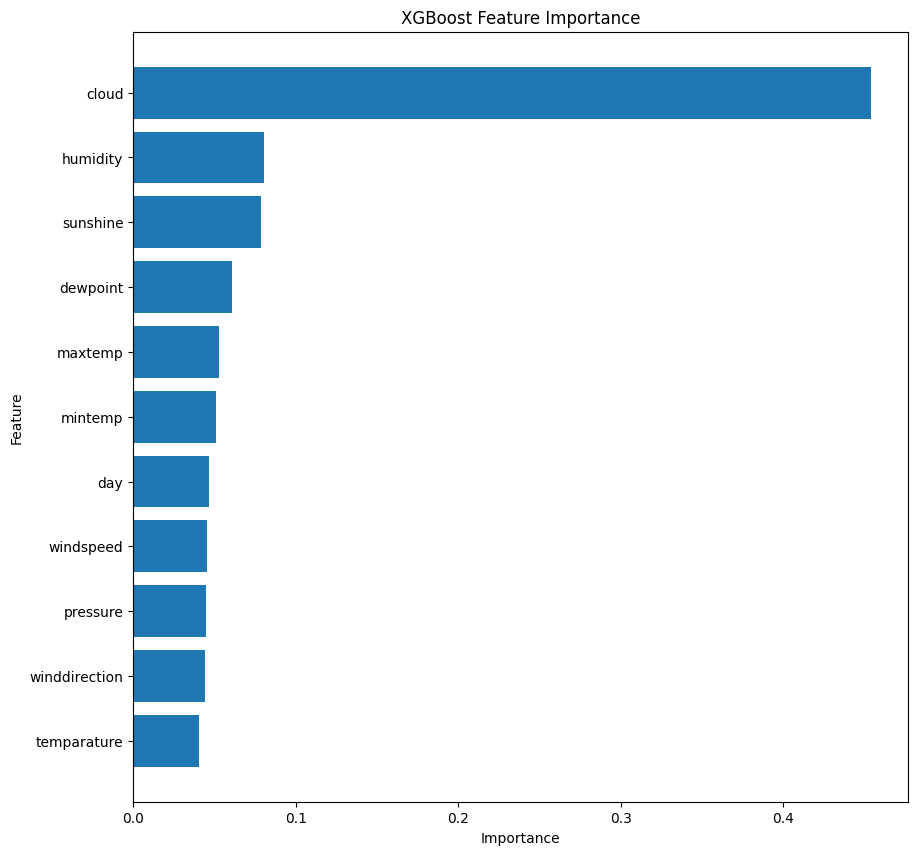

Our features are:
['day', 'pressure', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', '_4_1', '_4_2', '_4_3', '_5_1']
### Fold 1 #####################
[0]	validation_0-auc:0.83342
[100]	validation_0-auc:0.86873
[117]	validation_0-auc:0.86713
### Fold 2 #####################
[0]	validation_0-auc:0.81865
[100]	validation_0-auc:0.89080
[153]	validation_0-auc:0.88927
### Fold 3 #####################
[0]	validation_0-auc:0.87535
[100]	validation_0-auc:0.90095
[110]	validation_0-auc:0.90174
### Fold 4 #####################
[0]	validation_0-auc:0.80491
[100]	validation_0-auc:0.87794
[114]	validation_0-auc:0.87866
### Fold 5 #####################
[0]	validation_0-auc:0.83695
[100]	validation_0-auc:0.89820
[150]	validation_0-auc:0.89796
XGBoost CV Score AUC = 0.884


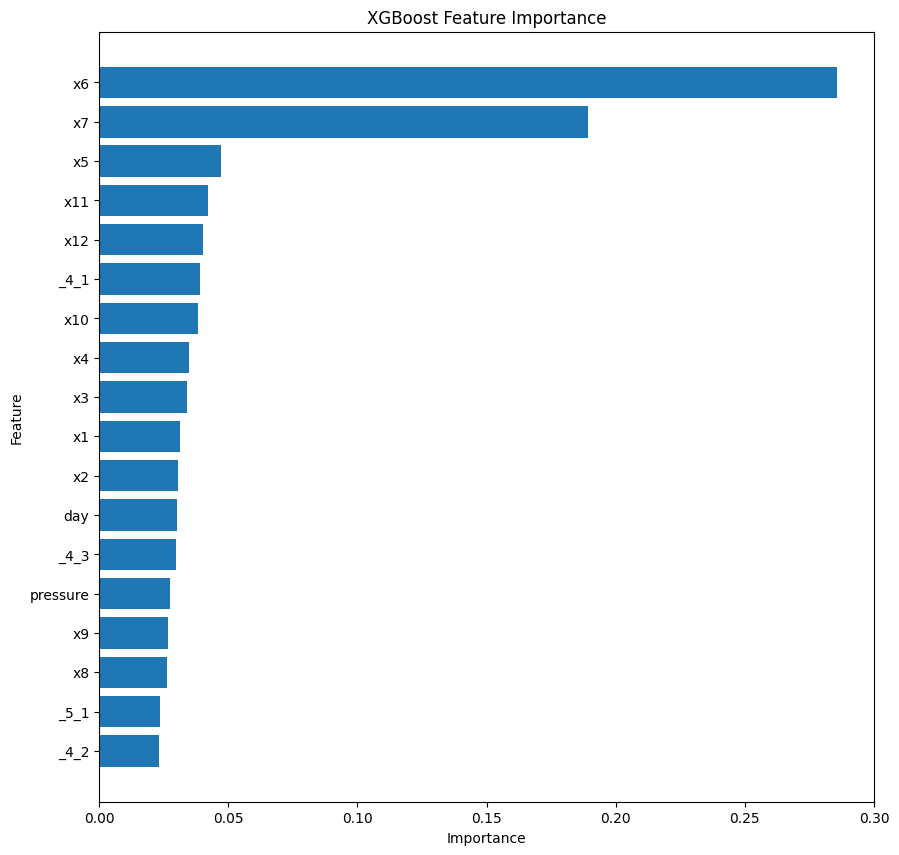

Our features are:
['day', 'pressure', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', '_4_2', '_4_3']
### Fold 1 #####################
[0]	validation_0-auc:0.83084
[100]	validation_0-auc:0.87118
[168]	validation_0-auc:0.87113
### Fold 2 #####################
[0]	validation_0-auc:0.82692
[100]	validation_0-auc:0.89353
[150]	validation_0-auc:0.89313
### Fold 3 #####################
[0]	validation_0-auc:0.86466
[100]	validation_0-auc:0.90643
[123]	validation_0-auc:0.90469
### Fold 4 #####################
[0]	validation_0-auc:0.82861
[100]	validation_0-auc:0.88306
[108]	validation_0-auc:0.88177
### Fold 5 #####################
[0]	validation_0-auc:0.86865
[100]	validation_0-auc:0.89559
[118]	validation_0-auc:0.89393
XGBoost CV Score AUC = 0.885


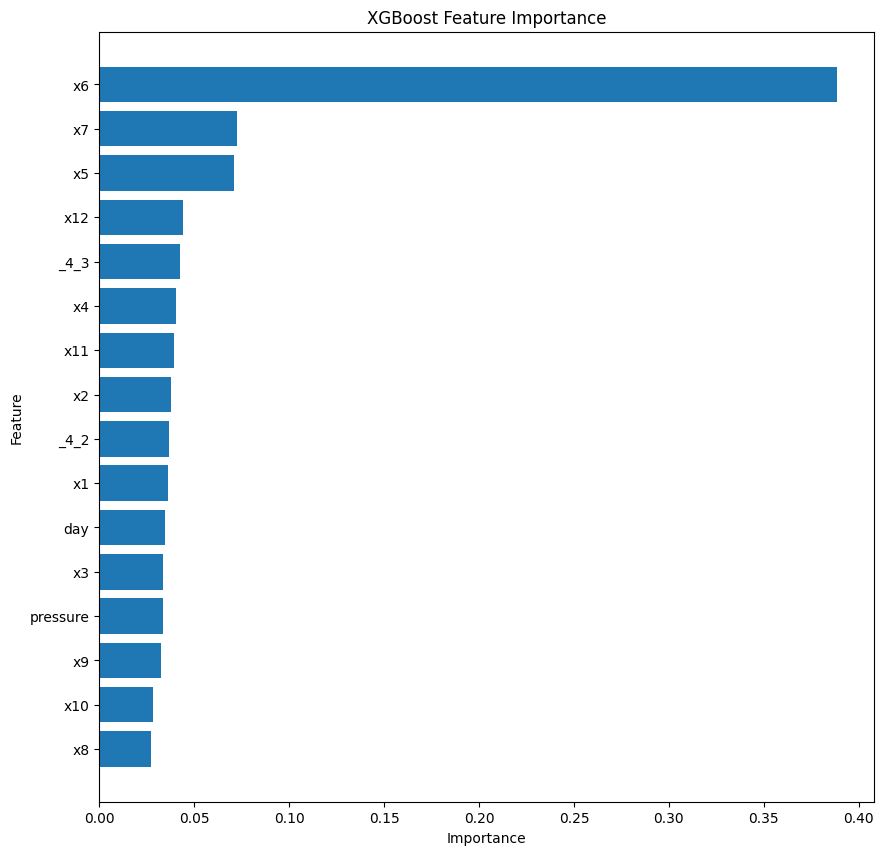

Our features are:
['day', 'pressure', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', '_2_1', '_2_2', '_2_3', '_2_4', '_2_5', '_2_6', '_2_7', '_2_8', '_2_9', '_2_10', '_2_11', '_2_12', '_2_13', '_2_14', '_2_15', '_3_1', '_3_2', '_3_3', '_3_4', '_3_5', '_3_6', '_4_1', '_4_2', '_4_3', '_5_1']
### Fold 1 #####################
[0]	validation_0-auc:0.83937
[100]	validation_0-auc:0.87229
[105]	validation_0-auc:0.87353
### Fold 2 #####################
[0]	validation_0-auc:0.85925
[100]	validation_0-auc:0.89108
[181]	validation_0-auc:0.89119
### Fold 3 #####################
[0]	validation_0-auc:0.88521
[100]	validation_0-auc:0.89545
[114]	validation_0-auc:0.89467
### Fold 4 #####################
[0]	validation_0-auc:0.82327
[100]	validation_0-auc:0.86846
[122]	validation_0-auc:0.86622
### Fold 5 #####################
[0]	validation_0-auc:0.86922
[100]	validation_0-auc:0.89361
[142]	validation_0-auc:0.89385
XGBoost CV Score AUC = 0.878


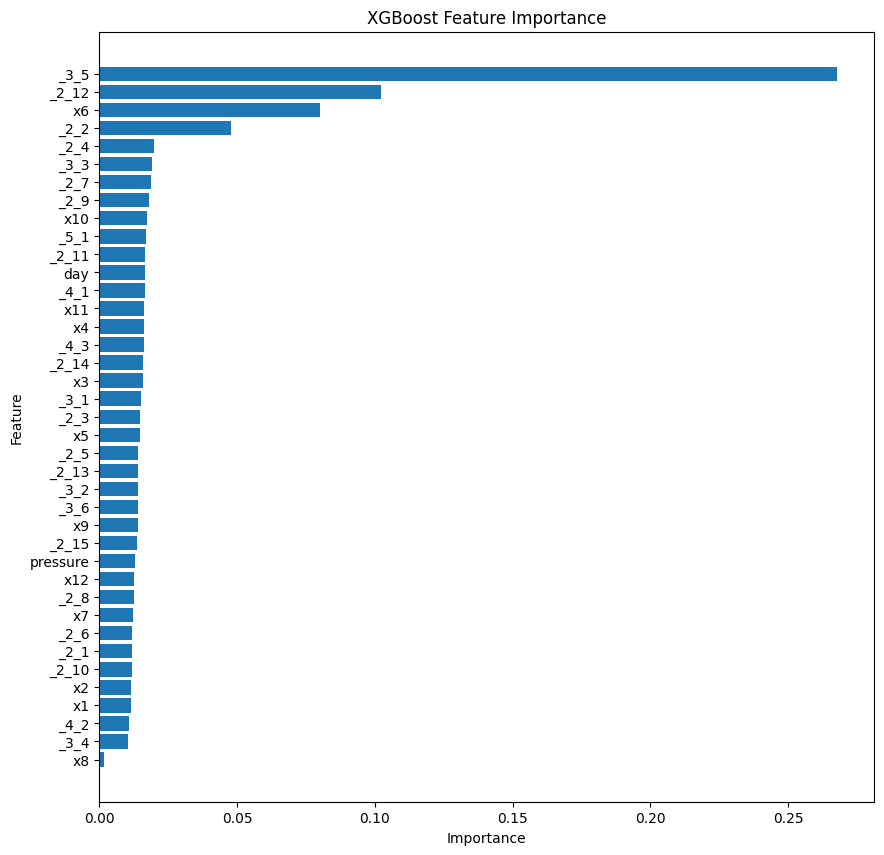

Our features are:
['day', 'pressure', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', '_2_1', '_2_11', '_2_12', '_3_5', '_4_2', '_5_1']
### Fold 1 #####################
[0]	validation_0-auc:0.83725
[100]	validation_0-auc:0.87155
[112]	validation_0-auc:0.87126
### Fold 2 #####################
[0]	validation_0-auc:0.85664
[100]	validation_0-auc:0.89624
[197]	validation_0-auc:0.89061
### Fold 3 #####################
[0]	validation_0-auc:0.88573
[100]	validation_0-auc:0.89935
[148]	validation_0-auc:0.89565
### Fold 4 #####################
[0]	validation_0-auc:0.82443
[100]	validation_0-auc:0.88007
[126]	validation_0-auc:0.87350
### Fold 5 #####################
[0]	validation_0-auc:0.87367
[100]	validation_0-auc:0.89178
[137]	validation_0-auc:0.89095
XGBoost CV Score AUC = 0.888


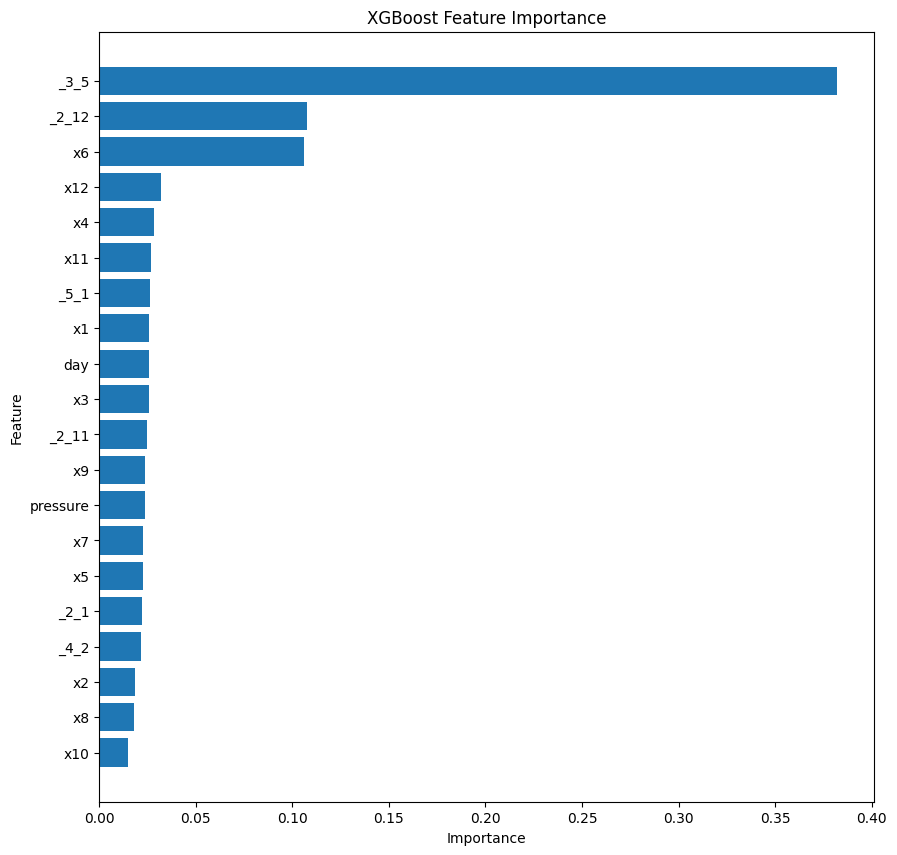

In [7]:
pred_original = exec_fit_and_proba()

pred_hypersp1 = exec_fit_and_proba(fen1)
pred_hypersp2 = exec_fit_and_proba(fen2)
pred_hypersp3 = exec_fit_and_proba(fen3)
pred_hypersp4 = exec_fit_and_proba(fen4)

# Submission CSV Ensemble!
We load the best public notebook from version 17 of public notebook which achieves `LB 0.915` (from [here][1]). Then we ensemble our new XGBoost model preditions with weights `-0.7 * XGB + 1.7 * Public`. We use `scipy.stats.rankdata` to normalize predictions before ensemble. We achieve `LB 0.926` hooray!

[1]: https://www.kaggle.com/code/act18l/auc-post-processing?scriptVersionId=227652340

In [8]:
best_public1 = pd.read_csv("/kaggle/input/ps-s5e3-16-03-2025-subm-s/subm - LB 0.915 - AUC Post-processing.csv")
best_public_1 = best_public1.rainfall.values

best_public2 = pd.read_csv("/kaggle/input/ps-s5e3-16-03-2025-subm-s/subm - LB 0.935 - XGBoost Starter Ensemble.csv")
best_public_2 = best_public2.rainfall.values

best_public3 = pd.read_csv("/kaggle/input/ps-s5e3-16-03-2025-subm-s/subm - LB 0.936 - LDA Lgs ensemble for rainfall pred.csv")
best_public_3 = best_public3.rainfall.values

best_public4 = pd.read_csv("/kaggle/input/ps-s5e3-16-03-2025-subm-s/subm - LB 0.954 - LB probing.csv")
best_public_4 = best_public4.rainfall.values

best_public5 = pd.read_csv("/kaggle/input/ps-s5e3-16-03-2025-subm-s/subm - LB 0.956 - RAPIDS KNN Starter Ensemble.csv")
best_public_5 = best_public5.rainfall.values


best_public1 = best_public1.rename(columns={'rainfall':'rf_1'})
best_public2 = best_public2.rename(columns={'rainfall':'rf_2'})
best_public3 = best_public3.rename(columns={'rainfall':'rf_3'})
best_public4 = best_public4.rename(columns={'rainfall':'rf_4'})
best_public5 = best_public5.rename(columns={'rainfall':'rf_5'})

best_publics = pd.merge(best_public1, best_public2, on='id')
best_publics = pd.merge(best_publics, best_public3, on='id')
best_publics = pd.merge(best_publics, best_public4, on='id')
best_publics = pd.merge(best_publics, best_public5, on='id')

display(best_publics)

,id,rf_1,rf_2,rf_3,rf_4,rf_5
0,2190,0.978408,0.877397,0.883251,2.000000,0.960959
1,2191,0.983057,0.928767,0.932104,2.000000,0.946575
2,2192,0.812125,0.281507,0.316155,2.000000,0.994521
3,2193,0.160289,0.084932,0.086750,0.084932,0.089041
4,2194,0.091565,0.019863,0.020664,0.019863,0.021918
...,...,...,...,...,...,...
725,2915,0.955181,0.781507,0.792149,0.781507,0.760274
726,2916,0.846083,0.449315,0.474508,0.449315,0.450685
727,2917,0.979023,0.993151,0.993172,0.993151,0.923288
728,2918,0.981950,0.963014,0.964702,0.963014,0.897260


In [9]:
# from scipy.stats import rankdata

# print("Ensemble achieves LB = 0.95??? ! Hooray!")
# sub = pd.read_csv("/kaggle/input/playground-series-s5e3/sample_submission.csv")

# sub.rainfall =\
#     -0.21 * rankdata( pred_original ) +\
#     -0.21 * rankdata( pred_hypersp1 ) +\
#     -0.21 * rankdata( pred_hypersp2 ) +\
#     -0.21 * rankdata( pred_hypersp3 ) +\
#     -0.21 * rankdata( pred_hypersp4 ) +\             # LB = 0.94958
#      1.01 * rankdata( best_public_1 ) +\
#      1.23 * rankdata( best_public_2 ) +\
#      1.23 * rankdata( best_public_3 ) +\
#      1.25 * rankdata( best_public_4 ) +\
#      1.28 * rankdata( best_public_5 )

# sub.rainfall = rankdata( sub.rainfall ) / len(sub)
# print( sub.shape )
# sub.to_csv("submission.csv",index=False)
# sub

In [10]:
# from scipy.stats import rankdata

# print("Ensemble achieves LB = 0.9???? ! Hooray!")
# sub = pd.read_csv("/kaggle/input/playground-series-s5e3/sample_submission.csv")

# sub.rainfall =\
#     -0.14 * rankdata( pred_original ) +\
#     -0.15 * rankdata( pred_hypersp2 ) +\
#     -0.16 * rankdata( pred_hypersp2 ) +\
#     -0.17 * rankdata( pred_hypersp3 ) +\
#     -0.18 * rankdata( pred_hypersp4 ) +\             # LB = 0.94690
#      1.07 * rankdata( best_public_1 ) +\
#      1.19 * rankdata( best_public_2 ) +\
#      1.20 * rankdata( best_public_3 ) +\
#      1.34 * rankdata( best_public_5 )

# sub.rainfall = rankdata( sub.rainfall ) / len(sub)
# print( sub.shape )
# sub.to_csv("submission.csv",index=False)
# sub

In [11]:
# from scipy.stats import rankdata

# print("Ensemble achieves LB = 0.9???? ! Hooray!")
# sub = pd.read_csv("/kaggle/input/playground-series-s5e3/sample_submission.csv")

# sub.rainfall =\
#     -0.10 * rankdata( pred_original ) +\
#     -0.11 * rankdata( pred_hypersp1 ) +\
#     -0.11 * rankdata( pred_hypersp2 ) +\
#     -0.11 * rankdata( pred_hypersp3 ) +\            LB = 0.94877
#     -0.11 * rankdata( pred_hypersp4 ) +\
#      1.16 * rankdata( best_public_2 ) +\
#      1.17 * rankdata( best_public_3 ) +\
#      1.21 * rankdata( best_public_5 )

# sub.rainfall = rankdata( sub.rainfall ) / len(sub)
# print( sub.shape )
# sub.to_csv("submission.csv",index=False)
# sub

# [RAPIDS KNN Starter Ensemble - [LB 0.956] - Wow!](https://www.kaggle.com/code/cdeotte/rapids-knn-starter-ensemble-lb-0-956-wow)

In [12]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from cuml.neighbors import KNeighborsClassifier

In this notebook, we train a RAPIDS KNN model and ensemble it with the best public notebook. The best public notebook achieves `LB = 0.954` and our ensemble achieves `LB = 0.956` Wow!

# KNN Model
We train 5 fold RAPIDS KNN classification model using 101 neighbors! We standardize all features to mean=0, std=1 because KNN likes this.

In [13]:
def exec_KNN__fit_and_proba(fen=None):

    train = pd.read_csv("/kaggle/input/playground-series-s5e3/train.csv")
    # print("Train shape", train.shape )
    # train.head(1)
    test = pd.read_csv("/kaggle/input/playground-series-s5e3/test.csv")
    # print("Test shape:", test.shape )
    # test.head(1)

    if fen != None:
        train = fen(train)
        test  = fen(test)

    RMV = ['rainfall','id']
    FEATURES = [c for c in train.columns if not c in RMV]
    print("Our features are:")
    print( FEATURES )
    
    FOLDS = 5
    kf = KFold(n_splits=FOLDS, shuffle=True, random_state=777)
        
    oof_knn = np.zeros(len(train))
    pred_knn = np.zeros(len(test))

    for i, (train_index, test_index) in enumerate(kf.split(train)):
    
        print(f"### Fold {i+1} #####################")
        
        x_train = train.loc[train_index,FEATURES].copy()
        y_train = train.loc[train_index,"rainfall"]    
        x_valid = train.loc[test_index,FEATURES].copy()
        y_valid = train.loc[test_index,"rainfall"]
        x_test = test[FEATURES].copy()
    
        for c in FEATURES:
            m = x_train[c].mean()
            s = x_train[c].std()
            x_train[c] = (x_train[c]-m)/s
            x_valid[c] = (x_valid[c]-m)/s
            x_test[c] = (x_test[c]-m)/s
            x_test[c] = x_test[c].fillna(0)
            x_train[c] = x_train[c].fillna(0)

        model = KNeighborsClassifier(n_neighbors=101, p=1)
        model.fit(x_train.values, y_train.values)
    
        # INFER OOF
        oof_knn[test_index] = model.predict_proba(x_valid.values)[:,1]
        # INFER TEST
        pred_knn += model.predict_proba(x_test.values)[:,1]
    
    # COMPUTE AVERAGE TEST PREDS
    pred_knn /= FOLDS

    true = train.rainfall.values
    m = roc_auc_score(true, oof_knn)
    print(f"KNN CV Score AUC = {m:.3f}\n\n")

    return pred_knn

In [14]:
pred_original = exec_KNN__fit_and_proba()

pred_hypersp3 = exec_KNN__fit_and_proba(fen3)
pred_hypersp4 = exec_KNN__fit_and_proba(fen4)

best_public4 = pd.read_csv("/kaggle/input/ps-s5e3-16-03-2025-subm-s/subm - LB 0.954 - LB probing.csv")
best_public_4 = best_public4.rainfall.values
best_public5 = pd.read_csv("/kaggle/input/ps-s5e3-16-03-2025-subm-s/subm - LB 0.956 - RAPIDS KNN Starter Ensemble.csv")
best_public_5 = best_public5.rainfall.values

Our features are:
['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']
### Fold 1 #####################
### Fold 2 #####################
### Fold 3 #####################
### Fold 4 #####################
### Fold 5 #####################
KNN CV Score AUC = 0.883


Our features are:
['day', 'pressure', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', '_2_1', '_2_2', '_2_3', '_2_4', '_2_5', '_2_6', '_2_7', '_2_8', '_2_9', '_2_10', '_2_11', '_2_12', '_2_13', '_2_14', '_2_15', '_3_1', '_3_2', '_3_3', '_3_4', '_3_5', '_3_6', '_4_1', '_4_2', '_4_3', '_5_1']
### Fold 1 #####################
### Fold 2 #####################
### Fold 3 #####################
### Fold 4 #####################
### Fold 5 #####################
KNN CV Score AUC = 0.884


Our features are:
['day', 'pressure', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', '_2_1', '_2_11', '_2_12', '_3_5', 

# Submission CSV Ensemble!
We load the best public notebook from version 1 of public notebook which achieves `LB 0.954` (from [here][1]). Then we ensemble our new KNN model preditions with weights `-0.65 * KNN + 1.65 * Public`. We use `scipy.stats.rankdata` to normalize predictions before ensemble. We achieve `LB 0.956` hooray!

[1]: https://www.kaggle.com/code/act18l/lb-probing

In [15]:
# from scipy.stats import rankdata

# print("Ensemble achieves LB = ?! Hooray!")
# sub = pd.read_csv("/kaggle/input/playground-series-s5e3/sample_submission.csv")

# sub.rainfall =\
#     -0.07 * rankdata( pred_original ) +\
#     -0.07 * rankdata( pred_hypersp3 ) +\
#     -0.07 * rankdata( pred_hypersp4 ) +\               LB = 0.95548
#      1.10 * rankdata( best_public_4 ) +\
#      1.11 * rankdata( best_public_5 )

# sub.rainfall = rankdata( sub.rainfall ) / len(sub)

# print( sub.shape )
# sub.to_csv("submission.csv",index=False)
# sub.head()

In [16]:
from scipy.stats import rankdata

sub = pd.read_csv("/kaggle/input/playground-series-s5e3/sample_submission.csv")

#original:
#sub.rainfall= -0.065  * rankdata( pred_knn )       + 1.065  * rankdata( best_public )

sub.rainfall = -0.0674 * rankdata( pred_hypersp3 ) + 1.0674 * rankdata( best_public_5 )
     
sub.rainfall = rankdata( sub.rainfall ) / len(sub)

print( sub.shape )
sub.to_csv("submission.csv",index=False)
sub.head()

(730, 2)


,id,rainfall
0,2190,0.962329
1,2191,0.941096
2,2192,0.990411
3,2193,0.095890
4,2194,0.021918


# **Part 2** &nbsp;-&nbsp; [RAPIDS KNN Starter Ensemble - [LB 0.961] - Wow!](https://www.kaggle.com/code/cdeotte/rapids-knn-starter-ensemble-lb-0-961-wow)

In [17]:
# Lb = 0.95575

# RAPIDS KNN Starter Notebook - LB Ensemble 0.961! Wow!
# In this notebook, we train a RAPIDS KNN model and ensemble it with the best public notebook. 
# The best public notebook achieves LB = 0.954 and our ensemble achieves LB = 0.961 Wow!
# 
# DISCLAIMER: Note that the ensemble weights in this notebook are overfitted to public LB and 
# will not generalize to private LB. The purpopse of this notebook is to demonstrate that KNN 
# offers model diversity and helps improve ensembles.
# To find the correct ensemble weights we use the KNN OOF predictions together will all OOF 
# predictions from all models in our ensemble. We find weights to optimize OOF ensemble AUC 
# locally and then use these weights for test predictions during submission 
# (and we ignore public LB score)! Discussion here
# 
# UPDATE: In version 2 we increase n_neighbors from 101 to 201. 
# And we give the feature day more importance during the KNN distance computation. 
# This improves ensemble LB score LB 0.956 => LB 0.961 woohoo!

import pandas as pd, numpy as np, polars as pl
import matplotlib.pyplot as plt

train = pd.read_csv("/kaggle/input/playground-series-s5e3/train.csv")
print("Train shape", train.shape )
display(train.head())
test = pd.read_csv("/kaggle/input/playground-series-s5e3/test.csv")
print("Test shape:", test.shape )
display(test.head())

train = fen3(train)
test  = fen3(test)

display(train.head(),test.head())

RMV = ['rainfall','id']
_FEATURES_ = [c for c in train.columns if not c in RMV]
print("Our features are:")
print( _FEATURES_ )

# KNN Model: We train 5 fold RAPIDS KNN classification model using 201 neighbors! 
#            We standardize all features to mean=0, std=1 because KNN likes this.

# UPDATE:    We adjust the weights of the features to increase/decrease importance of 
#            certain features during KNN distance computation.

from sklearn.model_selection import KFold
from cuml.neighbors import KNeighborsClassifier

# WEIGHTS TO ADJUST IMPORTANCE OF FEATURES DURING KNN
WGT = {
    'day': 24, 
    'pressure': 1,
    'x1':1,'x2':1,'x3':1,'x4':1,'x5':1,'x6':1,'x7':1,'x8':1,'x9':1,'x10':1,'x11':1,'x12':1,
    '_2_1':  2,
    '_2_2':  2,
    '_2_3':  2,
    '_2_4':  2,
    '_2_5':  2,
    '_2_6':  2,
    '_2_7':  2,
    '_2_8':  2,
    '_2_9':  2,
    '_2_10': 2,
    '_2_11': 2,
    '_2_12': 5,
    '_2_13': 2,                                 # Lb=0.95575
    '_2_14': 2,
    '_2_15': 2,
    '_3_1':  3,
    '_3_2':  3,
    '_3_3':  3,
    '_3_4':  3,
    '_3_5':  5,
    '_3_6':  3,
    '_4_1':  4,
    '_4_2':  4,
    '_4_3':  4,
    '_5_1':  5,
}

FOLDS = 5

kf = KFold(
            n_splits     = FOLDS, 
            shuffle      = True, 
            random_state = 3777 )
    
oof_knn  = np.zeros(len(train))
pred_knn = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):
    print(" "+"#"*25,'\n',f"### Fold {i+1}",'\n',"#"*25)
    X_train = train.loc[train_index, _FEATURES_].copy()
    y_train = train.loc[train_index, "rainfall"]
    X_valid = train.loc[test_index,  _FEATURES_].copy()
    y_valid = train.loc[test_index,  "rainfall"]
    X_test = test[_FEATURES_].copy()
    
    for c in _FEATURES_:
        m = X_train[c].mean()
        s = X_train[c].std()
        X_train[c] = WGT[c] * (X_train[c]-m)/s
        X_valid[c] = WGT[c] * (X_valid[c]-m)/s
        X_test[c]  = WGT[c] * (X_test[c] -m)/s
        X_test[c]  = X_test [c].fillna(0)
        X_train[c] = X_train[c].fillna(0)
        
    model = KNeighborsClassifier(n_neighbors=201, p=1)
    model.fit(X_train.values, y_train.values)
    # INFER OOF
    oof_knn[test_index] = model.predict_proba(X_valid.values)[:,1]
    # INFER TEST
    pred_knn += model.predict_proba(X_test.values)[:,1]
# COMPUTE AVERAGE TEST PREDS
pred_knn /= FOLDS


from sklearn.metrics import roc_auc_score
true = train.rainfall.values
m = roc_auc_score(true, oof_knn)
print(f"KNN CV Score AUC = {m:.3f}")


# Submission CSV Ensemble!
# We load best public notebook which achieves `LB 0.96111`
# Then we ensemble our new KNN model preditions 
# with weights `-0.25 * KNN + 1.25 * Public`. 
# We use `scipy.stats.rankdata` to normalize 


print("Best Public Notebook","achieves LB = 0.96111")
best_public = pd.read_csv("/kaggle/input/ps-s5e3-16-03-2025-subm-s/subm - LB 0.961 - RAPIDS KNN Starter Ensemble.csv")
display( best_public.head() )
best_public = best_public.rainfall.values

from scipy.stats import rankdata

print("Ensemble achieves LB = ?! Hooray!")
sub = pd.read_csv("/kaggle/input/playground-series-s5e3/sample_submission.csv")
sub.rainfall = -0.25 * rankdata( pred_knn ) + 1.25 * rankdata( best_public )
sub.rainfall = rankdata( sub.rainfall ) / len(sub)
print( sub.shape )
sub.to_csv("submission.csv",index=False)
sub.head()

Train shape (2190, 13)


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


Test shape: (730, 12)


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4


,id,day,pressure,x1,x2,x3,x4,x5,x6,x7,...,_3_1,_3_2,_3_3,_3_4,_3_5,_3_6,_4_1,_4_2,_4_3,_5_1
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,...,95.130489,44.313203,27.352087,77.952101,122.206588,63.199074,104.279432,26.731563,115.436651,106.299106
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,...,108.421815,37.353179,23.369638,83.886650,131.616146,57.964299,114.660586,22.935780,113.823811,113.105217
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,...,67.977790,55.142271,11.191339,29.346380,78.653722,64.569205,88.149589,10.396769,87.035300,80.993889
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,...,109.823222,49.579633,24.990798,70.961962,134.393303,71.041678,118.428459,29.890801,117.417716,122.882301
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,...,46.410020,29.529815,18.825223,24.249536,64.862792,45.900320,52.045845,13.954904,51.026131,50.387002


,id,day,pressure,x1,x2,x3,x4,x5,x6,x7,...,_3_1,_3_2,_3_3,_3_4,_3_5,_3_6,_4_1,_4_2,_4_3,_5_1
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,...,117.840952,40.130412,20.369831,88.983706,137.978839,58.912987,120.323688,21.053028,118.157268,119.263532
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,...,115.793998,42.529402,22.866788,80.589702,138.607215,63.390378,120.806250,28.186699,114.512619,122.361881
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,...,114.979172,32.524606,18.915866,91.934868,129.757466,49.566319,118.228465,19.552749,107.578901,110.254116
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,...,65.882775,37.982891,13.312788,55.336426,78.997250,48.096738,62.470073,31.690624,35.369533,71.596508
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,...,69.940260,15.970285,8.199406,56.605388,73.396960,19.870053,64.706878,10.565656,56.556750,60.118051


Our features are:
['day', 'pressure', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', '_2_1', '_2_2', '_2_3', '_2_4', '_2_5', '_2_6', '_2_7', '_2_8', '_2_9', '_2_10', '_2_11', '_2_12', '_2_13', '_2_14', '_2_15', '_3_1', '_3_2', '_3_3', '_3_4', '_3_5', '_3_6', '_4_1', '_4_2', '_4_3', '_5_1']
 ######################### 
 ### Fold 1 
 #########################
 ######################### 
 ### Fold 2 
 #########################
 ######################### 
 ### Fold 3 
 #########################
 ######################### 
 ### Fold 4 
 #########################
 ######################### 
 ### Fold 5 
 #########################
KNN CV Score AUC = 0.877
Best Public Notebook achieves LB = 0.96111


,id,rainfall
0,2190,0.997260
1,2191,0.995890
2,2192,0.998630
3,2193,0.121918
4,2194,0.057534


Ensemble achieves LB = ?! Hooray!
(730, 2)


,id,rainfall
0,2190,0.979452
1,2191,0.969863
2,2192,0.990411
3,2193,0.143836
4,2194,0.072603


In [18]:
# Lb = 0.95615

# RAPIDS KNN Starter Notebook - LB Ensemble 0.961! Wow!
# In this notebook, we train a RAPIDS KNN model and ensemble it with the best public notebook. 
# The best public notebook achieves LB = 0.954 and our ensemble achieves LB = 0.961 Wow!
# 
# DISCLAIMER: Note that the ensemble weights in this notebook are overfitted to public LB and 
# will not generalize to private LB. The purpopse of this notebook is to demonstrate that KNN 
# offers model diversity and helps improve ensembles.
# To find the correct ensemble weights we use the KNN OOF predictions together will all OOF 
# predictions from all models in our ensemble. We find weights to optimize OOF ensemble AUC 
# locally and then use these weights for test predictions during submission 
# (and we ignore public LB score)! Discussion here
# 
# UPDATE: In version 2 we increase n_neighbors from 101 to 201. 
# And we give the feature day more importance during the KNN distance computation. 
# This improves ensemble LB score LB 0.956 => LB 0.961 woohoo!

import pandas as pd, numpy as np, polars as pl
import matplotlib.pyplot as plt

train = pd.read_csv("/kaggle/input/playground-series-s5e3/train.csv")
print("Train shape", train.shape )
display(train.head())
test = pd.read_csv("/kaggle/input/playground-series-s5e3/test.csv")
print("Test shape:", test.shape )
display(test.head())

train = fen3(train)
test  = fen3(test)

display(train.head(),test.head())

RMV = ['rainfall','id']
_FEATURES_ = [c for c in train.columns if not c in RMV]
print("Our features are:")
print( _FEATURES_ )

# KNN Model: We train 5 fold RAPIDS KNN classification model using 201 neighbors! 
#            We standardize all features to mean=0, std=1 because KNN likes this.

# UPDATE:    We adjust the weights of the features to increase/decrease importance of 
#            certain features during KNN distance computation.

from sklearn.model_selection import KFold
from cuml.neighbors import KNeighborsClassifier

# WEIGHTS TO ADJUST IMPORTANCE OF FEATURES DURING KNN
WGT = {
    'day': 24, 
    'pressure': 1,
    'x1':1,'x2':1,'x3':1,'x4':1,'x5':1,'x6':1,'x7':1,'x8':1,'x9':1,'x10':1,'x11':1,'x12':1,
    '_2_1':  1,
    '_2_2':  1,
    '_2_3':  1,
    '_2_4':  1,
    '_2_5':  1,
    '_2_6':  1,
    '_2_7':  1,
    '_2_8':  1,
    '_2_9':  1,
    '_2_10': 1,
    '_2_11': 1,
    '_2_12': 2,
    '_2_13': 1,                                 # Lb=0.95615
    '_2_14': 1,
    '_2_15': 1,
    '_3_1':  1,
    '_3_2':  1,
    '_3_3':  1,
    '_3_4':  1,
    '_3_5':  2,
    '_3_6':  1,
    '_4_1':  1,
    '_4_2':  1,
    '_4_3':  1,
    '_5_1':  1,
}

FOLDS = 5

kf = KFold(
            n_splits     = FOLDS, 
            shuffle      = True, 
            random_state = 3777 )
    
oof_knn  = np.zeros(len(train))
pred_knn = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):
    print(" "+"#"*25,'\n',f"### Fold {i+1}",'\n',"#"*25)
    X_train = train.loc[train_index, _FEATURES_].copy()
    y_train = train.loc[train_index, "rainfall"]
    X_valid = train.loc[test_index,  _FEATURES_].copy()
    y_valid = train.loc[test_index,  "rainfall"]
    X_test = test[_FEATURES_].copy()
    
    for c in _FEATURES_:
        m = X_train[c].mean()
        s = X_train[c].std()
        X_train[c] = WGT[c] * (X_train[c]-m)/s
        X_valid[c] = WGT[c] * (X_valid[c]-m)/s
        X_test[c]  = WGT[c] * (X_test[c] -m)/s
        X_test[c]  = X_test [c].fillna(0)
        X_train[c] = X_train[c].fillna(0)
        
    model = KNeighborsClassifier(n_neighbors=201, p=1)
    model.fit(X_train.values, y_train.values)
    # INFER OOF
    oof_knn[test_index] = model.predict_proba(X_valid.values)[:,1]
    # INFER TEST
    pred_knn += model.predict_proba(X_test.values)[:,1]
# COMPUTE AVERAGE TEST PREDS
pred_knn /= FOLDS


from sklearn.metrics import roc_auc_score
true = train.rainfall.values
m = roc_auc_score(true, oof_knn)
print(f"KNN CV Score AUC = {m:.3f}")


# Submission CSV Ensemble!
# We load best public notebook which achieves `LB 0.96111`
# Then we ensemble our new KNN model preditions 
# with weights `-0.25 * KNN + 1.25 * Public`. 
# We use `scipy.stats.rankdata` to normalize 


print("Best Public Notebook","achieves LB = 0.96111")
best_public = pd.read_csv("/kaggle/input/ps-s5e3-16-03-2025-subm-s/subm - LB 0.961 - RAPIDS KNN Starter Ensemble.csv")
display( best_public.head() )
best_public = best_public.rainfall.values

from scipy.stats import rankdata

print("Ensemble achieves LB = ?! Hooray!")
sub = pd.read_csv("/kaggle/input/playground-series-s5e3/sample_submission.csv")
sub.rainfall = -0.25 * rankdata( pred_knn ) + 1.25 * rankdata( best_public )
sub.rainfall = rankdata( sub.rainfall ) / len(sub)
print( sub.shape )
sub.to_csv("submission.csv",index=False)
sub.head()

Train shape (2190, 13)


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


Test shape: (730, 12)


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4


,id,day,pressure,x1,x2,x3,x4,x5,x6,x7,...,_3_1,_3_2,_3_3,_3_4,_3_5,_3_6,_4_1,_4_2,_4_3,_5_1
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,...,95.130489,44.313203,27.352087,77.952101,122.206588,63.199074,104.279432,26.731563,115.436651,106.299106
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,...,108.421815,37.353179,23.369638,83.886650,131.616146,57.964299,114.660586,22.935780,113.823811,113.105217
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,...,67.977790,55.142271,11.191339,29.346380,78.653722,64.569205,88.149589,10.396769,87.035300,80.993889
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,...,109.823222,49.579633,24.990798,70.961962,134.393303,71.041678,118.428459,29.890801,117.417716,122.882301
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,...,46.410020,29.529815,18.825223,24.249536,64.862792,45.900320,52.045845,13.954904,51.026131,50.387002


,id,day,pressure,x1,x2,x3,x4,x5,x6,x7,...,_3_1,_3_2,_3_3,_3_4,_3_5,_3_6,_4_1,_4_2,_4_3,_5_1
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,...,117.840952,40.130412,20.369831,88.983706,137.978839,58.912987,120.323688,21.053028,118.157268,119.263532
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,...,115.793998,42.529402,22.866788,80.589702,138.607215,63.390378,120.806250,28.186699,114.512619,122.361881
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,...,114.979172,32.524606,18.915866,91.934868,129.757466,49.566319,118.228465,19.552749,107.578901,110.254116
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,...,65.882775,37.982891,13.312788,55.336426,78.997250,48.096738,62.470073,31.690624,35.369533,71.596508
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,...,69.940260,15.970285,8.199406,56.605388,73.396960,19.870053,64.706878,10.565656,56.556750,60.118051


Our features are:
['day', 'pressure', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', '_2_1', '_2_2', '_2_3', '_2_4', '_2_5', '_2_6', '_2_7', '_2_8', '_2_9', '_2_10', '_2_11', '_2_12', '_2_13', '_2_14', '_2_15', '_3_1', '_3_2', '_3_3', '_3_4', '_3_5', '_3_6', '_4_1', '_4_2', '_4_3', '_5_1']
 ######################### 
 ### Fold 1 
 #########################
 ######################### 
 ### Fold 2 
 #########################
 ######################### 
 ### Fold 3 
 #########################
 ######################### 
 ### Fold 4 
 #########################
 ######################### 
 ### Fold 5 
 #########################
KNN CV Score AUC = 0.866
Best Public Notebook achieves LB = 0.96111


,id,rainfall
0,2190,0.997260
1,2191,0.995890
2,2192,0.998630
3,2193,0.121918
4,2194,0.057534


Ensemble achieves LB = ?! Hooray!
(730, 2)


,id,rainfall
0,2190,0.994521
1,2191,0.991781
2,2192,0.998630
3,2193,0.139726
4,2194,0.064384


In [19]:
# Lb = 0.95427

# RAPIDS KNN Starter Notebook - LB Ensemble 0.961! Wow!
# In this notebook, we train a RAPIDS KNN model and ensemble it with the best public notebook. 
# The best public notebook achieves LB = 0.954 and our ensemble achieves LB = 0.961 Wow!
# 
# DISCLAIMER: Note that the ensemble weights in this notebook are overfitted to public LB and 
# will not generalize to private LB. The purpopse of this notebook is to demonstrate that KNN 
# offers model diversity and helps improve ensembles.
# To find the correct ensemble weights we use the KNN OOF predictions together will all OOF 
# predictions from all models in our ensemble. We find weights to optimize OOF ensemble AUC 
# locally and then use these weights for test predictions during submission 
# (and we ignore public LB score)! Discussion here
# 
# UPDATE: In version 2 we increase n_neighbors from 101 to 201. 
# And we give the feature day more importance during the KNN distance computation. 
# This improves ensemble LB score LB 0.956 => LB 0.961 woohoo!

import pandas as pd, numpy as np, polars as pl
import matplotlib.pyplot as plt

train = pd.read_csv("/kaggle/input/playground-series-s5e3/train.csv")
print("Train shape", train.shape )
display(train.head())
test = pd.read_csv("/kaggle/input/playground-series-s5e3/test.csv")
print("Test shape:", test.shape )
display(test.head())

train = fen3(train)
test  = fen3(test)

display(train.head(),test.head())

RMV = ['rainfall','id']
_FEATURES_ = [c for c in train.columns if not c in RMV]
print("Our features are:")
print( _FEATURES_ )

# KNN Model: We train 5 fold RAPIDS KNN classification model using 201 neighbors! 
#            We standardize all features to mean=0, std=1 because KNN likes this.

# UPDATE:    We adjust the weights of the features to increase/decrease importance of 
#            certain features during KNN distance computation.

from sklearn.model_selection import KFold
from cuml.neighbors import KNeighborsClassifier

# WEIGHTS TO ADJUST IMPORTANCE OF FEATURES DURING KNN
WGT = {
    'day': 24, 
    'pressure': 1,
    'x1':1,'x2':1,'x3':1,'x4':1,'x5':1,'x6':1,'x7':1,'x8':1,'x9':1,'x10':1,'x11':1,'x12':1,
    '_2_1':  1,
    '_2_2':  1,
    '_2_3':  1,
    '_2_4':  1,
    '_2_5':  1,
    '_2_6':  1,
    '_2_7':  1,
    '_2_8':  1,
    '_2_9':  1,
    '_2_10': 1,
    '_2_11': 1,
    '_2_12': 1,
    '_2_13': 1,                                 # Lb=0.95427
    '_2_14': 1,
    '_2_15': 1,
    '_3_1':  1,
    '_3_2':  1,
    '_3_3':  1,
    '_3_4':  1,
    '_3_5':  1,
    '_3_6':  1,
    '_4_1':  1,
    '_4_2':  1,
    '_4_3':  1,
    '_5_1':  1,
}

FOLDS = 5

kf = KFold(
            n_splits     = FOLDS, 
            shuffle      = True, 
            random_state = 3777 )
    
oof_knn  = np.zeros(len(train))
pred_knn = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):
    print(" "+"#"*25,'\n',f"### Fold {i+1}",'\n',"#"*25)
    X_train = train.loc[train_index, _FEATURES_].copy()
    y_train = train.loc[train_index, "rainfall"]
    X_valid = train.loc[test_index,  _FEATURES_].copy()
    y_valid = train.loc[test_index,  "rainfall"]
    X_test = test[_FEATURES_].copy()
    
    for c in _FEATURES_:
        m = X_train[c].mean()
        s = X_train[c].std()
        X_train[c] = WGT[c] * (X_train[c]-m)/s
        X_valid[c] = WGT[c] * (X_valid[c]-m)/s
        X_test[c]  = WGT[c] * (X_test[c] -m)/s
        X_test[c]  = X_test [c].fillna(0)
        X_train[c] = X_train[c].fillna(0)
        
    model = KNeighborsClassifier(n_neighbors=201, p=1)
    model.fit(X_train.values, y_train.values)
    # INFER OOF
    oof_knn[test_index] = model.predict_proba(X_valid.values)[:,1]
    # INFER TEST
    pred_knn += model.predict_proba(X_test.values)[:,1]
# COMPUTE AVERAGE TEST PREDS
pred_knn /= FOLDS


from sklearn.metrics import roc_auc_score
true = train.rainfall.values
m = roc_auc_score(true, oof_knn)
print(f"KNN CV Score AUC = {m:.3f}")


# Submission CSV Ensemble!
# We load best public notebook which achieves `LB 0.96111`
# Then we ensemble our new KNN model preditions 
# with weights `-0.25 * KNN + 1.25 * Public`. 
# We use `scipy.stats.rankdata` to normalize 


print("Best Public Notebook","achieves LB = 0.96111")
best_public = pd.read_csv("/kaggle/input/ps-s5e3-16-03-2025-subm-s/subm - LB 0.961 - RAPIDS KNN Starter Ensemble.csv")
display( best_public.head() )
best_public = best_public.rainfall.values

from scipy.stats import rankdata

print("Ensemble achieves LB = ?! Hooray!")
sub = pd.read_csv("/kaggle/input/playground-series-s5e3/sample_submission.csv")
sub.rainfall = -0.25 * rankdata( pred_knn ) + 1.25 * rankdata( best_public )
sub.rainfall = rankdata( sub.rainfall ) / len(sub)
print( sub.shape )
sub.to_csv("submission.csv",index=False)
sub.head()

Train shape (2190, 13)


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


Test shape: (730, 12)


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4


,id,day,pressure,x1,x2,x3,x4,x5,x6,x7,...,_3_1,_3_2,_3_3,_3_4,_3_5,_3_6,_4_1,_4_2,_4_3,_5_1
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,...,95.130489,44.313203,27.352087,77.952101,122.206588,63.199074,104.279432,26.731563,115.436651,106.299106
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,...,108.421815,37.353179,23.369638,83.886650,131.616146,57.964299,114.660586,22.935780,113.823811,113.105217
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,...,67.977790,55.142271,11.191339,29.346380,78.653722,64.569205,88.149589,10.396769,87.035300,80.993889
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,...,109.823222,49.579633,24.990798,70.961962,134.393303,71.041678,118.428459,29.890801,117.417716,122.882301
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,...,46.410020,29.529815,18.825223,24.249536,64.862792,45.900320,52.045845,13.954904,51.026131,50.387002


,id,day,pressure,x1,x2,x3,x4,x5,x6,x7,...,_3_1,_3_2,_3_3,_3_4,_3_5,_3_6,_4_1,_4_2,_4_3,_5_1
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,...,117.840952,40.130412,20.369831,88.983706,137.978839,58.912987,120.323688,21.053028,118.157268,119.263532
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,...,115.793998,42.529402,22.866788,80.589702,138.607215,63.390378,120.806250,28.186699,114.512619,122.361881
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,...,114.979172,32.524606,18.915866,91.934868,129.757466,49.566319,118.228465,19.552749,107.578901,110.254116
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,...,65.882775,37.982891,13.312788,55.336426,78.997250,48.096738,62.470073,31.690624,35.369533,71.596508
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,...,69.940260,15.970285,8.199406,56.605388,73.396960,19.870053,64.706878,10.565656,56.556750,60.118051


Our features are:
['day', 'pressure', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', '_2_1', '_2_2', '_2_3', '_2_4', '_2_5', '_2_6', '_2_7', '_2_8', '_2_9', '_2_10', '_2_11', '_2_12', '_2_13', '_2_14', '_2_15', '_3_1', '_3_2', '_3_3', '_3_4', '_3_5', '_3_6', '_4_1', '_4_2', '_4_3', '_5_1']
 ######################### 
 ### Fold 1 
 #########################
 ######################### 
 ### Fold 2 
 #########################
 ######################### 
 ### Fold 3 
 #########################
 ######################### 
 ### Fold 4 
 #########################
 ######################### 
 ### Fold 5 
 #########################
KNN CV Score AUC = 0.850
Best Public Notebook achieves LB = 0.96111


,id,rainfall
0,2190,0.997260
1,2191,0.995890
2,2192,0.998630
3,2193,0.121918
4,2194,0.057534


Ensemble achieves LB = ?! Hooray!
(730, 2)


,id,rainfall
0,2190,0.995890
1,2191,0.993151
2,2192,0.998630
3,2193,0.139041
4,2194,0.072603


In [20]:
# Lb = 0.95762

# RAPIDS KNN Starter Notebook - LB Ensemble 0.961! Wow!
# In this notebook, we train a RAPIDS KNN model and ensemble it with the best public notebook. 
# The best public notebook achieves LB = 0.954 and our ensemble achieves LB = 0.961 Wow!
# 
# DISCLAIMER: Note that the ensemble weights in this notebook are overfitted to public LB and 
# will not generalize to private LB. The purpopse of this notebook is to demonstrate that KNN 
# offers model diversity and helps improve ensembles.
# To find the correct ensemble weights we use the KNN OOF predictions together will all OOF 
# predictions from all models in our ensemble. We find weights to optimize OOF ensemble AUC 
# locally and then use these weights for test predictions during submission 
# (and we ignore public LB score)! Discussion here
# 
# UPDATE: In version 2 we increase n_neighbors from 101 to 201. 
# And we give the feature day more importance during the KNN distance computation. 
# This improves ensemble LB score LB 0.956 => LB 0.961 woohoo!

import pandas as pd, numpy as np, polars as pl
import matplotlib.pyplot as plt

train = pd.read_csv("/kaggle/input/playground-series-s5e3/train.csv")
print("Train shape", train.shape )
display(train.head())
test = pd.read_csv("/kaggle/input/playground-series-s5e3/test.csv")
print("Test shape:", test.shape )
display(test.head())

train = fen3(train)
test  = fen3(test)

cols_to_del = ['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12']

for col in cols_to_del:
    
    del test [col] 
    del train[col]

display(train.head(),test.head())

RMV = ['rainfall','id']
_FEATURES_ = [c for c in train.columns if not c in RMV]
print("Our features are:")
print( _FEATURES_ )

# KNN Model: We train 5 fold RAPIDS KNN classification model using 201 neighbors! 
#            We standardize all features to mean=0, std=1 because KNN likes this.

# UPDATE:    We adjust the weights of the features to increase/decrease importance of 
#            certain features during KNN distance computation.

from sklearn.model_selection import KFold
from cuml.neighbors import KNeighborsClassifier

# WEIGHTS TO ADJUST IMPORTANCE OF FEATURES DURING KNN
WGT = {
    'day': 24, 
    'pressure': 1,
    '_2_1':  1,
    '_2_2':  1,
    '_2_3':  1,
    '_2_4':  1,
    '_2_5':  1,
    '_2_6':  1,
    '_2_7':  1,
    '_2_8':  1,
    '_2_9':  1,
    '_2_10': 1,
    '_2_11': 2,
    '_2_12': 2,
    '_2_13': 1,                                 # Lb=0.95762
    '_2_14': 2,
    '_2_15': 1,
    '_3_1':  1,
    '_3_2':  1,
    '_3_3':  1,
    '_3_4':  1,
    '_3_5':  2,
    '_3_6':  1,
    '_4_1':  1,
    '_4_2':  1,
    '_4_3':  1,
    '_5_1':  1,
}

FOLDS = 5

kf = KFold(
            n_splits     = FOLDS, 
            shuffle      = True, 
            random_state = 3777 )
    
oof_knn  = np.zeros(len(train))
pred_knn = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):
    print(" "+"#"*25,'\n',f"### Fold {i+1}",'\n',"#"*25)
    X_train = train.loc[train_index, _FEATURES_].copy()
    y_train = train.loc[train_index, "rainfall"]
    X_valid = train.loc[test_index,  _FEATURES_].copy()
    y_valid = train.loc[test_index,  "rainfall"]
    X_test = test[_FEATURES_].copy()
    
    for c in _FEATURES_:
        m = X_train[c].mean()
        s = X_train[c].std()
        X_train[c] = WGT[c] * (X_train[c]-m)/s
        X_valid[c] = WGT[c] * (X_valid[c]-m)/s
        X_test[c]  = WGT[c] * (X_test[c] -m)/s
        X_test[c]  = X_test [c].fillna(0)
        X_train[c] = X_train[c].fillna(0)
        
    model = KNeighborsClassifier(n_neighbors=201, p=1)
    model.fit(X_train.values, y_train.values)
    # INFER OOF
    oof_knn[test_index] = model.predict_proba(X_valid.values)[:,1]
    # INFER TEST
    pred_knn += model.predict_proba(X_test.values)[:,1]
# COMPUTE AVERAGE TEST PREDS
pred_knn /= FOLDS


from sklearn.metrics import roc_auc_score
true = train.rainfall.values
m = roc_auc_score(true, oof_knn)
print(f"KNN CV Score AUC = {m:.3f}")


# Submission CSV Ensemble!
# We load best public notebook which achieves `LB 0.96111`
# Then we ensemble our new KNN model preditions 
# with weights `-0.25 * KNN + 1.25 * Public`. 
# We use `scipy.stats.rankdata` to normalize 


print("Best Public Notebook","achieves LB = 0.96111")
best_public = pd.read_csv("/kaggle/input/ps-s5e3-16-03-2025-subm-s/subm - LB 0.961 - RAPIDS KNN Starter Ensemble.csv")
display( best_public.head() )
best_public = best_public.rainfall.values

from scipy.stats import rankdata

print("Ensemble achieves LB = ?! Hooray!")
sub = pd.read_csv("/kaggle/input/playground-series-s5e3/sample_submission.csv")
sub.rainfall = -0.07 * rankdata( pred_knn ) + 1.07 * rankdata( best_public )
sub.rainfall = rankdata( sub.rainfall ) / len(sub)
print( sub.shape )
sub.to_csv("submission.csv",index=False)
sub.head()

Train shape (2190, 13)


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


Test shape: (730, 12)


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4


,id,day,pressure,rainfall,_2_1,_2_2,_2_3,_2_4,_2_5,_2_6,...,_3_1,_3_2,_3_3,_3_4,_3_5,_3_6,_4_1,_4_2,_4_3,_5_1
0,0,1,1017.4,1,1.769181,94.193418,44.230872,5.122499,28.004765,95.960252,...,95.130489,44.313203,27.352087,77.952101,122.206588,63.199074,104.279432,26.731563,115.436651,106.299106
1,1,2,1019.5,1,1.552417,108.167694,36.851730,6.264982,23.410468,109.489726,...,108.421815,37.353179,23.369638,83.886650,131.616146,57.964299,114.660586,22.935780,113.823811,113.105217
2,2,3,1024.1,1,8.323461,63.609512,55.031082,8.104937,13.698973,71.200070,...,67.977790,55.142271,11.191339,29.346380,78.653722,64.569205,88.149589,10.396769,87.035300,80.993889
3,3,4,1013.4,1,1.562050,108.965361,45.917861,18.044667,25.386020,110.520813,...,109.823222,49.579633,24.990798,70.961962,134.393303,71.041678,118.428459,29.890801,117.417716,122.882301
4,4,5,1021.8,0,10.707474,40.620807,27.925795,4.879549,23.086587,51.062707,...,46.410020,29.529815,18.825223,24.249536,64.862792,45.900320,52.045845,13.954904,51.026131,50.387002


,id,day,pressure,_2_1,_2_2,_2_3,_2_4,_2_5,_2_6,_2_7,...,_3_1,_3_2,_3_3,_3_4,_3_5,_3_6,_4_1,_4_2,_4_3,_5_1
0,2190,1,1019.5,4.883646,114.387456,38.417314,7.741447,23.577320,118.371027,37.326934,...,117.840952,40.130412,20.369831,88.983706,137.978839,58.912987,120.323688,21.053028,118.157268,119.263532
1,2191,2,1016.5,2.202272,114.570939,37.795502,17.800000,24.052027,116.758940,38.309920,...,115.793998,42.529402,22.866788,80.589702,138.607215,63.390378,120.806250,28.186699,114.512619,122.361881
2,2192,3,1023.9,2.343075,113.676735,31.648065,14.654010,15.283979,115.991250,32.489537,...,114.979172,32.524606,18.915866,91.934868,129.757466,49.566319,118.228465,19.552749,107.578901,110.254116
3,2193,4,1022.9,9.486833,61.046294,13.767353,30.518191,17.008399,69.543440,13.261222,...,65.882775,37.982891,13.312788,55.336426,78.997250,48.096738,62.470073,31.690624,35.369533,71.596508
4,2194,5,1022.2,13.577187,62.710844,9.276314,9.024965,8.470322,76.109461,15.947727,...,69.940260,15.970285,8.199406,56.605388,73.396960,19.870053,64.706878,10.565656,56.556750,60.118051


Our features are:
['day', 'pressure', '_2_1', '_2_2', '_2_3', '_2_4', '_2_5', '_2_6', '_2_7', '_2_8', '_2_9', '_2_10', '_2_11', '_2_12', '_2_13', '_2_14', '_2_15', '_3_1', '_3_2', '_3_3', '_3_4', '_3_5', '_3_6', '_4_1', '_4_2', '_4_3', '_5_1']
 ######################### 
 ### Fold 1 
 #########################
 ######################### 
 ### Fold 2 
 #########################
 ######################### 
 ### Fold 3 
 #########################
 ######################### 
 ### Fold 4 
 #########################
 ######################### 
 ### Fold 5 
 #########################
KNN CV Score AUC = 0.863
Best Public Notebook achieves LB = 0.96111


,id,rainfall
0,2190,0.997260
1,2191,0.995890
2,2192,0.998630
3,2193,0.121918
4,2194,0.057534


Ensemble achieves LB = ?! Hooray!
(730, 2)


,id,rainfall
0,2190,0.997260
1,2191,0.994521
2,2192,0.998630
3,2193,0.127397
4,2194,0.057534


Train shape (2190, 13)


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


Test shape: (730, 12)


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4


,id,day,pressure,rainfall,_2_1,_2_2,_2_3,_2_4,_2_5,_2_6,...,_3_1,_3_2,_3_3,_3_4,_3_5,_3_6,_4_1,_4_2,_4_3,_5_1
0,0,1,1017.4,1,1.769181,94.193418,44.230872,5.122499,28.004765,95.960252,...,95.130489,44.313203,27.352087,77.952101,122.206588,63.199074,104.279432,26.731563,115.436651,106.299106
1,1,2,1019.5,1,1.552417,108.167694,36.851730,6.264982,23.410468,109.489726,...,108.421815,37.353179,23.369638,83.886650,131.616146,57.964299,114.660586,22.935780,113.823811,113.105217
2,2,3,1024.1,1,8.323461,63.609512,55.031082,8.104937,13.698973,71.200070,...,67.977790,55.142271,11.191339,29.346380,78.653722,64.569205,88.149589,10.396769,87.035300,80.993889
3,3,4,1013.4,1,1.562050,108.965361,45.917861,18.044667,25.386020,110.520813,...,109.823222,49.579633,24.990798,70.961962,134.393303,71.041678,118.428459,29.890801,117.417716,122.882301
4,4,5,1021.8,0,10.707474,40.620807,27.925795,4.879549,23.086587,51.062707,...,46.410020,29.529815,18.825223,24.249536,64.862792,45.900320,52.045845,13.954904,51.026131,50.387002


,id,day,pressure,_2_1,_2_2,_2_3,_2_4,_2_5,_2_6,_2_7,...,_3_1,_3_2,_3_3,_3_4,_3_5,_3_6,_4_1,_4_2,_4_3,_5_1
0,2190,1,1019.5,4.883646,114.387456,38.417314,7.741447,23.577320,118.371027,37.326934,...,117.840952,40.130412,20.369831,88.983706,137.978839,58.912987,120.323688,21.053028,118.157268,119.263532
1,2191,2,1016.5,2.202272,114.570939,37.795502,17.800000,24.052027,116.758940,38.309920,...,115.793998,42.529402,22.866788,80.589702,138.607215,63.390378,120.806250,28.186699,114.512619,122.361881
2,2192,3,1023.9,2.343075,113.676735,31.648065,14.654010,15.283979,115.991250,32.489537,...,114.979172,32.524606,18.915866,91.934868,129.757466,49.566319,118.228465,19.552749,107.578901,110.254116
3,2193,4,1022.9,9.486833,61.046294,13.767353,30.518191,17.008399,69.543440,13.261222,...,65.882775,37.982891,13.312788,55.336426,78.997250,48.096738,62.470073,31.690624,35.369533,71.596508
4,2194,5,1022.2,13.577187,62.710844,9.276314,9.024965,8.470322,76.109461,15.947727,...,69.940260,15.970285,8.199406,56.605388,73.396960,19.870053,64.706878,10.565656,56.556750,60.118051


Our features are:
['day', 'pressure', '_2_1', '_2_2', '_2_3', '_2_4', '_2_5', '_2_6', '_2_7', '_2_8', '_2_9', '_2_10', '_2_11', '_2_12', '_2_13', '_2_14', '_2_15', '_3_1', '_3_2', '_3_3', '_3_4', '_3_5', '_3_6', '_4_1', '_4_2', '_4_3', '_5_1']
 ######################### 
 ### Fold 1 
 #########################
 ######################### 
 ### Fold 2 
 #########################
 ######################### 
 ### Fold 3 
 #########################
 ######################### 
 ### Fold 4 
 #########################
 ######################### 
 ### Fold 5 
 #########################
KNN CV Score AUC = 0.863
Best Public Notebook achieves LB = 0.96111


,id,rainfall
0,2190,0.997260
1,2191,0.995890
2,2192,0.998630
3,2193,0.121918
4,2194,0.057534


Ensemble achieves LB = ?! Hooray!
(730, 2)
Our features are:
['day', 'x1_x2', 'x1_x3', 'x1_x4', 'x1_x5', 'x1_x6', 'x1_x7', 'x1_x8', 'x1_x9', 'x1_x10', 'x2_x3', 'x2_x4', 'x2_x5', 'x2_x6', 'x2_x7', 'x2_x8', 'x2_x9', 'x2_x10', 'x3_x4', 'x3_x5', 'x3_x6', 'x3_x7', 'x3_x8', 'x3_x9', 'x3_x10', 'x4_x5', 'x4_x6', 'x4_x7', 'x4_x8', 'x4_x9', 'x4_x10', 'x5_x6', 'x5_x7', 'x5_x8', 'x5_x9', 'x5_x10', 'x6_x7', 'x6_x8', 'x6_x9', 'x6_x10', 'x7_x8', 'x7_x9', 'x7_x10', 'x8_x9', 'x8_x10', 'x9_x10']
### Fold 1 #####################
[0]	validation_0-auc:0.84690
[100]	validation_0-auc:0.87408
[133]	validation_0-auc:0.87540
### Fold 2 #####################
[0]	validation_0-auc:0.87375
[100]	validation_0-auc:0.88400
[118]	validation_0-auc:0.88140
### Fold 3 #####################
[0]	validation_0-auc:0.89308
[100]	validation_0-auc:0.90730
[128]	validation_0-auc:0.90480
### Fold 4 #####################
[0]	validation_0-auc:0.83462
[100]	validation_0-auc:0.87583
[117]	validation_0-auc:0.87189
### Fold 5 ##########

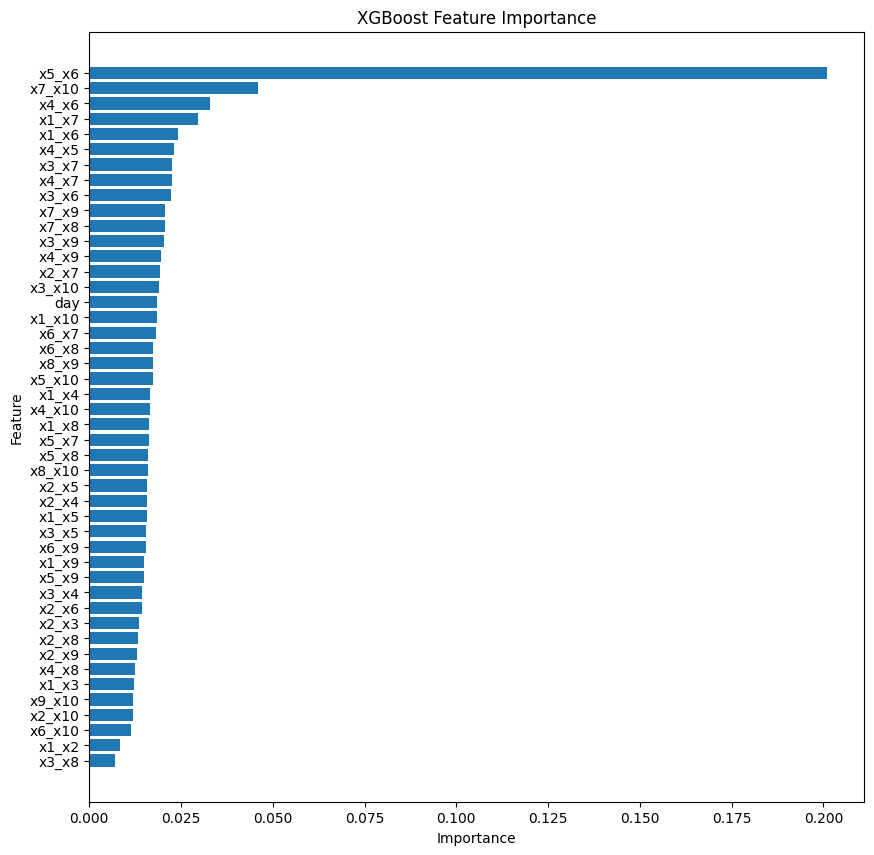

Our features are:
['day', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', '_2_1', '_2_2', '_2_3', '_2_4', '_2_5', '_2_6', '_2_7', '_2_8', '_2_9', '_2_10', '_2_11', '_2_12', '_2_13', '_2_14', '_2_15', '_2_16', '_2_17', '_2_18', '_2_19', '_2_20', '_2_21', '_2_22', '_2_23', '_2_24', '_2_25', '_2_26', '_2_27', '_2_28', '_2_29', '_2_30', '_2_31', '_2_32', '_2_33', '_2_34', '_2_35', '_2_36', '_2_37', '_2_38', '_2_39', '_2_40', '_2_41', '_2_42', '_2_43', '_2_44', '_2_45', '_2_46', '_2_47', '_2_48', '_2_49', '_2_50', '_2_51', '_2_52', '_2_53', '_2_54', '_2_55', '_2_56', '_2_57', '_2_58', '_2_59', '_2_60', '_2_61', '_2_62', '_2_63', '_2_64', '_2_65', '_2_66', '_2_67', '_2_68', '_2_69', '_2_70', '_2_71', '_2_72', '_2_73', '_2_74', '_2_75', '_

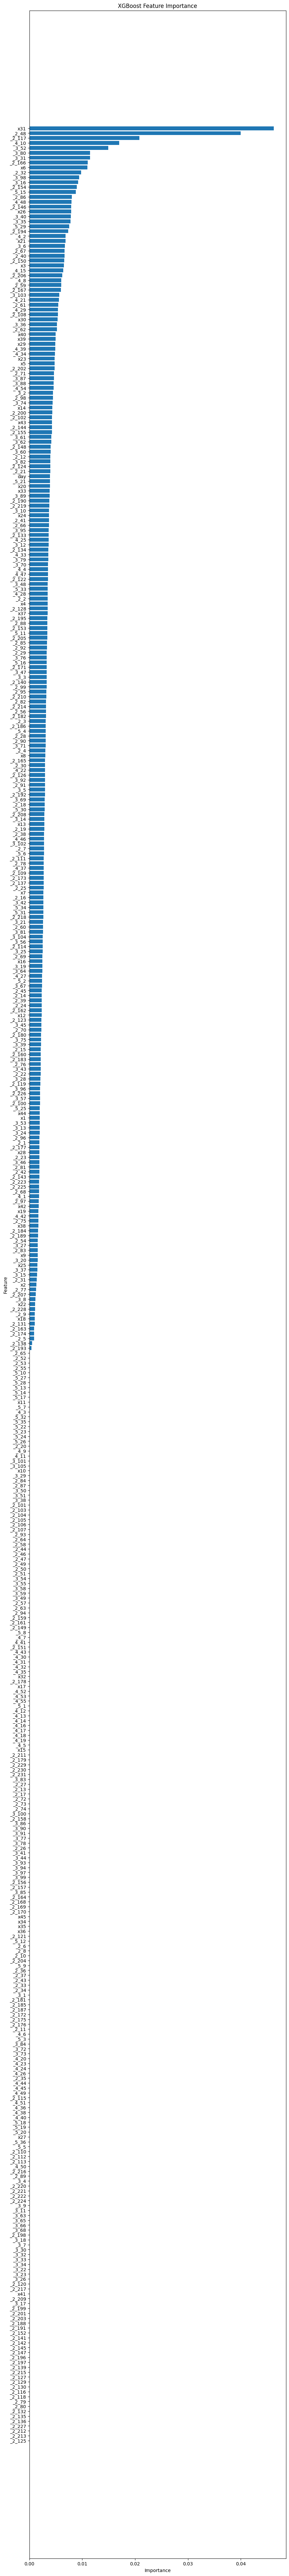

Ensemble achieves LB = ?! Hooray!
(730, 2)


,id,rainfall
0,2190,0.984932
1,2191,0.967123
2,2192,0.998630
3,2193,0.110959
4,2194,0.041096


In [21]:
# Lb = 0.95789

# RAPIDS KNN Starter Notebook - LB Ensemble 0.961! Wow!
# In this notebook, we train a RAPIDS KNN model and ensemble it with the best public notebook. 
# The best public notebook achieves LB = 0.954 and our ensemble achieves LB = 0.961 Wow!
# 
# DISCLAIMER: Note that the ensemble weights in this notebook are overfitted to public LB and 
# will not generalize to private LB. The purpopse of this notebook is to demonstrate that KNN 
# offers model diversity and helps improve ensembles.
# To find the correct ensemble weights we use the KNN OOF predictions together will all OOF 
# predictions from all models in our ensemble. We find weights to optimize OOF ensemble AUC 
# locally and then use these weights for test predictions during submission 
# (and we ignore public LB score)! Discussion here
# 
# UPDATE: In version 2 we increase n_neighbors from 101 to 201. 
# And we give the feature day more importance during the KNN distance computation. 
# This improves ensemble LB score LB 0.956 => LB 0.961 woohoo!

import pandas as pd, numpy as np, polars as pl
import matplotlib.pyplot as plt

train = pd.read_csv("/kaggle/input/playground-series-s5e3/train.csv")
print("Train shape", train.shape )
display(train.head())
test = pd.read_csv("/kaggle/input/playground-series-s5e3/test.csv")
print("Test shape:", test.shape )
display(test.head())

train = fen3(train)
test  = fen3(test)

cols_to_del = ['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12']

for col in cols_to_del:
    
    del test [col] 
    del train[col]

display(train.head(),test.head())

RMV = ['rainfall','id']
_FEATURES_ = [c for c in train.columns if not c in RMV]
print("Our features are:")
print( _FEATURES_ )

# KNN Model: We train 5 fold RAPIDS KNN classification model using 201 neighbors! 
#            We standardize all features to mean=0, std=1 because KNN likes this.

# UPDATE:    We adjust the weights of the features to increase/decrease importance of 
#            certain features during KNN distance computation.

from sklearn.model_selection import KFold
from cuml.neighbors import KNeighborsClassifier

# WEIGHTS TO ADJUST IMPORTANCE OF FEATURES DURING KNN
WGT = {
    'day': 24, 
    'pressure': 1,
    '_2_1':  1,
    '_2_2':  1,
    '_2_3':  1,
    '_2_4':  1,
    '_2_5':  1,
    '_2_6':  1,
    '_2_7':  1,
    '_2_8':  1,
    '_2_9':  1,
    '_2_10': 1,
    '_2_11': 2,
    '_2_12': 2,
    '_2_13': 1,                                 # Lb=0.95789
    '_2_14': 2,
    '_2_15': 1,
    '_3_1':  1,
    '_3_2':  1,
    '_3_3':  1,
    '_3_4':  1,
    '_3_5':  2,
    '_3_6':  1,
    '_4_1':  1,
    '_4_2':  1,
    '_4_3':  1,
    '_5_1':  1,
}

FOLDS = 5

kf = KFold(
            n_splits     = FOLDS, 
            shuffle      = True, 
            random_state = 3777 )
    
oof_knn  = np.zeros(len(train))
pred_knn = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):
    print(" "+"#"*25,'\n',f"### Fold {i+1}",'\n',"#"*25)
    X_train = train.loc[train_index, _FEATURES_].copy()
    y_train = train.loc[train_index, "rainfall"]
    X_valid = train.loc[test_index,  _FEATURES_].copy()
    y_valid = train.loc[test_index,  "rainfall"]
    X_test = test[_FEATURES_].copy()
    
    for c in _FEATURES_:
        m = X_train[c].mean()
        s = X_train[c].std()
        X_train[c] = WGT[c] * (X_train[c]-m)/s
        X_valid[c] = WGT[c] * (X_valid[c]-m)/s
        X_test[c]  = WGT[c] * (X_test[c] -m)/s
        X_test[c]  = X_test [c].fillna(0)
        X_train[c] = X_train[c].fillna(0)
        
    model = KNeighborsClassifier(n_neighbors=201, p=1)
    model.fit(X_train.values, y_train.values)
    # INFER OOF
    oof_knn[test_index] = model.predict_proba(X_valid.values)[:,1]
    # INFER TEST
    pred_knn += model.predict_proba(X_test.values)[:,1]
# COMPUTE AVERAGE TEST PREDS
pred_knn /= FOLDS


from sklearn.metrics import roc_auc_score
true = train.rainfall.values
m = roc_auc_score(true, oof_knn)
print(f"KNN CV Score AUC = {m:.3f}")


# Submission CSV Ensemble!
# We load best public notebook which achieves `LB 0.96111`
# Then we ensemble our new KNN model preditions 
# with weights `-0.07 * KNN + 1.07 * Public`. 
# We use `scipy.stats.rankdata` to normalize 


print("Best Public Notebook","achieves LB = 0.96111")
best_public = pd.read_csv("/kaggle/input/ps-s5e3-16-03-2025-subm-s/subm - LB 0.961 - RAPIDS KNN Starter Ensemble.csv")
display( best_public.head() )
best_public = best_public.rainfall.values

from scipy.stats import rankdata

print("Ensemble achieves LB = ?! Hooray!")
sub = pd.read_csv("/kaggle/input/playground-series-s5e3/sample_submission.csv")
sub.rainfall = -0.07 * rankdata( pred_knn ) + 1.07 * rankdata( best_public )
sub.rainfall = rankdata( sub.rainfall ) / len(sub)
print( sub.shape )
sub.to_csv("subm_hyperspace1.csv",index=False)
sub.head()

path = "/kaggle/input/ps-s5e3-16-03-2025-subm-s"

hyper_space1 = pd.read_csv("/kaggle/working/subm_hyperspace1.csv")
hyper_space_1 = hyper_space1.rainfall.values

from scipy.stats import rankdata

path = "/kaggle/input/ps-s5e3-16-03-2025-subm-s"

hyper_space1 = pd.read_csv("/kaggle/working/subm_hyperspace1.csv")
hyper_space_1 = hyper_space1.rainfall.values
best_public1 = pd.read_csv(path + "/subm - LB 0.961 - RAPIDS KNN Starter Ensemble.csv")
best_public_1 = best_public1.rainfall.values
best_public2 = pd.read_csv(path + "/subm - LB 0.956 - RAPIDS KNN Starter Ensemble.csv")
best_public_2 = best_public2.rainfall.values


hyper_space_5 = exec_fit_and_proba(fen_2__, qheight=10)
hyper_space_7 = exec_fit_and_proba(fen_2_h, qheight=100)


print("Ensemble achieves LB = ?! Hooray!")
sub = pd.read_csv("/kaggle/input/playground-series-s5e3/sample_submission.csv")

                                        # Lb=0.95789
# sub.rainfall =\
#      -0.07 * rankdata( hyper_space_1 ) +\
#      -0.07 * rankdata( hyper_space_5 ) +\
#      -0.07 * rankdata( hyper_space_7 ) +\
#      +1.11 * rankdata( best_public_1 ) +\
#      +1.10 * rankdata( best_public_2 )

                                        # Lb=0.42665
# sub.rainfall =\
#      -0.07 * rankdata( hyper_space_1 ) +\
#      -0.07 * rankdata( hyper_space_5 ) +\
#      -0.07 * rankdata( hyper_space_7 ) +\
#      +1.21 * rankdata( best_public_1 ) +\        
#      -1.07 * rankdata( best_public_2 )

                                        # Lb=0.58085
# sub.rainfall =\
#      -0.07 * rankdata( hyper_space_1 ) +\
#      -0.07 * rankdata( hyper_space_5 ) +\
#      -0.07 * rankdata( hyper_space_7 ) +\
#      +1.28 * rankdata( best_public_1 ) +\
#      -1.07 * rankdata( best_public_2 )

                                        # Lb=0.95682
# sub.rainfall =\
#      -0.07 * rankdata( hyper_space_1 ) +\
#      -0.07 * rankdata( hyper_space_5 ) +\
#      -0.07 * rankdata( hyper_space_7 ) +\
#      +1.21 * rankdata( best_public_1 )

                                        # Lb=0.94663
# sub.rainfall =\
#     -0.13 * rankdata( hyper_space_1 ) +\
#     -0.15 * rankdata( hyper_space_5 ) +\
#     +1.07 * rankdata( hyper_space_7 ) +\
#     +1.11 * rankdata( best_public_1 ) +\
#     +1.10 * rankdata( best_public_2 )

                                        # Lb=95655
# sub.rainfall =\
#     -0.10 * rankdata( hyper_space_5 ) +\
#     -0.11 * rankdata( hyper_space_7 ) +\
#     +1.11 * rankdata( best_public_1 ) +\
#     +1.10 * rankdata( best_public_2 )

                                        # Lb=0.95789
sub.rainfall =\
     -0.07 * rankdata( hyper_space_1 ) +\
     -0.07 * rankdata( hyper_space_5 ) +\
     -0.07 * rankdata( hyper_space_7 ) +\
     +1.11 * rankdata( best_public_1 ) +\
     +1.10 * rankdata( best_public_2 )

sub.rainfall = rankdata( sub.rainfall ) / len(sub)

print( sub.shape )
sub.to_csv("submission_sub___z_the_End.csv",index=False)
sub.head()

In [22]:
# Lb = ?

# RAPIDS KNN Starter Notebook - LB Ensemble 0.961! Wow!
# In this notebook, we train a RAPIDS KNN model and ensemble it with the best public notebook. 
# The best public notebook achieves LB = 0.954 and our ensemble achieves LB = 0.961 Wow!
# 
# DISCLAIMER: Note that the ensemble weights in this notebook are overfitted to public LB and 
# will not generalize to private LB. The purpopse of this notebook is to demonstrate that KNN 
# offers model diversity and helps improve ensembles.
# To find the correct ensemble weights we use the KNN OOF predictions together will all OOF 
# predictions from all models in our ensemble. We find weights to optimize OOF ensemble AUC 
# locally and then use these weights for test predictions during submission 
# (and we ignore public LB score)! Discussion here
# 
# UPDATE: In version 2 we increase n_neighbors from 101 to 201. 
# And we give the feature day more importance during the KNN distance computation. 
# This improves ensemble LB score LB 0.956 => LB 0.961 woohoo!

import pandas as pd, numpy as np, polars as pl
import matplotlib.pyplot as plt

train = pd.read_csv("/kaggle/input/playground-series-s5e3/train.csv")
print("Train shape", train.shape )
display(train.head())
test = pd.read_csv("/kaggle/input/playground-series-s5e3/test.csv")
print("Test shape:", test.shape )
display(test.head())

train = fen3(train)
test  = fen3(test)

for col in ['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12']: 
    del test [col] 
    del train[col]

display(train.head(),test.head())

RMV = ['rainfall','id']
_FEATURES_ = [c for c in train.columns if not c in RMV]
print("Our features are:")
print( _FEATURES_ )

# KNN Model: We train 5 fold RAPIDS KNN classification model using 201 neighbors! 
#            We standardize all features to mean=0, std=1 because KNN likes this.

# UPDATE:    We adjust the weights of the features to increase/decrease importance of 
#            certain features during KNN distance computation.

from sklearn.model_selection import KFold
from cuml.neighbors import KNeighborsClassifier

# WEIGHTS TO ADJUST IMPORTANCE OF FEATURES DURING KNN
WGT = {
    'day': 24, 
    'pressure': 1,
    '_2_1':  1,
    '_2_2':  1,
    '_2_3':  1,
    '_2_4':  1,
    '_2_5':  1,
    '_2_6':  1,
    '_2_7':  1,
    '_2_8':  1,
    '_2_9':  1,
    '_2_10': 1,
    '_2_11': 2,
    '_2_12': 2,
    '_2_13': 1,                                 # Lb=0.?
    '_2_14': 2,
    '_2_15': 1,
    '_3_1':  1,
    '_3_2':  1,
    '_3_3':  1,
    '_3_4':  1,
    '_3_5':  2,
    '_3_6':  1,
    '_4_1':  1,
    '_4_2':  1,
    '_4_3':  1,
    '_5_1':  1,
}

FOLDS = 5

kf = KFold(
            n_splits     = FOLDS, 
            shuffle      = True, 
            random_state = 3777 )
    
oof_knn  = np.zeros(len(train))
pred_knn = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):
    print(" "+"#"*25,'\n',f"### Fold {i+1}",'\n',"#"*25)
    X_train = train.loc[train_index, _FEATURES_].copy()
    y_train = train.loc[train_index, "rainfall"]
    X_valid = train.loc[test_index,  _FEATURES_].copy()
    y_valid = train.loc[test_index,  "rainfall"]
    X_test = test[_FEATURES_].copy()
    
    for c in _FEATURES_:
        m = X_train[c].mean()
        s = X_train[c].std()
        X_train[c] = WGT[c] * (X_train[c]-m)/s
        X_valid[c] = WGT[c] * (X_valid[c]-m)/s
        X_test[c]  = WGT[c] * (X_test[c] -m)/s
        X_test[c]  = X_test [c].fillna(0)
        X_train[c] = X_train[c].fillna(0)
        
    model = KNeighborsClassifier(n_neighbors=201, p=1)
    model.fit(X_train.values, y_train.values)
    # INFER OOF
    oof_knn[test_index] = model.predict_proba(X_valid.values)[:,1]
    # INFER TEST
    pred_knn += model.predict_proba(X_test.values)[:,1]
# COMPUTE AVERAGE TEST PREDS
pred_knn /= FOLDS


from sklearn.metrics import roc_auc_score
true = train.rainfall.values
m = roc_auc_score(true, oof_knn)
print(f"KNN CV Score AUC = {m:.3f}")


# Submission CSV Ensemble!
# We load best public notebook which achieves `LB 0.96111`
# Then we ensemble our new KNN model preditions 
# with weights `-0.07 * KNN + 1.07 * Public`. 
# We use `scipy.stats.rankdata` to normalize 


print("Best Public Notebook","achieves LB = 0.96111")
best_public = pd.read_csv("/kaggle/input/ps-s5e3-16-03-2025-subm-s/subm - LB 0.961 - RAPIDS KNN Starter Ensemble.csv")
display( best_public.head() )
best_public = best_public.rainfall.values

from scipy.stats import rankdata

print("Ensemble achieves LB = ?! Hooray!")
sub = pd.read_csv("/kaggle/input/playground-series-s5e3/sample_submission.csv")
sub.rainfall = -0.07 * rankdata( pred_knn ) + 1.07 * rankdata( best_public )
sub.rainfall = rankdata( sub.rainfall ) / len(sub)
print( sub.shape )
sub.to_csv("subm_hyperspace1.csv",index=False)
sub.head()

Train shape (2190, 13)


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


Test shape: (730, 12)


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4


,id,day,pressure,rainfall,_2_1,_2_2,_2_3,_2_4,_2_5,_2_6,...,_3_1,_3_2,_3_3,_3_4,_3_5,_3_6,_4_1,_4_2,_4_3,_5_1
0,0,1,1017.4,1,1.769181,94.193418,44.230872,5.122499,28.004765,95.960252,...,95.130489,44.313203,27.352087,77.952101,122.206588,63.199074,104.279432,26.731563,115.436651,106.299106
1,1,2,1019.5,1,1.552417,108.167694,36.851730,6.264982,23.410468,109.489726,...,108.421815,37.353179,23.369638,83.886650,131.616146,57.964299,114.660586,22.935780,113.823811,113.105217
2,2,3,1024.1,1,8.323461,63.609512,55.031082,8.104937,13.698973,71.200070,...,67.977790,55.142271,11.191339,29.346380,78.653722,64.569205,88.149589,10.396769,87.035300,80.993889
3,3,4,1013.4,1,1.562050,108.965361,45.917861,18.044667,25.386020,110.520813,...,109.823222,49.579633,24.990798,70.961962,134.393303,71.041678,118.428459,29.890801,117.417716,122.882301
4,4,5,1021.8,0,10.707474,40.620807,27.925795,4.879549,23.086587,51.062707,...,46.410020,29.529815,18.825223,24.249536,64.862792,45.900320,52.045845,13.954904,51.026131,50.387002


,id,day,pressure,_2_1,_2_2,_2_3,_2_4,_2_5,_2_6,_2_7,...,_3_1,_3_2,_3_3,_3_4,_3_5,_3_6,_4_1,_4_2,_4_3,_5_1
0,2190,1,1019.5,4.883646,114.387456,38.417314,7.741447,23.577320,118.371027,37.326934,...,117.840952,40.130412,20.369831,88.983706,137.978839,58.912987,120.323688,21.053028,118.157268,119.263532
1,2191,2,1016.5,2.202272,114.570939,37.795502,17.800000,24.052027,116.758940,38.309920,...,115.793998,42.529402,22.866788,80.589702,138.607215,63.390378,120.806250,28.186699,114.512619,122.361881
2,2192,3,1023.9,2.343075,113.676735,31.648065,14.654010,15.283979,115.991250,32.489537,...,114.979172,32.524606,18.915866,91.934868,129.757466,49.566319,118.228465,19.552749,107.578901,110.254116
3,2193,4,1022.9,9.486833,61.046294,13.767353,30.518191,17.008399,69.543440,13.261222,...,65.882775,37.982891,13.312788,55.336426,78.997250,48.096738,62.470073,31.690624,35.369533,71.596508
4,2194,5,1022.2,13.577187,62.710844,9.276314,9.024965,8.470322,76.109461,15.947727,...,69.940260,15.970285,8.199406,56.605388,73.396960,19.870053,64.706878,10.565656,56.556750,60.118051


Our features are:
['day', 'pressure', '_2_1', '_2_2', '_2_3', '_2_4', '_2_5', '_2_6', '_2_7', '_2_8', '_2_9', '_2_10', '_2_11', '_2_12', '_2_13', '_2_14', '_2_15', '_3_1', '_3_2', '_3_3', '_3_4', '_3_5', '_3_6', '_4_1', '_4_2', '_4_3', '_5_1']
 ######################### 
 ### Fold 1 
 #########################
 ######################### 
 ### Fold 2 
 #########################
 ######################### 
 ### Fold 3 
 #########################
 ######################### 
 ### Fold 4 
 #########################
 ######################### 
 ### Fold 5 
 #########################
KNN CV Score AUC = 0.863
Best Public Notebook achieves LB = 0.96111


,id,rainfall
0,2190,0.997260
1,2191,0.995890
2,2192,0.998630
3,2193,0.121918
4,2194,0.057534


Ensemble achieves LB = ?! Hooray!
(730, 2)


,id,rainfall
0,2190,0.997260
1,2191,0.994521
2,2192,0.998630
3,2193,0.127397
4,2194,0.057534


Our features are:
['day', 'x1_x2', 'x1_x3', 'x1_x4', 'x1_x5', 'x1_x6', 'x1_x7', 'x1_x8', 'x1_x9', 'x1_x10', 'x2_x3', 'x2_x4', 'x2_x5', 'x2_x6', 'x2_x7', 'x2_x8', 'x2_x9', 'x2_x10', 'x3_x4', 'x3_x5', 'x3_x6', 'x3_x7', 'x3_x8', 'x3_x9', 'x3_x10', 'x4_x5', 'x4_x6', 'x4_x7', 'x4_x8', 'x4_x9', 'x4_x10', 'x5_x6', 'x5_x7', 'x5_x8', 'x5_x9', 'x5_x10', 'x6_x7', 'x6_x8', 'x6_x9', 'x6_x10', 'x7_x8', 'x7_x9', 'x7_x10', 'x8_x9', 'x8_x10', 'x9_x10']
### Fold 1 #####################
[0]	validation_0-auc:0.84690
[100]	validation_0-auc:0.87408
[132]	validation_0-auc:0.87479
### Fold 2 #####################
[0]	validation_0-auc:0.87375
[100]	validation_0-auc:0.88400
[118]	validation_0-auc:0.88140
### Fold 3 #####################
[0]	validation_0-auc:0.89308
[100]	validation_0-auc:0.90730
[128]	validation_0-auc:0.90480
### Fold 4 #####################
[0]	validation_0-auc:0.83462
[100]	validation_0-auc:0.87583
[116]	validation_0-auc:0.87235
### Fold 5 #####################
[0]	validation_0-auc:0.87623
[1

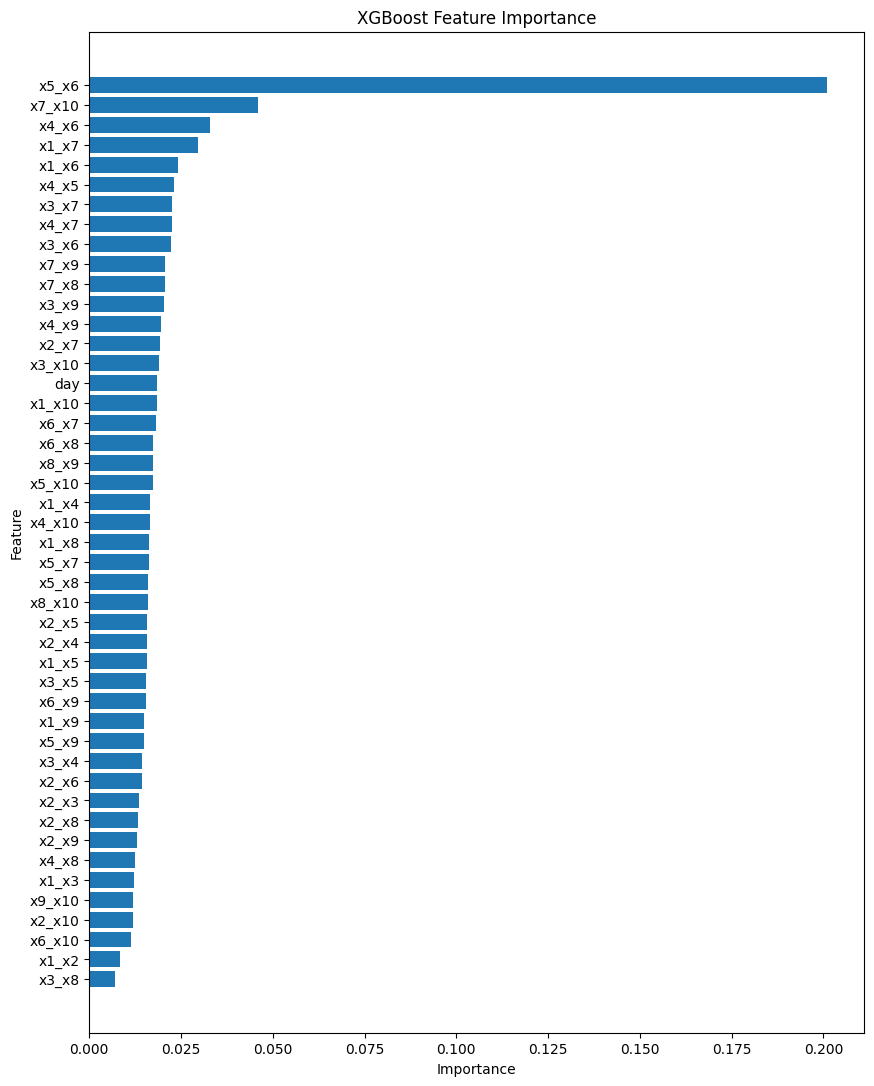

In [23]:
import pandas as pd, numpy as np, polars as pl
import matplotlib.pyplot as plt

hyper_space_2__ = exec_fit_and_proba(fen_2__, qheight=13)

Our features are:
['day', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', '_2_1', '_2_2', '_2_3', '_2_4', '_2_5', '_2_6', '_2_7', '_2_8', '_2_9', '_2_10', '_2_11', '_2_12', '_2_13', '_2_14', '_2_15', '_2_16', '_2_17', '_2_18', '_2_19', '_2_20', '_2_21', '_2_22', '_2_23', '_2_24', '_2_25', '_2_26', '_2_27', '_2_28', '_2_29', '_2_30', '_2_31', '_2_32', '_2_33', '_2_34', '_2_35', '_2_36', '_2_37', '_2_38', '_2_39', '_2_40', '_2_41', '_2_42', '_2_43', '_2_44', '_2_45', '_2_46', '_2_47', '_2_48', '_2_49', '_2_50', '_2_51', '_2_52', '_2_53', '_2_54', '_2_55', '_2_56', '_2_57', '_2_58', '_2_59', '_2_60', '_2_61', '_2_62', '_2_63', '_2_64', '_2_65', '_2_66', '_2_67', '_2_68', '_2_69', '_2_70', '_2_71', '_2_72', '_2_73', '_2_74', '_2_75', '_

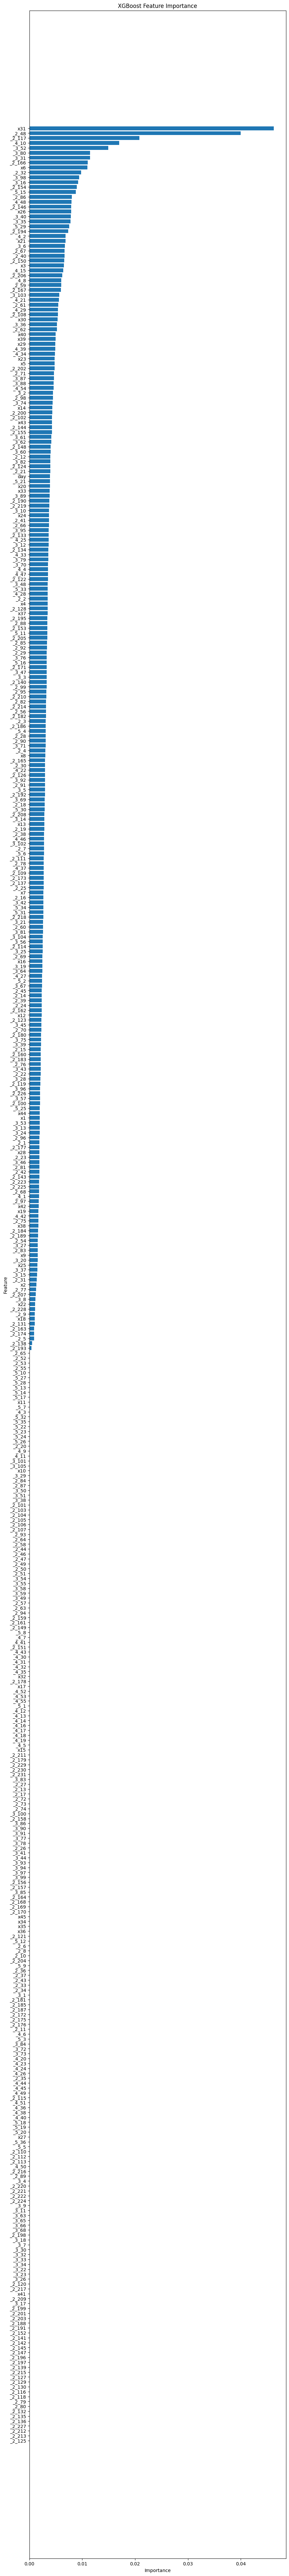

In [24]:
hyper_space_2_h = exec_fit_and_proba(fen_2_h, qheight=100)

Our features are:
['day', 'x1_x2_x3', 'x1_x2_x4', 'x1_x2_x5', 'x1_x2_x6', 'x1_x2_x7', 'x1_x2_x8', 'x1_x2_x9', 'x1_x2_x10', 'x1_x3_x4', 'x1_x3_x5', 'x1_x3_x6', 'x1_x3_x7', 'x1_x3_x8', 'x1_x3_x9', 'x1_x3_x10', 'x1_x4_x5', 'x1_x4_x6', 'x1_x4_x7', 'x1_x4_x8', 'x1_x4_x9', 'x1_x4_x10', 'x1_x5_x6', 'x1_x5_x7', 'x1_x5_x8', 'x1_x5_x9', 'x1_x5_x10', 'x1_x6_x7', 'x1_x6_x8', 'x1_x6_x9', 'x1_x6_x10', 'x1_x7_x8', 'x1_x7_x9', 'x1_x7_x10', 'x1_x8_x9', 'x1_x8_x10', 'x1_x9_x10', 'x2_x3_x4', 'x2_x3_x5', 'x2_x3_x6', 'x2_x3_x7', 'x2_x3_x8', 'x2_x3_x9', 'x2_x3_x10', 'x2_x4_x5', 'x2_x4_x6', 'x2_x4_x7', 'x2_x4_x8', 'x2_x4_x9', 'x2_x4_x10', 'x2_x5_x6', 'x2_x5_x7', 'x2_x5_x8', 'x2_x5_x9', 'x2_x5_x10', 'x2_x6_x7', 'x2_x6_x8', 'x2_x6_x9', 'x2_x6_x10', 'x2_x7_x8', 'x2_x7_x9', 'x2_x7_x10', 'x2_x8_x9', 'x2_x8_x10', 'x2_x9_x10', 'x3_x4_x5', 'x3_x4_x6', 'x3_x4_x7', 'x3_x4_x8', 'x3_x4_x9', 'x3_x4_x10', 'x3_x5_x6', 'x3_x5_x7', 'x3_x5_x8', 'x3_x5_x9', 'x3_x5_x10', 'x3_x6_x7', 'x3_x6_x8', 'x3_x6_x9', 'x3_x6_x10', 'x3_x7_x

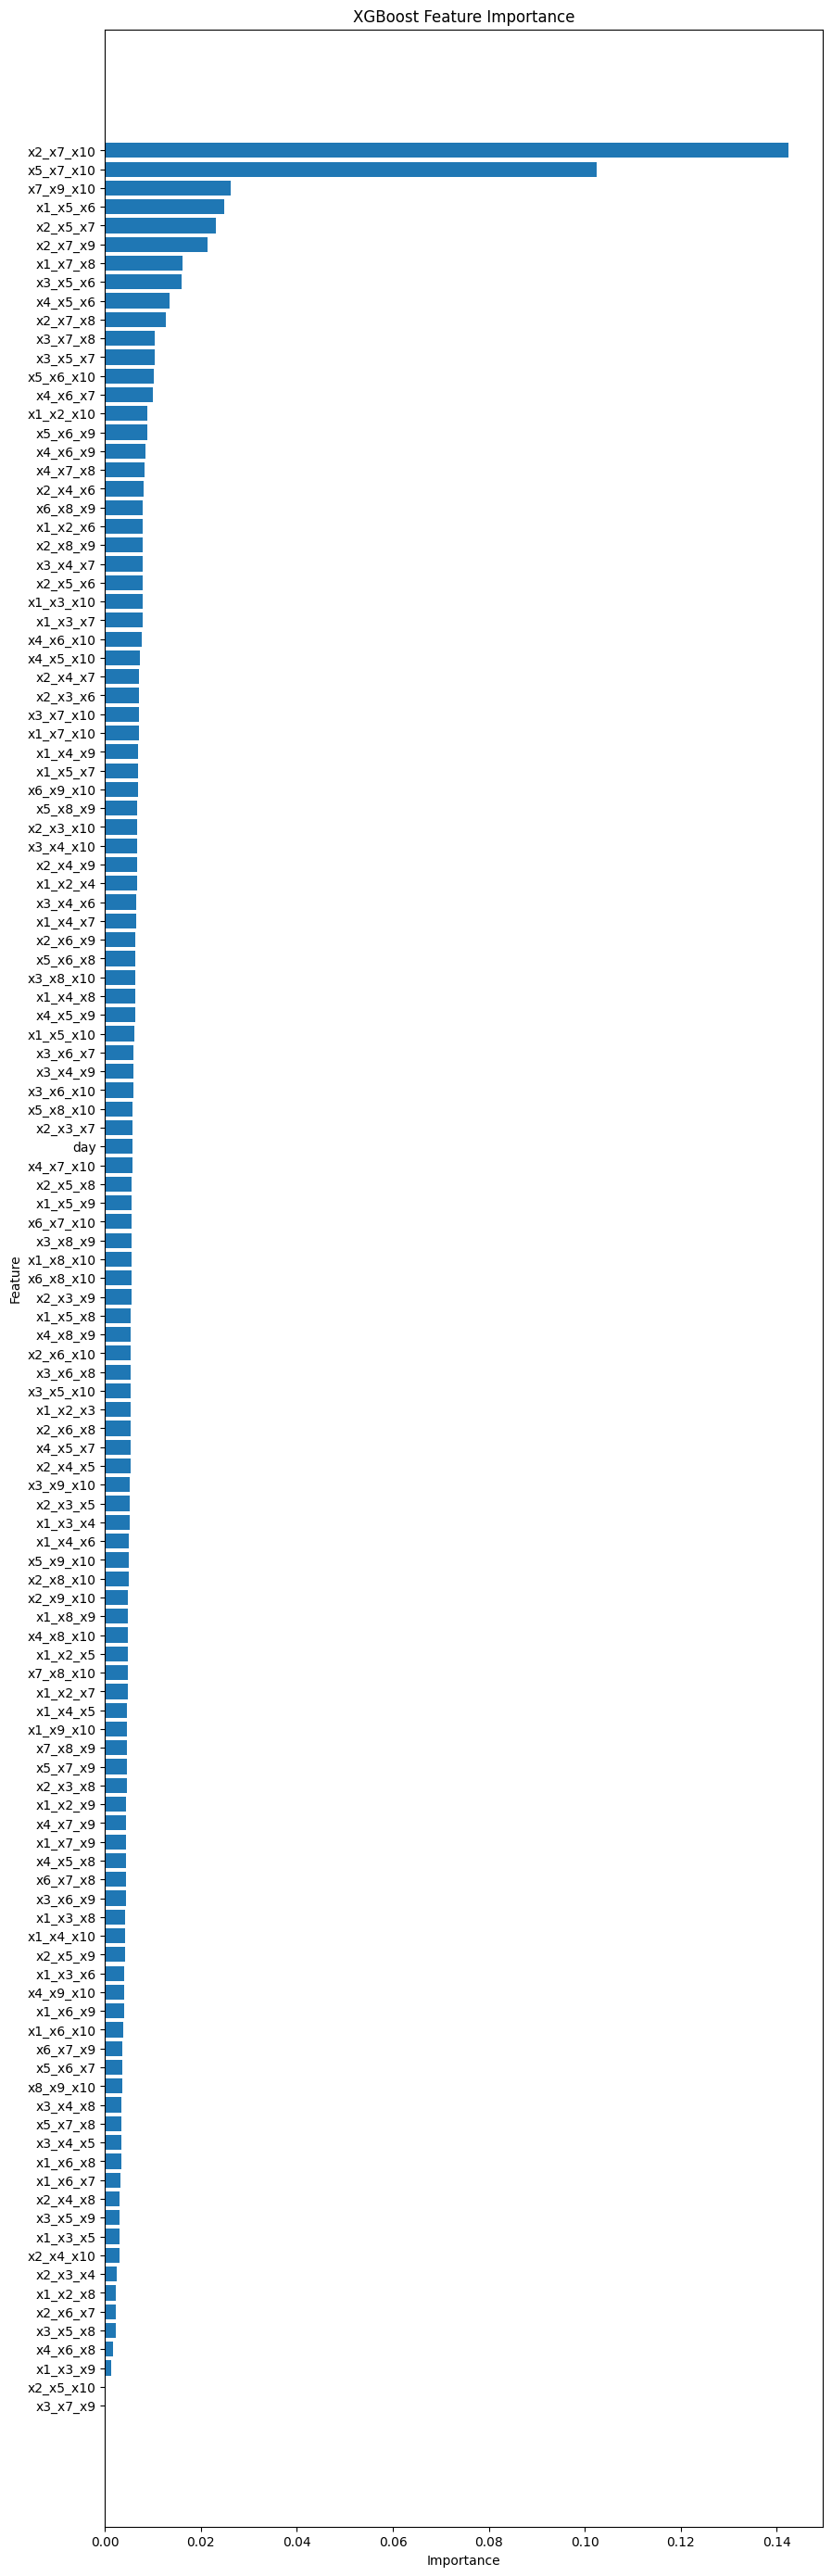

In [25]:
hyper_space_3__ = exec_fit_and_proba(fen_3__, qheight=35)

Our features are:
['day', 'x1_x2_x3_x4', 'x1_x2_x3_x5', 'x1_x2_x3_x6', 'x1_x2_x3_x7', 'x1_x2_x3_x8', 'x1_x2_x3_x9', 'x1_x2_x3_x10', 'x1_x2_x4_x5', 'x1_x2_x4_x6', 'x1_x2_x4_x7', 'x1_x2_x4_x8', 'x1_x2_x4_x9', 'x1_x2_x4_x10', 'x1_x2_x5_x6', 'x1_x2_x5_x7', 'x1_x2_x5_x8', 'x1_x2_x5_x9', 'x1_x2_x5_x10', 'x1_x2_x6_x7', 'x1_x2_x6_x8', 'x1_x2_x6_x9', 'x1_x2_x6_x10', 'x1_x2_x7_x8', 'x1_x2_x7_x9', 'x1_x2_x7_x10', 'x1_x2_x8_x9', 'x1_x2_x8_x10', 'x1_x2_x9_x10', 'x1_x3_x4_x5', 'x1_x3_x4_x6', 'x1_x3_x4_x7', 'x1_x3_x4_x8', 'x1_x3_x4_x9', 'x1_x3_x4_x10', 'x1_x3_x5_x6', 'x1_x3_x5_x7', 'x1_x3_x5_x8', 'x1_x3_x5_x9', 'x1_x3_x5_x10', 'x1_x3_x6_x7', 'x1_x3_x6_x8', 'x1_x3_x6_x9', 'x1_x3_x6_x10', 'x1_x3_x7_x8', 'x1_x3_x7_x9', 'x1_x3_x7_x10', 'x1_x3_x8_x9', 'x1_x3_x8_x10', 'x1_x3_x9_x10', 'x1_x4_x5_x6', 'x1_x4_x5_x7', 'x1_x4_x5_x8', 'x1_x4_x5_x9', 'x1_x4_x5_x10', 'x1_x4_x6_x7', 'x1_x4_x6_x8', 'x1_x4_x6_x9', 'x1_x4_x6_x10', 'x1_x4_x7_x8', 'x1_x4_x7_x9', 'x1_x4_x7_x10', 'x1_x4_x8_x9', 'x1_x4_x8_x10', 'x1_x4_x9_x1

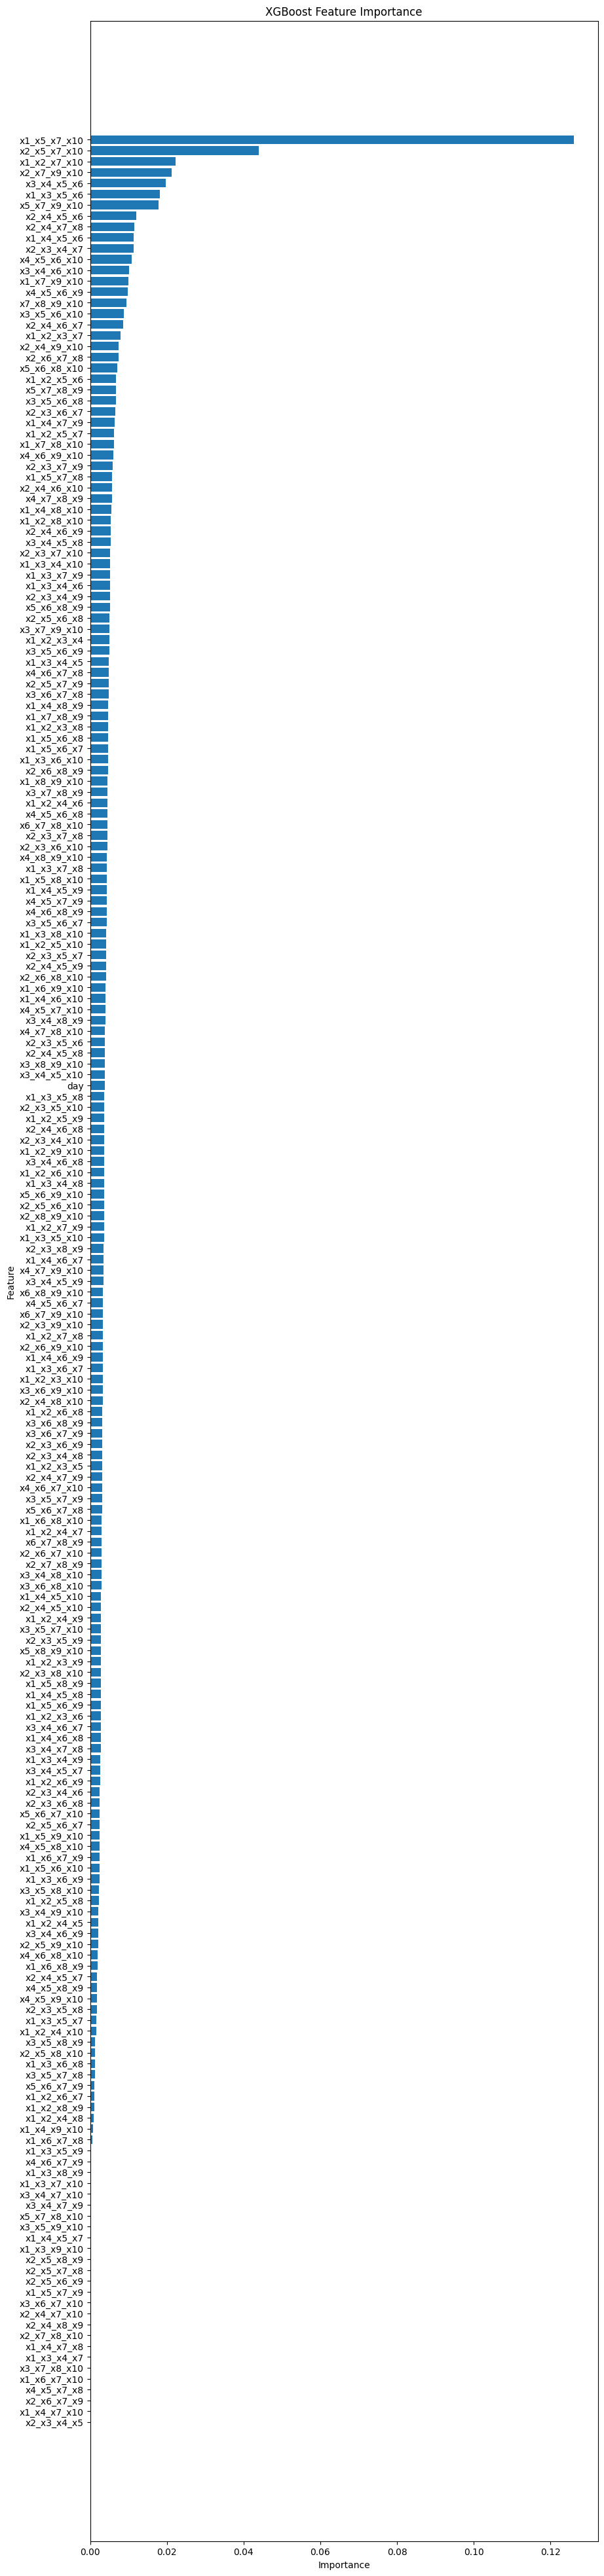

In [26]:
hyper_space_4__ = exec_fit_and_proba(fen_4__, qheight=50)

In [27]:
knn_hyper_space_2__ = exec_KNN__fit_and_proba(fen_2__)

Our features are:
['day', 'x1_x2', 'x1_x3', 'x1_x4', 'x1_x5', 'x1_x6', 'x1_x7', 'x1_x8', 'x1_x9', 'x1_x10', 'x2_x3', 'x2_x4', 'x2_x5', 'x2_x6', 'x2_x7', 'x2_x8', 'x2_x9', 'x2_x10', 'x3_x4', 'x3_x5', 'x3_x6', 'x3_x7', 'x3_x8', 'x3_x9', 'x3_x10', 'x4_x5', 'x4_x6', 'x4_x7', 'x4_x8', 'x4_x9', 'x4_x10', 'x5_x6', 'x5_x7', 'x5_x8', 'x5_x9', 'x5_x10', 'x6_x7', 'x6_x8', 'x6_x9', 'x6_x10', 'x7_x8', 'x7_x9', 'x7_x10', 'x8_x9', 'x8_x10', 'x9_x10']
### Fold 1 #####################
### Fold 2 #####################
### Fold 3 #####################
### Fold 4 #####################
### Fold 5 #####################
KNN CV Score AUC = 0.819




Our features are:
['day', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59', 'x60', 'x61', 'x62', 'x63', 'x64', 'x65', 'x66', 'x67', 'x68', 'x69', 'x70', 'x71', 'x72', 'x73', 'x74', 'x75', 'x76', 'x77', 'x78', 'x79', 'x80', 'x81', 'x82', 'x83', 'x84', 'x85', 'x86', 'x87', 'x88', 'x89', 'x90', 'x91', 'x92', 'x93', 'x94', 'x95', 'x96', 'x97', 'x98', 'x99', 'x100', 'x101', 'x102', 'x103', 'x104', 'x105', 'x106', 'x107', 'x108', 'x109', 'x110', 'x111', 'x112', 'x113', 'x114', 'x115', 'x116', 'x117', 'x118', 'x119', 'x120', 'x121', 'x122', 'x123', 'x124', 'x125', 'x126', 'x127', 'x128', 'x129', 'x130', 'x131', 'x132', 'x133', 'x134', 'x135', 'x

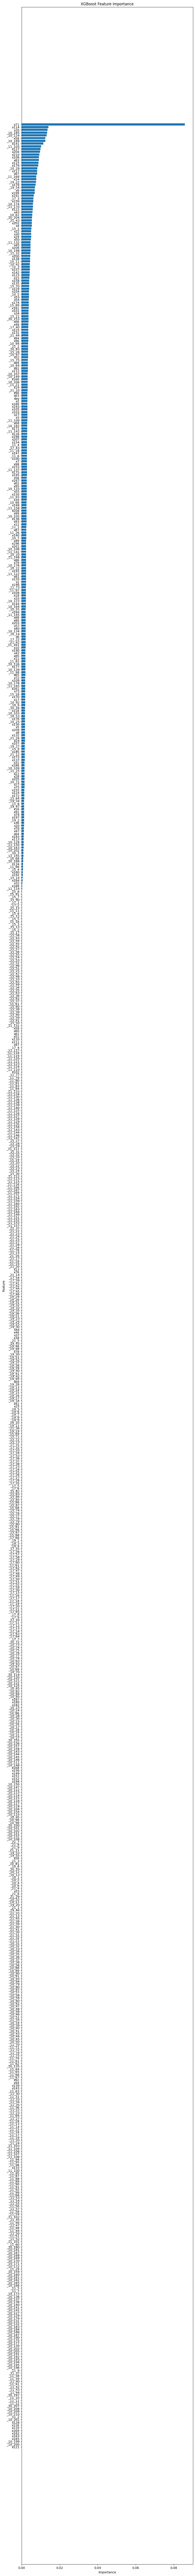

In [28]:
hyper_space_4_h = exec_fit_and_proba(fen_4_h, qheight=150)

In [29]:
knn_hyper_space_2_h = exec_KNN__fit_and_proba(fen_2_h)

Our features are:
['day', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', '_2_1', '_2_2', '_2_3', '_2_4', '_2_5', '_2_6', '_2_7', '_2_8', '_2_9', '_2_10', '_2_11', '_2_12', '_2_13', '_2_14', '_2_15', '_2_16', '_2_17', '_2_18', '_2_19', '_2_20', '_2_21', '_2_22', '_2_23', '_2_24', '_2_25', '_2_26', '_2_27', '_2_28', '_2_29', '_2_30', '_2_31', '_2_32', '_2_33', '_2_34', '_2_35', '_2_36', '_2_37', '_2_38', '_2_39', '_2_40', '_2_41', '_2_42', '_2_43', '_2_44', '_2_45', '_2_46', '_2_47', '_2_48', '_2_49', '_2_50', '_2_51', '_2_52', '_2_53', '_2_54', '_2_55', '_2_56', '_2_57', '_2_58', '_2_59', '_2_60', '_2_61', '_2_62', '_2_63', '_2_64', '_2_65', '_2_66', '_2_67', '_2_68', '_2_69', '_2_70', '_2_71', '_2_72', '_2_73', '_2_74', '_2_75', '_

In [30]:
knn_hyper_space_3__ = exec_KNN__fit_and_proba(fen_3__)

Our features are:
['day', 'x1_x2_x3', 'x1_x2_x4', 'x1_x2_x5', 'x1_x2_x6', 'x1_x2_x7', 'x1_x2_x8', 'x1_x2_x9', 'x1_x2_x10', 'x1_x3_x4', 'x1_x3_x5', 'x1_x3_x6', 'x1_x3_x7', 'x1_x3_x8', 'x1_x3_x9', 'x1_x3_x10', 'x1_x4_x5', 'x1_x4_x6', 'x1_x4_x7', 'x1_x4_x8', 'x1_x4_x9', 'x1_x4_x10', 'x1_x5_x6', 'x1_x5_x7', 'x1_x5_x8', 'x1_x5_x9', 'x1_x5_x10', 'x1_x6_x7', 'x1_x6_x8', 'x1_x6_x9', 'x1_x6_x10', 'x1_x7_x8', 'x1_x7_x9', 'x1_x7_x10', 'x1_x8_x9', 'x1_x8_x10', 'x1_x9_x10', 'x2_x3_x4', 'x2_x3_x5', 'x2_x3_x6', 'x2_x3_x7', 'x2_x3_x8', 'x2_x3_x9', 'x2_x3_x10', 'x2_x4_x5', 'x2_x4_x6', 'x2_x4_x7', 'x2_x4_x8', 'x2_x4_x9', 'x2_x4_x10', 'x2_x5_x6', 'x2_x5_x7', 'x2_x5_x8', 'x2_x5_x9', 'x2_x5_x10', 'x2_x6_x7', 'x2_x6_x8', 'x2_x6_x9', 'x2_x6_x10', 'x2_x7_x8', 'x2_x7_x9', 'x2_x7_x10', 'x2_x8_x9', 'x2_x8_x10', 'x2_x9_x10', 'x3_x4_x5', 'x3_x4_x6', 'x3_x4_x7', 'x3_x4_x8', 'x3_x4_x9', 'x3_x4_x10', 'x3_x5_x6', 'x3_x5_x7', 'x3_x5_x8', 'x3_x5_x9', 'x3_x5_x10', 'x3_x6_x7', 'x3_x6_x8', 'x3_x6_x9', 'x3_x6_x10', 'x3_x7_x

In [31]:
knn_hyper_space_4__ = exec_KNN__fit_and_proba(fen_4__)

Our features are:
['day', 'x1_x2_x3_x4', 'x1_x2_x3_x5', 'x1_x2_x3_x6', 'x1_x2_x3_x7', 'x1_x2_x3_x8', 'x1_x2_x3_x9', 'x1_x2_x3_x10', 'x1_x2_x4_x5', 'x1_x2_x4_x6', 'x1_x2_x4_x7', 'x1_x2_x4_x8', 'x1_x2_x4_x9', 'x1_x2_x4_x10', 'x1_x2_x5_x6', 'x1_x2_x5_x7', 'x1_x2_x5_x8', 'x1_x2_x5_x9', 'x1_x2_x5_x10', 'x1_x2_x6_x7', 'x1_x2_x6_x8', 'x1_x2_x6_x9', 'x1_x2_x6_x10', 'x1_x2_x7_x8', 'x1_x2_x7_x9', 'x1_x2_x7_x10', 'x1_x2_x8_x9', 'x1_x2_x8_x10', 'x1_x2_x9_x10', 'x1_x3_x4_x5', 'x1_x3_x4_x6', 'x1_x3_x4_x7', 'x1_x3_x4_x8', 'x1_x3_x4_x9', 'x1_x3_x4_x10', 'x1_x3_x5_x6', 'x1_x3_x5_x7', 'x1_x3_x5_x8', 'x1_x3_x5_x9', 'x1_x3_x5_x10', 'x1_x3_x6_x7', 'x1_x3_x6_x8', 'x1_x3_x6_x9', 'x1_x3_x6_x10', 'x1_x3_x7_x8', 'x1_x3_x7_x9', 'x1_x3_x7_x10', 'x1_x3_x8_x9', 'x1_x3_x8_x10', 'x1_x3_x9_x10', 'x1_x4_x5_x6', 'x1_x4_x5_x7', 'x1_x4_x5_x8', 'x1_x4_x5_x9', 'x1_x4_x5_x10', 'x1_x4_x6_x7', 'x1_x4_x6_x8', 'x1_x4_x6_x9', 'x1_x4_x6_x10', 'x1_x4_x7_x8', 'x1_x4_x7_x9', 'x1_x4_x7_x10', 'x1_x4_x8_x9', 'x1_x4_x8_x10', 'x1_x4_x9_x1

In [32]:
knn_hyper_space_4_h = exec_KNN__fit_and_proba(fen_4_h)

Our features are:
['day', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59', 'x60', 'x61', 'x62', 'x63', 'x64', 'x65', 'x66', 'x67', 'x68', 'x69', 'x70', 'x71', 'x72', 'x73', 'x74', 'x75', 'x76', 'x77', 'x78', 'x79', 'x80', 'x81', 'x82', 'x83', 'x84', 'x85', 'x86', 'x87', 'x88', 'x89', 'x90', 'x91', 'x92', 'x93', 'x94', 'x95', 'x96', 'x97', 'x98', 'x99', 'x100', 'x101', 'x102', 'x103', 'x104', 'x105', 'x106', 'x107', 'x108', 'x109', 'x110', 'x111', 'x112', 'x113', 'x114', 'x115', 'x116', 'x117', 'x118', 'x119', 'x120', 'x121', 'x122', 'x123', 'x124', 'x125', 'x126', 'x127', 'x128', 'x129', 'x130', 'x131', 'x132', 'x133', 'x134', 'x135', 'x

In [33]:
sub_2__ = pd.read_csv("/kaggle/input/playground-series-s5e3/sample_submission.csv")
sub_2_h = pd.read_csv("/kaggle/input/playground-series-s5e3/sample_submission.csv")
sub_3__ = pd.read_csv("/kaggle/input/playground-series-s5e3/sample_submission.csv")
sub_4__ = pd.read_csv("/kaggle/input/playground-series-s5e3/sample_submission.csv")
sub_4_h = pd.read_csv("/kaggle/input/playground-series-s5e3/sample_submission.csv")

sub_2__.rainfall = hyper_space_2__
sub_2__.to_csv("submission_2__.csv",index=False)
display(sub_2__.head())

sub_2_h.rainfall = hyper_space_2_h
sub_2_h.to_csv("submission_2_h.csv",index=False)
display(sub_2_h.head())

sub_3__.rainfall = hyper_space_3__
sub_3__.to_csv("submission_3__.csv",index=False)
display(sub_3__.head())

sub_4__.rainfall = hyper_space_4__
sub_4__.to_csv("submission_4__.csv",index=False)
display(sub_4__.head())

sub_4_h.rainfall = hyper_space_4_h
sub_4_h.to_csv("submission_4_h.csv",index=False)
display(sub_4_h.head())

print("~~~KNN~~~~~~~")

knn_sub_2__ = pd.read_csv("/kaggle/input/playground-series-s5e3/sample_submission.csv")
knn_sub_2_h = pd.read_csv("/kaggle/input/playground-series-s5e3/sample_submission.csv")
knn_sub_3__ = pd.read_csv("/kaggle/input/playground-series-s5e3/sample_submission.csv")
knn_sub_4__ = pd.read_csv("/kaggle/input/playground-series-s5e3/sample_submission.csv")
knn_sub_4_h = pd.read_csv("/kaggle/input/playground-series-s5e3/sample_submission.csv")

knn_sub_2__.rainfall = knn_hyper_space_2__
knn_sub_2__.to_csv("submission_knn_2__.csv",index=False)
display(knn_sub_2__.head())

knn_sub_2_h.rainfall = knn_hyper_space_2_h
knn_sub_2_h.to_csv("submission_knn_2_h.csv",index=False)
display(knn_sub_2_h.head())

knn_sub_3__.rainfall = knn_hyper_space_3__
knn_sub_3__.to_csv("submission_knn_3__.csv",index=False)
display(knn_sub_3__.head())

knn_sub_4__.rainfall = knn_hyper_space_4__
knn_sub_4__.to_csv("submission_knn_4__.csv",index=False)
display(knn_sub_4__.head())

knn_sub_4_h.rainfall = knn_hyper_space_4_h
knn_sub_4_h.to_csv("submission_knn_4__.csv",index=False)
display(knn_sub_4_h.head())

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ sub1

from scipy.stats import rankdata

path = "/kaggle/input/ps-s5e3-16-03-2025-subm-s"

best_public1 = pd.read_csv(path + "/subm - LB 0.961 - RAPIDS KNN Starter Ensemble.csv")
best_public_1 = best_public1.rainfall.values
best_public2 = pd.read_csv(path + "/subm - LB 0.956 - RAPIDS KNN Starter Ensemble.csv")
best_public_2 = best_public2.rainfall.values

print("Ensemble achieves LB = ?! Hooray!")
sub_x = pd.read_csv("/kaggle/input/playground-series-s5e3/sample_submission.csv")

sub_x.rainfall =\
    -0.010 * rankdata( hyper_space_2__ )     +\
    -0.010 * rankdata( hyper_space_2_h )     +\
    -0.010 * rankdata( hyper_space_3__ )     +\
    -0.010 * rankdata( hyper_space_4__ )     +\
    -0.010 * rankdata( hyper_space_4_h )     +\
    -0.010 * rankdata( knn_hyper_space_2__ ) +\
    -0.010 * rankdata( knn_hyper_space_2_h ) +\
    -0.010 * rankdata( knn_hyper_space_3__ ) +\
    -0.010 * rankdata( knn_hyper_space_4__ ) +\
    -0.010 * rankdata( knn_hyper_space_4_h ) +\
    +1.052 * rankdata( best_public_1 )       +\
    +1.048 * rankdata( best_public_2 )
sub_x.rainfall = rankdata( sub_x.rainfall ) / len(sub_x)
print( sub_x.shape )
sub_x.to_csv("submission_sub_x.csv",index=False)
display(sub_x.head(5))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ sub2

from scipy.stats import rankdata

path = "/kaggle/input/ps-s5e3-16-03-2025-subm-s"

best_public1 = pd.read_csv(path + "/subm - LB 0.961 - RAPIDS KNN Starter Ensemble.csv")
best_public_1 = best_public1.rainfall.values
best_public2 = pd.read_csv(path + "/subm - LB 0.956 - RAPIDS KNN Starter Ensemble.csv")
best_public_2 = best_public2.rainfall.values

print("Ensemble achieves LB = ?! Hooray!")
sub_y = pd.read_csv("/kaggle/input/playground-series-s5e3/sample_submission.csv")

sub_y.rainfall =\
    -0.02 * rankdata( hyper_space_2__ )     +\
    -0.02 * rankdata( hyper_space_2_h )     +\
    -0.02 * rankdata( hyper_space_3__ )     +\
    -0.02 * rankdata( hyper_space_4__ )     +\
    -0.01 * rankdata( hyper_space_4_h )     +\
    -0.02 * rankdata( knn_hyper_space_2__ ) +\
    -0.02 * rankdata( knn_hyper_space_2_h ) +\
    -0.02 * rankdata( knn_hyper_space_3__ ) +\
    -0.02 * rankdata( knn_hyper_space_4__ ) +\
    -0.02 * rankdata( knn_hyper_space_4_h ) +\
    +1.11 * rankdata( best_public_1 )       +\
    +1.10 * rankdata( best_public_2 )
sub_y.rainfall = rankdata( sub_y.rainfall ) / len(sub_y)
print( sub_y.shape )
sub_y.to_csv("submission_sub_y.csv",index=False)
display(sub_y.head(5))

sub_xy_the_End = pd.merge(sub_x,sub_y, on=['id'])
sub_xy_the_End['rainfall'] = sub_xy_the_End.rainfall_x *0.7779 + 0.2221* sub_xy_the_End.rainfall_y
sub_xy_the_End[['id','rainfall']].to_csv('submission_sub_xy__the_End.csv', index=False)

subm_xy = pd.read_csv('submission_sub_xy__the_End.csv')
subm_z  = pd.read_csv('submission_sub___z_the_End.csv')

subm_xyz = pd.merge(subm_xy,subm_z, on=['id'])
subm_xyz['rainfall'] = subm_xyz.rainfall_x *0.21 + 0.79* subm_xyz.rainfall_y
subm_xyz[['id','rainfall']].to_csv('submission.csv', index=False)

display(subm_xyz.head(21))

,id,rainfall
0,2190,0.945506
1,2191,0.948282
2,2192,0.905090
3,2193,0.213156
4,2194,0.216619


,id,rainfall
0,2190,0.943044
1,2191,0.943791
2,2192,0.912912
3,2193,0.228770
4,2194,0.268209


,id,rainfall
0,2190,0.958071
1,2191,0.962250
2,2192,0.898096
3,2193,0.206619
4,2194,0.152837


,id,rainfall
0,2190,0.955902
1,2191,0.960047
2,2192,0.915041
3,2193,0.129797
4,2194,0.139637


,id,rainfall
0,2190,0.960581
1,2191,0.962808
2,2192,0.922984
3,2193,0.106089
4,2194,0.133946


~~~KNN~~~~~~~


,id,rainfall
0,2190,0.968317
1,2191,0.962376
2,2192,0.924752
3,2193,0.532673
4,2194,0.570297


,id,rainfall
0,2190,0.960396
1,2191,0.972277
2,2192,0.946534
3,2193,0.542574
4,2194,0.510891


,id,rainfall
0,2190,0.960396
1,2191,0.970297
2,2192,0.938614
3,2193,0.542574
4,2194,0.473267


,id,rainfall
0,2190,0.952475
1,2191,0.986138
2,2192,0.928713
3,2193,0.504950
4,2194,0.431683


,id,rainfall
0,2190,0.952475
1,2191,0.986138
2,2192,0.928713
3,2193,0.504950
4,2194,0.431683


Ensemble achieves LB = ?! Hooray!
(730, 2)


,id,rainfall
0,2190,0.983562
1,2191,0.969863
2,2192,0.998630
3,2193,0.109589
4,2194,0.039726


Ensemble achieves LB = ?! Hooray!
(730, 2)


,id,rainfall
0,2190,0.980822
1,2191,0.957534
2,2192,0.994521
3,2193,0.115068
4,2194,0.045205


,id,rainfall_x,rainfall_y,rainfall
0,2190,0.982953,0.984932,0.984516
1,2191,0.967125,0.967123,0.967124
2,2192,0.997717,0.998630,0.998438
3,2193,0.110806,0.110959,0.110927
4,2194,0.040943,0.041096,0.041064
5,2195,0.770776,0.787671,0.784123
6,2196,0.845814,0.845205,0.845333
7,2197,0.983713,0.965753,0.969525
8,2198,0.947029,0.919178,0.925027
9,2199,0.802738,0.824658,0.820054
